In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer

In [2]:
afq_dataset = AFQDataset(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md"],
    target_cols=["age"],
    index_col="subject_id",
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1867
(1867, 4800)
(1867,)


In [5]:
# Here we impute missing bundles.
# We impute using the entire dataset, which permits data leakage between the train and test set.
# THIS IS BAD AND SHOULDN'T BE DONE IN PRODUCTION
# But we do it here to move straight to model training
# When we are more comfortabel with the models, we should come back
# here and train the imputer only on the training set.
imputer = SimpleImputer(strategy="median")
afq_dataset.X = imputer.fit_transform(afq_dataset.X)

In [6]:
# Separate into training, test, and validation sets
dataset_size = len(afq_dataset.subjects)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

full_dataset = afq_dataset.as_tensorflow_dataset()
full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=0)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

2022-02-08 20:57:57.257942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [109]:
def hist(model_name):
    result_cycles = np.array([])
    history_model = np.array([])
    for i in range(10):
        model = model_name(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
        model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
        history = model.fit(train_dataset, epochs=500, validation_data=val_dataset)
        result_cycles = np.append(result_cycles, model.evaluate(val_dataset)[0])
        history_model = np.append(history_model, history)
    return result_cycles,history_model

In [44]:
# a = list([1,2])
# c = np.array([])
# np.append(c, a)

In [71]:
lenet_evals, history_lenet = hist(cnn_lenet)

pooling layers: 4
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_52 (Conv1D)          (None, 100, 6)            870       
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 25, 

Epoch 34/2000
11/11 [==============================] - 0s 25ms/step - loss: 15.5804 - mean_squared_error: 15.5804 - val_loss: 10.8112 - val_mean_squared_error: 10.8112
Epoch 35/2000
11/11 [==============================] - 0s 26ms/step - loss: 15.8563 - mean_squared_error: 15.8563 - val_loss: 11.9050 - val_mean_squared_error: 11.9050
Epoch 36/2000
11/11 [==============================] - 0s 25ms/step - loss: 15.3410 - mean_squared_error: 15.3410 - val_loss: 8.6203 - val_mean_squared_error: 8.6203
Epoch 37/2000
11/11 [==============================] - 0s 26ms/step - loss: 14.4810 - mean_squared_error: 14.4810 - val_loss: 9.8461 - val_mean_squared_error: 9.8461
Epoch 38/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.7176 - mean_squared_error: 14.7176 - val_loss: 8.6536 - val_mean_squared_error: 8.6536
Epoch 39/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.7934 - mean_squared_error: 14.7934 - val_loss: 8.7820 - val_mean_squared_error: 8.7820


11/11 [==============================] - 0s 28ms/step - loss: 13.1652 - mean_squared_error: 13.1652 - val_loss: 8.4361 - val_mean_squared_error: 8.4361
Epoch 84/2000
11/11 [==============================] - 0s 28ms/step - loss: 11.7723 - mean_squared_error: 11.7723 - val_loss: 8.5505 - val_mean_squared_error: 8.5505
Epoch 85/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.1159 - mean_squared_error: 13.1159 - val_loss: 7.4286 - val_mean_squared_error: 7.4286
Epoch 86/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.6459 - mean_squared_error: 12.6459 - val_loss: 9.0485 - val_mean_squared_error: 9.0485
Epoch 87/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.4134 - mean_squared_error: 13.4134 - val_loss: 8.5678 - val_mean_squared_error: 8.5678
Epoch 88/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.7477 - mean_squared_error: 13.7477 - val_loss: 8.9424 - val_mean_squared_error: 8.9424
Epoch 89/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 10.9841 - mean_squared_error: 10.9841 - val_loss: 7.8541 - val_mean_squared_error: 7.8541
Epoch 133/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.3104 - mean_squared_error: 12.3104 - val_loss: 8.3307 - val_mean_squared_error: 8.3307
Epoch 134/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.3160 - mean_squared_error: 11.3160 - val_loss: 7.9166 - val_mean_squared_error: 7.9166
Epoch 135/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.7069 - mean_squared_error: 11.7069 - val_loss: 8.8588 - val_mean_squared_error: 8.8588
Epoch 136/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.9397 - mean_squared_error: 11.9397 - val_loss: 9.4213 - val_mean_squared_error: 9.4213
Epoch 137/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.5535 - mean_squared_error: 11.5535 - val_loss: 7.0523 - val_mean_squared_error: 7.0523
Epoch 138/200

11/11 [==============================] - 0s 25ms/step - loss: 10.0725 - mean_squared_error: 10.0725 - val_loss: 8.6520 - val_mean_squared_error: 8.6520
Epoch 182/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.7164 - mean_squared_error: 10.7164 - val_loss: 7.4981 - val_mean_squared_error: 7.4981
Epoch 183/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7868 - mean_squared_error: 9.7868 - val_loss: 7.1570 - val_mean_squared_error: 7.1570
Epoch 184/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6982 - mean_squared_error: 9.6982 - val_loss: 6.4914 - val_mean_squared_error: 6.4914
Epoch 185/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7991 - mean_squared_error: 9.7991 - val_loss: 7.9141 - val_mean_squared_error: 7.9141
Epoch 186/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.9116 - mean_squared_error: 9.9116 - val_loss: 6.5427 - val_mean_squared_error: 6.5427
Epoch 187/2000
11/11 

11/11 [==============================] - 0s 25ms/step - loss: 9.7741 - mean_squared_error: 9.7741 - val_loss: 5.9520 - val_mean_squared_error: 5.9520
Epoch 231/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.0562 - mean_squared_error: 9.0562 - val_loss: 6.2843 - val_mean_squared_error: 6.2843
Epoch 232/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.5999 - mean_squared_error: 9.5999 - val_loss: 6.3391 - val_mean_squared_error: 6.3391
Epoch 233/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.1394 - mean_squared_error: 10.1394 - val_loss: 5.6329 - val_mean_squared_error: 5.6329
Epoch 234/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.0394 - mean_squared_error: 9.0394 - val_loss: 6.7668 - val_mean_squared_error: 6.7668
Epoch 235/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.4151 - mean_squared_error: 9.4151 - val_loss: 5.6439 - val_mean_squared_error: 5.6439
Epoch 236/2000
11/11 [=

Epoch 280/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3558 - mean_squared_error: 8.3558 - val_loss: 6.5327 - val_mean_squared_error: 6.5327
Epoch 281/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9021 - mean_squared_error: 8.9021 - val_loss: 7.2829 - val_mean_squared_error: 7.2829
Epoch 282/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.9865 - mean_squared_error: 8.9865 - val_loss: 7.3661 - val_mean_squared_error: 7.3661
Epoch 283/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.8376 - mean_squared_error: 8.8376 - val_loss: 5.9212 - val_mean_squared_error: 5.9212
Epoch 284/2000
11/11 [==============================] - 0s 27ms/step - loss: 8.7795 - mean_squared_error: 8.7795 - val_loss: 6.4081 - val_mean_squared_error: 6.4081
Epoch 285/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.3923 - mean_squared_error: 9.3923 - val_loss: 6.4216 - val_mean_squared_error: 6.4216
Epoch 286/

Epoch 330/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.9741 - mean_squared_error: 7.9741 - val_loss: 5.5950 - val_mean_squared_error: 5.5950
Epoch 331/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4750 - mean_squared_error: 7.4750 - val_loss: 5.5924 - val_mean_squared_error: 5.5924
Epoch 332/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6923 - mean_squared_error: 7.6923 - val_loss: 5.6486 - val_mean_squared_error: 5.6486
Epoch 333/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7663 - mean_squared_error: 7.7663 - val_loss: 6.4004 - val_mean_squared_error: 6.4004
Epoch 334/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.7617 - mean_squared_error: 7.7617 - val_loss: 5.3731 - val_mean_squared_error: 5.3731
Epoch 335/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8447 - mean_squared_error: 7.8447 - val_loss: 4.9702 - val_mean_squared_error: 4.9702
Epoch 336/

Epoch 380/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8006 - mean_squared_error: 7.8006 - val_loss: 5.2840 - val_mean_squared_error: 5.2840
Epoch 381/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6468 - mean_squared_error: 7.6468 - val_loss: 5.1996 - val_mean_squared_error: 5.1996
Epoch 382/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.5361 - mean_squared_error: 7.5361 - val_loss: 6.3640 - val_mean_squared_error: 6.3640
Epoch 383/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8425 - mean_squared_error: 7.8425 - val_loss: 4.9651 - val_mean_squared_error: 4.9651
Epoch 384/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7272 - mean_squared_error: 7.7272 - val_loss: 5.0335 - val_mean_squared_error: 5.0335
Epoch 385/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3235 - mean_squared_error: 7.3235 - val_loss: 5.6796 - val_mean_squared_error: 5.6796
Epoch 386/

Epoch 430/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.0152 - mean_squared_error: 7.0152 - val_loss: 5.2954 - val_mean_squared_error: 5.2954
Epoch 431/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.1418 - mean_squared_error: 7.1418 - val_loss: 4.8739 - val_mean_squared_error: 4.8739
Epoch 432/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.9348 - mean_squared_error: 6.9348 - val_loss: 5.0829 - val_mean_squared_error: 5.0829
Epoch 433/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.8270 - mean_squared_error: 6.8270 - val_loss: 4.0123 - val_mean_squared_error: 4.0123
Epoch 434/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7494 - mean_squared_error: 6.7494 - val_loss: 6.0337 - val_mean_squared_error: 6.0337
Epoch 435/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3878 - mean_squared_error: 7.3878 - val_loss: 5.1518 - val_mean_squared_error: 5.1518
Epoch 436/

Epoch 480/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6600 - mean_squared_error: 6.6600 - val_loss: 6.1321 - val_mean_squared_error: 6.1321
Epoch 481/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9593 - mean_squared_error: 6.9593 - val_loss: 4.9721 - val_mean_squared_error: 4.9721
Epoch 482/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.0056 - mean_squared_error: 7.0056 - val_loss: 4.2485 - val_mean_squared_error: 4.2485
Epoch 483/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0042 - mean_squared_error: 7.0042 - val_loss: 5.1204 - val_mean_squared_error: 5.1204
Epoch 484/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9809 - mean_squared_error: 6.9809 - val_loss: 4.0991 - val_mean_squared_error: 4.0991
Epoch 485/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0016 - mean_squared_error: 7.0016 - val_loss: 4.6085 - val_mean_squared_error: 4.6085
Epoch 486/

Epoch 530/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.5912 - mean_squared_error: 6.5912 - val_loss: 5.4664 - val_mean_squared_error: 5.4664
Epoch 531/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9987 - mean_squared_error: 6.9987 - val_loss: 4.7879 - val_mean_squared_error: 4.7879
Epoch 532/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.1863 - mean_squared_error: 7.1863 - val_loss: 4.5566 - val_mean_squared_error: 4.5566
Epoch 533/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2427 - mean_squared_error: 6.2427 - val_loss: 4.4170 - val_mean_squared_error: 4.4170
Epoch 534/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.1658 - mean_squared_error: 6.1658 - val_loss: 4.3197 - val_mean_squared_error: 4.3197
Epoch 535/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.4703 - mean_squared_error: 6.4703 - val_loss: 4.4263 - val_mean_squared_error: 4.4263
Epoch 536/

Epoch 580/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2880 - mean_squared_error: 7.2880 - val_loss: 5.3881 - val_mean_squared_error: 5.3881
Epoch 581/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.8304 - mean_squared_error: 6.8304 - val_loss: 5.2446 - val_mean_squared_error: 5.2446
Epoch 582/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6353 - mean_squared_error: 6.6353 - val_loss: 4.0988 - val_mean_squared_error: 4.0988
Epoch 583/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.0011 - mean_squared_error: 6.0011 - val_loss: 4.3980 - val_mean_squared_error: 4.3980
Epoch 584/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9821 - mean_squared_error: 5.9821 - val_loss: 4.1764 - val_mean_squared_error: 4.1764
Epoch 585/2000
11/11 [==============================] - 0s 29ms/step - loss: 5.9600 - mean_squared_error: 5.9600 - val_loss: 4.2919 - val_mean_squared_error: 4.2919
Epoch 586/

Epoch 630/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9717 - mean_squared_error: 5.9717 - val_loss: 4.6419 - val_mean_squared_error: 4.6419
Epoch 631/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9285 - mean_squared_error: 5.9285 - val_loss: 4.2728 - val_mean_squared_error: 4.2728
Epoch 632/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.3292 - mean_squared_error: 5.3292 - val_loss: 3.6477 - val_mean_squared_error: 3.6477
Epoch 633/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7262 - mean_squared_error: 5.7262 - val_loss: 3.2958 - val_mean_squared_error: 3.2958
Epoch 634/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3462 - mean_squared_error: 5.3462 - val_loss: 3.9996 - val_mean_squared_error: 3.9996
Epoch 635/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2419 - mean_squared_error: 6.2419 - val_loss: 3.9749 - val_mean_squared_error: 3.9749
Epoch 636/

Epoch 680/2000
11/11 [==============================] - 0s 28ms/step - loss: 5.3633 - mean_squared_error: 5.3633 - val_loss: 3.5289 - val_mean_squared_error: 3.5289
Epoch 681/2000
11/11 [==============================] - 0s 27ms/step - loss: 5.4052 - mean_squared_error: 5.4052 - val_loss: 3.3540 - val_mean_squared_error: 3.3540
Epoch 682/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.1221 - mean_squared_error: 5.1221 - val_loss: 3.0865 - val_mean_squared_error: 3.0865
Epoch 683/2000
11/11 [==============================] - 0s 27ms/step - loss: 5.1632 - mean_squared_error: 5.1632 - val_loss: 3.4759 - val_mean_squared_error: 3.4759
Epoch 684/2000
11/11 [==============================] - 0s 28ms/step - loss: 5.2454 - mean_squared_error: 5.2454 - val_loss: 3.1693 - val_mean_squared_error: 3.1693
Epoch 685/2000
11/11 [==============================] - 0s 27ms/step - loss: 5.1627 - mean_squared_error: 5.1627 - val_loss: 3.8677 - val_mean_squared_error: 3.8677
Epoch 686/

Epoch 730/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.8204 - mean_squared_error: 4.8204 - val_loss: 3.1034 - val_mean_squared_error: 3.1034
Epoch 731/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.0344 - mean_squared_error: 5.0344 - val_loss: 3.7344 - val_mean_squared_error: 3.7344
Epoch 732/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.9782 - mean_squared_error: 4.9782 - val_loss: 2.8364 - val_mean_squared_error: 2.8364
Epoch 733/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.9948 - mean_squared_error: 4.9948 - val_loss: 2.7450 - val_mean_squared_error: 2.7450
Epoch 734/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1714 - mean_squared_error: 5.1714 - val_loss: 3.2068 - val_mean_squared_error: 3.2068
Epoch 735/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8799 - mean_squared_error: 4.8799 - val_loss: 3.6791 - val_mean_squared_error: 3.6791
Epoch 736/

Epoch 780/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.7467 - mean_squared_error: 4.7467 - val_loss: 2.4408 - val_mean_squared_error: 2.4408
Epoch 781/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7561 - mean_squared_error: 4.7561 - val_loss: 2.5672 - val_mean_squared_error: 2.5672
Epoch 782/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6659 - mean_squared_error: 4.6659 - val_loss: 2.3084 - val_mean_squared_error: 2.3084
Epoch 783/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8459 - mean_squared_error: 4.8459 - val_loss: 2.8982 - val_mean_squared_error: 2.8982
Epoch 784/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6638 - mean_squared_error: 4.6638 - val_loss: 2.7938 - val_mean_squared_error: 2.7938
Epoch 785/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1488 - mean_squared_error: 5.1488 - val_loss: 2.4562 - val_mean_squared_error: 2.4562
Epoch 786/

Epoch 830/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.1692 - mean_squared_error: 4.1692 - val_loss: 3.0970 - val_mean_squared_error: 3.0970
Epoch 831/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6199 - mean_squared_error: 4.6199 - val_loss: 2.2509 - val_mean_squared_error: 2.2509
Epoch 832/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4687 - mean_squared_error: 4.4687 - val_loss: 2.4929 - val_mean_squared_error: 2.4929
Epoch 833/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6576 - mean_squared_error: 4.6576 - val_loss: 2.5398 - val_mean_squared_error: 2.5398
Epoch 834/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5499 - mean_squared_error: 4.5499 - val_loss: 2.1950 - val_mean_squared_error: 2.1950
Epoch 835/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9983 - mean_squared_error: 3.9983 - val_loss: 3.0904 - val_mean_squared_error: 3.0904
Epoch 836/

Epoch 880/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.3075 - mean_squared_error: 4.3075 - val_loss: 2.2283 - val_mean_squared_error: 2.2283
Epoch 881/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0376 - mean_squared_error: 4.0376 - val_loss: 2.3229 - val_mean_squared_error: 2.3229
Epoch 882/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0243 - mean_squared_error: 4.0243 - val_loss: 3.0675 - val_mean_squared_error: 3.0675
Epoch 883/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.0160 - mean_squared_error: 4.0160 - val_loss: 2.5982 - val_mean_squared_error: 2.5982
Epoch 884/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1989 - mean_squared_error: 4.1989 - val_loss: 2.3066 - val_mean_squared_error: 2.3066
Epoch 885/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0971 - mean_squared_error: 4.0971 - val_loss: 2.4589 - val_mean_squared_error: 2.4589
Epoch 886/

Epoch 930/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8908 - mean_squared_error: 3.8908 - val_loss: 2.1227 - val_mean_squared_error: 2.1227
Epoch 931/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8341 - mean_squared_error: 3.8341 - val_loss: 1.9446 - val_mean_squared_error: 1.9446
Epoch 932/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0559 - mean_squared_error: 4.0559 - val_loss: 1.5363 - val_mean_squared_error: 1.5363
Epoch 933/2000
11/11 [==============================] - 0s 27ms/step - loss: 3.8250 - mean_squared_error: 3.8250 - val_loss: 2.6161 - val_mean_squared_error: 2.6161
Epoch 934/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.3602 - mean_squared_error: 4.3602 - val_loss: 2.0523 - val_mean_squared_error: 2.0523
Epoch 935/2000
11/11 [==============================] - 0s 27ms/step - loss: 3.8175 - mean_squared_error: 3.8175 - val_loss: 2.3780 - val_mean_squared_error: 2.3780
Epoch 936/

Epoch 980/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6880 - mean_squared_error: 3.6880 - val_loss: 1.8163 - val_mean_squared_error: 1.8163
Epoch 981/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3250 - mean_squared_error: 3.3250 - val_loss: 1.9696 - val_mean_squared_error: 1.9696
Epoch 982/2000
11/11 [==============================] - 0s 27ms/step - loss: 3.2620 - mean_squared_error: 3.2620 - val_loss: 1.3659 - val_mean_squared_error: 1.3659
Epoch 983/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3924 - mean_squared_error: 3.3924 - val_loss: 1.9893 - val_mean_squared_error: 1.9893
Epoch 984/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.4737 - mean_squared_error: 3.4737 - val_loss: 1.6400 - val_mean_squared_error: 1.6400
Epoch 985/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3434 - mean_squared_error: 3.3434 - val_loss: 1.7638 - val_mean_squared_error: 1.7638
Epoch 986/

11/11 [==============================] - 0s 25ms/step - loss: 3.6492 - mean_squared_error: 3.6492 - val_loss: 1.4928 - val_mean_squared_error: 1.4928
Epoch 1030/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5166 - mean_squared_error: 3.5166 - val_loss: 2.0932 - val_mean_squared_error: 2.0932
Epoch 1031/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5407 - mean_squared_error: 3.5407 - val_loss: 1.6331 - val_mean_squared_error: 1.6331
Epoch 1032/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3877 - mean_squared_error: 3.3877 - val_loss: 2.1730 - val_mean_squared_error: 2.1730
Epoch 1033/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2569 - mean_squared_error: 3.2569 - val_loss: 1.3037 - val_mean_squared_error: 1.3037
Epoch 1034/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.4643 - mean_squared_error: 3.4643 - val_loss: 1.6364 - val_mean_squared_error: 1.6364
Epoch 1035/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.3432 - mean_squared_error: 3.3432 - val_loss: 1.8399 - val_mean_squared_error: 1.8399
Epoch 1079/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8583 - mean_squared_error: 3.8583 - val_loss: 2.8167 - val_mean_squared_error: 2.8167
Epoch 1080/2000
11/11 [==============================] - 0s 27ms/step - loss: 3.8038 - mean_squared_error: 3.8038 - val_loss: 2.6041 - val_mean_squared_error: 2.6041
Epoch 1081/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.9397 - mean_squared_error: 3.9397 - val_loss: 2.0173 - val_mean_squared_error: 2.0173
Epoch 1082/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3358 - mean_squared_error: 3.3358 - val_loss: 1.9944 - val_mean_squared_error: 1.9944
Epoch 1083/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6747 - mean_squared_error: 3.6747 - val_loss: 1.9754 - val_mean_squared_error: 1.9754
Epoch 1084/2000
11/1

11/11 [==============================] - 0s 27ms/step - loss: 3.1912 - mean_squared_error: 3.1912 - val_loss: 1.6264 - val_mean_squared_error: 1.6264
Epoch 1128/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3646 - mean_squared_error: 3.3646 - val_loss: 3.0085 - val_mean_squared_error: 3.0085
Epoch 1129/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7482 - mean_squared_error: 3.7482 - val_loss: 1.4073 - val_mean_squared_error: 1.4073
Epoch 1130/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9847 - mean_squared_error: 2.9847 - val_loss: 1.0290 - val_mean_squared_error: 1.0290
Epoch 1131/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7830 - mean_squared_error: 2.7830 - val_loss: 1.3143 - val_mean_squared_error: 1.3143
Epoch 1132/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7994 - mean_squared_error: 2.7994 - val_loss: 1.0835 - val_mean_squared_error: 1.0835
Epoch 1133/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9845 - mean_squared_error: 2.9845 - val_loss: 1.3286 - val_mean_squared_error: 1.3286
Epoch 1177/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8805 - mean_squared_error: 2.8805 - val_loss: 1.2993 - val_mean_squared_error: 1.2993
Epoch 1178/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6106 - mean_squared_error: 2.6106 - val_loss: 0.9705 - val_mean_squared_error: 0.9705
Epoch 1179/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7658 - mean_squared_error: 2.7658 - val_loss: 1.2305 - val_mean_squared_error: 1.2305
Epoch 1180/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6621 - mean_squared_error: 2.6621 - val_loss: 1.2702 - val_mean_squared_error: 1.2702
Epoch 1181/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1996 - mean_squared_error: 3.1996 - val_loss: 1.8134 - val_mean_squared_error: 1.8134
Epoch 1182/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.0613 - mean_squared_error: 3.0613 - val_loss: 1.4867 - val_mean_squared_error: 1.4867
Epoch 1226/2000
11/11 [==============================] - 0s 27ms/step - loss: 3.1398 - mean_squared_error: 3.1398 - val_loss: 2.0594 - val_mean_squared_error: 2.0594
Epoch 1227/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3112 - mean_squared_error: 3.3112 - val_loss: 1.2925 - val_mean_squared_error: 1.2925
Epoch 1228/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7069 - mean_squared_error: 2.7069 - val_loss: 1.7706 - val_mean_squared_error: 1.7706
Epoch 1229/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8145 - mean_squared_error: 2.8145 - val_loss: 1.0439 - val_mean_squared_error: 1.0439
Epoch 1230/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6437 - mean_squared_error: 2.6437 - val_loss: 1.1562 - val_mean_squared_error: 1.1562
Epoch 1231/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.1441 - mean_squared_error: 3.1441 - val_loss: 1.4077 - val_mean_squared_error: 1.4077
Epoch 1275/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8298 - mean_squared_error: 2.8298 - val_loss: 1.0460 - val_mean_squared_error: 1.0460
Epoch 1276/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7954 - mean_squared_error: 2.7954 - val_loss: 0.9656 - val_mean_squared_error: 0.9656
Epoch 1277/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5932 - mean_squared_error: 2.5932 - val_loss: 0.9179 - val_mean_squared_error: 0.9179
Epoch 1278/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6072 - mean_squared_error: 2.6072 - val_loss: 0.8757 - val_mean_squared_error: 0.8757
Epoch 1279/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4801 - mean_squared_error: 2.4801 - val_loss: 0.7271 - val_mean_squared_error: 0.7271
Epoch 1280/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.6127 - mean_squared_error: 2.6127 - val_loss: 1.2699 - val_mean_squared_error: 1.2699
Epoch 1324/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6708 - mean_squared_error: 2.6708 - val_loss: 1.6380 - val_mean_squared_error: 1.6380
Epoch 1325/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8857 - mean_squared_error: 2.8857 - val_loss: 1.3348 - val_mean_squared_error: 1.3348
Epoch 1326/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6807 - mean_squared_error: 2.6807 - val_loss: 1.1424 - val_mean_squared_error: 1.1424
Epoch 1327/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3358 - mean_squared_error: 2.3358 - val_loss: 1.1508 - val_mean_squared_error: 1.1508
Epoch 1328/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2098 - mean_squared_error: 2.2098 - val_loss: 0.9441 - val_mean_squared_error: 0.9441
Epoch 1329/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4647 - mean_squared_error: 2.4647 - val_loss: 1.0609 - val_mean_squared_error: 1.0609
Epoch 1373/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4387 - mean_squared_error: 2.4387 - val_loss: 0.9145 - val_mean_squared_error: 0.9145
Epoch 1374/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3965 - mean_squared_error: 2.3965 - val_loss: 1.5924 - val_mean_squared_error: 1.5924
Epoch 1375/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1166 - mean_squared_error: 3.1166 - val_loss: 1.2488 - val_mean_squared_error: 1.2488
Epoch 1376/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7410 - mean_squared_error: 2.7410 - val_loss: 0.9889 - val_mean_squared_error: 0.9889
Epoch 1377/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4516 - mean_squared_error: 2.4516 - val_loss: 1.1620 - val_mean_squared_error: 1.1620
Epoch 1378/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2886 - mean_squared_error: 2.2886 - val_loss: 1.6733 - val_mean_squared_error: 1.6733
Epoch 1422/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4883 - mean_squared_error: 2.4883 - val_loss: 0.9829 - val_mean_squared_error: 0.9829
Epoch 1423/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2484 - mean_squared_error: 2.2484 - val_loss: 0.8153 - val_mean_squared_error: 0.8153
Epoch 1424/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1023 - mean_squared_error: 2.1023 - val_loss: 0.6817 - val_mean_squared_error: 0.6817
Epoch 1425/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2614 - mean_squared_error: 2.2614 - val_loss: 1.1206 - val_mean_squared_error: 1.1206
Epoch 1426/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5008 - mean_squared_error: 2.5008 - val_loss: 1.2939 - val_mean_squared_error: 1.2939
Epoch 1427/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0235 - mean_squared_error: 2.0235 - val_loss: 0.9497 - val_mean_squared_error: 0.9497
Epoch 1471/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0522 - mean_squared_error: 2.0522 - val_loss: 0.9253 - val_mean_squared_error: 0.9253
Epoch 1472/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1108 - mean_squared_error: 2.1108 - val_loss: 0.8260 - val_mean_squared_error: 0.8260
Epoch 1473/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.0422 - mean_squared_error: 2.0422 - val_loss: 0.6754 - val_mean_squared_error: 0.6754
Epoch 1474/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1408 - mean_squared_error: 2.1408 - val_loss: 0.7258 - val_mean_squared_error: 0.7258
Epoch 1475/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0159 - mean_squared_error: 2.0159 - val_loss: 0.8832 - val_mean_squared_error: 0.8832
Epoch 1476/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4744 - mean_squared_error: 2.4744 - val_loss: 0.6572 - val_mean_squared_error: 0.6572
Epoch 1520/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1033 - mean_squared_error: 2.1033 - val_loss: 0.9166 - val_mean_squared_error: 0.9166
Epoch 1521/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3491 - mean_squared_error: 2.3491 - val_loss: 0.8734 - val_mean_squared_error: 0.8734
Epoch 1522/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9495 - mean_squared_error: 1.9495 - val_loss: 0.6786 - val_mean_squared_error: 0.6786
Epoch 1523/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9622 - mean_squared_error: 1.9622 - val_loss: 0.7166 - val_mean_squared_error: 0.7166
Epoch 1524/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0341 - mean_squared_error: 2.0341 - val_loss: 0.5814 - val_mean_squared_error: 0.5814
Epoch 1525/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.6799 - mean_squared_error: 2.6799 - val_loss: 1.0439 - val_mean_squared_error: 1.0439
Epoch 1569/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3874 - mean_squared_error: 2.3874 - val_loss: 0.6655 - val_mean_squared_error: 0.6655
Epoch 1570/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9152 - mean_squared_error: 1.9152 - val_loss: 0.8004 - val_mean_squared_error: 0.8004
Epoch 1571/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8836 - mean_squared_error: 1.8836 - val_loss: 0.6963 - val_mean_squared_error: 0.6963
Epoch 1572/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8710 - mean_squared_error: 1.8710 - val_loss: 0.8214 - val_mean_squared_error: 0.8214
Epoch 1573/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.9686 - mean_squared_error: 1.9686 - val_loss: 0.7179 - val_mean_squared_error: 0.7179
Epoch 1574/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9381 - mean_squared_error: 1.9381 - val_loss: 0.5946 - val_mean_squared_error: 0.5946
Epoch 1618/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.7928 - mean_squared_error: 1.7928 - val_loss: 0.5506 - val_mean_squared_error: 0.5506
Epoch 1619/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9613 - mean_squared_error: 1.9613 - val_loss: 0.6652 - val_mean_squared_error: 0.6652
Epoch 1620/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7564 - mean_squared_error: 1.7564 - val_loss: 0.6623 - val_mean_squared_error: 0.6623
Epoch 1621/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8669 - mean_squared_error: 1.8669 - val_loss: 0.6492 - val_mean_squared_error: 0.6492
Epoch 1622/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9047 - mean_squared_error: 1.9047 - val_loss: 0.5731 - val_mean_squared_error: 0.5731
Epoch 1623/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8054 - mean_squared_error: 1.8054 - val_loss: 0.6374 - val_mean_squared_error: 0.6374
Epoch 1667/2000
11/11 [==============================] - 0s 24ms/step - loss: 1.9344 - mean_squared_error: 1.9344 - val_loss: 0.7043 - val_mean_squared_error: 0.7043
Epoch 1668/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6314 - mean_squared_error: 1.6314 - val_loss: 0.6257 - val_mean_squared_error: 0.6257
Epoch 1669/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8307 - mean_squared_error: 1.8307 - val_loss: 0.7641 - val_mean_squared_error: 0.7641
Epoch 1670/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8615 - mean_squared_error: 1.8615 - val_loss: 0.6813 - val_mean_squared_error: 0.6813
Epoch 1671/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0448 - mean_squared_error: 2.0448 - val_loss: 0.7519 - val_mean_squared_error: 0.7519
Epoch 1672/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8669 - mean_squared_error: 1.8669 - val_loss: 0.5869 - val_mean_squared_error: 0.5869
Epoch 1716/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6546 - mean_squared_error: 1.6546 - val_loss: 0.7222 - val_mean_squared_error: 0.7222
Epoch 1717/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7978 - mean_squared_error: 1.7978 - val_loss: 0.5067 - val_mean_squared_error: 0.5067
Epoch 1718/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8263 - mean_squared_error: 1.8263 - val_loss: 0.7244 - val_mean_squared_error: 0.7244
Epoch 1719/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7901 - mean_squared_error: 1.7901 - val_loss: 0.5750 - val_mean_squared_error: 0.5750
Epoch 1720/2000
11/11 [==============================] - 0s 24ms/step - loss: 1.8062 - mean_squared_error: 1.8062 - val_loss: 0.5877 - val_mean_squared_error: 0.5877
Epoch 1721/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8773 - mean_squared_error: 1.8773 - val_loss: 0.5667 - val_mean_squared_error: 0.5667
Epoch 1765/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9600 - mean_squared_error: 1.9600 - val_loss: 0.8831 - val_mean_squared_error: 0.8831
Epoch 1766/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9985 - mean_squared_error: 1.9985 - val_loss: 0.8168 - val_mean_squared_error: 0.8168
Epoch 1767/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.5700 - mean_squared_error: 1.5700 - val_loss: 0.5894 - val_mean_squared_error: 0.5894
Epoch 1768/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6353 - mean_squared_error: 1.6353 - val_loss: 0.6747 - val_mean_squared_error: 0.6747
Epoch 1769/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7358 - mean_squared_error: 1.7358 - val_loss: 0.5506 - val_mean_squared_error: 0.5506
Epoch 1770/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8865 - mean_squared_error: 1.8865 - val_loss: 0.6638 - val_mean_squared_error: 0.6638
Epoch 1814/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8695 - mean_squared_error: 1.8695 - val_loss: 0.7050 - val_mean_squared_error: 0.7050
Epoch 1815/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6313 - mean_squared_error: 1.6313 - val_loss: 0.4496 - val_mean_squared_error: 0.4496
Epoch 1816/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5570 - mean_squared_error: 1.5570 - val_loss: 0.5574 - val_mean_squared_error: 0.5574
Epoch 1817/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6452 - mean_squared_error: 1.6452 - val_loss: 0.5744 - val_mean_squared_error: 0.5744
Epoch 1818/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5463 - mean_squared_error: 1.5463 - val_loss: 0.5164 - val_mean_squared_error: 0.5164
Epoch 1819/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7901 - mean_squared_error: 1.7901 - val_loss: 0.8735 - val_mean_squared_error: 0.8735
Epoch 1863/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7375 - mean_squared_error: 1.7375 - val_loss: 0.6016 - val_mean_squared_error: 0.6016
Epoch 1864/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7263 - mean_squared_error: 1.7263 - val_loss: 0.7150 - val_mean_squared_error: 0.7150
Epoch 1865/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8306 - mean_squared_error: 1.8306 - val_loss: 0.7903 - val_mean_squared_error: 0.7903
Epoch 1866/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8944 - mean_squared_error: 1.8944 - val_loss: 0.6456 - val_mean_squared_error: 0.6456
Epoch 1867/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6528 - mean_squared_error: 1.6528 - val_loss: 0.6261 - val_mean_squared_error: 0.6261
Epoch 1868/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7361 - mean_squared_error: 1.7361 - val_loss: 1.2556 - val_mean_squared_error: 1.2556
Epoch 1912/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9161 - mean_squared_error: 1.9161 - val_loss: 0.6129 - val_mean_squared_error: 0.6129
Epoch 1913/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7431 - mean_squared_error: 1.7431 - val_loss: 0.5532 - val_mean_squared_error: 0.5532
Epoch 1914/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7553 - mean_squared_error: 1.7553 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 1915/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6246 - mean_squared_error: 1.6246 - val_loss: 0.6163 - val_mean_squared_error: 0.6163
Epoch 1916/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4545 - mean_squared_error: 1.4545 - val_loss: 0.5258 - val_mean_squared_error: 0.5258
Epoch 1917/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5691 - mean_squared_error: 1.5691 - val_loss: 0.6702 - val_mean_squared_error: 0.6702
Epoch 1961/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6447 - mean_squared_error: 1.6447 - val_loss: 0.5770 - val_mean_squared_error: 0.5770
Epoch 1962/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5405 - mean_squared_error: 1.5405 - val_loss: 0.6118 - val_mean_squared_error: 0.6118
Epoch 1963/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6965 - mean_squared_error: 1.6965 - val_loss: 0.6396 - val_mean_squared_error: 0.6396
Epoch 1964/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5626 - mean_squared_error: 1.5626 - val_loss: 0.8119 - val_mean_squared_error: 0.8119
Epoch 1965/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6645 - mean_squared_error: 1.6645 - val_loss: 0.4450 - val_mean_squared_error: 0.4450
Epoch 1966/2000
11/1

Epoch 1/2000
11/11 [==============================] - 1s 35ms/step - loss: 104.9172 - mean_squared_error: 104.9172 - val_loss: 52.5402 - val_mean_squared_error: 52.5402
Epoch 2/2000
11/11 [==============================] - 0s 25ms/step - loss: 35.3239 - mean_squared_error: 35.3239 - val_loss: 13.0285 - val_mean_squared_error: 13.0285
Epoch 3/2000
11/11 [==============================] - 0s 25ms/step - loss: 23.3301 - mean_squared_error: 23.3301 - val_loss: 14.6190 - val_mean_squared_error: 14.6190
Epoch 4/2000
11/11 [==============================] - 0s 25ms/step - loss: 20.8420 - mean_squared_error: 20.8420 - val_loss: 14.3620 - val_mean_squared_error: 14.3620
Epoch 5/2000
11/11 [==============================] - 0s 25ms/step - loss: 20.5729 - mean_squared_error: 20.5729 - val_loss: 14.3174 - val_mean_squared_error: 14.3174
Epoch 6/2000
11/11 [==============================] - 0s 25ms/step - loss: 19.2744 - mean_squared_error: 19.2744 - val_loss: 13.4403 - val_mean_squared_error: 13.4

Epoch 50/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.7355 - mean_squared_error: 13.7355 - val_loss: 8.1218 - val_mean_squared_error: 8.1218
Epoch 51/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.1775 - mean_squared_error: 14.1775 - val_loss: 9.0332 - val_mean_squared_error: 9.0332
Epoch 52/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.5207 - mean_squared_error: 13.5207 - val_loss: 9.0654 - val_mean_squared_error: 9.0654
Epoch 53/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.8320 - mean_squared_error: 14.8320 - val_loss: 10.3104 - val_mean_squared_error: 10.3104
Epoch 54/2000
11/11 [==============================] - 0s 26ms/step - loss: 14.1674 - mean_squared_error: 14.1674 - val_loss: 10.6477 - val_mean_squared_error: 10.6477
Epoch 55/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.0393 - mean_squared_error: 14.0393 - val_loss: 9.7752 - val_mean_squared_error: 9.7752


11/11 [==============================] - 0s 26ms/step - loss: 10.9087 - mean_squared_error: 10.9087 - val_loss: 8.9237 - val_mean_squared_error: 8.9237
Epoch 100/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.6069 - mean_squared_error: 10.6069 - val_loss: 7.5521 - val_mean_squared_error: 7.5521
Epoch 101/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.0988 - mean_squared_error: 12.0988 - val_loss: 7.1922 - val_mean_squared_error: 7.1922
Epoch 102/2000
11/11 [==============================] - 0s 26ms/step - loss: 11.8412 - mean_squared_error: 11.8412 - val_loss: 7.0937 - val_mean_squared_error: 7.0937
Epoch 103/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.0332 - mean_squared_error: 11.0332 - val_loss: 7.9822 - val_mean_squared_error: 7.9822
Epoch 104/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.3463 - mean_squared_error: 10.3463 - val_loss: 5.6644 - val_mean_squared_error: 5.6644
Epoch 105/200

11/11 [==============================] - 0s 26ms/step - loss: 9.5756 - mean_squared_error: 9.5756 - val_loss: 5.5324 - val_mean_squared_error: 5.5324
Epoch 149/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.9509 - mean_squared_error: 9.9509 - val_loss: 7.4952 - val_mean_squared_error: 7.4952
Epoch 150/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.5404 - mean_squared_error: 9.5404 - val_loss: 6.3863 - val_mean_squared_error: 6.3863
Epoch 151/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.0131 - mean_squared_error: 10.0131 - val_loss: 6.4192 - val_mean_squared_error: 6.4192
Epoch 152/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.2208 - mean_squared_error: 10.2208 - val_loss: 5.8393 - val_mean_squared_error: 5.8393
Epoch 153/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6990 - mean_squared_error: 9.6990 - val_loss: 6.0477 - val_mean_squared_error: 6.0477
Epoch 154/2000
11/11 

Epoch 198/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.7716 - mean_squared_error: 8.7716 - val_loss: 5.4316 - val_mean_squared_error: 5.4316
Epoch 199/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.3010 - mean_squared_error: 8.3010 - val_loss: 5.0875 - val_mean_squared_error: 5.0875
Epoch 200/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.6875 - mean_squared_error: 8.6875 - val_loss: 5.9675 - val_mean_squared_error: 5.9675
Epoch 201/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0917 - mean_squared_error: 9.0917 - val_loss: 5.7569 - val_mean_squared_error: 5.7569
Epoch 202/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9521 - mean_squared_error: 8.9521 - val_loss: 5.5846 - val_mean_squared_error: 5.5846
Epoch 203/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.7343 - mean_squared_error: 8.7343 - val_loss: 5.6637 - val_mean_squared_error: 5.6637
Epoch 204/

Epoch 248/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3289 - mean_squared_error: 8.3289 - val_loss: 5.6080 - val_mean_squared_error: 5.6080
Epoch 249/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.5433 - mean_squared_error: 7.5433 - val_loss: 6.1060 - val_mean_squared_error: 6.1060
Epoch 250/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.5913 - mean_squared_error: 7.5913 - val_loss: 4.7274 - val_mean_squared_error: 4.7274
Epoch 251/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6366 - mean_squared_error: 7.6366 - val_loss: 5.5288 - val_mean_squared_error: 5.5288
Epoch 252/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.1892 - mean_squared_error: 7.1892 - val_loss: 4.9817 - val_mean_squared_error: 4.9817
Epoch 253/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1149 - mean_squared_error: 8.1149 - val_loss: 5.2767 - val_mean_squared_error: 5.2767
Epoch 254/

Epoch 298/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.7225 - mean_squared_error: 6.7225 - val_loss: 4.0698 - val_mean_squared_error: 4.0698
Epoch 299/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.2738 - mean_squared_error: 7.2738 - val_loss: 4.0613 - val_mean_squared_error: 4.0613
Epoch 300/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.1362 - mean_squared_error: 7.1362 - val_loss: 3.6164 - val_mean_squared_error: 3.6164
Epoch 301/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3063 - mean_squared_error: 7.3063 - val_loss: 4.3278 - val_mean_squared_error: 4.3278
Epoch 302/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6389 - mean_squared_error: 6.6389 - val_loss: 4.4106 - val_mean_squared_error: 4.4106
Epoch 303/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.9361 - mean_squared_error: 6.9361 - val_loss: 5.2583 - val_mean_squared_error: 5.2583
Epoch 304/

Epoch 348/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6880 - mean_squared_error: 7.6880 - val_loss: 5.6110 - val_mean_squared_error: 5.6110
Epoch 349/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3222 - mean_squared_error: 7.3222 - val_loss: 5.9391 - val_mean_squared_error: 5.9391
Epoch 350/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9785 - mean_squared_error: 6.9785 - val_loss: 4.4179 - val_mean_squared_error: 4.4179
Epoch 351/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8780 - mean_squared_error: 6.8780 - val_loss: 5.2189 - val_mean_squared_error: 5.2189
Epoch 352/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6130 - mean_squared_error: 6.6130 - val_loss: 4.3717 - val_mean_squared_error: 4.3717
Epoch 353/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5461 - mean_squared_error: 6.5461 - val_loss: 4.7322 - val_mean_squared_error: 4.7322
Epoch 354/

Epoch 398/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0625 - mean_squared_error: 6.0625 - val_loss: 4.2899 - val_mean_squared_error: 4.2899
Epoch 399/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0757 - mean_squared_error: 6.0757 - val_loss: 4.1787 - val_mean_squared_error: 4.1787
Epoch 400/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5072 - mean_squared_error: 6.5072 - val_loss: 4.8726 - val_mean_squared_error: 4.8726
Epoch 401/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5360 - mean_squared_error: 6.5360 - val_loss: 3.7207 - val_mean_squared_error: 3.7207
Epoch 402/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9204 - mean_squared_error: 6.9204 - val_loss: 4.1679 - val_mean_squared_error: 4.1679
Epoch 403/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1530 - mean_squared_error: 6.1530 - val_loss: 3.8510 - val_mean_squared_error: 3.8510
Epoch 404/

Epoch 448/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7625 - mean_squared_error: 5.7625 - val_loss: 4.0367 - val_mean_squared_error: 4.0367
Epoch 449/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7812 - mean_squared_error: 5.7812 - val_loss: 3.1285 - val_mean_squared_error: 3.1285
Epoch 450/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7464 - mean_squared_error: 5.7464 - val_loss: 3.4489 - val_mean_squared_error: 3.4489
Epoch 451/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9457 - mean_squared_error: 5.9457 - val_loss: 3.4452 - val_mean_squared_error: 3.4452
Epoch 452/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.0641 - mean_squared_error: 6.0641 - val_loss: 3.2291 - val_mean_squared_error: 3.2291
Epoch 453/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.6806 - mean_squared_error: 5.6806 - val_loss: 3.4944 - val_mean_squared_error: 3.4944
Epoch 454/

Epoch 498/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7192 - mean_squared_error: 5.7192 - val_loss: 3.8382 - val_mean_squared_error: 3.8382
Epoch 499/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.4312 - mean_squared_error: 5.4312 - val_loss: 3.4384 - val_mean_squared_error: 3.4384
Epoch 500/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3747 - mean_squared_error: 5.3747 - val_loss: 3.0753 - val_mean_squared_error: 3.0753
Epoch 501/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7555 - mean_squared_error: 5.7555 - val_loss: 3.3205 - val_mean_squared_error: 3.3205
Epoch 502/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8331 - mean_squared_error: 4.8331 - val_loss: 3.4358 - val_mean_squared_error: 3.4358
Epoch 503/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.3638 - mean_squared_error: 5.3638 - val_loss: 2.8394 - val_mean_squared_error: 2.8394
Epoch 504/

Epoch 548/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6460 - mean_squared_error: 4.6460 - val_loss: 2.8587 - val_mean_squared_error: 2.8587
Epoch 549/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.6476 - mean_squared_error: 4.6476 - val_loss: 3.8796 - val_mean_squared_error: 3.8796
Epoch 550/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.2194 - mean_squared_error: 5.2194 - val_loss: 3.2407 - val_mean_squared_error: 3.2407
Epoch 551/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3799 - mean_squared_error: 5.3799 - val_loss: 2.5045 - val_mean_squared_error: 2.5045
Epoch 552/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0957 - mean_squared_error: 5.0957 - val_loss: 2.2639 - val_mean_squared_error: 2.2639
Epoch 553/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6828 - mean_squared_error: 4.6828 - val_loss: 2.8190 - val_mean_squared_error: 2.8190
Epoch 554/

Epoch 598/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4804 - mean_squared_error: 4.4804 - val_loss: 3.1955 - val_mean_squared_error: 3.1955
Epoch 599/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5877 - mean_squared_error: 4.5877 - val_loss: 2.4910 - val_mean_squared_error: 2.4910
Epoch 600/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6656 - mean_squared_error: 4.6656 - val_loss: 2.4597 - val_mean_squared_error: 2.4597
Epoch 601/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5547 - mean_squared_error: 4.5547 - val_loss: 2.8985 - val_mean_squared_error: 2.8985
Epoch 602/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9513 - mean_squared_error: 4.9513 - val_loss: 3.0047 - val_mean_squared_error: 3.0047
Epoch 603/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3952 - mean_squared_error: 4.3952 - val_loss: 2.8440 - val_mean_squared_error: 2.8440
Epoch 604/

Epoch 648/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.7265 - mean_squared_error: 4.7265 - val_loss: 2.3029 - val_mean_squared_error: 2.3029
Epoch 649/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4795 - mean_squared_error: 4.4795 - val_loss: 1.9251 - val_mean_squared_error: 1.9251
Epoch 650/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1711 - mean_squared_error: 4.1711 - val_loss: 2.5392 - val_mean_squared_error: 2.5392
Epoch 651/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4367 - mean_squared_error: 4.4367 - val_loss: 2.2991 - val_mean_squared_error: 2.2991
Epoch 652/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1726 - mean_squared_error: 4.1726 - val_loss: 2.0246 - val_mean_squared_error: 2.0246
Epoch 653/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1112 - mean_squared_error: 4.1112 - val_loss: 2.5057 - val_mean_squared_error: 2.5057
Epoch 654/

Epoch 698/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1750 - mean_squared_error: 4.1750 - val_loss: 2.7609 - val_mean_squared_error: 2.7609
Epoch 699/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4555 - mean_squared_error: 4.4555 - val_loss: 3.1178 - val_mean_squared_error: 3.1178
Epoch 700/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9970 - mean_squared_error: 4.9970 - val_loss: 2.8708 - val_mean_squared_error: 2.8708
Epoch 701/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.5052 - mean_squared_error: 4.5052 - val_loss: 3.3315 - val_mean_squared_error: 3.3315
Epoch 702/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1067 - mean_squared_error: 5.1067 - val_loss: 2.6802 - val_mean_squared_error: 2.6802
Epoch 703/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.2398 - mean_squared_error: 5.2398 - val_loss: 2.5437 - val_mean_squared_error: 2.5437
Epoch 704/

Epoch 748/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.9643 - mean_squared_error: 3.9643 - val_loss: 2.1413 - val_mean_squared_error: 2.1413
Epoch 749/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6996 - mean_squared_error: 3.6996 - val_loss: 1.6776 - val_mean_squared_error: 1.6776
Epoch 750/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6896 - mean_squared_error: 3.6896 - val_loss: 1.5321 - val_mean_squared_error: 1.5321
Epoch 751/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.9377 - mean_squared_error: 3.9377 - val_loss: 1.9308 - val_mean_squared_error: 1.9308
Epoch 752/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5419 - mean_squared_error: 3.5419 - val_loss: 2.3332 - val_mean_squared_error: 2.3332
Epoch 753/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.0812 - mean_squared_error: 4.0812 - val_loss: 1.8799 - val_mean_squared_error: 1.8799
Epoch 754/

Epoch 798/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4060 - mean_squared_error: 3.4060 - val_loss: 1.4913 - val_mean_squared_error: 1.4913
Epoch 799/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2808 - mean_squared_error: 3.2808 - val_loss: 1.8068 - val_mean_squared_error: 1.8068
Epoch 800/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5165 - mean_squared_error: 3.5165 - val_loss: 2.4703 - val_mean_squared_error: 2.4703
Epoch 801/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7610 - mean_squared_error: 3.7610 - val_loss: 2.1677 - val_mean_squared_error: 2.1677
Epoch 802/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6964 - mean_squared_error: 3.6964 - val_loss: 2.7540 - val_mean_squared_error: 2.7540
Epoch 803/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7090 - mean_squared_error: 4.7090 - val_loss: 2.2010 - val_mean_squared_error: 2.2010
Epoch 804/

Epoch 848/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.7219 - mean_squared_error: 3.7219 - val_loss: 2.5838 - val_mean_squared_error: 2.5838
Epoch 849/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6318 - mean_squared_error: 3.6318 - val_loss: 2.1057 - val_mean_squared_error: 2.1057
Epoch 850/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6029 - mean_squared_error: 3.6029 - val_loss: 1.5279 - val_mean_squared_error: 1.5279
Epoch 851/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2906 - mean_squared_error: 3.2906 - val_loss: 2.0883 - val_mean_squared_error: 2.0883
Epoch 852/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3258 - mean_squared_error: 3.3258 - val_loss: 1.8838 - val_mean_squared_error: 1.8838
Epoch 853/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4173 - mean_squared_error: 3.4173 - val_loss: 1.4567 - val_mean_squared_error: 1.4567
Epoch 854/

Epoch 898/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3299 - mean_squared_error: 3.3299 - val_loss: 1.4685 - val_mean_squared_error: 1.4685
Epoch 899/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9115 - mean_squared_error: 2.9115 - val_loss: 1.1287 - val_mean_squared_error: 1.1287
Epoch 900/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1316 - mean_squared_error: 3.1316 - val_loss: 1.7278 - val_mean_squared_error: 1.7278
Epoch 901/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1878 - mean_squared_error: 3.1878 - val_loss: 1.5891 - val_mean_squared_error: 1.5891
Epoch 902/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9656 - mean_squared_error: 2.9656 - val_loss: 1.4944 - val_mean_squared_error: 1.4944
Epoch 903/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2591 - mean_squared_error: 3.2591 - val_loss: 1.2563 - val_mean_squared_error: 1.2563
Epoch 904/

Epoch 948/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8337 - mean_squared_error: 2.8337 - val_loss: 1.0047 - val_mean_squared_error: 1.0047
Epoch 949/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7819 - mean_squared_error: 2.7819 - val_loss: 1.7416 - val_mean_squared_error: 1.7416
Epoch 950/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8815 - mean_squared_error: 2.8815 - val_loss: 1.5488 - val_mean_squared_error: 1.5488
Epoch 951/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0894 - mean_squared_error: 3.0894 - val_loss: 1.6698 - val_mean_squared_error: 1.6698
Epoch 952/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8840 - mean_squared_error: 2.8840 - val_loss: 1.1279 - val_mean_squared_error: 1.1279
Epoch 953/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0531 - mean_squared_error: 3.0531 - val_loss: 1.5460 - val_mean_squared_error: 1.5460
Epoch 954/

Epoch 998/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8379 - mean_squared_error: 2.8379 - val_loss: 1.1085 - val_mean_squared_error: 1.1085
Epoch 999/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5721 - mean_squared_error: 2.5721 - val_loss: 0.8986 - val_mean_squared_error: 0.8986
Epoch 1000/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6817 - mean_squared_error: 2.6817 - val_loss: 1.1514 - val_mean_squared_error: 1.1514
Epoch 1001/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7896 - mean_squared_error: 2.7896 - val_loss: 0.9754 - val_mean_squared_error: 0.9754
Epoch 1002/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6516 - mean_squared_error: 2.6516 - val_loss: 1.2131 - val_mean_squared_error: 1.2131
Epoch 1003/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8259 - mean_squared_error: 2.8259 - val_loss: 1.5311 - val_mean_squared_error: 1.5311
Epoch 

11/11 [==============================] - 0s 25ms/step - loss: 2.5756 - mean_squared_error: 2.5756 - val_loss: 0.7863 - val_mean_squared_error: 0.7863
Epoch 1048/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4659 - mean_squared_error: 2.4659 - val_loss: 0.9191 - val_mean_squared_error: 0.9191
Epoch 1049/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6257 - mean_squared_error: 2.6257 - val_loss: 1.4965 - val_mean_squared_error: 1.4965
Epoch 1050/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7526 - mean_squared_error: 2.7526 - val_loss: 0.7904 - val_mean_squared_error: 0.7904
Epoch 1051/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8435 - mean_squared_error: 2.8435 - val_loss: 1.1763 - val_mean_squared_error: 1.1763
Epoch 1052/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6296 - mean_squared_error: 2.6296 - val_loss: 0.9818 - val_mean_squared_error: 0.9818
Epoch 1053/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.6162 - mean_squared_error: 2.6162 - val_loss: 1.2424 - val_mean_squared_error: 1.2424
Epoch 1097/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6402 - mean_squared_error: 2.6402 - val_loss: 1.1092 - val_mean_squared_error: 1.1092
Epoch 1098/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.5639 - mean_squared_error: 2.5639 - val_loss: 1.4433 - val_mean_squared_error: 1.4433
Epoch 1099/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6963 - mean_squared_error: 2.6963 - val_loss: 1.1535 - val_mean_squared_error: 1.1535
Epoch 1100/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.4674 - mean_squared_error: 2.4674 - val_loss: 0.8725 - val_mean_squared_error: 0.8725
Epoch 1101/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4823 - mean_squared_error: 2.4823 - val_loss: 0.9490 - val_mean_squared_error: 0.9490
Epoch 1102/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.3378 - mean_squared_error: 2.3378 - val_loss: 0.9351 - val_mean_squared_error: 0.9351
Epoch 1146/2000
11/11 [==============================] - 0s 28ms/step - loss: 2.2402 - mean_squared_error: 2.2402 - val_loss: 1.0116 - val_mean_squared_error: 1.0116
Epoch 1147/2000
11/11 [==============================] - 0s 28ms/step - loss: 2.2348 - mean_squared_error: 2.2348 - val_loss: 0.8309 - val_mean_squared_error: 0.8309
Epoch 1148/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4705 - mean_squared_error: 2.4705 - val_loss: 1.0253 - val_mean_squared_error: 1.0253
Epoch 1149/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3343 - mean_squared_error: 2.3343 - val_loss: 1.9749 - val_mean_squared_error: 1.9749
Epoch 1150/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6517 - mean_squared_error: 2.6517 - val_loss: 0.9265 - val_mean_squared_error: 0.9265
Epoch 1151/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.3315 - mean_squared_error: 2.3315 - val_loss: 0.9696 - val_mean_squared_error: 0.9696
Epoch 1195/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6311 - mean_squared_error: 2.6311 - val_loss: 1.0454 - val_mean_squared_error: 1.0454
Epoch 1196/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.5659 - mean_squared_error: 2.5659 - val_loss: 0.9069 - val_mean_squared_error: 0.9069
Epoch 1197/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4013 - mean_squared_error: 2.4013 - val_loss: 0.8627 - val_mean_squared_error: 0.8627
Epoch 1198/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2459 - mean_squared_error: 2.2459 - val_loss: 0.8047 - val_mean_squared_error: 0.8047
Epoch 1199/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4243 - mean_squared_error: 2.4243 - val_loss: 0.7321 - val_mean_squared_error: 0.7321
Epoch 1200/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.0815 - mean_squared_error: 2.0815 - val_loss: 0.9600 - val_mean_squared_error: 0.9600
Epoch 1244/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2003 - mean_squared_error: 2.2003 - val_loss: 0.7216 - val_mean_squared_error: 0.7216
Epoch 1245/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1676 - mean_squared_error: 2.1676 - val_loss: 0.7765 - val_mean_squared_error: 0.7765
Epoch 1246/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3318 - mean_squared_error: 2.3318 - val_loss: 1.1302 - val_mean_squared_error: 1.1302
Epoch 1247/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1318 - mean_squared_error: 2.1318 - val_loss: 0.7181 - val_mean_squared_error: 0.7181
Epoch 1248/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9659 - mean_squared_error: 1.9659 - val_loss: 0.7199 - val_mean_squared_error: 0.7199
Epoch 1249/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7759 - mean_squared_error: 1.7759 - val_loss: 0.8527 - val_mean_squared_error: 0.8527
Epoch 1293/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1631 - mean_squared_error: 2.1631 - val_loss: 0.7154 - val_mean_squared_error: 0.7154
Epoch 1294/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9696 - mean_squared_error: 1.9696 - val_loss: 0.6519 - val_mean_squared_error: 0.6519
Epoch 1295/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1150 - mean_squared_error: 2.1150 - val_loss: 1.0424 - val_mean_squared_error: 1.0424
Epoch 1296/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1952 - mean_squared_error: 2.1952 - val_loss: 1.2246 - val_mean_squared_error: 1.2246
Epoch 1297/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4673 - mean_squared_error: 2.4673 - val_loss: 1.3485 - val_mean_squared_error: 1.3485
Epoch 1298/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0277 - mean_squared_error: 2.0277 - val_loss: 0.9270 - val_mean_squared_error: 0.9270
Epoch 1342/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0353 - mean_squared_error: 2.0353 - val_loss: 0.6782 - val_mean_squared_error: 0.6782
Epoch 1343/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9123 - mean_squared_error: 1.9123 - val_loss: 0.7017 - val_mean_squared_error: 0.7017
Epoch 1344/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0079 - mean_squared_error: 2.0079 - val_loss: 0.5787 - val_mean_squared_error: 0.5787
Epoch 1345/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7916 - mean_squared_error: 1.7916 - val_loss: 0.7809 - val_mean_squared_error: 0.7809
Epoch 1346/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0210 - mean_squared_error: 2.0210 - val_loss: 0.8418 - val_mean_squared_error: 0.8418
Epoch 1347/2000
11/1

11/11 [==============================] - 0s 27ms/step - loss: 1.6901 - mean_squared_error: 1.6901 - val_loss: 0.6534 - val_mean_squared_error: 0.6534
Epoch 1391/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8253 - mean_squared_error: 1.8253 - val_loss: 0.6328 - val_mean_squared_error: 0.6328
Epoch 1392/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8907 - mean_squared_error: 1.8907 - val_loss: 0.9884 - val_mean_squared_error: 0.9884
Epoch 1393/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.8371 - mean_squared_error: 1.8371 - val_loss: 0.6769 - val_mean_squared_error: 0.6769
Epoch 1394/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9388 - mean_squared_error: 1.9388 - val_loss: 0.7673 - val_mean_squared_error: 0.7673
Epoch 1395/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9572 - mean_squared_error: 1.9572 - val_loss: 0.6601 - val_mean_squared_error: 0.6601
Epoch 1396/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8305 - mean_squared_error: 1.8305 - val_loss: 0.5877 - val_mean_squared_error: 0.5877
Epoch 1440/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2044 - mean_squared_error: 2.2044 - val_loss: 0.7328 - val_mean_squared_error: 0.7328
Epoch 1441/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8806 - mean_squared_error: 1.8806 - val_loss: 0.7568 - val_mean_squared_error: 0.7568
Epoch 1442/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7457 - mean_squared_error: 1.7457 - val_loss: 0.7340 - val_mean_squared_error: 0.7340
Epoch 1443/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8327 - mean_squared_error: 1.8327 - val_loss: 0.6183 - val_mean_squared_error: 0.6183
Epoch 1444/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8412 - mean_squared_error: 1.8412 - val_loss: 0.9100 - val_mean_squared_error: 0.9100
Epoch 1445/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8212 - mean_squared_error: 1.8212 - val_loss: 1.3656 - val_mean_squared_error: 1.3656
Epoch 1489/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0276 - mean_squared_error: 2.0276 - val_loss: 0.6509 - val_mean_squared_error: 0.6509
Epoch 1490/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6562 - mean_squared_error: 1.6562 - val_loss: 0.7152 - val_mean_squared_error: 0.7152
Epoch 1491/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6932 - mean_squared_error: 1.6932 - val_loss: 0.6972 - val_mean_squared_error: 0.6972
Epoch 1492/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8416 - mean_squared_error: 1.8416 - val_loss: 0.8675 - val_mean_squared_error: 0.8675
Epoch 1493/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6234 - mean_squared_error: 1.6234 - val_loss: 0.5019 - val_mean_squared_error: 0.5019
Epoch 1494/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.7786 - mean_squared_error: 1.7786 - val_loss: 0.8675 - val_mean_squared_error: 0.8675
Epoch 1538/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6886 - mean_squared_error: 1.6886 - val_loss: 0.8228 - val_mean_squared_error: 0.8228
Epoch 1539/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8013 - mean_squared_error: 1.8013 - val_loss: 0.5918 - val_mean_squared_error: 0.5918
Epoch 1540/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6749 - mean_squared_error: 1.6749 - val_loss: 1.0560 - val_mean_squared_error: 1.0560
Epoch 1541/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8946 - mean_squared_error: 1.8946 - val_loss: 0.4555 - val_mean_squared_error: 0.4555
Epoch 1542/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4798 - mean_squared_error: 1.4798 - val_loss: 0.7388 - val_mean_squared_error: 0.7388
Epoch 1543/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7368 - mean_squared_error: 1.7368 - val_loss: 0.7339 - val_mean_squared_error: 0.7339
Epoch 1587/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6629 - mean_squared_error: 1.6629 - val_loss: 0.8399 - val_mean_squared_error: 0.8399
Epoch 1588/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9055 - mean_squared_error: 1.9055 - val_loss: 0.7068 - val_mean_squared_error: 0.7068
Epoch 1589/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8376 - mean_squared_error: 1.8376 - val_loss: 0.6091 - val_mean_squared_error: 0.6091
Epoch 1590/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7384 - mean_squared_error: 1.7384 - val_loss: 0.5372 - val_mean_squared_error: 0.5372
Epoch 1591/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8129 - mean_squared_error: 1.8129 - val_loss: 0.7094 - val_mean_squared_error: 0.7094
Epoch 1592/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5883 - mean_squared_error: 1.5883 - val_loss: 0.7123 - val_mean_squared_error: 0.7123
Epoch 1636/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0783 - mean_squared_error: 2.0783 - val_loss: 0.5288 - val_mean_squared_error: 0.5288
Epoch 1637/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9971 - mean_squared_error: 1.9971 - val_loss: 0.8580 - val_mean_squared_error: 0.8580
Epoch 1638/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7593 - mean_squared_error: 1.7593 - val_loss: 0.5673 - val_mean_squared_error: 0.5673
Epoch 1639/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7129 - mean_squared_error: 1.7129 - val_loss: 0.6740 - val_mean_squared_error: 0.6740
Epoch 1640/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0831 - mean_squared_error: 2.0831 - val_loss: 0.5127 - val_mean_squared_error: 0.5127
Epoch 1641/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3761 - mean_squared_error: 1.3761 - val_loss: 0.5012 - val_mean_squared_error: 0.5012
Epoch 1685/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3691 - mean_squared_error: 1.3691 - val_loss: 0.6170 - val_mean_squared_error: 0.6170
Epoch 1686/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4925 - mean_squared_error: 1.4925 - val_loss: 0.5704 - val_mean_squared_error: 0.5704
Epoch 1687/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6111 - mean_squared_error: 1.6111 - val_loss: 0.5933 - val_mean_squared_error: 0.5933
Epoch 1688/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.4210 - mean_squared_error: 1.4210 - val_loss: 0.8807 - val_mean_squared_error: 0.8807
Epoch 1689/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6956 - mean_squared_error: 1.6956 - val_loss: 0.8717 - val_mean_squared_error: 0.8717
Epoch 1690/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6689 - mean_squared_error: 1.6689 - val_loss: 0.7517 - val_mean_squared_error: 0.7517
Epoch 1734/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5725 - mean_squared_error: 1.5725 - val_loss: 0.6502 - val_mean_squared_error: 0.6502
Epoch 1735/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6281 - mean_squared_error: 1.6281 - val_loss: 0.5894 - val_mean_squared_error: 0.5894
Epoch 1736/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6551 - mean_squared_error: 1.6551 - val_loss: 0.6554 - val_mean_squared_error: 0.6554
Epoch 1737/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6810 - mean_squared_error: 1.6810 - val_loss: 0.5585 - val_mean_squared_error: 0.5585
Epoch 1738/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9050 - mean_squared_error: 1.9050 - val_loss: 0.6303 - val_mean_squared_error: 0.6303
Epoch 1739/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.2632 - mean_squared_error: 1.2632 - val_loss: 0.5198 - val_mean_squared_error: 0.5198
Epoch 1783/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2415 - mean_squared_error: 1.2415 - val_loss: 0.5030 - val_mean_squared_error: 0.5030
Epoch 1784/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3841 - mean_squared_error: 1.3841 - val_loss: 0.5766 - val_mean_squared_error: 0.5766
Epoch 1785/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3052 - mean_squared_error: 1.3052 - val_loss: 0.7826 - val_mean_squared_error: 0.7826
Epoch 1786/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5771 - mean_squared_error: 1.5771 - val_loss: 0.6346 - val_mean_squared_error: 0.6346
Epoch 1787/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6000 - mean_squared_error: 1.6000 - val_loss: 0.5612 - val_mean_squared_error: 0.5612
Epoch 1788/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3673 - mean_squared_error: 1.3673 - val_loss: 0.4873 - val_mean_squared_error: 0.4873
Epoch 1832/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3196 - mean_squared_error: 1.3196 - val_loss: 0.5883 - val_mean_squared_error: 0.5883
Epoch 1833/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.4430 - mean_squared_error: 1.4430 - val_loss: 0.5534 - val_mean_squared_error: 0.5534
Epoch 1834/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3584 - mean_squared_error: 1.3584 - val_loss: 0.4308 - val_mean_squared_error: 0.4308
Epoch 1835/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3332 - mean_squared_error: 1.3332 - val_loss: 0.4772 - val_mean_squared_error: 0.4772
Epoch 1836/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4082 - mean_squared_error: 1.4082 - val_loss: 0.5081 - val_mean_squared_error: 0.5081
Epoch 1837/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4192 - mean_squared_error: 1.4192 - val_loss: 0.3793 - val_mean_squared_error: 0.3793
Epoch 1881/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3792 - mean_squared_error: 1.3792 - val_loss: 0.4442 - val_mean_squared_error: 0.4442
Epoch 1882/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4532 - mean_squared_error: 1.4532 - val_loss: 0.4039 - val_mean_squared_error: 0.4039
Epoch 1883/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3652 - mean_squared_error: 1.3652 - val_loss: 0.6269 - val_mean_squared_error: 0.6269
Epoch 1884/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3071 - mean_squared_error: 1.3071 - val_loss: 0.5507 - val_mean_squared_error: 0.5507
Epoch 1885/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3487 - mean_squared_error: 1.3487 - val_loss: 0.6425 - val_mean_squared_error: 0.6425
Epoch 1886/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3929 - mean_squared_error: 1.3929 - val_loss: 0.5498 - val_mean_squared_error: 0.5498
Epoch 1930/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2322 - mean_squared_error: 1.2322 - val_loss: 0.8140 - val_mean_squared_error: 0.8140
Epoch 1931/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5924 - mean_squared_error: 1.5924 - val_loss: 0.6548 - val_mean_squared_error: 0.6548
Epoch 1932/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5281 - mean_squared_error: 1.5281 - val_loss: 0.7679 - val_mean_squared_error: 0.7679
Epoch 1933/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3958 - mean_squared_error: 1.3958 - val_loss: 0.5453 - val_mean_squared_error: 0.5453
Epoch 1934/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2748 - mean_squared_error: 1.2748 - val_loss: 0.5145 - val_mean_squared_error: 0.5145
Epoch 1935/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3830 - mean_squared_error: 1.3830 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 1979/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3708 - mean_squared_error: 1.3708 - val_loss: 0.7496 - val_mean_squared_error: 0.7496
Epoch 1980/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4170 - mean_squared_error: 1.4170 - val_loss: 0.8178 - val_mean_squared_error: 0.8178
Epoch 1981/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3856 - mean_squared_error: 1.3856 - val_loss: 0.7055 - val_mean_squared_error: 0.7055
Epoch 1982/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.3118 - mean_squared_error: 1.3118 - val_loss: 0.5514 - val_mean_squared_error: 0.5514
Epoch 1983/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2066 - mean_squared_error: 1.2066 - val_loss: 0.6295 - val_mean_squared_error: 0.6295
Epoch 1984/2000
11/1

Epoch 11/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.5841 - mean_squared_error: 17.5841 - val_loss: 13.1955 - val_mean_squared_error: 13.1955
Epoch 12/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.5577 - mean_squared_error: 17.5577 - val_loss: 11.2519 - val_mean_squared_error: 11.2519
Epoch 13/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.7988 - mean_squared_error: 17.7988 - val_loss: 12.6240 - val_mean_squared_error: 12.6240
Epoch 14/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.9301 - mean_squared_error: 16.9301 - val_loss: 13.5128 - val_mean_squared_error: 13.5128
Epoch 15/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.7482 - mean_squared_error: 17.7482 - val_loss: 12.2049 - val_mean_squared_error: 12.2049
Epoch 16/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.3463 - mean_squared_error: 17.3463 - val_loss: 12.0948 - val_mean_squared_error: 

Epoch 60/2000
11/11 [==============================] - 0s 26ms/step - loss: 11.1780 - mean_squared_error: 11.1780 - val_loss: 8.8685 - val_mean_squared_error: 8.8685
Epoch 61/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.8725 - mean_squared_error: 12.8725 - val_loss: 7.5066 - val_mean_squared_error: 7.5066
Epoch 62/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.5383 - mean_squared_error: 11.5383 - val_loss: 8.5933 - val_mean_squared_error: 8.5933
Epoch 63/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.4455 - mean_squared_error: 12.4455 - val_loss: 8.3595 - val_mean_squared_error: 8.3595
Epoch 64/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.9440 - mean_squared_error: 10.9440 - val_loss: 7.1887 - val_mean_squared_error: 7.1887
Epoch 65/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.6726 - mean_squared_error: 11.6726 - val_loss: 8.3793 - val_mean_squared_error: 8.3793
Epoc

11/11 [==============================] - 0s 26ms/step - loss: 9.6834 - mean_squared_error: 9.6834 - val_loss: 6.2565 - val_mean_squared_error: 6.2565
Epoch 110/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.0182 - mean_squared_error: 10.0182 - val_loss: 6.7357 - val_mean_squared_error: 6.7357
Epoch 111/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.0044 - mean_squared_error: 10.0044 - val_loss: 7.4626 - val_mean_squared_error: 7.4626
Epoch 112/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.2308 - mean_squared_error: 10.2308 - val_loss: 6.4717 - val_mean_squared_error: 6.4717
Epoch 113/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.1915 - mean_squared_error: 10.1915 - val_loss: 6.2101 - val_mean_squared_error: 6.2101
Epoch 114/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5538 - mean_squared_error: 9.5538 - val_loss: 6.1480 - val_mean_squared_error: 6.1480
Epoch 115/2000
11

Epoch 159/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.7420 - mean_squared_error: 8.7420 - val_loss: 5.5177 - val_mean_squared_error: 5.5177
Epoch 160/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.7517 - mean_squared_error: 8.7517 - val_loss: 5.0974 - val_mean_squared_error: 5.0974
Epoch 161/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9264 - mean_squared_error: 8.9264 - val_loss: 5.7861 - val_mean_squared_error: 5.7861
Epoch 162/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.8958 - mean_squared_error: 8.8958 - val_loss: 5.5688 - val_mean_squared_error: 5.5688
Epoch 163/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4593 - mean_squared_error: 8.4593 - val_loss: 5.7079 - val_mean_squared_error: 5.7079
Epoch 164/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5606 - mean_squared_error: 8.5606 - val_loss: 6.7754 - val_mean_squared_error: 6.7754
Epoch 165/

Epoch 209/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.9563 - mean_squared_error: 7.9563 - val_loss: 5.3937 - val_mean_squared_error: 5.3937
Epoch 210/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.4353 - mean_squared_error: 7.4353 - val_loss: 4.2660 - val_mean_squared_error: 4.2660
Epoch 211/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7434 - mean_squared_error: 7.7434 - val_loss: 6.5101 - val_mean_squared_error: 6.5101
Epoch 212/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7135 - mean_squared_error: 7.7135 - val_loss: 6.0662 - val_mean_squared_error: 6.0662
Epoch 213/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4670 - mean_squared_error: 7.4670 - val_loss: 4.3511 - val_mean_squared_error: 4.3511
Epoch 214/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.2091 - mean_squared_error: 8.2091 - val_loss: 4.6054 - val_mean_squared_error: 4.6054
Epoch 215/

Epoch 259/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.8489 - mean_squared_error: 6.8489 - val_loss: 4.1030 - val_mean_squared_error: 4.1030
Epoch 260/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3386 - mean_squared_error: 7.3386 - val_loss: 4.5251 - val_mean_squared_error: 4.5251
Epoch 261/2000
11/11 [==============================] - 0s 27ms/step - loss: 6.9398 - mean_squared_error: 6.9398 - val_loss: 4.6347 - val_mean_squared_error: 4.6347
Epoch 262/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9078 - mean_squared_error: 6.9078 - val_loss: 4.3945 - val_mean_squared_error: 4.3945
Epoch 263/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8163 - mean_squared_error: 6.8163 - val_loss: 4.3412 - val_mean_squared_error: 4.3412
Epoch 264/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7100 - mean_squared_error: 6.7100 - val_loss: 4.5310 - val_mean_squared_error: 4.5310
Epoch 265/

Epoch 309/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8056 - mean_squared_error: 6.8056 - val_loss: 4.2372 - val_mean_squared_error: 4.2372
Epoch 310/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6555 - mean_squared_error: 6.6555 - val_loss: 4.2026 - val_mean_squared_error: 4.2026
Epoch 311/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7641 - mean_squared_error: 6.7641 - val_loss: 5.0422 - val_mean_squared_error: 5.0422
Epoch 312/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7349 - mean_squared_error: 6.7349 - val_loss: 5.1012 - val_mean_squared_error: 5.1012
Epoch 313/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0953 - mean_squared_error: 7.0953 - val_loss: 4.5059 - val_mean_squared_error: 4.5059
Epoch 314/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2467 - mean_squared_error: 6.2467 - val_loss: 4.6489 - val_mean_squared_error: 4.6489
Epoch 315/

Epoch 359/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1455 - mean_squared_error: 6.1455 - val_loss: 3.6283 - val_mean_squared_error: 3.6283
Epoch 360/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.1825 - mean_squared_error: 6.1825 - val_loss: 3.9601 - val_mean_squared_error: 3.9601
Epoch 361/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5000 - mean_squared_error: 6.5000 - val_loss: 4.6184 - val_mean_squared_error: 4.6184
Epoch 362/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0719 - mean_squared_error: 6.0719 - val_loss: 4.3597 - val_mean_squared_error: 4.3597
Epoch 363/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1543 - mean_squared_error: 6.1543 - val_loss: 3.9931 - val_mean_squared_error: 3.9931
Epoch 364/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9884 - mean_squared_error: 5.9884 - val_loss: 4.5236 - val_mean_squared_error: 4.5236
Epoch 365/

Epoch 409/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1013 - mean_squared_error: 6.1013 - val_loss: 3.8756 - val_mean_squared_error: 3.8756
Epoch 410/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.0149 - mean_squared_error: 6.0149 - val_loss: 4.2700 - val_mean_squared_error: 4.2700
Epoch 411/2000
11/11 [==============================] - 0s 29ms/step - loss: 5.7437 - mean_squared_error: 5.7437 - val_loss: 3.9483 - val_mean_squared_error: 3.9483
Epoch 412/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7417 - mean_squared_error: 5.7417 - val_loss: 3.1522 - val_mean_squared_error: 3.1522
Epoch 413/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7366 - mean_squared_error: 5.7366 - val_loss: 2.9336 - val_mean_squared_error: 2.9336
Epoch 414/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0884 - mean_squared_error: 6.0884 - val_loss: 3.8328 - val_mean_squared_error: 3.8328
Epoch 415/

Epoch 459/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7218 - mean_squared_error: 5.7218 - val_loss: 3.0454 - val_mean_squared_error: 3.0454
Epoch 460/2000
11/11 [==============================] - 0s 24ms/step - loss: 5.6031 - mean_squared_error: 5.6031 - val_loss: 3.4062 - val_mean_squared_error: 3.4062
Epoch 461/2000
11/11 [==============================] - 0s 24ms/step - loss: 5.7187 - mean_squared_error: 5.7187 - val_loss: 3.1001 - val_mean_squared_error: 3.1001
Epoch 462/2000
11/11 [==============================] - 0s 24ms/step - loss: 5.2359 - mean_squared_error: 5.2359 - val_loss: 3.4932 - val_mean_squared_error: 3.4932
Epoch 463/2000
11/11 [==============================] - 0s 24ms/step - loss: 5.1432 - mean_squared_error: 5.1432 - val_loss: 3.6047 - val_mean_squared_error: 3.6047
Epoch 464/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2586 - mean_squared_error: 5.2586 - val_loss: 3.3779 - val_mean_squared_error: 3.3779
Epoch 465/

Epoch 509/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0991 - mean_squared_error: 5.0991 - val_loss: 2.9851 - val_mean_squared_error: 2.9851
Epoch 510/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6697 - mean_squared_error: 4.6697 - val_loss: 3.0213 - val_mean_squared_error: 3.0213
Epoch 511/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8750 - mean_squared_error: 4.8750 - val_loss: 3.0947 - val_mean_squared_error: 3.0947
Epoch 512/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0131 - mean_squared_error: 5.0131 - val_loss: 2.6038 - val_mean_squared_error: 2.6038
Epoch 513/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1962 - mean_squared_error: 5.1962 - val_loss: 3.3399 - val_mean_squared_error: 3.3399
Epoch 514/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0772 - mean_squared_error: 5.0772 - val_loss: 3.2793 - val_mean_squared_error: 3.2793
Epoch 515/

Epoch 559/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7173 - mean_squared_error: 4.7173 - val_loss: 2.7935 - val_mean_squared_error: 2.7935
Epoch 560/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6972 - mean_squared_error: 4.6972 - val_loss: 3.4650 - val_mean_squared_error: 3.4650
Epoch 561/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1019 - mean_squared_error: 5.1019 - val_loss: 3.4140 - val_mean_squared_error: 3.4140
Epoch 562/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9426 - mean_squared_error: 4.9426 - val_loss: 2.8887 - val_mean_squared_error: 2.8887
Epoch 563/2000
11/11 [==============================] - 0s 24ms/step - loss: 4.5852 - mean_squared_error: 4.5852 - val_loss: 2.7078 - val_mean_squared_error: 2.7078
Epoch 564/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6536 - mean_squared_error: 4.6536 - val_loss: 3.0385 - val_mean_squared_error: 3.0385
Epoch 565/

Epoch 609/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.3257 - mean_squared_error: 4.3257 - val_loss: 2.0966 - val_mean_squared_error: 2.0966
Epoch 610/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1095 - mean_squared_error: 4.1095 - val_loss: 2.1877 - val_mean_squared_error: 2.1877
Epoch 611/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2431 - mean_squared_error: 4.2431 - val_loss: 2.3191 - val_mean_squared_error: 2.3191
Epoch 612/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0431 - mean_squared_error: 4.0431 - val_loss: 2.2401 - val_mean_squared_error: 2.2401
Epoch 613/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2799 - mean_squared_error: 4.2799 - val_loss: 2.4371 - val_mean_squared_error: 2.4371
Epoch 614/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4129 - mean_squared_error: 4.4129 - val_loss: 3.1561 - val_mean_squared_error: 3.1561
Epoch 615/

Epoch 659/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9001 - mean_squared_error: 3.9001 - val_loss: 2.5471 - val_mean_squared_error: 2.5471
Epoch 660/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9775 - mean_squared_error: 3.9775 - val_loss: 2.3301 - val_mean_squared_error: 2.3301
Epoch 661/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7361 - mean_squared_error: 3.7361 - val_loss: 2.1193 - val_mean_squared_error: 2.1193
Epoch 662/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8427 - mean_squared_error: 3.8427 - val_loss: 2.2147 - val_mean_squared_error: 2.2147
Epoch 663/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8580 - mean_squared_error: 3.8580 - val_loss: 2.3481 - val_mean_squared_error: 2.3481
Epoch 664/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7181 - mean_squared_error: 3.7181 - val_loss: 2.1662 - val_mean_squared_error: 2.1662
Epoch 665/

Epoch 709/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2510 - mean_squared_error: 4.2510 - val_loss: 2.0074 - val_mean_squared_error: 2.0074
Epoch 710/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7012 - mean_squared_error: 3.7012 - val_loss: 1.8467 - val_mean_squared_error: 1.8467
Epoch 711/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3202 - mean_squared_error: 3.3202 - val_loss: 1.7407 - val_mean_squared_error: 1.7407
Epoch 712/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4259 - mean_squared_error: 3.4259 - val_loss: 1.8869 - val_mean_squared_error: 1.8869
Epoch 713/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7203 - mean_squared_error: 3.7203 - val_loss: 1.8265 - val_mean_squared_error: 1.8265
Epoch 714/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9435 - mean_squared_error: 3.9435 - val_loss: 1.9718 - val_mean_squared_error: 1.9718
Epoch 715/

Epoch 759/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3623 - mean_squared_error: 3.3623 - val_loss: 2.1960 - val_mean_squared_error: 2.1960
Epoch 760/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6396 - mean_squared_error: 3.6396 - val_loss: 1.9904 - val_mean_squared_error: 1.9904
Epoch 761/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4016 - mean_squared_error: 3.4016 - val_loss: 1.4841 - val_mean_squared_error: 1.4841
Epoch 762/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3944 - mean_squared_error: 3.3944 - val_loss: 1.3265 - val_mean_squared_error: 1.3265
Epoch 763/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4281 - mean_squared_error: 3.4281 - val_loss: 1.6364 - val_mean_squared_error: 1.6364
Epoch 764/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3453 - mean_squared_error: 3.3453 - val_loss: 1.7401 - val_mean_squared_error: 1.7401
Epoch 765/

Epoch 809/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3270 - mean_squared_error: 3.3270 - val_loss: 1.7185 - val_mean_squared_error: 1.7185
Epoch 810/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2735 - mean_squared_error: 3.2735 - val_loss: 1.7811 - val_mean_squared_error: 1.7811
Epoch 811/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0653 - mean_squared_error: 3.0653 - val_loss: 2.0671 - val_mean_squared_error: 2.0671
Epoch 812/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.7902 - mean_squared_error: 3.7902 - val_loss: 2.0688 - val_mean_squared_error: 2.0688
Epoch 813/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1444 - mean_squared_error: 3.1444 - val_loss: 1.5800 - val_mean_squared_error: 1.5800
Epoch 814/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2713 - mean_squared_error: 3.2713 - val_loss: 1.2776 - val_mean_squared_error: 1.2776
Epoch 815/

Epoch 859/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9783 - mean_squared_error: 2.9783 - val_loss: 1.5365 - val_mean_squared_error: 1.5365
Epoch 860/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1755 - mean_squared_error: 3.1755 - val_loss: 1.3288 - val_mean_squared_error: 1.3288
Epoch 861/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4526 - mean_squared_error: 3.4526 - val_loss: 2.1279 - val_mean_squared_error: 2.1279
Epoch 862/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.9560 - mean_squared_error: 3.9560 - val_loss: 1.7964 - val_mean_squared_error: 1.7964
Epoch 863/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3077 - mean_squared_error: 3.3077 - val_loss: 1.3438 - val_mean_squared_error: 1.3438
Epoch 864/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3617 - mean_squared_error: 3.3617 - val_loss: 1.3731 - val_mean_squared_error: 1.3731
Epoch 865/

Epoch 909/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.9547 - mean_squared_error: 2.9547 - val_loss: 1.1077 - val_mean_squared_error: 1.1077
Epoch 910/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7407 - mean_squared_error: 2.7407 - val_loss: 1.3049 - val_mean_squared_error: 1.3049
Epoch 911/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9016 - mean_squared_error: 2.9016 - val_loss: 1.2355 - val_mean_squared_error: 1.2355
Epoch 912/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8622 - mean_squared_error: 2.8622 - val_loss: 1.1814 - val_mean_squared_error: 1.1814
Epoch 913/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8198 - mean_squared_error: 2.8198 - val_loss: 1.1062 - val_mean_squared_error: 1.1062
Epoch 914/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8881 - mean_squared_error: 2.8881 - val_loss: 1.4757 - val_mean_squared_error: 1.4757
Epoch 915/

Epoch 959/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7021 - mean_squared_error: 2.7021 - val_loss: 1.1281 - val_mean_squared_error: 1.1281
Epoch 960/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6725 - mean_squared_error: 2.6725 - val_loss: 1.0650 - val_mean_squared_error: 1.0650
Epoch 961/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5997 - mean_squared_error: 2.5997 - val_loss: 1.2560 - val_mean_squared_error: 1.2560
Epoch 962/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9155 - mean_squared_error: 2.9155 - val_loss: 1.5296 - val_mean_squared_error: 1.5296
Epoch 963/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8590 - mean_squared_error: 2.8590 - val_loss: 1.1416 - val_mean_squared_error: 1.1416
Epoch 964/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9596 - mean_squared_error: 2.9596 - val_loss: 1.2119 - val_mean_squared_error: 1.2119
Epoch 965/

11/11 [==============================] - 0s 26ms/step - loss: 2.5689 - mean_squared_error: 2.5689 - val_loss: 1.1781 - val_mean_squared_error: 1.1781
Epoch 1009/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6900 - mean_squared_error: 2.6900 - val_loss: 0.9254 - val_mean_squared_error: 0.9254
Epoch 1010/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6012 - mean_squared_error: 2.6012 - val_loss: 0.8940 - val_mean_squared_error: 0.8940
Epoch 1011/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4167 - mean_squared_error: 2.4167 - val_loss: 1.1297 - val_mean_squared_error: 1.1297
Epoch 1012/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4556 - mean_squared_error: 2.4556 - val_loss: 1.1865 - val_mean_squared_error: 1.1865
Epoch 1013/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9580 - mean_squared_error: 2.9580 - val_loss: 1.4581 - val_mean_squared_error: 1.4581
Epoch 1014/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.5156 - mean_squared_error: 2.5156 - val_loss: 0.9190 - val_mean_squared_error: 0.9190
Epoch 1058/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3940 - mean_squared_error: 2.3940 - val_loss: 1.1779 - val_mean_squared_error: 1.1779
Epoch 1059/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3881 - mean_squared_error: 2.3881 - val_loss: 0.9899 - val_mean_squared_error: 0.9899
Epoch 1060/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6426 - mean_squared_error: 2.6426 - val_loss: 1.2683 - val_mean_squared_error: 1.2683
Epoch 1061/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6170 - mean_squared_error: 2.6170 - val_loss: 1.3643 - val_mean_squared_error: 1.3643
Epoch 1062/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5857 - mean_squared_error: 2.5857 - val_loss: 0.9455 - val_mean_squared_error: 0.9455
Epoch 1063/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.5872 - mean_squared_error: 2.5872 - val_loss: 1.4610 - val_mean_squared_error: 1.4610
Epoch 1107/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0747 - mean_squared_error: 3.0747 - val_loss: 1.4255 - val_mean_squared_error: 1.4255
Epoch 1108/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7639 - mean_squared_error: 2.7639 - val_loss: 0.9817 - val_mean_squared_error: 0.9817
Epoch 1109/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5832 - mean_squared_error: 2.5832 - val_loss: 1.1966 - val_mean_squared_error: 1.1966
Epoch 1110/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.3775 - mean_squared_error: 2.3775 - val_loss: 0.7344 - val_mean_squared_error: 0.7344
Epoch 1111/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2690 - mean_squared_error: 2.2690 - val_loss: 0.8113 - val_mean_squared_error: 0.8113
Epoch 1112/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2737 - mean_squared_error: 2.2737 - val_loss: 0.9466 - val_mean_squared_error: 0.9466
Epoch 1156/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2940 - mean_squared_error: 2.2940 - val_loss: 0.6558 - val_mean_squared_error: 0.6558
Epoch 1157/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1768 - mean_squared_error: 2.1768 - val_loss: 0.6454 - val_mean_squared_error: 0.6454
Epoch 1158/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2135 - mean_squared_error: 2.2135 - val_loss: 0.9016 - val_mean_squared_error: 0.9016
Epoch 1159/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2463 - mean_squared_error: 2.2463 - val_loss: 0.9056 - val_mean_squared_error: 0.9056
Epoch 1160/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4029 - mean_squared_error: 2.4029 - val_loss: 0.6453 - val_mean_squared_error: 0.6453
Epoch 1161/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0896 - mean_squared_error: 2.0896 - val_loss: 1.0393 - val_mean_squared_error: 1.0393
Epoch 1205/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3648 - mean_squared_error: 2.3648 - val_loss: 0.8642 - val_mean_squared_error: 0.8642
Epoch 1206/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0602 - mean_squared_error: 2.0602 - val_loss: 0.8506 - val_mean_squared_error: 0.8506
Epoch 1207/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2030 - mean_squared_error: 2.2030 - val_loss: 1.1316 - val_mean_squared_error: 1.1316
Epoch 1208/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2272 - mean_squared_error: 2.2272 - val_loss: 0.7120 - val_mean_squared_error: 0.7120
Epoch 1209/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1115 - mean_squared_error: 2.1115 - val_loss: 0.9171 - val_mean_squared_error: 0.9171
Epoch 1210/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9658 - mean_squared_error: 1.9658 - val_loss: 0.9450 - val_mean_squared_error: 0.9450
Epoch 1254/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4618 - mean_squared_error: 2.4618 - val_loss: 1.1536 - val_mean_squared_error: 1.1536
Epoch 1255/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1592 - mean_squared_error: 2.1592 - val_loss: 0.7974 - val_mean_squared_error: 0.7974
Epoch 1256/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1628 - mean_squared_error: 2.1628 - val_loss: 1.0908 - val_mean_squared_error: 1.0908
Epoch 1257/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7080 - mean_squared_error: 2.7080 - val_loss: 1.9958 - val_mean_squared_error: 1.9958
Epoch 1258/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2817 - mean_squared_error: 2.2817 - val_loss: 0.5444 - val_mean_squared_error: 0.5444
Epoch 1259/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0010 - mean_squared_error: 2.0010 - val_loss: 0.9256 - val_mean_squared_error: 0.9256
Epoch 1303/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0149 - mean_squared_error: 2.0149 - val_loss: 0.6040 - val_mean_squared_error: 0.6040
Epoch 1304/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.7701 - mean_squared_error: 1.7701 - val_loss: 0.8777 - val_mean_squared_error: 0.8777
Epoch 1305/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.8513 - mean_squared_error: 1.8513 - val_loss: 0.9774 - val_mean_squared_error: 0.9774
Epoch 1306/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8398 - mean_squared_error: 1.8398 - val_loss: 0.9071 - val_mean_squared_error: 0.9071
Epoch 1307/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2341 - mean_squared_error: 2.2341 - val_loss: 0.7945 - val_mean_squared_error: 0.7945
Epoch 1308/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9307 - mean_squared_error: 1.9307 - val_loss: 0.6830 - val_mean_squared_error: 0.6830
Epoch 1352/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8052 - mean_squared_error: 1.8052 - val_loss: 0.6133 - val_mean_squared_error: 0.6133
Epoch 1353/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9244 - mean_squared_error: 1.9244 - val_loss: 0.6996 - val_mean_squared_error: 0.6996
Epoch 1354/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7299 - mean_squared_error: 1.7299 - val_loss: 0.4776 - val_mean_squared_error: 0.4776
Epoch 1355/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7563 - mean_squared_error: 1.7563 - val_loss: 0.8743 - val_mean_squared_error: 0.8743
Epoch 1356/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0870 - mean_squared_error: 2.0870 - val_loss: 1.1857 - val_mean_squared_error: 1.1857
Epoch 1357/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.7073 - mean_squared_error: 1.7073 - val_loss: 0.4611 - val_mean_squared_error: 0.4611
Epoch 1401/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0936 - mean_squared_error: 2.0936 - val_loss: 0.5898 - val_mean_squared_error: 0.5898
Epoch 1402/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.0725 - mean_squared_error: 2.0725 - val_loss: 1.1216 - val_mean_squared_error: 1.1216
Epoch 1403/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3900 - mean_squared_error: 2.3900 - val_loss: 1.1619 - val_mean_squared_error: 1.1619
Epoch 1404/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0705 - mean_squared_error: 2.0705 - val_loss: 0.7389 - val_mean_squared_error: 0.7389
Epoch 1405/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8337 - mean_squared_error: 1.8337 - val_loss: 0.5323 - val_mean_squared_error: 0.5323
Epoch 1406/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.8911 - mean_squared_error: 1.8911 - val_loss: 0.6262 - val_mean_squared_error: 0.6262
Epoch 1450/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6877 - mean_squared_error: 1.6877 - val_loss: 0.6572 - val_mean_squared_error: 0.6572
Epoch 1451/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7111 - mean_squared_error: 1.7111 - val_loss: 0.6449 - val_mean_squared_error: 0.6449
Epoch 1452/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7190 - mean_squared_error: 1.7190 - val_loss: 0.7567 - val_mean_squared_error: 0.7567
Epoch 1453/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7645 - mean_squared_error: 1.7645 - val_loss: 0.6393 - val_mean_squared_error: 0.6393
Epoch 1454/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7843 - mean_squared_error: 1.7843 - val_loss: 0.7096 - val_mean_squared_error: 0.7096
Epoch 1455/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7223 - mean_squared_error: 1.7223 - val_loss: 0.5913 - val_mean_squared_error: 0.5913
Epoch 1499/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5114 - mean_squared_error: 1.5114 - val_loss: 0.5165 - val_mean_squared_error: 0.5165
Epoch 1500/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4365 - mean_squared_error: 1.4365 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 1501/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6733 - mean_squared_error: 1.6733 - val_loss: 0.5522 - val_mean_squared_error: 0.5522
Epoch 1502/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6901 - mean_squared_error: 1.6901 - val_loss: 0.4673 - val_mean_squared_error: 0.4673
Epoch 1503/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7914 - mean_squared_error: 1.7914 - val_loss: 0.8118 - val_mean_squared_error: 0.8118
Epoch 1504/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.6385 - mean_squared_error: 1.6385 - val_loss: 0.6516 - val_mean_squared_error: 0.6516
Epoch 1548/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5132 - mean_squared_error: 1.5132 - val_loss: 0.3755 - val_mean_squared_error: 0.3755
Epoch 1549/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5280 - mean_squared_error: 1.5280 - val_loss: 0.6889 - val_mean_squared_error: 0.6889
Epoch 1550/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9062 - mean_squared_error: 1.9062 - val_loss: 0.5805 - val_mean_squared_error: 0.5805
Epoch 1551/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6051 - mean_squared_error: 1.6051 - val_loss: 0.6030 - val_mean_squared_error: 0.6030
Epoch 1552/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6695 - mean_squared_error: 1.6695 - val_loss: 0.3332 - val_mean_squared_error: 0.3332
Epoch 1553/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5537 - mean_squared_error: 1.5537 - val_loss: 0.5301 - val_mean_squared_error: 0.5301
Epoch 1597/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5923 - mean_squared_error: 1.5923 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 1598/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4216 - mean_squared_error: 1.4216 - val_loss: 0.4076 - val_mean_squared_error: 0.4076
Epoch 1599/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4321 - mean_squared_error: 1.4321 - val_loss: 0.5212 - val_mean_squared_error: 0.5212
Epoch 1600/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5576 - mean_squared_error: 1.5576 - val_loss: 0.3028 - val_mean_squared_error: 0.3028
Epoch 1601/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4260 - mean_squared_error: 1.4260 - val_loss: 0.9602 - val_mean_squared_error: 0.9602
Epoch 1602/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4869 - mean_squared_error: 1.4869 - val_loss: 0.3968 - val_mean_squared_error: 0.3968
Epoch 1646/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2886 - mean_squared_error: 1.2886 - val_loss: 0.6878 - val_mean_squared_error: 0.6878
Epoch 1647/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4722 - mean_squared_error: 1.4722 - val_loss: 0.4493 - val_mean_squared_error: 0.4493
Epoch 1648/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8216 - mean_squared_error: 1.8216 - val_loss: 0.5035 - val_mean_squared_error: 0.5035
Epoch 1649/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9309 - mean_squared_error: 1.9309 - val_loss: 0.7124 - val_mean_squared_error: 0.7124
Epoch 1650/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7095 - mean_squared_error: 1.7095 - val_loss: 0.5081 - val_mean_squared_error: 0.5081
Epoch 1651/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5230 - mean_squared_error: 1.5230 - val_loss: 0.4861 - val_mean_squared_error: 0.4861
Epoch 1695/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4924 - mean_squared_error: 1.4924 - val_loss: 0.3205 - val_mean_squared_error: 0.3205
Epoch 1696/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4911 - mean_squared_error: 1.4911 - val_loss: 0.6381 - val_mean_squared_error: 0.6381
Epoch 1697/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5257 - mean_squared_error: 1.5257 - val_loss: 0.4195 - val_mean_squared_error: 0.4195
Epoch 1698/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4322 - mean_squared_error: 1.4322 - val_loss: 0.5532 - val_mean_squared_error: 0.5532
Epoch 1699/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4104 - mean_squared_error: 1.4104 - val_loss: 0.5163 - val_mean_squared_error: 0.5163
Epoch 1700/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4726 - mean_squared_error: 1.4726 - val_loss: 0.5069 - val_mean_squared_error: 0.5069
Epoch 1744/2000
11/11 [==============================] - 0s 29ms/step - loss: 1.2794 - mean_squared_error: 1.2794 - val_loss: 0.4428 - val_mean_squared_error: 0.4428
Epoch 1745/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4803 - mean_squared_error: 1.4803 - val_loss: 0.6359 - val_mean_squared_error: 0.6359
Epoch 1746/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3829 - mean_squared_error: 1.3829 - val_loss: 0.5525 - val_mean_squared_error: 0.5525
Epoch 1747/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2733 - mean_squared_error: 1.2733 - val_loss: 0.3920 - val_mean_squared_error: 0.3920
Epoch 1748/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5276 - mean_squared_error: 1.5276 - val_loss: 0.5523 - val_mean_squared_error: 0.5523
Epoch 1749/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3065 - mean_squared_error: 1.3065 - val_loss: 0.3736 - val_mean_squared_error: 0.3736
Epoch 1793/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6021 - mean_squared_error: 1.6021 - val_loss: 0.8557 - val_mean_squared_error: 0.8557
Epoch 1794/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6095 - mean_squared_error: 1.6095 - val_loss: 0.6504 - val_mean_squared_error: 0.6504
Epoch 1795/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5144 - mean_squared_error: 1.5144 - val_loss: 0.4764 - val_mean_squared_error: 0.4764
Epoch 1796/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4939 - mean_squared_error: 1.4939 - val_loss: 0.5272 - val_mean_squared_error: 0.5272
Epoch 1797/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4313 - mean_squared_error: 1.4313 - val_loss: 0.4078 - val_mean_squared_error: 0.4078
Epoch 1798/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.2289 - mean_squared_error: 1.2289 - val_loss: 0.3884 - val_mean_squared_error: 0.3884
Epoch 1842/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2982 - mean_squared_error: 1.2982 - val_loss: 0.4012 - val_mean_squared_error: 0.4012
Epoch 1843/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.2973 - mean_squared_error: 1.2973 - val_loss: 0.4948 - val_mean_squared_error: 0.4948
Epoch 1844/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2883 - mean_squared_error: 1.2883 - val_loss: 0.3521 - val_mean_squared_error: 0.3521
Epoch 1845/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4005 - mean_squared_error: 1.4005 - val_loss: 0.3371 - val_mean_squared_error: 0.3371
Epoch 1846/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4785 - mean_squared_error: 1.4785 - val_loss: 0.3726 - val_mean_squared_error: 0.3726
Epoch 1847/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2394 - mean_squared_error: 1.2394 - val_loss: 0.3874 - val_mean_squared_error: 0.3874
Epoch 1891/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3177 - mean_squared_error: 1.3177 - val_loss: 0.4993 - val_mean_squared_error: 0.4993
Epoch 1892/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2996 - mean_squared_error: 1.2996 - val_loss: 0.4852 - val_mean_squared_error: 0.4852
Epoch 1893/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2721 - mean_squared_error: 1.2721 - val_loss: 0.4716 - val_mean_squared_error: 0.4716
Epoch 1894/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3296 - mean_squared_error: 1.3296 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 1895/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4209 - mean_squared_error: 1.4209 - val_loss: 0.2847 - val_mean_squared_error: 0.2847
Epoch 1896/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.0806 - mean_squared_error: 1.0806 - val_loss: 0.2574 - val_mean_squared_error: 0.2574
Epoch 1940/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1372 - mean_squared_error: 1.1372 - val_loss: 0.2683 - val_mean_squared_error: 0.2683
Epoch 1941/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.1903 - mean_squared_error: 1.1903 - val_loss: 0.4781 - val_mean_squared_error: 0.4781
Epoch 1942/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4201 - mean_squared_error: 1.4201 - val_loss: 0.3488 - val_mean_squared_error: 0.3488
Epoch 1943/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2835 - mean_squared_error: 1.2835 - val_loss: 0.3438 - val_mean_squared_error: 0.3438
Epoch 1944/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.2714 - mean_squared_error: 1.2714 - val_loss: 0.5284 - val_mean_squared_error: 0.5284
Epoch 1945/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2181 - mean_squared_error: 1.2181 - val_loss: 0.2501 - val_mean_squared_error: 0.2501
Epoch 1989/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1729 - mean_squared_error: 1.1729 - val_loss: 0.6133 - val_mean_squared_error: 0.6133
Epoch 1990/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6116 - mean_squared_error: 1.6116 - val_loss: 0.3977 - val_mean_squared_error: 0.3977
Epoch 1991/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3964 - mean_squared_error: 1.3964 - val_loss: 0.3741 - val_mean_squared_error: 0.3741
Epoch 1992/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3599 - mean_squared_error: 1.3599 - val_loss: 0.6270 - val_mean_squared_error: 0.6270
Epoch 1993/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2669 - mean_squared_error: 1.2669 - val_loss: 0.3596 - val_mean_squared_error: 0.3596
Epoch 1994/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 18.1909 - mean_squared_error: 18.1909 - val_loss: 12.8319 - val_mean_squared_error: 12.8319
Epoch 21/2000
11/11 [==============================] - 0s 26ms/step - loss: 18.0350 - mean_squared_error: 18.0350 - val_loss: 14.5556 - val_mean_squared_error: 14.5556
Epoch 22/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.9066 - mean_squared_error: 17.9066 - val_loss: 11.7158 - val_mean_squared_error: 11.7158
Epoch 23/2000
11/11 [==============================] - 0s 25ms/step - loss: 18.3188 - mean_squared_error: 18.3188 - val_loss: 13.5220 - val_mean_squared_error: 13.5220
Epoch 24/2000
11/11 [==============================] - 0s 26ms/step - loss: 17.3283 - mean_squared_error: 17.3283 - val_loss: 12.8795 - val_mean_squared_error: 12.8795
Epoch 25/2000
11/11 [==============================] - 0s 26ms/step - loss: 17.4565 - mean_squared_error: 17.4565 - val_loss: 12.3237 - val_mean_squared_error: 12.3237
Epoch 

Epoch 69/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.6744 - mean_squared_error: 14.6744 - val_loss: 9.6428 - val_mean_squared_error: 9.6428
Epoch 70/2000
11/11 [==============================] - 0s 26ms/step - loss: 15.0186 - mean_squared_error: 15.0186 - val_loss: 8.2217 - val_mean_squared_error: 8.2217
Epoch 71/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.6178 - mean_squared_error: 13.6178 - val_loss: 9.6445 - val_mean_squared_error: 9.6445
Epoch 72/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.0050 - mean_squared_error: 14.0050 - val_loss: 9.0782 - val_mean_squared_error: 9.0782
Epoch 73/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.9674 - mean_squared_error: 13.9674 - val_loss: 10.9011 - val_mean_squared_error: 10.9011
Epoch 74/2000
11/11 [==============================] - 0s 25ms/step - loss: 15.4706 - mean_squared_error: 15.4706 - val_loss: 8.6182 - val_mean_squared_error: 8.6182
Ep

11/11 [==============================] - 0s 25ms/step - loss: 11.4591 - mean_squared_error: 11.4591 - val_loss: 8.0516 - val_mean_squared_error: 8.0516
Epoch 119/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.4512 - mean_squared_error: 11.4512 - val_loss: 8.1274 - val_mean_squared_error: 8.1274
Epoch 120/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.0270 - mean_squared_error: 12.0270 - val_loss: 7.1454 - val_mean_squared_error: 7.1454
Epoch 121/2000
11/11 [==============================] - 0s 24ms/step - loss: 11.6006 - mean_squared_error: 11.6006 - val_loss: 8.0149 - val_mean_squared_error: 8.0149
Epoch 122/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.4205 - mean_squared_error: 11.4205 - val_loss: 7.7983 - val_mean_squared_error: 7.7983
Epoch 123/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.1871 - mean_squared_error: 11.1871 - val_loss: 8.1269 - val_mean_squared_error: 8.1269
Epoch 124/200

11/11 [==============================] - 0s 25ms/step - loss: 9.8321 - mean_squared_error: 9.8321 - val_loss: 6.6584 - val_mean_squared_error: 6.6584
Epoch 168/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5945 - mean_squared_error: 9.5945 - val_loss: 10.1085 - val_mean_squared_error: 10.1085
Epoch 169/2000
11/11 [==============================] - 0s 24ms/step - loss: 9.6583 - mean_squared_error: 9.6583 - val_loss: 8.5351 - val_mean_squared_error: 8.5351
Epoch 170/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5926 - mean_squared_error: 9.5926 - val_loss: 6.2784 - val_mean_squared_error: 6.2784
Epoch 171/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.2025 - mean_squared_error: 10.2025 - val_loss: 6.9566 - val_mean_squared_error: 6.9566
Epoch 172/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0426 - mean_squared_error: 9.0426 - val_loss: 7.3657 - val_mean_squared_error: 7.3657
Epoch 173/2000
11/11 

Epoch 217/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4873 - mean_squared_error: 8.4873 - val_loss: 5.6283 - val_mean_squared_error: 5.6283
Epoch 218/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9533 - mean_squared_error: 8.9533 - val_loss: 4.9754 - val_mean_squared_error: 4.9754
Epoch 219/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.6335 - mean_squared_error: 8.6335 - val_loss: 5.4142 - val_mean_squared_error: 5.4142
Epoch 220/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.5576 - mean_squared_error: 8.5576 - val_loss: 6.7700 - val_mean_squared_error: 6.7700
Epoch 221/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.2379 - mean_squared_error: 9.2379 - val_loss: 6.2045 - val_mean_squared_error: 6.2045
Epoch 222/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.6361 - mean_squared_error: 8.6361 - val_loss: 5.5526 - val_mean_squared_error: 5.5526
Epoch 223/

Epoch 267/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9302 - mean_squared_error: 7.9302 - val_loss: 5.2986 - val_mean_squared_error: 5.2986
Epoch 268/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.0521 - mean_squared_error: 8.0521 - val_loss: 5.4635 - val_mean_squared_error: 5.4635
Epoch 269/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2262 - mean_squared_error: 8.2262 - val_loss: 5.4038 - val_mean_squared_error: 5.4038
Epoch 270/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8240 - mean_squared_error: 7.8240 - val_loss: 5.4545 - val_mean_squared_error: 5.4545
Epoch 271/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1273 - mean_squared_error: 8.1273 - val_loss: 6.4200 - val_mean_squared_error: 6.4200
Epoch 272/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1592 - mean_squared_error: 8.1592 - val_loss: 5.3427 - val_mean_squared_error: 5.3427
Epoch 273/

Epoch 317/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0353 - mean_squared_error: 7.0353 - val_loss: 5.1159 - val_mean_squared_error: 5.1159
Epoch 318/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9973 - mean_squared_error: 6.9973 - val_loss: 4.6766 - val_mean_squared_error: 4.6766
Epoch 319/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8789 - mean_squared_error: 6.8789 - val_loss: 5.7157 - val_mean_squared_error: 5.7157
Epoch 320/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9879 - mean_squared_error: 6.9879 - val_loss: 4.4285 - val_mean_squared_error: 4.4285
Epoch 321/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4307 - mean_squared_error: 7.4307 - val_loss: 4.8101 - val_mean_squared_error: 4.8101
Epoch 322/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.2157 - mean_squared_error: 7.2157 - val_loss: 6.2186 - val_mean_squared_error: 6.2186
Epoch 323/

Epoch 367/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4873 - mean_squared_error: 6.4873 - val_loss: 4.6892 - val_mean_squared_error: 4.6892
Epoch 368/2000
11/11 [==============================] - 0s 24ms/step - loss: 6.7344 - mean_squared_error: 6.7344 - val_loss: 3.9795 - val_mean_squared_error: 3.9795
Epoch 369/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7484 - mean_squared_error: 6.7484 - val_loss: 4.2353 - val_mean_squared_error: 4.2353
Epoch 370/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4144 - mean_squared_error: 6.4144 - val_loss: 6.2055 - val_mean_squared_error: 6.2055
Epoch 371/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9174 - mean_squared_error: 6.9174 - val_loss: 4.6491 - val_mean_squared_error: 4.6491
Epoch 372/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9742 - mean_squared_error: 6.9742 - val_loss: 3.9958 - val_mean_squared_error: 3.9958
Epoch 373/

Epoch 417/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9389 - mean_squared_error: 5.9389 - val_loss: 3.4679 - val_mean_squared_error: 3.4679
Epoch 418/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3035 - mean_squared_error: 6.3035 - val_loss: 4.7895 - val_mean_squared_error: 4.7895
Epoch 419/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3540 - mean_squared_error: 6.3540 - val_loss: 4.6426 - val_mean_squared_error: 4.6426
Epoch 420/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5168 - mean_squared_error: 6.5168 - val_loss: 3.5091 - val_mean_squared_error: 3.5091
Epoch 421/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7939 - mean_squared_error: 5.7939 - val_loss: 3.7980 - val_mean_squared_error: 3.7980
Epoch 422/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2774 - mean_squared_error: 6.2774 - val_loss: 3.8353 - val_mean_squared_error: 3.8353
Epoch 423/

Epoch 467/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2177 - mean_squared_error: 6.2177 - val_loss: 3.5184 - val_mean_squared_error: 3.5184
Epoch 468/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3584 - mean_squared_error: 6.3584 - val_loss: 4.7082 - val_mean_squared_error: 4.7082
Epoch 469/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1442 - mean_squared_error: 6.1442 - val_loss: 3.0824 - val_mean_squared_error: 3.0824
Epoch 470/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8290 - mean_squared_error: 5.8290 - val_loss: 3.7275 - val_mean_squared_error: 3.7275
Epoch 471/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5024 - mean_squared_error: 6.5024 - val_loss: 3.9486 - val_mean_squared_error: 3.9486
Epoch 472/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6323 - mean_squared_error: 6.6323 - val_loss: 4.5635 - val_mean_squared_error: 4.5635
Epoch 473/

Epoch 517/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1039 - mean_squared_error: 6.1039 - val_loss: 4.1253 - val_mean_squared_error: 4.1253
Epoch 518/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3513 - mean_squared_error: 6.3513 - val_loss: 4.0063 - val_mean_squared_error: 4.0063
Epoch 519/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.3871 - mean_squared_error: 6.3871 - val_loss: 3.9295 - val_mean_squared_error: 3.9295
Epoch 520/2000
11/11 [==============================] - 0s 27ms/step - loss: 5.4114 - mean_squared_error: 5.4114 - val_loss: 3.9979 - val_mean_squared_error: 3.9979
Epoch 521/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2543 - mean_squared_error: 5.2543 - val_loss: 2.9073 - val_mean_squared_error: 2.9073
Epoch 522/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7166 - mean_squared_error: 5.7166 - val_loss: 3.0387 - val_mean_squared_error: 3.0387
Epoch 523/

Epoch 567/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5089 - mean_squared_error: 5.5089 - val_loss: 2.9934 - val_mean_squared_error: 2.9934
Epoch 568/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2934 - mean_squared_error: 5.2934 - val_loss: 3.1717 - val_mean_squared_error: 3.1717
Epoch 569/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3764 - mean_squared_error: 5.3764 - val_loss: 3.2664 - val_mean_squared_error: 3.2664
Epoch 570/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0008 - mean_squared_error: 5.0008 - val_loss: 3.0614 - val_mean_squared_error: 3.0614
Epoch 571/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4203 - mean_squared_error: 5.4203 - val_loss: 3.5994 - val_mean_squared_error: 3.5994
Epoch 572/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6384 - mean_squared_error: 5.6384 - val_loss: 3.3057 - val_mean_squared_error: 3.3057
Epoch 573/

Epoch 617/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9795 - mean_squared_error: 4.9795 - val_loss: 3.6868 - val_mean_squared_error: 3.6868
Epoch 618/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1162 - mean_squared_error: 5.1162 - val_loss: 2.6282 - val_mean_squared_error: 2.6282
Epoch 619/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2955 - mean_squared_error: 5.2955 - val_loss: 2.8537 - val_mean_squared_error: 2.8537
Epoch 620/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0297 - mean_squared_error: 5.0297 - val_loss: 3.1073 - val_mean_squared_error: 3.1073
Epoch 621/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9810 - mean_squared_error: 4.9810 - val_loss: 2.8499 - val_mean_squared_error: 2.8499
Epoch 622/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.4606 - mean_squared_error: 5.4606 - val_loss: 5.1870 - val_mean_squared_error: 5.1870
Epoch 623/

Epoch 667/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9729 - mean_squared_error: 4.9729 - val_loss: 2.8981 - val_mean_squared_error: 2.8981
Epoch 668/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8932 - mean_squared_error: 4.8932 - val_loss: 3.1952 - val_mean_squared_error: 3.1952
Epoch 669/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9626 - mean_squared_error: 4.9626 - val_loss: 3.1388 - val_mean_squared_error: 3.1388
Epoch 670/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0703 - mean_squared_error: 5.0703 - val_loss: 3.4008 - val_mean_squared_error: 3.4008
Epoch 671/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7724 - mean_squared_error: 4.7724 - val_loss: 2.5185 - val_mean_squared_error: 2.5185
Epoch 672/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6940 - mean_squared_error: 4.6940 - val_loss: 2.8049 - val_mean_squared_error: 2.8049
Epoch 673/

Epoch 717/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3333 - mean_squared_error: 4.3333 - val_loss: 2.4070 - val_mean_squared_error: 2.4070
Epoch 718/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4553 - mean_squared_error: 4.4553 - val_loss: 2.6099 - val_mean_squared_error: 2.6099
Epoch 719/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7711 - mean_squared_error: 4.7711 - val_loss: 2.9453 - val_mean_squared_error: 2.9453
Epoch 720/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2681 - mean_squared_error: 4.2681 - val_loss: 2.7745 - val_mean_squared_error: 2.7745
Epoch 721/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9078 - mean_squared_error: 3.9078 - val_loss: 2.2779 - val_mean_squared_error: 2.2779
Epoch 722/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4508 - mean_squared_error: 4.4508 - val_loss: 2.9044 - val_mean_squared_error: 2.9044
Epoch 723/

Epoch 767/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5081 - mean_squared_error: 4.5081 - val_loss: 2.4365 - val_mean_squared_error: 2.4365
Epoch 768/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2466 - mean_squared_error: 4.2466 - val_loss: 2.6708 - val_mean_squared_error: 2.6708
Epoch 769/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2320 - mean_squared_error: 4.2320 - val_loss: 2.6957 - val_mean_squared_error: 2.6957
Epoch 770/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4789 - mean_squared_error: 4.4789 - val_loss: 2.4588 - val_mean_squared_error: 2.4588
Epoch 771/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3111 - mean_squared_error: 4.3111 - val_loss: 2.6086 - val_mean_squared_error: 2.6086
Epoch 772/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2096 - mean_squared_error: 4.2096 - val_loss: 2.9452 - val_mean_squared_error: 2.9452
Epoch 773/

Epoch 817/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2793 - mean_squared_error: 4.2793 - val_loss: 2.3731 - val_mean_squared_error: 2.3731
Epoch 818/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1707 - mean_squared_error: 4.1707 - val_loss: 1.9994 - val_mean_squared_error: 1.9994
Epoch 819/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2387 - mean_squared_error: 4.2387 - val_loss: 2.3677 - val_mean_squared_error: 2.3677
Epoch 820/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3511 - mean_squared_error: 4.3511 - val_loss: 2.7346 - val_mean_squared_error: 2.7346
Epoch 821/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9165 - mean_squared_error: 3.9165 - val_loss: 1.7853 - val_mean_squared_error: 1.7853
Epoch 822/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7380 - mean_squared_error: 3.7380 - val_loss: 2.2652 - val_mean_squared_error: 2.2652
Epoch 823/

Epoch 867/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9761 - mean_squared_error: 3.9761 - val_loss: 1.9620 - val_mean_squared_error: 1.9620
Epoch 868/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8173 - mean_squared_error: 3.8173 - val_loss: 1.8175 - val_mean_squared_error: 1.8175
Epoch 869/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8526 - mean_squared_error: 3.8526 - val_loss: 2.1943 - val_mean_squared_error: 2.1943
Epoch 870/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7483 - mean_squared_error: 3.7483 - val_loss: 1.8450 - val_mean_squared_error: 1.8450
Epoch 871/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3478 - mean_squared_error: 3.3478 - val_loss: 1.7818 - val_mean_squared_error: 1.7818
Epoch 872/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9694 - mean_squared_error: 3.9694 - val_loss: 1.6478 - val_mean_squared_error: 1.6478
Epoch 873/

Epoch 917/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7517 - mean_squared_error: 3.7517 - val_loss: 1.9310 - val_mean_squared_error: 1.9310
Epoch 918/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9392 - mean_squared_error: 3.9392 - val_loss: 1.8084 - val_mean_squared_error: 1.8084
Epoch 919/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1379 - mean_squared_error: 4.1379 - val_loss: 2.0793 - val_mean_squared_error: 2.0793
Epoch 920/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9113 - mean_squared_error: 3.9113 - val_loss: 2.8554 - val_mean_squared_error: 2.8554
Epoch 921/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9551 - mean_squared_error: 3.9551 - val_loss: 1.8770 - val_mean_squared_error: 1.8770
Epoch 922/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2702 - mean_squared_error: 3.2702 - val_loss: 2.0482 - val_mean_squared_error: 2.0482
Epoch 923/

Epoch 967/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.7786 - mean_squared_error: 3.7786 - val_loss: 1.9501 - val_mean_squared_error: 1.9501
Epoch 968/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.4350 - mean_squared_error: 3.4350 - val_loss: 1.9441 - val_mean_squared_error: 1.9441
Epoch 969/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6020 - mean_squared_error: 3.6020 - val_loss: 1.7653 - val_mean_squared_error: 1.7653
Epoch 970/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4749 - mean_squared_error: 3.4749 - val_loss: 1.5683 - val_mean_squared_error: 1.5683
Epoch 971/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8267 - mean_squared_error: 3.8267 - val_loss: 1.8780 - val_mean_squared_error: 1.8780
Epoch 972/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1809 - mean_squared_error: 3.1809 - val_loss: 1.7068 - val_mean_squared_error: 1.7068
Epoch 973/

11/11 [==============================] - 0s 25ms/step - loss: 3.4824 - mean_squared_error: 3.4824 - val_loss: 1.5465 - val_mean_squared_error: 1.5465
Epoch 1017/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4138 - mean_squared_error: 3.4138 - val_loss: 2.1138 - val_mean_squared_error: 2.1138
Epoch 1018/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3933 - mean_squared_error: 3.3933 - val_loss: 1.6180 - val_mean_squared_error: 1.6180
Epoch 1019/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1347 - mean_squared_error: 3.1347 - val_loss: 1.5420 - val_mean_squared_error: 1.5420
Epoch 1020/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9605 - mean_squared_error: 2.9605 - val_loss: 1.5125 - val_mean_squared_error: 1.5125
Epoch 1021/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4097 - mean_squared_error: 3.4097 - val_loss: 1.5158 - val_mean_squared_error: 1.5158
Epoch 1022/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.0785 - mean_squared_error: 3.0785 - val_loss: 1.5463 - val_mean_squared_error: 1.5463
Epoch 1066/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2032 - mean_squared_error: 3.2032 - val_loss: 1.8110 - val_mean_squared_error: 1.8110
Epoch 1067/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1499 - mean_squared_error: 3.1499 - val_loss: 1.4287 - val_mean_squared_error: 1.4287
Epoch 1068/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2114 - mean_squared_error: 3.2114 - val_loss: 1.5117 - val_mean_squared_error: 1.5117
Epoch 1069/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1310 - mean_squared_error: 3.1310 - val_loss: 1.4755 - val_mean_squared_error: 1.4755
Epoch 1070/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0091 - mean_squared_error: 3.0091 - val_loss: 1.9020 - val_mean_squared_error: 1.9020
Epoch 1071/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.0189 - mean_squared_error: 3.0189 - val_loss: 1.8069 - val_mean_squared_error: 1.8069
Epoch 1115/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8918 - mean_squared_error: 2.8918 - val_loss: 1.3070 - val_mean_squared_error: 1.3070
Epoch 1116/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8888 - mean_squared_error: 2.8888 - val_loss: 1.6198 - val_mean_squared_error: 1.6198
Epoch 1117/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0234 - mean_squared_error: 3.0234 - val_loss: 1.5296 - val_mean_squared_error: 1.5296
Epoch 1118/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2788 - mean_squared_error: 3.2788 - val_loss: 1.2178 - val_mean_squared_error: 1.2178
Epoch 1119/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8533 - mean_squared_error: 2.8533 - val_loss: 1.2423 - val_mean_squared_error: 1.2423
Epoch 1120/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9594 - mean_squared_error: 2.9594 - val_loss: 1.2198 - val_mean_squared_error: 1.2198
Epoch 1164/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8395 - mean_squared_error: 2.8395 - val_loss: 1.5665 - val_mean_squared_error: 1.5665
Epoch 1165/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0522 - mean_squared_error: 3.0522 - val_loss: 1.4125 - val_mean_squared_error: 1.4125
Epoch 1166/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7718 - mean_squared_error: 2.7718 - val_loss: 1.2257 - val_mean_squared_error: 1.2257
Epoch 1167/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7516 - mean_squared_error: 2.7516 - val_loss: 3.4368 - val_mean_squared_error: 3.4368
Epoch 1168/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6534 - mean_squared_error: 4.6534 - val_loss: 2.2684 - val_mean_squared_error: 2.2684
Epoch 1169/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9854 - mean_squared_error: 2.9854 - val_loss: 1.2832 - val_mean_squared_error: 1.2832
Epoch 1213/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8007 - mean_squared_error: 2.8007 - val_loss: 1.5708 - val_mean_squared_error: 1.5708
Epoch 1214/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9119 - mean_squared_error: 2.9119 - val_loss: 1.4541 - val_mean_squared_error: 1.4541
Epoch 1215/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8507 - mean_squared_error: 2.8507 - val_loss: 1.2931 - val_mean_squared_error: 1.2931
Epoch 1216/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9056 - mean_squared_error: 2.9056 - val_loss: 2.2116 - val_mean_squared_error: 2.2116
Epoch 1217/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0237 - mean_squared_error: 3.0237 - val_loss: 1.3668 - val_mean_squared_error: 1.3668
Epoch 1218/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9784 - mean_squared_error: 2.9784 - val_loss: 1.4418 - val_mean_squared_error: 1.4418
Epoch 1262/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8326 - mean_squared_error: 2.8326 - val_loss: 1.6377 - val_mean_squared_error: 1.6377
Epoch 1263/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6616 - mean_squared_error: 2.6616 - val_loss: 0.9767 - val_mean_squared_error: 0.9767
Epoch 1264/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7635 - mean_squared_error: 2.7635 - val_loss: 1.6925 - val_mean_squared_error: 1.6925
Epoch 1265/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6430 - mean_squared_error: 2.6430 - val_loss: 1.7152 - val_mean_squared_error: 1.7152
Epoch 1266/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8326 - mean_squared_error: 2.8326 - val_loss: 1.1625 - val_mean_squared_error: 1.1625
Epoch 1267/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.6918 - mean_squared_error: 2.6918 - val_loss: 1.2131 - val_mean_squared_error: 1.2131
Epoch 1311/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5392 - mean_squared_error: 2.5392 - val_loss: 0.9773 - val_mean_squared_error: 0.9773
Epoch 1312/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5383 - mean_squared_error: 2.5383 - val_loss: 1.2635 - val_mean_squared_error: 1.2635
Epoch 1313/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9614 - mean_squared_error: 2.9614 - val_loss: 1.6270 - val_mean_squared_error: 1.6270
Epoch 1314/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8490 - mean_squared_error: 2.8490 - val_loss: 1.2683 - val_mean_squared_error: 1.2683
Epoch 1315/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5670 - mean_squared_error: 2.5670 - val_loss: 1.4250 - val_mean_squared_error: 1.4250
Epoch 1316/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9136 - mean_squared_error: 2.9136 - val_loss: 1.4845 - val_mean_squared_error: 1.4845
Epoch 1360/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3660 - mean_squared_error: 2.3660 - val_loss: 1.5467 - val_mean_squared_error: 1.5467
Epoch 1361/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7324 - mean_squared_error: 2.7324 - val_loss: 1.5549 - val_mean_squared_error: 1.5549
Epoch 1362/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3210 - mean_squared_error: 2.3210 - val_loss: 1.3191 - val_mean_squared_error: 1.3191
Epoch 1363/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5806 - mean_squared_error: 2.5806 - val_loss: 1.0645 - val_mean_squared_error: 1.0645
Epoch 1364/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4763 - mean_squared_error: 2.4763 - val_loss: 2.7159 - val_mean_squared_error: 2.7159
Epoch 1365/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.3359 - mean_squared_error: 2.3359 - val_loss: 1.2479 - val_mean_squared_error: 1.2479
Epoch 1409/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7962 - mean_squared_error: 2.7962 - val_loss: 1.0772 - val_mean_squared_error: 1.0772
Epoch 1410/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4320 - mean_squared_error: 2.4320 - val_loss: 1.1996 - val_mean_squared_error: 1.1996
Epoch 1411/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6337 - mean_squared_error: 2.6337 - val_loss: 1.3360 - val_mean_squared_error: 1.3360
Epoch 1412/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3834 - mean_squared_error: 2.3834 - val_loss: 1.0384 - val_mean_squared_error: 1.0384
Epoch 1413/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0990 - mean_squared_error: 2.0990 - val_loss: 0.9736 - val_mean_squared_error: 0.9736
Epoch 1414/2000
11/1

11/11 [==============================] - 0s 29ms/step - loss: 2.8142 - mean_squared_error: 2.8142 - val_loss: 0.8805 - val_mean_squared_error: 0.8805
Epoch 1458/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4270 - mean_squared_error: 2.4270 - val_loss: 1.1705 - val_mean_squared_error: 1.1705
Epoch 1459/2000
11/11 [==============================] - 0s 47ms/step - loss: 2.4622 - mean_squared_error: 2.4622 - val_loss: 1.0658 - val_mean_squared_error: 1.0658
Epoch 1460/2000
11/11 [==============================] - 0s 29ms/step - loss: 2.3865 - mean_squared_error: 2.3865 - val_loss: 1.2911 - val_mean_squared_error: 1.2911
Epoch 1461/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.5476 - mean_squared_error: 2.5476 - val_loss: 1.4828 - val_mean_squared_error: 1.4828
Epoch 1462/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3919 - mean_squared_error: 2.3919 - val_loss: 1.2279 - val_mean_squared_error: 1.2279
Epoch 1463/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.3282 - mean_squared_error: 2.3282 - val_loss: 1.1737 - val_mean_squared_error: 1.1737
Epoch 1507/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4044 - mean_squared_error: 2.4044 - val_loss: 1.3120 - val_mean_squared_error: 1.3120
Epoch 1508/2000
11/11 [==============================] - 0s 28ms/step - loss: 2.2381 - mean_squared_error: 2.2381 - val_loss: 1.0558 - val_mean_squared_error: 1.0558
Epoch 1509/2000
11/11 [==============================] - 0s 41ms/step - loss: 2.2797 - mean_squared_error: 2.2797 - val_loss: 0.9157 - val_mean_squared_error: 0.9157
Epoch 1510/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3082 - mean_squared_error: 2.3082 - val_loss: 0.7851 - val_mean_squared_error: 0.7851
Epoch 1511/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.0563 - mean_squared_error: 2.0563 - val_loss: 1.2336 - val_mean_squared_error: 1.2336
Epoch 1512/2000
11/1

11/11 [==============================] - 0s 28ms/step - loss: 2.1719 - mean_squared_error: 2.1719 - val_loss: 0.9679 - val_mean_squared_error: 0.9679
Epoch 1556/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.2669 - mean_squared_error: 2.2669 - val_loss: 1.1525 - val_mean_squared_error: 1.1525
Epoch 1557/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.2682 - mean_squared_error: 2.2682 - val_loss: 0.9708 - val_mean_squared_error: 0.9708
Epoch 1558/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3669 - mean_squared_error: 2.3669 - val_loss: 1.3780 - val_mean_squared_error: 1.3780
Epoch 1559/2000
11/11 [==============================] - 0s 34ms/step - loss: 2.2077 - mean_squared_error: 2.2077 - val_loss: 0.9123 - val_mean_squared_error: 0.9123
Epoch 1560/2000
11/11 [==============================] - 0s 28ms/step - loss: 1.9862 - mean_squared_error: 1.9862 - val_loss: 0.8891 - val_mean_squared_error: 0.8891
Epoch 1561/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.1849 - mean_squared_error: 2.1849 - val_loss: 1.0179 - val_mean_squared_error: 1.0179
Epoch 1605/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0110 - mean_squared_error: 2.0110 - val_loss: 0.8738 - val_mean_squared_error: 0.8738
Epoch 1606/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0320 - mean_squared_error: 2.0320 - val_loss: 0.7732 - val_mean_squared_error: 0.7732
Epoch 1607/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9806 - mean_squared_error: 1.9806 - val_loss: 1.1030 - val_mean_squared_error: 1.1030
Epoch 1608/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0362 - mean_squared_error: 2.0362 - val_loss: 0.7315 - val_mean_squared_error: 0.7315
Epoch 1609/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8251 - mean_squared_error: 1.8251 - val_loss: 0.7967 - val_mean_squared_error: 0.7967
Epoch 1610/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.3609 - mean_squared_error: 2.3609 - val_loss: 1.4148 - val_mean_squared_error: 1.4148
Epoch 1654/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1673 - mean_squared_error: 2.1673 - val_loss: 1.1161 - val_mean_squared_error: 1.1161
Epoch 1655/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.9804 - mean_squared_error: 1.9804 - val_loss: 1.3446 - val_mean_squared_error: 1.3446
Epoch 1656/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2376 - mean_squared_error: 2.2376 - val_loss: 1.3832 - val_mean_squared_error: 1.3832
Epoch 1657/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0807 - mean_squared_error: 2.0807 - val_loss: 1.0826 - val_mean_squared_error: 1.0826
Epoch 1658/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0091 - mean_squared_error: 2.0091 - val_loss: 0.9714 - val_mean_squared_error: 0.9714
Epoch 1659/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.3116 - mean_squared_error: 2.3116 - val_loss: 1.4152 - val_mean_squared_error: 1.4152
Epoch 1703/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.2327 - mean_squared_error: 2.2327 - val_loss: 1.1645 - val_mean_squared_error: 1.1645
Epoch 1704/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9140 - mean_squared_error: 1.9140 - val_loss: 0.8008 - val_mean_squared_error: 0.8008
Epoch 1705/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1357 - mean_squared_error: 2.1357 - val_loss: 1.2354 - val_mean_squared_error: 1.2354
Epoch 1706/2000
11/11 [==============================] - 0s 28ms/step - loss: 2.0611 - mean_squared_error: 2.0611 - val_loss: 0.7460 - val_mean_squared_error: 0.7460
Epoch 1707/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0407 - mean_squared_error: 2.0407 - val_loss: 1.2280 - val_mean_squared_error: 1.2280
Epoch 1708/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0499 - mean_squared_error: 2.0499 - val_loss: 0.9216 - val_mean_squared_error: 0.9216
Epoch 1752/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9878 - mean_squared_error: 1.9878 - val_loss: 0.7149 - val_mean_squared_error: 0.7149
Epoch 1753/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8327 - mean_squared_error: 1.8327 - val_loss: 0.9965 - val_mean_squared_error: 0.9965
Epoch 1754/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7619 - mean_squared_error: 1.7619 - val_loss: 1.1095 - val_mean_squared_error: 1.1095
Epoch 1755/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9045 - mean_squared_error: 1.9045 - val_loss: 0.8276 - val_mean_squared_error: 0.8276
Epoch 1756/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7849 - mean_squared_error: 1.7849 - val_loss: 1.6071 - val_mean_squared_error: 1.6071
Epoch 1757/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7985 - mean_squared_error: 1.7985 - val_loss: 0.8549 - val_mean_squared_error: 0.8549
Epoch 1801/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8342 - mean_squared_error: 1.8342 - val_loss: 0.6796 - val_mean_squared_error: 0.6796
Epoch 1802/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9242 - mean_squared_error: 1.9242 - val_loss: 0.9745 - val_mean_squared_error: 0.9745
Epoch 1803/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8683 - mean_squared_error: 1.8683 - val_loss: 0.6465 - val_mean_squared_error: 0.6465
Epoch 1804/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7166 - mean_squared_error: 1.7166 - val_loss: 0.7208 - val_mean_squared_error: 0.7208
Epoch 1805/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9106 - mean_squared_error: 1.9106 - val_loss: 0.9282 - val_mean_squared_error: 0.9282
Epoch 1806/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0362 - mean_squared_error: 2.0362 - val_loss: 1.0334 - val_mean_squared_error: 1.0334
Epoch 1850/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1584 - mean_squared_error: 2.1584 - val_loss: 0.9220 - val_mean_squared_error: 0.9220
Epoch 1851/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7650 - mean_squared_error: 1.7650 - val_loss: 0.6001 - val_mean_squared_error: 0.6001
Epoch 1852/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7348 - mean_squared_error: 1.7348 - val_loss: 0.6445 - val_mean_squared_error: 0.6445
Epoch 1853/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6449 - mean_squared_error: 1.6449 - val_loss: 0.8956 - val_mean_squared_error: 0.8956
Epoch 1854/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7079 - mean_squared_error: 1.7079 - val_loss: 0.8362 - val_mean_squared_error: 0.8362
Epoch 1855/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9884 - mean_squared_error: 1.9884 - val_loss: 0.7271 - val_mean_squared_error: 0.7271
Epoch 1899/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7358 - mean_squared_error: 1.7358 - val_loss: 0.9498 - val_mean_squared_error: 0.9498
Epoch 1900/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1195 - mean_squared_error: 2.1195 - val_loss: 0.9102 - val_mean_squared_error: 0.9102
Epoch 1901/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6944 - mean_squared_error: 1.6944 - val_loss: 0.8254 - val_mean_squared_error: 0.8254
Epoch 1902/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9230 - mean_squared_error: 1.9230 - val_loss: 0.9103 - val_mean_squared_error: 0.9103
Epoch 1903/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8288 - mean_squared_error: 1.8288 - val_loss: 0.7888 - val_mean_squared_error: 0.7888
Epoch 1904/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6810 - mean_squared_error: 1.6810 - val_loss: 0.7418 - val_mean_squared_error: 0.7418
Epoch 1948/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8123 - mean_squared_error: 1.8123 - val_loss: 0.8043 - val_mean_squared_error: 0.8043
Epoch 1949/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6103 - mean_squared_error: 1.6103 - val_loss: 0.7037 - val_mean_squared_error: 0.7037
Epoch 1950/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6114 - mean_squared_error: 1.6114 - val_loss: 0.7084 - val_mean_squared_error: 0.7084
Epoch 1951/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6001 - mean_squared_error: 1.6001 - val_loss: 0.7374 - val_mean_squared_error: 0.7374
Epoch 1952/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6060 - mean_squared_error: 1.6060 - val_loss: 0.9835 - val_mean_squared_error: 0.9835
Epoch 1953/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8159 - mean_squared_error: 1.8159 - val_loss: 0.8367 - val_mean_squared_error: 0.8367
Epoch 1997/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0095 - mean_squared_error: 2.0095 - val_loss: 0.8769 - val_mean_squared_error: 0.8769
Epoch 1998/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6985 - mean_squared_error: 1.6985 - val_loss: 0.7497 - val_mean_squared_error: 0.7497
Epoch 1999/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6639 - mean_squared_error: 1.6639 - val_loss: 0.7993 - val_mean_squared_error: 0.7993
Epoch 2000/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.9425 - mean_squared_error: 0.9425
pooling layers: 4
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 48)]         0         
       

11/11 [==============================] - 0s 25ms/step - loss: 17.6792 - mean_squared_error: 17.6792 - val_loss: 13.2784 - val_mean_squared_error: 13.2784
Epoch 29/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.9173 - mean_squared_error: 17.9173 - val_loss: 12.6154 - val_mean_squared_error: 12.6154
Epoch 30/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.5187 - mean_squared_error: 17.5187 - val_loss: 11.4916 - val_mean_squared_error: 11.4916
Epoch 31/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.6314 - mean_squared_error: 16.6314 - val_loss: 12.8374 - val_mean_squared_error: 12.8374
Epoch 32/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.5461 - mean_squared_error: 16.5461 - val_loss: 13.9999 - val_mean_squared_error: 13.9999
Epoch 33/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.5254 - mean_squared_error: 16.5254 - val_loss: 15.2631 - val_mean_squared_error: 15.2631
Epoch 

11/11 [==============================] - 0s 25ms/step - loss: 14.0566 - mean_squared_error: 14.0566 - val_loss: 9.5055 - val_mean_squared_error: 9.5055
Epoch 78/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.0218 - mean_squared_error: 14.0218 - val_loss: 9.7087 - val_mean_squared_error: 9.7087
Epoch 79/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.6875 - mean_squared_error: 13.6875 - val_loss: 8.8961 - val_mean_squared_error: 8.8961
Epoch 80/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.9418 - mean_squared_error: 14.9418 - val_loss: 10.5243 - val_mean_squared_error: 10.5243
Epoch 81/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.1126 - mean_squared_error: 13.1126 - val_loss: 8.7934 - val_mean_squared_error: 8.7934
Epoch 82/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.8472 - mean_squared_error: 13.8472 - val_loss: 9.5588 - val_mean_squared_error: 9.5588
Epoch 83/2000
11

11/11 [==============================] - 0s 25ms/step - loss: 11.1489 - mean_squared_error: 11.1489 - val_loss: 8.1869 - val_mean_squared_error: 8.1869
Epoch 127/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.6641 - mean_squared_error: 11.6641 - val_loss: 8.3466 - val_mean_squared_error: 8.3466
Epoch 128/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.9908 - mean_squared_error: 10.9908 - val_loss: 9.5281 - val_mean_squared_error: 9.5281
Epoch 129/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.6478 - mean_squared_error: 11.6478 - val_loss: 8.4555 - val_mean_squared_error: 8.4555
Epoch 130/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.5883 - mean_squared_error: 11.5883 - val_loss: 8.5259 - val_mean_squared_error: 8.5259
Epoch 131/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.3494 - mean_squared_error: 11.3494 - val_loss: 7.7229 - val_mean_squared_error: 7.7229
Epoch 132/200

11/11 [==============================] - 0s 26ms/step - loss: 10.0671 - mean_squared_error: 10.0671 - val_loss: 7.8952 - val_mean_squared_error: 7.8952
Epoch 176/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.0938 - mean_squared_error: 10.0938 - val_loss: 6.9271 - val_mean_squared_error: 6.9271
Epoch 177/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.4153 - mean_squared_error: 10.4153 - val_loss: 7.4403 - val_mean_squared_error: 7.4403
Epoch 178/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5298 - mean_squared_error: 9.5298 - val_loss: 7.7797 - val_mean_squared_error: 7.7797
Epoch 179/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.1839 - mean_squared_error: 10.1839 - val_loss: 6.0664 - val_mean_squared_error: 6.0664
Epoch 180/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.1174 - mean_squared_error: 10.1174 - val_loss: 7.7778 - val_mean_squared_error: 7.7778
Epoch 181/2000


11/11 [==============================] - 0s 25ms/step - loss: 9.1236 - mean_squared_error: 9.1236 - val_loss: 6.3130 - val_mean_squared_error: 6.3130
Epoch 225/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0905 - mean_squared_error: 9.0905 - val_loss: 6.7573 - val_mean_squared_error: 6.7573
Epoch 226/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9143 - mean_squared_error: 8.9143 - val_loss: 6.8538 - val_mean_squared_error: 6.8538
Epoch 227/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.8481 - mean_squared_error: 8.8481 - val_loss: 6.3046 - val_mean_squared_error: 6.3046
Epoch 228/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0853 - mean_squared_error: 9.0853 - val_loss: 7.1676 - val_mean_squared_error: 7.1676
Epoch 229/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0373 - mean_squared_error: 9.0373 - val_loss: 6.8184 - val_mean_squared_error: 6.8184
Epoch 230/2000
11/11 [===

Epoch 274/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2489 - mean_squared_error: 8.2489 - val_loss: 6.1711 - val_mean_squared_error: 6.1711
Epoch 275/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.6534 - mean_squared_error: 8.6534 - val_loss: 6.2589 - val_mean_squared_error: 6.2589
Epoch 276/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7543 - mean_squared_error: 7.7543 - val_loss: 6.7799 - val_mean_squared_error: 6.7799
Epoch 277/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1489 - mean_squared_error: 8.1489 - val_loss: 6.5123 - val_mean_squared_error: 6.5123
Epoch 278/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1022 - mean_squared_error: 8.1022 - val_loss: 5.4675 - val_mean_squared_error: 5.4675
Epoch 279/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5387 - mean_squared_error: 8.5387 - val_loss: 6.3148 - val_mean_squared_error: 6.3148
Epoch 280/

Epoch 324/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.8268 - mean_squared_error: 7.8268 - val_loss: 5.5078 - val_mean_squared_error: 5.5078
Epoch 325/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.8685 - mean_squared_error: 7.8685 - val_loss: 4.5943 - val_mean_squared_error: 4.5943
Epoch 326/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.8787 - mean_squared_error: 7.8787 - val_loss: 6.3311 - val_mean_squared_error: 6.3311
Epoch 327/2000
11/11 [==============================] - 0s 28ms/step - loss: 7.9319 - mean_squared_error: 7.9319 - val_loss: 5.6237 - val_mean_squared_error: 5.6237
Epoch 328/2000
11/11 [==============================] - 0s 27ms/step - loss: 8.6886 - mean_squared_error: 8.6886 - val_loss: 7.3603 - val_mean_squared_error: 7.3603
Epoch 329/2000
11/11 [==============================] - 0s 28ms/step - loss: 8.3464 - mean_squared_error: 8.3464 - val_loss: 6.7647 - val_mean_squared_error: 6.7647
Epoch 330/

Epoch 374/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4700 - mean_squared_error: 7.4700 - val_loss: 5.6894 - val_mean_squared_error: 5.6894
Epoch 375/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3428 - mean_squared_error: 7.3428 - val_loss: 5.1239 - val_mean_squared_error: 5.1239
Epoch 376/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3621 - mean_squared_error: 7.3621 - val_loss: 5.4463 - val_mean_squared_error: 5.4463
Epoch 377/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6663 - mean_squared_error: 7.6663 - val_loss: 6.0976 - val_mean_squared_error: 6.0976
Epoch 378/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8466 - mean_squared_error: 7.8466 - val_loss: 6.1741 - val_mean_squared_error: 6.1741
Epoch 379/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6256 - mean_squared_error: 7.6256 - val_loss: 4.9959 - val_mean_squared_error: 4.9959
Epoch 380/

Epoch 424/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.3758 - mean_squared_error: 7.3758 - val_loss: 4.8250 - val_mean_squared_error: 4.8250
Epoch 425/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.0989 - mean_squared_error: 7.0989 - val_loss: 5.0436 - val_mean_squared_error: 5.0436
Epoch 426/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.9358 - mean_squared_error: 6.9358 - val_loss: 3.9767 - val_mean_squared_error: 3.9767
Epoch 427/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.7098 - mean_squared_error: 6.7098 - val_loss: 5.2807 - val_mean_squared_error: 5.2807
Epoch 428/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0593 - mean_squared_error: 7.0593 - val_loss: 5.3223 - val_mean_squared_error: 5.3223
Epoch 429/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2484 - mean_squared_error: 7.2484 - val_loss: 4.8304 - val_mean_squared_error: 4.8304
Epoch 430/

Epoch 474/2000
11/11 [==============================] - 0s 27ms/step - loss: 6.5914 - mean_squared_error: 6.5914 - val_loss: 4.4063 - val_mean_squared_error: 4.4063
Epoch 475/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0244 - mean_squared_error: 7.0244 - val_loss: 5.3454 - val_mean_squared_error: 5.3454
Epoch 476/2000
11/11 [==============================] - 0s 27ms/step - loss: 7.2556 - mean_squared_error: 7.2556 - val_loss: 4.7770 - val_mean_squared_error: 4.7770
Epoch 477/2000
11/11 [==============================] - 0s 27ms/step - loss: 6.6389 - mean_squared_error: 6.6389 - val_loss: 4.4103 - val_mean_squared_error: 4.4103
Epoch 478/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4903 - mean_squared_error: 6.4903 - val_loss: 4.7465 - val_mean_squared_error: 4.7465
Epoch 479/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.3558 - mean_squared_error: 6.3558 - val_loss: 5.0501 - val_mean_squared_error: 5.0501
Epoch 480/

Epoch 524/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.5995 - mean_squared_error: 6.5995 - val_loss: 4.5893 - val_mean_squared_error: 4.5893
Epoch 525/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4636 - mean_squared_error: 6.4636 - val_loss: 4.1470 - val_mean_squared_error: 4.1470
Epoch 526/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.4533 - mean_squared_error: 6.4533 - val_loss: 5.3299 - val_mean_squared_error: 5.3299
Epoch 527/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6644 - mean_squared_error: 6.6644 - val_loss: 4.9281 - val_mean_squared_error: 4.9281
Epoch 528/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2705 - mean_squared_error: 6.2705 - val_loss: 5.2006 - val_mean_squared_error: 5.2006
Epoch 529/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8544 - mean_squared_error: 5.8544 - val_loss: 4.0921 - val_mean_squared_error: 4.0921
Epoch 530/

Epoch 574/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5848 - mean_squared_error: 5.5848 - val_loss: 3.4415 - val_mean_squared_error: 3.4415
Epoch 575/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.7171 - mean_squared_error: 5.7171 - val_loss: 4.3260 - val_mean_squared_error: 4.3260
Epoch 576/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0248 - mean_squared_error: 6.0248 - val_loss: 4.8101 - val_mean_squared_error: 4.8101
Epoch 577/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9834 - mean_squared_error: 5.9834 - val_loss: 3.8502 - val_mean_squared_error: 3.8502
Epoch 578/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5344 - mean_squared_error: 6.5344 - val_loss: 4.2532 - val_mean_squared_error: 4.2532
Epoch 579/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9091 - mean_squared_error: 5.9091 - val_loss: 4.1713 - val_mean_squared_error: 4.1713
Epoch 580/

Epoch 624/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.5044 - mean_squared_error: 5.5044 - val_loss: 3.7088 - val_mean_squared_error: 3.7088
Epoch 625/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.0860 - mean_squared_error: 5.0860 - val_loss: 4.0071 - val_mean_squared_error: 4.0071
Epoch 626/2000
11/11 [==============================] - 0s 27ms/step - loss: 6.0951 - mean_squared_error: 6.0951 - val_loss: 3.9084 - val_mean_squared_error: 3.9084
Epoch 627/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3569 - mean_squared_error: 5.3569 - val_loss: 3.8478 - val_mean_squared_error: 3.8478
Epoch 628/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9098 - mean_squared_error: 5.9098 - val_loss: 4.5435 - val_mean_squared_error: 4.5435
Epoch 629/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2305 - mean_squared_error: 6.2305 - val_loss: 4.9176 - val_mean_squared_error: 4.9176
Epoch 630/

Epoch 674/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3708 - mean_squared_error: 5.3708 - val_loss: 3.3106 - val_mean_squared_error: 3.3106
Epoch 675/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.5168 - mean_squared_error: 5.5168 - val_loss: 3.4262 - val_mean_squared_error: 3.4262
Epoch 676/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5545 - mean_squared_error: 5.5545 - val_loss: 3.6816 - val_mean_squared_error: 3.6816
Epoch 677/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.2136 - mean_squared_error: 5.2136 - val_loss: 3.2089 - val_mean_squared_error: 3.2089
Epoch 678/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.2765 - mean_squared_error: 5.2765 - val_loss: 3.6202 - val_mean_squared_error: 3.6202
Epoch 679/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.2350 - mean_squared_error: 5.2350 - val_loss: 3.3974 - val_mean_squared_error: 3.3974
Epoch 680/

Epoch 724/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1961 - mean_squared_error: 5.1961 - val_loss: 2.9434 - val_mean_squared_error: 2.9434
Epoch 725/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.8724 - mean_squared_error: 4.8724 - val_loss: 3.4294 - val_mean_squared_error: 3.4294
Epoch 726/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0682 - mean_squared_error: 5.0682 - val_loss: 3.4333 - val_mean_squared_error: 3.4333
Epoch 727/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.4687 - mean_squared_error: 5.4687 - val_loss: 3.1104 - val_mean_squared_error: 3.1104
Epoch 728/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9438 - mean_squared_error: 4.9438 - val_loss: 3.2050 - val_mean_squared_error: 3.2050
Epoch 729/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3375 - mean_squared_error: 5.3375 - val_loss: 4.6254 - val_mean_squared_error: 4.6254
Epoch 730/

Epoch 774/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9299 - mean_squared_error: 4.9299 - val_loss: 2.7236 - val_mean_squared_error: 2.7236
Epoch 775/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.0589 - mean_squared_error: 5.0589 - val_loss: 2.6746 - val_mean_squared_error: 2.6746
Epoch 776/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.6514 - mean_squared_error: 4.6514 - val_loss: 2.9404 - val_mean_squared_error: 2.9404
Epoch 777/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6211 - mean_squared_error: 4.6211 - val_loss: 2.6386 - val_mean_squared_error: 2.6386
Epoch 778/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6181 - mean_squared_error: 4.6181 - val_loss: 2.9816 - val_mean_squared_error: 2.9816
Epoch 779/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5914 - mean_squared_error: 4.5914 - val_loss: 2.7126 - val_mean_squared_error: 2.7126
Epoch 780/

Epoch 824/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.5145 - mean_squared_error: 4.5145 - val_loss: 2.6847 - val_mean_squared_error: 2.6847
Epoch 825/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2856 - mean_squared_error: 4.2856 - val_loss: 2.7896 - val_mean_squared_error: 2.7896
Epoch 826/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4583 - mean_squared_error: 4.4583 - val_loss: 3.8812 - val_mean_squared_error: 3.8812
Epoch 827/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1287 - mean_squared_error: 5.1287 - val_loss: 3.8124 - val_mean_squared_error: 3.8124
Epoch 828/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.1488 - mean_squared_error: 5.1488 - val_loss: 4.1834 - val_mean_squared_error: 4.1834
Epoch 829/2000
11/11 [==============================] - 0s 27ms/step - loss: 4.7934 - mean_squared_error: 4.7934 - val_loss: 2.6853 - val_mean_squared_error: 2.6853
Epoch 830/

Epoch 874/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.2026 - mean_squared_error: 4.2026 - val_loss: 2.5559 - val_mean_squared_error: 2.5559
Epoch 875/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.2200 - mean_squared_error: 4.2200 - val_loss: 2.4690 - val_mean_squared_error: 2.4690
Epoch 876/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5173 - mean_squared_error: 4.5173 - val_loss: 3.0996 - val_mean_squared_error: 3.0996
Epoch 877/2000
11/11 [==============================] - 0s 27ms/step - loss: 4.5943 - mean_squared_error: 4.5943 - val_loss: 2.7428 - val_mean_squared_error: 2.7428
Epoch 878/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.4621 - mean_squared_error: 4.4621 - val_loss: 2.3569 - val_mean_squared_error: 2.3569
Epoch 879/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.5210 - mean_squared_error: 4.5210 - val_loss: 3.6168 - val_mean_squared_error: 3.6168
Epoch 880/

Epoch 924/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.2798 - mean_squared_error: 4.2798 - val_loss: 1.9564 - val_mean_squared_error: 1.9564
Epoch 925/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.0815 - mean_squared_error: 4.0815 - val_loss: 2.7315 - val_mean_squared_error: 2.7315
Epoch 926/2000
11/11 [==============================] - 0s 27ms/step - loss: 4.3614 - mean_squared_error: 4.3614 - val_loss: 2.2296 - val_mean_squared_error: 2.2296
Epoch 927/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9189 - mean_squared_error: 3.9189 - val_loss: 2.5424 - val_mean_squared_error: 2.5424
Epoch 928/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.9651 - mean_squared_error: 3.9651 - val_loss: 2.7043 - val_mean_squared_error: 2.7043
Epoch 929/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4517 - mean_squared_error: 4.4517 - val_loss: 2.5833 - val_mean_squared_error: 2.5833
Epoch 930/

Epoch 974/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7684 - mean_squared_error: 3.7684 - val_loss: 2.3962 - val_mean_squared_error: 2.3962
Epoch 975/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9982 - mean_squared_error: 3.9982 - val_loss: 2.2532 - val_mean_squared_error: 2.2532
Epoch 976/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7330 - mean_squared_error: 3.7330 - val_loss: 2.0128 - val_mean_squared_error: 2.0128
Epoch 977/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6220 - mean_squared_error: 3.6220 - val_loss: 1.8663 - val_mean_squared_error: 1.8663
Epoch 978/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5576 - mean_squared_error: 3.5576 - val_loss: 2.1031 - val_mean_squared_error: 2.1031
Epoch 979/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7170 - mean_squared_error: 3.7170 - val_loss: 2.1028 - val_mean_squared_error: 2.1028
Epoch 980/

11/11 [==============================] - 0s 25ms/step - loss: 3.2621 - mean_squared_error: 3.2621 - val_loss: 1.7573 - val_mean_squared_error: 1.7573
Epoch 1024/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1917 - mean_squared_error: 3.1917 - val_loss: 1.6617 - val_mean_squared_error: 1.6617
Epoch 1025/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4172 - mean_squared_error: 3.4172 - val_loss: 1.9006 - val_mean_squared_error: 1.9006
Epoch 1026/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3463 - mean_squared_error: 3.3463 - val_loss: 1.8180 - val_mean_squared_error: 1.8180
Epoch 1027/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2458 - mean_squared_error: 3.2458 - val_loss: 1.8685 - val_mean_squared_error: 1.8685
Epoch 1028/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5439 - mean_squared_error: 3.5439 - val_loss: 2.1602 - val_mean_squared_error: 2.1602
Epoch 1029/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.3474 - mean_squared_error: 3.3474 - val_loss: 1.6590 - val_mean_squared_error: 1.6590
Epoch 1073/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2998 - mean_squared_error: 3.2998 - val_loss: 1.7684 - val_mean_squared_error: 1.7684
Epoch 1074/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5910 - mean_squared_error: 3.5910 - val_loss: 1.8911 - val_mean_squared_error: 1.8911
Epoch 1075/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.7252 - mean_squared_error: 3.7252 - val_loss: 2.3431 - val_mean_squared_error: 2.3431
Epoch 1076/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5353 - mean_squared_error: 3.5353 - val_loss: 1.4758 - val_mean_squared_error: 1.4758
Epoch 1077/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1848 - mean_squared_error: 3.1848 - val_loss: 1.4615 - val_mean_squared_error: 1.4615
Epoch 1078/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 3.5352 - mean_squared_error: 3.5352 - val_loss: 1.6715 - val_mean_squared_error: 1.6715
Epoch 1122/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5974 - mean_squared_error: 3.5974 - val_loss: 1.6675 - val_mean_squared_error: 1.6675
Epoch 1123/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3526 - mean_squared_error: 3.3526 - val_loss: 1.6924 - val_mean_squared_error: 1.6924
Epoch 1124/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1756 - mean_squared_error: 3.1756 - val_loss: 1.3402 - val_mean_squared_error: 1.3402
Epoch 1125/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1328 - mean_squared_error: 3.1328 - val_loss: 1.8691 - val_mean_squared_error: 1.8691
Epoch 1126/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3019 - mean_squared_error: 3.3019 - val_loss: 1.8652 - val_mean_squared_error: 1.8652
Epoch 1127/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9330 - mean_squared_error: 2.9330 - val_loss: 1.9820 - val_mean_squared_error: 1.9820
Epoch 1171/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0837 - mean_squared_error: 3.0837 - val_loss: 1.7817 - val_mean_squared_error: 1.7817
Epoch 1172/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4830 - mean_squared_error: 3.4830 - val_loss: 1.8720 - val_mean_squared_error: 1.8720
Epoch 1173/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2142 - mean_squared_error: 3.2142 - val_loss: 1.7521 - val_mean_squared_error: 1.7521
Epoch 1174/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1036 - mean_squared_error: 3.1036 - val_loss: 1.4917 - val_mean_squared_error: 1.4917
Epoch 1175/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1685 - mean_squared_error: 3.1685 - val_loss: 1.5802 - val_mean_squared_error: 1.5802
Epoch 1176/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.0342 - mean_squared_error: 3.0342 - val_loss: 1.8532 - val_mean_squared_error: 1.8532
Epoch 1220/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8090 - mean_squared_error: 2.8090 - val_loss: 1.2898 - val_mean_squared_error: 1.2898
Epoch 1221/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8816 - mean_squared_error: 2.8816 - val_loss: 1.5321 - val_mean_squared_error: 1.5321
Epoch 1222/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1361 - mean_squared_error: 3.1361 - val_loss: 1.3184 - val_mean_squared_error: 1.3184
Epoch 1223/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0119 - mean_squared_error: 3.0119 - val_loss: 1.4342 - val_mean_squared_error: 1.4342
Epoch 1224/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0293 - mean_squared_error: 3.0293 - val_loss: 1.1778 - val_mean_squared_error: 1.1778
Epoch 1225/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.9132 - mean_squared_error: 2.9132 - val_loss: 1.8757 - val_mean_squared_error: 1.8757
Epoch 1269/2000
11/11 [==============================] - 0s 30ms/step - loss: 3.0944 - mean_squared_error: 3.0944 - val_loss: 1.3095 - val_mean_squared_error: 1.3095
Epoch 1270/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.6670 - mean_squared_error: 2.6670 - val_loss: 1.4846 - val_mean_squared_error: 1.4846
Epoch 1271/2000
11/11 [==============================] - 0s 29ms/step - loss: 2.8019 - mean_squared_error: 2.8019 - val_loss: 1.4675 - val_mean_squared_error: 1.4675
Epoch 1272/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9017 - mean_squared_error: 2.9017 - val_loss: 1.4731 - val_mean_squared_error: 1.4731
Epoch 1273/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6202 - mean_squared_error: 2.6202 - val_loss: 1.7753 - val_mean_squared_error: 1.7753
Epoch 1274/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.8614 - mean_squared_error: 2.8614 - val_loss: 1.3125 - val_mean_squared_error: 1.3125
Epoch 1318/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6958 - mean_squared_error: 2.6958 - val_loss: 1.1843 - val_mean_squared_error: 1.1843
Epoch 1319/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8337 - mean_squared_error: 2.8337 - val_loss: 1.4319 - val_mean_squared_error: 1.4319
Epoch 1320/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9783 - mean_squared_error: 2.9783 - val_loss: 1.3521 - val_mean_squared_error: 1.3521
Epoch 1321/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7582 - mean_squared_error: 2.7582 - val_loss: 1.1356 - val_mean_squared_error: 1.1356
Epoch 1322/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.5886 - mean_squared_error: 2.5886 - val_loss: 1.7134 - val_mean_squared_error: 1.7134
Epoch 1323/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.8739 - mean_squared_error: 2.8739 - val_loss: 1.2205 - val_mean_squared_error: 1.2205
Epoch 1367/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3823 - mean_squared_error: 2.3823 - val_loss: 1.1315 - val_mean_squared_error: 1.1315
Epoch 1368/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4575 - mean_squared_error: 2.4575 - val_loss: 1.4709 - val_mean_squared_error: 1.4709
Epoch 1369/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6546 - mean_squared_error: 2.6546 - val_loss: 1.3842 - val_mean_squared_error: 1.3842
Epoch 1370/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6923 - mean_squared_error: 2.6923 - val_loss: 1.2998 - val_mean_squared_error: 1.2998
Epoch 1371/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5518 - mean_squared_error: 2.5518 - val_loss: 1.7175 - val_mean_squared_error: 1.7175
Epoch 1372/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.5733 - mean_squared_error: 2.5733 - val_loss: 1.0082 - val_mean_squared_error: 1.0082
Epoch 1416/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6782 - mean_squared_error: 2.6782 - val_loss: 1.4248 - val_mean_squared_error: 1.4248
Epoch 1417/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6781 - mean_squared_error: 2.6781 - val_loss: 1.2626 - val_mean_squared_error: 1.2626
Epoch 1418/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7048 - mean_squared_error: 2.7048 - val_loss: 1.5503 - val_mean_squared_error: 1.5503
Epoch 1419/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3382 - mean_squared_error: 2.3382 - val_loss: 1.0760 - val_mean_squared_error: 1.0760
Epoch 1420/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5722 - mean_squared_error: 2.5722 - val_loss: 1.1649 - val_mean_squared_error: 1.1649
Epoch 1421/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.5467 - mean_squared_error: 2.5467 - val_loss: 1.3176 - val_mean_squared_error: 1.3176
Epoch 1465/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4822 - mean_squared_error: 2.4822 - val_loss: 1.0462 - val_mean_squared_error: 1.0462
Epoch 1466/2000
11/11 [==============================] - 0s 29ms/step - loss: 2.4855 - mean_squared_error: 2.4855 - val_loss: 1.1481 - val_mean_squared_error: 1.1481
Epoch 1467/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.3676 - mean_squared_error: 2.3676 - val_loss: 0.9811 - val_mean_squared_error: 0.9811
Epoch 1468/2000
11/11 [==============================] - 0s 32ms/step - loss: 2.4054 - mean_squared_error: 2.4054 - val_loss: 1.1990 - val_mean_squared_error: 1.1990
Epoch 1469/2000
11/11 [==============================] - 0s 28ms/step - loss: 2.7018 - mean_squared_error: 2.7018 - val_loss: 1.5899 - val_mean_squared_error: 1.5899
Epoch 1470/2000
11/1

11/11 [==============================] - 0s 30ms/step - loss: 2.3780 - mean_squared_error: 2.3780 - val_loss: 1.2762 - val_mean_squared_error: 1.2762
Epoch 1514/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.5137 - mean_squared_error: 2.5137 - val_loss: 1.1108 - val_mean_squared_error: 1.1108
Epoch 1515/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4495 - mean_squared_error: 2.4495 - val_loss: 1.0937 - val_mean_squared_error: 1.0937
Epoch 1516/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2301 - mean_squared_error: 2.2301 - val_loss: 1.0616 - val_mean_squared_error: 1.0616
Epoch 1517/2000
11/11 [==============================] - 0s 31ms/step - loss: 2.2417 - mean_squared_error: 2.2417 - val_loss: 0.8456 - val_mean_squared_error: 0.8456
Epoch 1518/2000
11/11 [==============================] - 0s 32ms/step - loss: 2.1647 - mean_squared_error: 2.1647 - val_loss: 1.1492 - val_mean_squared_error: 1.1492
Epoch 1519/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2654 - mean_squared_error: 2.2654 - val_loss: 0.8515 - val_mean_squared_error: 0.8515
Epoch 1563/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2325 - mean_squared_error: 2.2325 - val_loss: 0.8799 - val_mean_squared_error: 0.8799
Epoch 1564/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1054 - mean_squared_error: 2.1054 - val_loss: 0.9999 - val_mean_squared_error: 0.9999
Epoch 1565/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.1939 - mean_squared_error: 2.1939 - val_loss: 1.0554 - val_mean_squared_error: 1.0554
Epoch 1566/2000
11/11 [==============================] - 0s 23ms/step - loss: 2.3675 - mean_squared_error: 2.3675 - val_loss: 0.8939 - val_mean_squared_error: 0.8939
Epoch 1567/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.3059 - mean_squared_error: 2.3059 - val_loss: 0.8914 - val_mean_squared_error: 0.8914
Epoch 1568/2000
11/1

11/11 [==============================] - 0s 24ms/step - loss: 2.2354 - mean_squared_error: 2.2354 - val_loss: 1.1028 - val_mean_squared_error: 1.1028
Epoch 1612/2000
11/11 [==============================] - 0s 23ms/step - loss: 2.1673 - mean_squared_error: 2.1673 - val_loss: 0.9026 - val_mean_squared_error: 0.9026
Epoch 1613/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.1444 - mean_squared_error: 2.1444 - val_loss: 1.0829 - val_mean_squared_error: 1.0829
Epoch 1614/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.2514 - mean_squared_error: 2.2514 - val_loss: 0.9778 - val_mean_squared_error: 0.9778
Epoch 1615/2000
11/11 [==============================] - 0s 24ms/step - loss: 2.2615 - mean_squared_error: 2.2615 - val_loss: 0.7707 - val_mean_squared_error: 0.7707
Epoch 1616/2000
11/11 [==============================] - 0s 23ms/step - loss: 2.3675 - mean_squared_error: 2.3675 - val_loss: 0.8309 - val_mean_squared_error: 0.8309
Epoch 1617/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0146 - mean_squared_error: 2.0146 - val_loss: 0.7184 - val_mean_squared_error: 0.7184
Epoch 1661/2000
11/11 [==============================] - 0s 27ms/step - loss: 2.0470 - mean_squared_error: 2.0470 - val_loss: 0.9423 - val_mean_squared_error: 0.9423
Epoch 1662/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3936 - mean_squared_error: 2.3936 - val_loss: 0.7856 - val_mean_squared_error: 0.7856
Epoch 1663/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3023 - mean_squared_error: 2.3023 - val_loss: 0.9118 - val_mean_squared_error: 0.9118
Epoch 1664/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1097 - mean_squared_error: 2.1097 - val_loss: 0.6893 - val_mean_squared_error: 0.6893
Epoch 1665/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1515 - mean_squared_error: 2.1515 - val_loss: 0.9073 - val_mean_squared_error: 0.9073
Epoch 1666/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0107 - mean_squared_error: 2.0107 - val_loss: 0.8680 - val_mean_squared_error: 0.8680
Epoch 1710/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0375 - mean_squared_error: 2.0375 - val_loss: 1.1103 - val_mean_squared_error: 1.1103
Epoch 1711/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9906 - mean_squared_error: 1.9906 - val_loss: 0.7760 - val_mean_squared_error: 0.7760
Epoch 1712/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1996 - mean_squared_error: 2.1996 - val_loss: 1.0402 - val_mean_squared_error: 1.0402
Epoch 1713/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2045 - mean_squared_error: 2.2045 - val_loss: 0.6817 - val_mean_squared_error: 0.6817
Epoch 1714/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2131 - mean_squared_error: 2.2131 - val_loss: 0.8160 - val_mean_squared_error: 0.8160
Epoch 1715/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8745 - mean_squared_error: 1.8745 - val_loss: 0.7118 - val_mean_squared_error: 0.7118
Epoch 1759/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9083 - mean_squared_error: 1.9083 - val_loss: 0.7197 - val_mean_squared_error: 0.7197
Epoch 1760/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8554 - mean_squared_error: 1.8554 - val_loss: 0.7208 - val_mean_squared_error: 0.7208
Epoch 1761/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8321 - mean_squared_error: 1.8321 - val_loss: 0.8950 - val_mean_squared_error: 0.8950
Epoch 1762/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0856 - mean_squared_error: 2.0856 - val_loss: 0.8326 - val_mean_squared_error: 0.8326
Epoch 1763/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1035 - mean_squared_error: 2.1035 - val_loss: 0.8025 - val_mean_squared_error: 0.8025
Epoch 1764/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8217 - mean_squared_error: 1.8217 - val_loss: 0.7156 - val_mean_squared_error: 0.7156
Epoch 1808/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8581 - mean_squared_error: 1.8581 - val_loss: 0.9433 - val_mean_squared_error: 0.9433
Epoch 1809/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9724 - mean_squared_error: 1.9724 - val_loss: 1.1316 - val_mean_squared_error: 1.1316
Epoch 1810/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3523 - mean_squared_error: 2.3523 - val_loss: 1.3651 - val_mean_squared_error: 1.3651
Epoch 1811/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0816 - mean_squared_error: 2.0816 - val_loss: 1.2538 - val_mean_squared_error: 1.2538
Epoch 1812/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0180 - mean_squared_error: 2.0180 - val_loss: 1.1251 - val_mean_squared_error: 1.1251
Epoch 1813/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6995 - mean_squared_error: 1.6995 - val_loss: 0.8258 - val_mean_squared_error: 0.8258
Epoch 1857/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7927 - mean_squared_error: 1.7927 - val_loss: 0.6754 - val_mean_squared_error: 0.6754
Epoch 1858/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7846 - mean_squared_error: 1.7846 - val_loss: 0.6552 - val_mean_squared_error: 0.6552
Epoch 1859/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8781 - mean_squared_error: 1.8781 - val_loss: 0.9274 - val_mean_squared_error: 0.9274
Epoch 1860/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1998 - mean_squared_error: 2.1998 - val_loss: 0.6912 - val_mean_squared_error: 0.6912
Epoch 1861/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2679 - mean_squared_error: 2.2679 - val_loss: 1.1423 - val_mean_squared_error: 1.1423
Epoch 1862/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7210 - mean_squared_error: 1.7210 - val_loss: 0.9091 - val_mean_squared_error: 0.9091
Epoch 1906/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9112 - mean_squared_error: 1.9112 - val_loss: 0.6616 - val_mean_squared_error: 0.6616
Epoch 1907/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8218 - mean_squared_error: 1.8218 - val_loss: 1.0874 - val_mean_squared_error: 1.0874
Epoch 1908/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9990 - mean_squared_error: 1.9990 - val_loss: 0.6623 - val_mean_squared_error: 0.6623
Epoch 1909/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8615 - mean_squared_error: 1.8615 - val_loss: 0.9529 - val_mean_squared_error: 0.9529
Epoch 1910/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9920 - mean_squared_error: 1.9920 - val_loss: 1.0602 - val_mean_squared_error: 1.0602
Epoch 1911/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.8247 - mean_squared_error: 1.8247 - val_loss: 0.5677 - val_mean_squared_error: 0.5677
Epoch 1955/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6768 - mean_squared_error: 1.6768 - val_loss: 0.6169 - val_mean_squared_error: 0.6169
Epoch 1956/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7559 - mean_squared_error: 1.7559 - val_loss: 0.6752 - val_mean_squared_error: 0.6752
Epoch 1957/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5343 - mean_squared_error: 1.5343 - val_loss: 0.6050 - val_mean_squared_error: 0.6050
Epoch 1958/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8058 - mean_squared_error: 1.8058 - val_loss: 0.8109 - val_mean_squared_error: 0.8109
Epoch 1959/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8277 - mean_squared_error: 1.8277 - val_loss: 0.6995 - val_mean_squared_error: 0.6995
Epoch 1960/2000
11/1

Epoch 1/2000
11/11 [==============================] - 1s 36ms/step - loss: 112.9435 - mean_squared_error: 112.9435 - val_loss: 60.1201 - val_mean_squared_error: 60.1201
Epoch 2/2000
11/11 [==============================] - 0s 25ms/step - loss: 38.5777 - mean_squared_error: 38.5777 - val_loss: 16.7222 - val_mean_squared_error: 16.7222
Epoch 3/2000
11/11 [==============================] - 0s 25ms/step - loss: 24.0011 - mean_squared_error: 24.0011 - val_loss: 18.7694 - val_mean_squared_error: 18.7694
Epoch 4/2000
11/11 [==============================] - 0s 25ms/step - loss: 21.0681 - mean_squared_error: 21.0681 - val_loss: 13.9766 - val_mean_squared_error: 13.9766
Epoch 5/2000
11/11 [==============================] - 0s 25ms/step - loss: 20.7908 - mean_squared_error: 20.7908 - val_loss: 13.1531 - val_mean_squared_error: 13.1531
Epoch 6/2000
11/11 [==============================] - 0s 25ms/step - loss: 19.7500 - mean_squared_error: 19.7500 - val_loss: 14.0850 - val_mean_squared_error: 14.0

Epoch 50/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.3045 - mean_squared_error: 14.3045 - val_loss: 9.3248 - val_mean_squared_error: 9.3248
Epoch 51/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.4924 - mean_squared_error: 14.4924 - val_loss: 10.9655 - val_mean_squared_error: 10.9655
Epoch 52/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.8140 - mean_squared_error: 14.8140 - val_loss: 9.5095 - val_mean_squared_error: 9.5095
Epoch 53/2000
11/11 [==============================] - 0s 26ms/step - loss: 13.6910 - mean_squared_error: 13.6910 - val_loss: 9.1303 - val_mean_squared_error: 9.1303
Epoch 54/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.1869 - mean_squared_error: 14.1869 - val_loss: 10.2539 - val_mean_squared_error: 10.2539
Epoch 55/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.9826 - mean_squared_error: 13.9826 - val_loss: 11.9180 - val_mean_squared_error: 11.918

11/11 [==============================] - 0s 25ms/step - loss: 11.6033 - mean_squared_error: 11.6033 - val_loss: 7.3477 - val_mean_squared_error: 7.3477
Epoch 100/2000
11/11 [==============================] - 0s 26ms/step - loss: 11.0722 - mean_squared_error: 11.0722 - val_loss: 7.7522 - val_mean_squared_error: 7.7522
Epoch 101/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.3875 - mean_squared_error: 11.3875 - val_loss: 6.2937 - val_mean_squared_error: 6.2937
Epoch 102/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.6677 - mean_squared_error: 11.6677 - val_loss: 8.4499 - val_mean_squared_error: 8.4499
Epoch 103/2000
11/11 [==============================] - 0s 26ms/step - loss: 11.7911 - mean_squared_error: 11.7911 - val_loss: 9.2107 - val_mean_squared_error: 9.2107
Epoch 104/2000
11/11 [==============================] - 0s 27ms/step - loss: 11.0482 - mean_squared_error: 11.0482 - val_loss: 7.9919 - val_mean_squared_error: 7.9919
Epoch 105/200

11/11 [==============================] - 0s 25ms/step - loss: 9.9557 - mean_squared_error: 9.9557 - val_loss: 8.4516 - val_mean_squared_error: 8.4516
Epoch 149/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.7793 - mean_squared_error: 10.7793 - val_loss: 6.9645 - val_mean_squared_error: 6.9645
Epoch 150/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7556 - mean_squared_error: 9.7556 - val_loss: 6.4935 - val_mean_squared_error: 6.4935
Epoch 151/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.2926 - mean_squared_error: 10.2926 - val_loss: 6.3385 - val_mean_squared_error: 6.3385
Epoch 152/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6080 - mean_squared_error: 9.6080 - val_loss: 5.5271 - val_mean_squared_error: 5.5271
Epoch 153/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5394 - mean_squared_error: 9.5394 - val_loss: 6.5882 - val_mean_squared_error: 6.5882
Epoch 154/2000
11/11 

Epoch 198/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7817 - mean_squared_error: 9.7817 - val_loss: 5.8166 - val_mean_squared_error: 5.8166
Epoch 199/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0650 - mean_squared_error: 9.0650 - val_loss: 5.3329 - val_mean_squared_error: 5.3329
Epoch 200/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1409 - mean_squared_error: 8.1409 - val_loss: 5.5673 - val_mean_squared_error: 5.5673
Epoch 201/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4273 - mean_squared_error: 8.4273 - val_loss: 4.7911 - val_mean_squared_error: 4.7911
Epoch 202/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.8453 - mean_squared_error: 8.8453 - val_loss: 5.0796 - val_mean_squared_error: 5.0796
Epoch 203/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.8764 - mean_squared_error: 8.8764 - val_loss: 6.1340 - val_mean_squared_error: 6.1340
Epoch 204/

11/11 [==============================] - 0s 25ms/step - loss: 8.4727 - mean_squared_error: 8.4727 - val_loss: 5.1849 - val_mean_squared_error: 5.1849
Epoch 248/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.3658 - mean_squared_error: 9.3658 - val_loss: 7.0739 - val_mean_squared_error: 7.0739
Epoch 249/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0461 - mean_squared_error: 8.0461 - val_loss: 5.4807 - val_mean_squared_error: 5.4807
Epoch 250/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9876 - mean_squared_error: 7.9876 - val_loss: 5.8016 - val_mean_squared_error: 5.8016
Epoch 251/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.7618 - mean_squared_error: 7.7618 - val_loss: 5.4437 - val_mean_squared_error: 5.4437
Epoch 252/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4926 - mean_squared_error: 7.4926 - val_loss: 5.4358 - val_mean_squared_error: 5.4358
Epoch 253/2000
11/11 [===

Epoch 297/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8615 - mean_squared_error: 7.8615 - val_loss: 6.8410 - val_mean_squared_error: 6.8410
Epoch 298/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3468 - mean_squared_error: 7.3468 - val_loss: 4.7502 - val_mean_squared_error: 4.7502
Epoch 299/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8550 - mean_squared_error: 7.8550 - val_loss: 4.0700 - val_mean_squared_error: 4.0700
Epoch 300/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4074 - mean_squared_error: 7.4074 - val_loss: 4.9215 - val_mean_squared_error: 4.9215
Epoch 301/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0562 - mean_squared_error: 7.0562 - val_loss: 4.0276 - val_mean_squared_error: 4.0276
Epoch 302/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6179 - mean_squared_error: 7.6179 - val_loss: 4.6733 - val_mean_squared_error: 4.6733
Epoch 303/

Epoch 347/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6829 - mean_squared_error: 6.6829 - val_loss: 4.2390 - val_mean_squared_error: 4.2390
Epoch 348/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7835 - mean_squared_error: 6.7835 - val_loss: 3.9950 - val_mean_squared_error: 3.9950
Epoch 349/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7368 - mean_squared_error: 6.7368 - val_loss: 4.6475 - val_mean_squared_error: 4.6475
Epoch 350/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9670 - mean_squared_error: 6.9670 - val_loss: 5.0118 - val_mean_squared_error: 5.0118
Epoch 351/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4698 - mean_squared_error: 7.4698 - val_loss: 5.4571 - val_mean_squared_error: 5.4571
Epoch 352/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5634 - mean_squared_error: 6.5634 - val_loss: 4.7060 - val_mean_squared_error: 4.7060
Epoch 353/

Epoch 397/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7804 - mean_squared_error: 6.7804 - val_loss: 4.4315 - val_mean_squared_error: 4.4315
Epoch 398/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.9618 - mean_squared_error: 5.9618 - val_loss: 4.7288 - val_mean_squared_error: 4.7288
Epoch 399/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6072 - mean_squared_error: 6.6072 - val_loss: 3.8738 - val_mean_squared_error: 3.8738
Epoch 400/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6160 - mean_squared_error: 6.6160 - val_loss: 4.0765 - val_mean_squared_error: 4.0765
Epoch 401/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3336 - mean_squared_error: 6.3336 - val_loss: 4.2232 - val_mean_squared_error: 4.2232
Epoch 402/2000
11/11 [==============================] - 0s 26ms/step - loss: 7.1024 - mean_squared_error: 7.1024 - val_loss: 5.2678 - val_mean_squared_error: 5.2678
Epoch 403/

Epoch 447/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8897 - mean_squared_error: 5.8897 - val_loss: 3.9027 - val_mean_squared_error: 3.9027
Epoch 448/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2372 - mean_squared_error: 6.2372 - val_loss: 4.2531 - val_mean_squared_error: 4.2531
Epoch 449/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.3675 - mean_squared_error: 6.3675 - val_loss: 4.2840 - val_mean_squared_error: 4.2840
Epoch 450/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9455 - mean_squared_error: 5.9455 - val_loss: 5.9372 - val_mean_squared_error: 5.9372
Epoch 451/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0996 - mean_squared_error: 7.0996 - val_loss: 4.2254 - val_mean_squared_error: 4.2254
Epoch 452/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9563 - mean_squared_error: 8.9563 - val_loss: 4.9918 - val_mean_squared_error: 4.9918
Epoch 453/

Epoch 497/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8394 - mean_squared_error: 5.8394 - val_loss: 2.6966 - val_mean_squared_error: 2.6966
Epoch 498/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8395 - mean_squared_error: 5.8395 - val_loss: 3.0971 - val_mean_squared_error: 3.0971
Epoch 499/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7201 - mean_squared_error: 5.7201 - val_loss: 2.9950 - val_mean_squared_error: 2.9950
Epoch 500/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7014 - mean_squared_error: 5.7014 - val_loss: 3.0597 - val_mean_squared_error: 3.0597
Epoch 501/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8667 - mean_squared_error: 5.8667 - val_loss: 3.5052 - val_mean_squared_error: 3.5052
Epoch 502/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5092 - mean_squared_error: 5.5092 - val_loss: 3.0426 - val_mean_squared_error: 3.0426
Epoch 503/

Epoch 547/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9570 - mean_squared_error: 4.9570 - val_loss: 2.4042 - val_mean_squared_error: 2.4042
Epoch 548/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6031 - mean_squared_error: 5.6031 - val_loss: 3.9556 - val_mean_squared_error: 3.9556
Epoch 549/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2051 - mean_squared_error: 5.2051 - val_loss: 2.5493 - val_mean_squared_error: 2.5493
Epoch 550/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0182 - mean_squared_error: 5.0182 - val_loss: 2.4391 - val_mean_squared_error: 2.4391
Epoch 551/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9586 - mean_squared_error: 4.9586 - val_loss: 3.7986 - val_mean_squared_error: 3.7986
Epoch 552/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4195 - mean_squared_error: 5.4195 - val_loss: 2.4564 - val_mean_squared_error: 2.4564
Epoch 553/

Epoch 597/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.4175 - mean_squared_error: 4.4175 - val_loss: 2.6285 - val_mean_squared_error: 2.6285
Epoch 598/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4565 - mean_squared_error: 4.4565 - val_loss: 2.8425 - val_mean_squared_error: 2.8425
Epoch 599/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5587 - mean_squared_error: 4.5587 - val_loss: 2.2681 - val_mean_squared_error: 2.2681
Epoch 600/2000
11/11 [==============================] - 0s 27ms/step - loss: 4.4077 - mean_squared_error: 4.4077 - val_loss: 2.3704 - val_mean_squared_error: 2.3704
Epoch 601/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.8686 - mean_squared_error: 4.8686 - val_loss: 2.7608 - val_mean_squared_error: 2.7608
Epoch 602/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.3260 - mean_squared_error: 4.3260 - val_loss: 2.1024 - val_mean_squared_error: 2.1024
Epoch 603/

Epoch 647/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1210 - mean_squared_error: 4.1210 - val_loss: 2.2705 - val_mean_squared_error: 2.2705
Epoch 648/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3168 - mean_squared_error: 4.3168 - val_loss: 2.1441 - val_mean_squared_error: 2.1441
Epoch 649/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4612 - mean_squared_error: 4.4612 - val_loss: 3.0505 - val_mean_squared_error: 3.0505
Epoch 650/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2300 - mean_squared_error: 4.2300 - val_loss: 2.3647 - val_mean_squared_error: 2.3647
Epoch 651/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.4596 - mean_squared_error: 4.4596 - val_loss: 2.2341 - val_mean_squared_error: 2.2341
Epoch 652/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3266 - mean_squared_error: 4.3266 - val_loss: 2.4689 - val_mean_squared_error: 2.4689
Epoch 653/

Epoch 697/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1354 - mean_squared_error: 4.1354 - val_loss: 2.1888 - val_mean_squared_error: 2.1888
Epoch 698/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9812 - mean_squared_error: 3.9812 - val_loss: 2.3112 - val_mean_squared_error: 2.3112
Epoch 699/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7786 - mean_squared_error: 3.7786 - val_loss: 1.8870 - val_mean_squared_error: 1.8870
Epoch 700/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1041 - mean_squared_error: 4.1041 - val_loss: 2.3396 - val_mean_squared_error: 2.3396
Epoch 701/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2281 - mean_squared_error: 4.2281 - val_loss: 2.6157 - val_mean_squared_error: 2.6157
Epoch 702/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0895 - mean_squared_error: 4.0895 - val_loss: 2.1261 - val_mean_squared_error: 2.1261
Epoch 703/

Epoch 747/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0161 - mean_squared_error: 4.0161 - val_loss: 1.9989 - val_mean_squared_error: 1.9989
Epoch 748/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9654 - mean_squared_error: 3.9654 - val_loss: 2.4037 - val_mean_squared_error: 2.4037
Epoch 749/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1584 - mean_squared_error: 4.1584 - val_loss: 2.6828 - val_mean_squared_error: 2.6828
Epoch 750/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0684 - mean_squared_error: 4.0684 - val_loss: 1.6556 - val_mean_squared_error: 1.6556
Epoch 751/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1783 - mean_squared_error: 4.1783 - val_loss: 2.1375 - val_mean_squared_error: 2.1375
Epoch 752/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9459 - mean_squared_error: 3.9459 - val_loss: 2.1060 - val_mean_squared_error: 2.1060
Epoch 753/

Epoch 797/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9813 - mean_squared_error: 3.9813 - val_loss: 1.6793 - val_mean_squared_error: 1.6793
Epoch 798/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7448 - mean_squared_error: 3.7448 - val_loss: 1.7514 - val_mean_squared_error: 1.7514
Epoch 799/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6718 - mean_squared_error: 3.6718 - val_loss: 1.7117 - val_mean_squared_error: 1.7117
Epoch 800/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1686 - mean_squared_error: 4.1686 - val_loss: 2.6682 - val_mean_squared_error: 2.6682
Epoch 801/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3907 - mean_squared_error: 3.3907 - val_loss: 1.9357 - val_mean_squared_error: 1.9357
Epoch 802/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0434 - mean_squared_error: 4.0434 - val_loss: 2.3366 - val_mean_squared_error: 2.3366
Epoch 803/

Epoch 847/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3076 - mean_squared_error: 3.3076 - val_loss: 1.2961 - val_mean_squared_error: 1.2961
Epoch 848/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2267 - mean_squared_error: 3.2267 - val_loss: 1.6234 - val_mean_squared_error: 1.6234
Epoch 849/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4731 - mean_squared_error: 3.4731 - val_loss: 1.5755 - val_mean_squared_error: 1.5755
Epoch 850/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3137 - mean_squared_error: 3.3137 - val_loss: 1.3065 - val_mean_squared_error: 1.3065
Epoch 851/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3274 - mean_squared_error: 3.3274 - val_loss: 2.1194 - val_mean_squared_error: 2.1194
Epoch 852/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6848 - mean_squared_error: 3.6848 - val_loss: 2.8052 - val_mean_squared_error: 2.8052
Epoch 853/

Epoch 897/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9042 - mean_squared_error: 3.9042 - val_loss: 1.3689 - val_mean_squared_error: 1.3689
Epoch 898/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0646 - mean_squared_error: 3.0646 - val_loss: 1.5719 - val_mean_squared_error: 1.5719
Epoch 899/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3434 - mean_squared_error: 3.3434 - val_loss: 1.3790 - val_mean_squared_error: 1.3790
Epoch 900/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9167 - mean_squared_error: 2.9167 - val_loss: 1.5712 - val_mean_squared_error: 1.5712
Epoch 901/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3256 - mean_squared_error: 3.3256 - val_loss: 1.2395 - val_mean_squared_error: 1.2395
Epoch 902/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9812 - mean_squared_error: 2.9812 - val_loss: 1.3721 - val_mean_squared_error: 1.3721
Epoch 903/

Epoch 947/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0472 - mean_squared_error: 3.0472 - val_loss: 1.7175 - val_mean_squared_error: 1.7175
Epoch 948/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2073 - mean_squared_error: 3.2073 - val_loss: 1.2560 - val_mean_squared_error: 1.2560
Epoch 949/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8540 - mean_squared_error: 2.8540 - val_loss: 1.4568 - val_mean_squared_error: 1.4568
Epoch 950/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1050 - mean_squared_error: 3.1050 - val_loss: 1.5526 - val_mean_squared_error: 1.5526
Epoch 951/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0689 - mean_squared_error: 3.0689 - val_loss: 1.2558 - val_mean_squared_error: 1.2558
Epoch 952/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9588 - mean_squared_error: 2.9588 - val_loss: 1.3836 - val_mean_squared_error: 1.3836
Epoch 953/

Epoch 997/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1158 - mean_squared_error: 3.1158 - val_loss: 1.1850 - val_mean_squared_error: 1.1850
Epoch 998/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8951 - mean_squared_error: 3.8951 - val_loss: 1.7235 - val_mean_squared_error: 1.7235
Epoch 999/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4236 - mean_squared_error: 3.4236 - val_loss: 1.4525 - val_mean_squared_error: 1.4525
Epoch 1000/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9262 - mean_squared_error: 2.9262 - val_loss: 1.3996 - val_mean_squared_error: 1.3996
Epoch 1001/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9116 - mean_squared_error: 2.9116 - val_loss: 1.3704 - val_mean_squared_error: 1.3704
Epoch 1002/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9364 - mean_squared_error: 2.9364 - val_loss: 1.5539 - val_mean_squared_error: 1.5539
Epoch 1

11/11 [==============================] - 0s 25ms/step - loss: 2.8488 - mean_squared_error: 2.8488 - val_loss: 0.9907 - val_mean_squared_error: 0.9907
Epoch 1047/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0141 - mean_squared_error: 3.0141 - val_loss: 1.0343 - val_mean_squared_error: 1.0343
Epoch 1048/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1059 - mean_squared_error: 3.1059 - val_loss: 1.0477 - val_mean_squared_error: 1.0477
Epoch 1049/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0395 - mean_squared_error: 3.0395 - val_loss: 1.2756 - val_mean_squared_error: 1.2756
Epoch 1050/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8929 - mean_squared_error: 2.8929 - val_loss: 0.7786 - val_mean_squared_error: 0.7786
Epoch 1051/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6490 - mean_squared_error: 2.6490 - val_loss: 0.9766 - val_mean_squared_error: 0.9766
Epoch 1052/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4353 - mean_squared_error: 2.4353 - val_loss: 0.7639 - val_mean_squared_error: 0.7639
Epoch 1096/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6917 - mean_squared_error: 2.6917 - val_loss: 0.9328 - val_mean_squared_error: 0.9328
Epoch 1097/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6284 - mean_squared_error: 2.6284 - val_loss: 1.2779 - val_mean_squared_error: 1.2779
Epoch 1098/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6541 - mean_squared_error: 2.6541 - val_loss: 1.1651 - val_mean_squared_error: 1.1651
Epoch 1099/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7725 - mean_squared_error: 2.7725 - val_loss: 1.0695 - val_mean_squared_error: 1.0695
Epoch 1100/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7347 - mean_squared_error: 2.7347 - val_loss: 0.9780 - val_mean_squared_error: 0.9780
Epoch 1101/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.5780 - mean_squared_error: 2.5780 - val_loss: 1.3507 - val_mean_squared_error: 1.3507
Epoch 1145/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.4007 - mean_squared_error: 3.4007 - val_loss: 1.4076 - val_mean_squared_error: 1.4076
Epoch 1146/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6483 - mean_squared_error: 2.6483 - val_loss: 1.0398 - val_mean_squared_error: 1.0398
Epoch 1147/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.5590 - mean_squared_error: 2.5590 - val_loss: 1.1334 - val_mean_squared_error: 1.1334
Epoch 1148/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8856 - mean_squared_error: 2.8856 - val_loss: 1.2837 - val_mean_squared_error: 1.2837
Epoch 1149/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1257 - mean_squared_error: 3.1257 - val_loss: 1.4140 - val_mean_squared_error: 1.4140
Epoch 1150/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4429 - mean_squared_error: 2.4429 - val_loss: 0.8298 - val_mean_squared_error: 0.8298
Epoch 1194/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4815 - mean_squared_error: 2.4815 - val_loss: 0.9612 - val_mean_squared_error: 0.9612
Epoch 1195/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5526 - mean_squared_error: 2.5526 - val_loss: 0.9617 - val_mean_squared_error: 0.9617
Epoch 1196/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2571 - mean_squared_error: 2.2571 - val_loss: 0.8046 - val_mean_squared_error: 0.8046
Epoch 1197/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5350 - mean_squared_error: 2.5350 - val_loss: 0.8709 - val_mean_squared_error: 0.8709
Epoch 1198/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5031 - mean_squared_error: 2.5031 - val_loss: 1.1079 - val_mean_squared_error: 1.1079
Epoch 1199/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2641 - mean_squared_error: 2.2641 - val_loss: 1.4008 - val_mean_squared_error: 1.4008
Epoch 1243/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6417 - mean_squared_error: 2.6417 - val_loss: 1.0287 - val_mean_squared_error: 1.0287
Epoch 1244/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4207 - mean_squared_error: 2.4207 - val_loss: 1.0975 - val_mean_squared_error: 1.0975
Epoch 1245/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2603 - mean_squared_error: 2.2603 - val_loss: 0.9648 - val_mean_squared_error: 0.9648
Epoch 1246/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3824 - mean_squared_error: 2.3824 - val_loss: 0.7092 - val_mean_squared_error: 0.7092
Epoch 1247/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3553 - mean_squared_error: 2.3553 - val_loss: 0.6667 - val_mean_squared_error: 0.6667
Epoch 1248/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.1370 - mean_squared_error: 2.1370 - val_loss: 0.7007 - val_mean_squared_error: 0.7007
Epoch 1292/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4085 - mean_squared_error: 2.4085 - val_loss: 1.2843 - val_mean_squared_error: 1.2843
Epoch 1293/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3775 - mean_squared_error: 2.3775 - val_loss: 0.9292 - val_mean_squared_error: 0.9292
Epoch 1294/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3456 - mean_squared_error: 2.3456 - val_loss: 0.9197 - val_mean_squared_error: 0.9197
Epoch 1295/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1985 - mean_squared_error: 2.1985 - val_loss: 0.7103 - val_mean_squared_error: 0.7103
Epoch 1296/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2333 - mean_squared_error: 2.2333 - val_loss: 0.9697 - val_mean_squared_error: 0.9697
Epoch 1297/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2359 - mean_squared_error: 2.2359 - val_loss: 0.8984 - val_mean_squared_error: 0.8984
Epoch 1341/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2050 - mean_squared_error: 2.2050 - val_loss: 0.7680 - val_mean_squared_error: 0.7680
Epoch 1342/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9817 - mean_squared_error: 1.9817 - val_loss: 0.7198 - val_mean_squared_error: 0.7198
Epoch 1343/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0471 - mean_squared_error: 2.0471 - val_loss: 0.6850 - val_mean_squared_error: 0.6850
Epoch 1344/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0214 - mean_squared_error: 2.0214 - val_loss: 0.8679 - val_mean_squared_error: 0.8679
Epoch 1345/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2678 - mean_squared_error: 2.2678 - val_loss: 1.1679 - val_mean_squared_error: 1.1679
Epoch 1346/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4596 - mean_squared_error: 2.4596 - val_loss: 1.0172 - val_mean_squared_error: 1.0172
Epoch 1390/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2696 - mean_squared_error: 2.2696 - val_loss: 1.7021 - val_mean_squared_error: 1.7021
Epoch 1391/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5246 - mean_squared_error: 2.5246 - val_loss: 1.1234 - val_mean_squared_error: 1.1234
Epoch 1392/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5865 - mean_squared_error: 2.5865 - val_loss: 1.2121 - val_mean_squared_error: 1.2121
Epoch 1393/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3426 - mean_squared_error: 2.3426 - val_loss: 0.6840 - val_mean_squared_error: 0.6840
Epoch 1394/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2568 - mean_squared_error: 2.2568 - val_loss: 0.7872 - val_mean_squared_error: 0.7872
Epoch 1395/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9623 - mean_squared_error: 1.9623 - val_loss: 0.6360 - val_mean_squared_error: 0.6360
Epoch 1439/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9223 - mean_squared_error: 1.9223 - val_loss: 0.5969 - val_mean_squared_error: 0.5969
Epoch 1440/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1915 - mean_squared_error: 2.1915 - val_loss: 0.8015 - val_mean_squared_error: 0.8015
Epoch 1441/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0689 - mean_squared_error: 2.0689 - val_loss: 0.9698 - val_mean_squared_error: 0.9698
Epoch 1442/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9673 - mean_squared_error: 1.9673 - val_loss: 0.8269 - val_mean_squared_error: 0.8269
Epoch 1443/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7720 - mean_squared_error: 1.7720 - val_loss: 0.8524 - val_mean_squared_error: 0.8524
Epoch 1444/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7744 - mean_squared_error: 1.7744 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 1488/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1210 - mean_squared_error: 2.1210 - val_loss: 0.6068 - val_mean_squared_error: 0.6068
Epoch 1489/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9214 - mean_squared_error: 1.9214 - val_loss: 0.6772 - val_mean_squared_error: 0.6772
Epoch 1490/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9428 - mean_squared_error: 1.9428 - val_loss: 0.6267 - val_mean_squared_error: 0.6267
Epoch 1491/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7712 - mean_squared_error: 1.7712 - val_loss: 0.7391 - val_mean_squared_error: 0.7391
Epoch 1492/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0104 - mean_squared_error: 2.0104 - val_loss: 1.5720 - val_mean_squared_error: 1.5720
Epoch 1493/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9169 - mean_squared_error: 1.9169 - val_loss: 0.6585 - val_mean_squared_error: 0.6585
Epoch 1537/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2183 - mean_squared_error: 2.2183 - val_loss: 1.0614 - val_mean_squared_error: 1.0614
Epoch 1538/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0398 - mean_squared_error: 2.0398 - val_loss: 1.3116 - val_mean_squared_error: 1.3116
Epoch 1539/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1597 - mean_squared_error: 2.1597 - val_loss: 0.5239 - val_mean_squared_error: 0.5239
Epoch 1540/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8753 - mean_squared_error: 1.8753 - val_loss: 1.0393 - val_mean_squared_error: 1.0393
Epoch 1541/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7955 - mean_squared_error: 1.7955 - val_loss: 0.9009 - val_mean_squared_error: 0.9009
Epoch 1542/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7417 - mean_squared_error: 1.7417 - val_loss: 0.6344 - val_mean_squared_error: 0.6344
Epoch 1586/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7707 - mean_squared_error: 1.7707 - val_loss: 0.7243 - val_mean_squared_error: 0.7243
Epoch 1587/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0627 - mean_squared_error: 2.0627 - val_loss: 0.4932 - val_mean_squared_error: 0.4932
Epoch 1588/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8123 - mean_squared_error: 1.8123 - val_loss: 0.7231 - val_mean_squared_error: 0.7231
Epoch 1589/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8934 - mean_squared_error: 1.8934 - val_loss: 0.6042 - val_mean_squared_error: 0.6042
Epoch 1590/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2276 - mean_squared_error: 2.2276 - val_loss: 1.2298 - val_mean_squared_error: 1.2298
Epoch 1591/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6845 - mean_squared_error: 1.6845 - val_loss: 0.8029 - val_mean_squared_error: 0.8029
Epoch 1635/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7224 - mean_squared_error: 1.7224 - val_loss: 0.4747 - val_mean_squared_error: 0.4747
Epoch 1636/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6599 - mean_squared_error: 1.6599 - val_loss: 0.5347 - val_mean_squared_error: 0.5347
Epoch 1637/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8361 - mean_squared_error: 1.8361 - val_loss: 0.5452 - val_mean_squared_error: 0.5452
Epoch 1638/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7663 - mean_squared_error: 1.7663 - val_loss: 0.6729 - val_mean_squared_error: 0.6729
Epoch 1639/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7904 - mean_squared_error: 1.7904 - val_loss: 0.6557 - val_mean_squared_error: 0.6557
Epoch 1640/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7148 - mean_squared_error: 1.7148 - val_loss: 1.0097 - val_mean_squared_error: 1.0097
Epoch 1684/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.8602 - mean_squared_error: 1.8602 - val_loss: 0.8633 - val_mean_squared_error: 0.8633
Epoch 1685/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8335 - mean_squared_error: 1.8335 - val_loss: 0.6968 - val_mean_squared_error: 0.6968
Epoch 1686/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7105 - mean_squared_error: 1.7105 - val_loss: 0.8407 - val_mean_squared_error: 0.8407
Epoch 1687/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6036 - mean_squared_error: 1.6036 - val_loss: 0.5087 - val_mean_squared_error: 0.5087
Epoch 1688/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7697 - mean_squared_error: 1.7697 - val_loss: 0.6692 - val_mean_squared_error: 0.6692
Epoch 1689/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6804 - mean_squared_error: 1.6804 - val_loss: 0.4546 - val_mean_squared_error: 0.4546
Epoch 1733/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5496 - mean_squared_error: 1.5496 - val_loss: 0.7108 - val_mean_squared_error: 0.7108
Epoch 1734/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7312 - mean_squared_error: 1.7312 - val_loss: 0.7340 - val_mean_squared_error: 0.7340
Epoch 1735/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7365 - mean_squared_error: 1.7365 - val_loss: 0.5574 - val_mean_squared_error: 0.5574
Epoch 1736/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5951 - mean_squared_error: 1.5951 - val_loss: 0.6763 - val_mean_squared_error: 0.6763
Epoch 1737/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7661 - mean_squared_error: 1.7661 - val_loss: 0.7066 - val_mean_squared_error: 0.7066
Epoch 1738/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.5818 - mean_squared_error: 1.5818 - val_loss: 0.6692 - val_mean_squared_error: 0.6692
Epoch 1782/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5897 - mean_squared_error: 1.5897 - val_loss: 0.5180 - val_mean_squared_error: 0.5180
Epoch 1783/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8817 - mean_squared_error: 1.8817 - val_loss: 0.8332 - val_mean_squared_error: 0.8332
Epoch 1784/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9282 - mean_squared_error: 1.9282 - val_loss: 1.1323 - val_mean_squared_error: 1.1323
Epoch 1785/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1076 - mean_squared_error: 2.1076 - val_loss: 1.2784 - val_mean_squared_error: 1.2784
Epoch 1786/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8040 - mean_squared_error: 1.8040 - val_loss: 0.5414 - val_mean_squared_error: 0.5414
Epoch 1787/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.4567 - mean_squared_error: 1.4567 - val_loss: 0.4763 - val_mean_squared_error: 0.4763
Epoch 1831/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4587 - mean_squared_error: 1.4587 - val_loss: 0.4623 - val_mean_squared_error: 0.4623
Epoch 1832/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4187 - mean_squared_error: 1.4187 - val_loss: 0.6528 - val_mean_squared_error: 0.6528
Epoch 1833/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5424 - mean_squared_error: 1.5424 - val_loss: 0.8523 - val_mean_squared_error: 0.8523
Epoch 1834/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6605 - mean_squared_error: 1.6605 - val_loss: 0.8799 - val_mean_squared_error: 0.8799
Epoch 1835/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5883 - mean_squared_error: 1.5883 - val_loss: 0.4960 - val_mean_squared_error: 0.4960
Epoch 1836/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6102 - mean_squared_error: 1.6102 - val_loss: 0.8402 - val_mean_squared_error: 0.8402
Epoch 1880/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7888 - mean_squared_error: 1.7888 - val_loss: 0.7553 - val_mean_squared_error: 0.7553
Epoch 1881/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5036 - mean_squared_error: 1.5036 - val_loss: 0.5383 - val_mean_squared_error: 0.5383
Epoch 1882/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6823 - mean_squared_error: 1.6823 - val_loss: 1.0078 - val_mean_squared_error: 1.0078
Epoch 1883/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5886 - mean_squared_error: 1.5886 - val_loss: 0.5114 - val_mean_squared_error: 0.5114
Epoch 1884/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5958 - mean_squared_error: 1.5958 - val_loss: 0.8282 - val_mean_squared_error: 0.8282
Epoch 1885/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3115 - mean_squared_error: 1.3115 - val_loss: 0.4783 - val_mean_squared_error: 0.4783
Epoch 1929/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.3311 - mean_squared_error: 1.3311 - val_loss: 0.3583 - val_mean_squared_error: 0.3583
Epoch 1930/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3739 - mean_squared_error: 1.3739 - val_loss: 0.6010 - val_mean_squared_error: 0.6010
Epoch 1931/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6034 - mean_squared_error: 1.6034 - val_loss: 0.4565 - val_mean_squared_error: 0.4565
Epoch 1932/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5138 - mean_squared_error: 1.5138 - val_loss: 0.6406 - val_mean_squared_error: 0.6406
Epoch 1933/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4990 - mean_squared_error: 1.4990 - val_loss: 0.4253 - val_mean_squared_error: 0.4253
Epoch 1934/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4550 - mean_squared_error: 1.4550 - val_loss: 0.5840 - val_mean_squared_error: 0.5840
Epoch 1978/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5266 - mean_squared_error: 1.5266 - val_loss: 0.5521 - val_mean_squared_error: 0.5521
Epoch 1979/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5763 - mean_squared_error: 1.5763 - val_loss: 0.5249 - val_mean_squared_error: 0.5249
Epoch 1980/2000
11/11 [==============================] - 0s 27ms/step - loss: 1.5314 - mean_squared_error: 1.5314 - val_loss: 0.8592 - val_mean_squared_error: 0.8592
Epoch 1981/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.5331 - mean_squared_error: 1.5331 - val_loss: 0.5411 - val_mean_squared_error: 0.5411
Epoch 1982/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4442 - mean_squared_error: 1.4442 - val_loss: 0.4689 - val_mean_squared_error: 0.4689
Epoch 1983/2000
11/1

Epoch 10/2000
11/11 [==============================] - 0s 25ms/step - loss: 18.4449 - mean_squared_error: 18.4449 - val_loss: 13.7372 - val_mean_squared_error: 13.7372
Epoch 11/2000
11/11 [==============================] - 0s 26ms/step - loss: 18.7674 - mean_squared_error: 18.7674 - val_loss: 14.6541 - val_mean_squared_error: 14.6541
Epoch 12/2000
11/11 [==============================] - 0s 29ms/step - loss: 17.8877 - mean_squared_error: 17.8877 - val_loss: 11.2539 - val_mean_squared_error: 11.2539
Epoch 13/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.7710 - mean_squared_error: 17.7710 - val_loss: 14.0608 - val_mean_squared_error: 14.0608
Epoch 14/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.7825 - mean_squared_error: 16.7825 - val_loss: 13.6222 - val_mean_squared_error: 13.6222
Epoch 15/2000
11/11 [==============================] - 0s 26ms/step - loss: 17.4462 - mean_squared_error: 17.4462 - val_loss: 13.7239 - val_mean_squared_error: 

Epoch 59/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.7675 - mean_squared_error: 13.7675 - val_loss: 8.4556 - val_mean_squared_error: 8.4556
Epoch 60/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.4692 - mean_squared_error: 14.4692 - val_loss: 9.5192 - val_mean_squared_error: 9.5192
Epoch 61/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.4924 - mean_squared_error: 13.4924 - val_loss: 11.1891 - val_mean_squared_error: 11.1891
Epoch 62/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.5524 - mean_squared_error: 13.5524 - val_loss: 10.7297 - val_mean_squared_error: 10.7297
Epoch 63/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.2609 - mean_squared_error: 13.2609 - val_loss: 10.8380 - val_mean_squared_error: 10.8380
Epoch 64/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.4043 - mean_squared_error: 13.4043 - val_loss: 9.1440 - val_mean_squared_error: 9.144

11/11 [==============================] - 0s 25ms/step - loss: 10.7352 - mean_squared_error: 10.7352 - val_loss: 8.1216 - val_mean_squared_error: 8.1216
Epoch 109/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.6143 - mean_squared_error: 10.6143 - val_loss: 7.3147 - val_mean_squared_error: 7.3147
Epoch 110/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.8332 - mean_squared_error: 10.8332 - val_loss: 7.7079 - val_mean_squared_error: 7.7079
Epoch 111/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.1151 - mean_squared_error: 11.1151 - val_loss: 6.3267 - val_mean_squared_error: 6.3267
Epoch 112/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.9100 - mean_squared_error: 10.9100 - val_loss: 7.5512 - val_mean_squared_error: 7.5512
Epoch 113/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.6145 - mean_squared_error: 10.6145 - val_loss: 8.8931 - val_mean_squared_error: 8.8931
Epoch 114/200

11/11 [==============================] - 0s 25ms/step - loss: 9.3617 - mean_squared_error: 9.3617 - val_loss: 7.5638 - val_mean_squared_error: 7.5638
Epoch 158/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4543 - mean_squared_error: 9.4543 - val_loss: 6.8591 - val_mean_squared_error: 6.8591
Epoch 159/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7368 - mean_squared_error: 9.7368 - val_loss: 8.7677 - val_mean_squared_error: 8.7678
Epoch 160/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.2654 - mean_squared_error: 10.2654 - val_loss: 6.9941 - val_mean_squared_error: 6.9941
Epoch 161/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4952 - mean_squared_error: 9.4952 - val_loss: 6.3379 - val_mean_squared_error: 6.3379
Epoch 162/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.0049 - mean_squared_error: 10.0049 - val_loss: 6.9005 - val_mean_squared_error: 6.9005
Epoch 163/2000
11/11 

Epoch 207/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5141 - mean_squared_error: 8.5141 - val_loss: 5.9417 - val_mean_squared_error: 5.9417
Epoch 208/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0358 - mean_squared_error: 8.0358 - val_loss: 4.6250 - val_mean_squared_error: 4.6250
Epoch 209/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5013 - mean_squared_error: 8.5013 - val_loss: 5.9829 - val_mean_squared_error: 5.9829
Epoch 210/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5148 - mean_squared_error: 8.5148 - val_loss: 5.8036 - val_mean_squared_error: 5.8036
Epoch 211/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2210 - mean_squared_error: 8.2210 - val_loss: 5.3308 - val_mean_squared_error: 5.3308
Epoch 212/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9385 - mean_squared_error: 7.9385 - val_loss: 5.7654 - val_mean_squared_error: 5.7654
Epoch 213/

Epoch 257/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0967 - mean_squared_error: 8.0967 - val_loss: 4.3338 - val_mean_squared_error: 4.3338
Epoch 258/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2406 - mean_squared_error: 7.2406 - val_loss: 4.2929 - val_mean_squared_error: 4.2929
Epoch 259/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.1062 - mean_squared_error: 7.1062 - val_loss: 4.4104 - val_mean_squared_error: 4.4104
Epoch 260/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1346 - mean_squared_error: 8.1346 - val_loss: 5.4621 - val_mean_squared_error: 5.4621
Epoch 261/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0508 - mean_squared_error: 8.0508 - val_loss: 5.1490 - val_mean_squared_error: 5.1490
Epoch 262/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4403 - mean_squared_error: 7.4403 - val_loss: 4.6099 - val_mean_squared_error: 4.6099
Epoch 263/

Epoch 307/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.7338 - mean_squared_error: 6.7338 - val_loss: 4.1530 - val_mean_squared_error: 4.1530
Epoch 308/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8902 - mean_squared_error: 6.8902 - val_loss: 4.0768 - val_mean_squared_error: 4.0768
Epoch 309/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7111 - mean_squared_error: 6.7111 - val_loss: 4.4760 - val_mean_squared_error: 4.4760
Epoch 310/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8825 - mean_squared_error: 6.8825 - val_loss: 4.5836 - val_mean_squared_error: 4.5836
Epoch 311/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6270 - mean_squared_error: 6.6270 - val_loss: 4.3890 - val_mean_squared_error: 4.3890
Epoch 312/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.2420 - mean_squared_error: 6.2420 - val_loss: 4.3406 - val_mean_squared_error: 4.3406
Epoch 313/

Epoch 357/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6356 - mean_squared_error: 5.6356 - val_loss: 4.3576 - val_mean_squared_error: 4.3576
Epoch 358/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8120 - mean_squared_error: 5.8120 - val_loss: 3.1927 - val_mean_squared_error: 3.1927
Epoch 359/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5956 - mean_squared_error: 5.5956 - val_loss: 3.8683 - val_mean_squared_error: 3.8683
Epoch 360/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0379 - mean_squared_error: 6.0379 - val_loss: 3.2794 - val_mean_squared_error: 3.2794
Epoch 361/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1353 - mean_squared_error: 6.1353 - val_loss: 3.1615 - val_mean_squared_error: 3.1615
Epoch 362/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6448 - mean_squared_error: 5.6448 - val_loss: 4.4687 - val_mean_squared_error: 4.4687
Epoch 363/

Epoch 407/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7109 - mean_squared_error: 5.7109 - val_loss: 3.8734 - val_mean_squared_error: 3.8734
Epoch 408/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5211 - mean_squared_error: 6.5211 - val_loss: 3.3490 - val_mean_squared_error: 3.3490
Epoch 409/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7659 - mean_squared_error: 5.7659 - val_loss: 4.3290 - val_mean_squared_error: 4.3290
Epoch 410/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4950 - mean_squared_error: 5.4950 - val_loss: 3.4377 - val_mean_squared_error: 3.4377
Epoch 411/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8489 - mean_squared_error: 5.8489 - val_loss: 2.9471 - val_mean_squared_error: 2.9471
Epoch 412/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4295 - mean_squared_error: 5.4295 - val_loss: 3.5624 - val_mean_squared_error: 3.5624
Epoch 413/

Epoch 457/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1423 - mean_squared_error: 5.1423 - val_loss: 2.9329 - val_mean_squared_error: 2.9329
Epoch 458/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9291 - mean_squared_error: 4.9291 - val_loss: 2.9659 - val_mean_squared_error: 2.9659
Epoch 459/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5809 - mean_squared_error: 4.5809 - val_loss: 2.5541 - val_mean_squared_error: 2.5541
Epoch 460/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2163 - mean_squared_error: 5.2163 - val_loss: 2.4059 - val_mean_squared_error: 2.4059
Epoch 461/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.8162 - mean_squared_error: 4.8162 - val_loss: 2.4985 - val_mean_squared_error: 2.4985
Epoch 462/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7572 - mean_squared_error: 4.7572 - val_loss: 2.6382 - val_mean_squared_error: 2.6382
Epoch 463/

Epoch 507/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0116 - mean_squared_error: 5.0116 - val_loss: 3.3210 - val_mean_squared_error: 3.3210
Epoch 508/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0757 - mean_squared_error: 5.0757 - val_loss: 2.3877 - val_mean_squared_error: 2.3877
Epoch 509/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3749 - mean_squared_error: 4.3749 - val_loss: 3.2782 - val_mean_squared_error: 3.2782
Epoch 510/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8806 - mean_squared_error: 4.8806 - val_loss: 2.3369 - val_mean_squared_error: 2.3369
Epoch 511/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.4577 - mean_squared_error: 4.4577 - val_loss: 2.7358 - val_mean_squared_error: 2.7358
Epoch 512/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9331 - mean_squared_error: 4.9331 - val_loss: 3.1045 - val_mean_squared_error: 3.1045
Epoch 513/

Epoch 557/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1593 - mean_squared_error: 4.1593 - val_loss: 2.0709 - val_mean_squared_error: 2.0709
Epoch 558/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1747 - mean_squared_error: 4.1747 - val_loss: 3.1722 - val_mean_squared_error: 3.1722
Epoch 559/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2820 - mean_squared_error: 4.2820 - val_loss: 2.0170 - val_mean_squared_error: 2.0170
Epoch 560/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8419 - mean_squared_error: 3.8419 - val_loss: 2.3933 - val_mean_squared_error: 2.3933
Epoch 561/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0561 - mean_squared_error: 4.0561 - val_loss: 2.2082 - val_mean_squared_error: 2.2082
Epoch 562/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1229 - mean_squared_error: 4.1229 - val_loss: 2.1090 - val_mean_squared_error: 2.1090
Epoch 563/

Epoch 607/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0393 - mean_squared_error: 4.0393 - val_loss: 1.9143 - val_mean_squared_error: 1.9143
Epoch 608/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8882 - mean_squared_error: 3.8882 - val_loss: 2.0507 - val_mean_squared_error: 2.0507
Epoch 609/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7704 - mean_squared_error: 3.7704 - val_loss: 1.5790 - val_mean_squared_error: 1.5790
Epoch 610/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9650 - mean_squared_error: 3.9650 - val_loss: 2.4019 - val_mean_squared_error: 2.4019
Epoch 611/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1029 - mean_squared_error: 4.1029 - val_loss: 1.7267 - val_mean_squared_error: 1.7267
Epoch 612/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8726 - mean_squared_error: 3.8726 - val_loss: 1.7622 - val_mean_squared_error: 1.7622
Epoch 613/

Epoch 657/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8510 - mean_squared_error: 3.8510 - val_loss: 1.6993 - val_mean_squared_error: 1.6993
Epoch 658/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1299 - mean_squared_error: 3.1299 - val_loss: 1.8744 - val_mean_squared_error: 1.8744
Epoch 659/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5967 - mean_squared_error: 3.5967 - val_loss: 1.7859 - val_mean_squared_error: 1.7859
Epoch 660/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.6749 - mean_squared_error: 3.6749 - val_loss: 1.5732 - val_mean_squared_error: 1.5732
Epoch 661/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2907 - mean_squared_error: 3.2907 - val_loss: 2.1441 - val_mean_squared_error: 2.1441
Epoch 662/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8317 - mean_squared_error: 3.8317 - val_loss: 1.9296 - val_mean_squared_error: 1.9296
Epoch 663/

Epoch 707/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2303 - mean_squared_error: 3.2303 - val_loss: 1.5753 - val_mean_squared_error: 1.5753
Epoch 708/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3413 - mean_squared_error: 3.3413 - val_loss: 1.5071 - val_mean_squared_error: 1.5071
Epoch 709/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3457 - mean_squared_error: 3.3457 - val_loss: 1.6147 - val_mean_squared_error: 1.6147
Epoch 710/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4231 - mean_squared_error: 3.4231 - val_loss: 2.0249 - val_mean_squared_error: 2.0249
Epoch 711/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5183 - mean_squared_error: 3.5183 - val_loss: 1.4795 - val_mean_squared_error: 1.4795
Epoch 712/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7275 - mean_squared_error: 3.7275 - val_loss: 1.5705 - val_mean_squared_error: 1.5705
Epoch 713/

Epoch 757/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2556 - mean_squared_error: 3.2556 - val_loss: 1.9938 - val_mean_squared_error: 1.9938
Epoch 758/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6088 - mean_squared_error: 3.6088 - val_loss: 1.3998 - val_mean_squared_error: 1.3998
Epoch 759/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3391 - mean_squared_error: 3.3391 - val_loss: 1.1005 - val_mean_squared_error: 1.1005
Epoch 760/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9368 - mean_squared_error: 2.9368 - val_loss: 1.2132 - val_mean_squared_error: 1.2132
Epoch 761/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0399 - mean_squared_error: 3.0399 - val_loss: 1.7637 - val_mean_squared_error: 1.7637
Epoch 762/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2052 - mean_squared_error: 3.2052 - val_loss: 1.6266 - val_mean_squared_error: 1.6266
Epoch 763/

Epoch 807/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9493 - mean_squared_error: 2.9493 - val_loss: 1.7586 - val_mean_squared_error: 1.7586
Epoch 808/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0233 - mean_squared_error: 3.0233 - val_loss: 1.2134 - val_mean_squared_error: 1.2134
Epoch 809/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2357 - mean_squared_error: 3.2357 - val_loss: 1.1315 - val_mean_squared_error: 1.1315
Epoch 810/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8313 - mean_squared_error: 2.8313 - val_loss: 1.2314 - val_mean_squared_error: 1.2314
Epoch 811/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9273 - mean_squared_error: 2.9273 - val_loss: 1.3583 - val_mean_squared_error: 1.3583
Epoch 812/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2374 - mean_squared_error: 3.2374 - val_loss: 1.4166 - val_mean_squared_error: 1.4166
Epoch 813/

Epoch 857/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9078 - mean_squared_error: 2.9078 - val_loss: 1.0963 - val_mean_squared_error: 1.0963
Epoch 858/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0292 - mean_squared_error: 3.0292 - val_loss: 1.4232 - val_mean_squared_error: 1.4232
Epoch 859/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2529 - mean_squared_error: 3.2529 - val_loss: 1.7758 - val_mean_squared_error: 1.7758
Epoch 860/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4068 - mean_squared_error: 3.4068 - val_loss: 1.7255 - val_mean_squared_error: 1.7255
Epoch 861/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0295 - mean_squared_error: 3.0295 - val_loss: 1.0167 - val_mean_squared_error: 1.0167
Epoch 862/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7893 - mean_squared_error: 2.7893 - val_loss: 1.3047 - val_mean_squared_error: 1.3047
Epoch 863/

Epoch 907/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8296 - mean_squared_error: 2.8296 - val_loss: 1.4303 - val_mean_squared_error: 1.4303
Epoch 908/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9123 - mean_squared_error: 2.9123 - val_loss: 0.8161 - val_mean_squared_error: 0.8161
Epoch 909/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5107 - mean_squared_error: 2.5107 - val_loss: 0.8952 - val_mean_squared_error: 0.8952
Epoch 910/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4960 - mean_squared_error: 2.4960 - val_loss: 0.8020 - val_mean_squared_error: 0.8020
Epoch 911/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4096 - mean_squared_error: 2.4096 - val_loss: 0.9109 - val_mean_squared_error: 0.9109
Epoch 912/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7664 - mean_squared_error: 2.7664 - val_loss: 1.3962 - val_mean_squared_error: 1.3962
Epoch 913/

Epoch 957/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2555 - mean_squared_error: 2.2555 - val_loss: 0.8976 - val_mean_squared_error: 0.8976
Epoch 958/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3991 - mean_squared_error: 2.3991 - val_loss: 0.8490 - val_mean_squared_error: 0.8490
Epoch 959/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4040 - mean_squared_error: 2.4040 - val_loss: 1.3015 - val_mean_squared_error: 1.3015
Epoch 960/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7761 - mean_squared_error: 2.7761 - val_loss: 0.8970 - val_mean_squared_error: 0.8970
Epoch 961/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2841 - mean_squared_error: 2.2841 - val_loss: 0.9029 - val_mean_squared_error: 0.9029
Epoch 962/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5582 - mean_squared_error: 2.5582 - val_loss: 0.9071 - val_mean_squared_error: 0.9071
Epoch 963/

11/11 [==============================] - 0s 25ms/step - loss: 2.7685 - mean_squared_error: 2.7685 - val_loss: 0.8444 - val_mean_squared_error: 0.8444
Epoch 1007/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7000 - mean_squared_error: 2.7000 - val_loss: 1.7312 - val_mean_squared_error: 1.7312
Epoch 1008/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6442 - mean_squared_error: 2.6442 - val_loss: 1.1401 - val_mean_squared_error: 1.1401
Epoch 1009/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6192 - mean_squared_error: 2.6192 - val_loss: 1.1013 - val_mean_squared_error: 1.1013
Epoch 1010/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6879 - mean_squared_error: 2.6879 - val_loss: 1.5973 - val_mean_squared_error: 1.5973
Epoch 1011/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7555 - mean_squared_error: 2.7555 - val_loss: 1.0313 - val_mean_squared_error: 1.0313
Epoch 1012/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2652 - mean_squared_error: 2.2652 - val_loss: 0.8611 - val_mean_squared_error: 0.8611
Epoch 1056/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3491 - mean_squared_error: 2.3491 - val_loss: 1.0264 - val_mean_squared_error: 1.0264
Epoch 1057/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9336 - mean_squared_error: 2.9336 - val_loss: 1.0291 - val_mean_squared_error: 1.0291
Epoch 1058/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5775 - mean_squared_error: 2.5775 - val_loss: 0.7866 - val_mean_squared_error: 0.7866
Epoch 1059/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4570 - mean_squared_error: 2.4570 - val_loss: 0.9594 - val_mean_squared_error: 0.9594
Epoch 1060/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4446 - mean_squared_error: 2.4446 - val_loss: 1.3901 - val_mean_squared_error: 1.3901
Epoch 1061/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4314 - mean_squared_error: 2.4314 - val_loss: 0.6072 - val_mean_squared_error: 0.6072
Epoch 1105/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3456 - mean_squared_error: 2.3456 - val_loss: 0.7401 - val_mean_squared_error: 0.7401
Epoch 1106/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1163 - mean_squared_error: 2.1163 - val_loss: 0.7412 - val_mean_squared_error: 0.7412
Epoch 1107/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5306 - mean_squared_error: 2.5306 - val_loss: 0.7366 - val_mean_squared_error: 0.7366
Epoch 1108/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2621 - mean_squared_error: 2.2621 - val_loss: 0.7754 - val_mean_squared_error: 0.7754
Epoch 1109/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3447 - mean_squared_error: 2.3447 - val_loss: 0.7954 - val_mean_squared_error: 0.7954
Epoch 1110/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.5784 - mean_squared_error: 2.5784 - val_loss: 0.8506 - val_mean_squared_error: 0.8506
Epoch 1154/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2502 - mean_squared_error: 2.2502 - val_loss: 0.9600 - val_mean_squared_error: 0.9600
Epoch 1155/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3487 - mean_squared_error: 2.3487 - val_loss: 0.8202 - val_mean_squared_error: 0.8202
Epoch 1156/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2167 - mean_squared_error: 2.2167 - val_loss: 0.8100 - val_mean_squared_error: 0.8100
Epoch 1157/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2537 - mean_squared_error: 2.2537 - val_loss: 0.6719 - val_mean_squared_error: 0.6719
Epoch 1158/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3070 - mean_squared_error: 2.3070 - val_loss: 0.9088 - val_mean_squared_error: 0.9088
Epoch 1159/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2711 - mean_squared_error: 2.2711 - val_loss: 0.8557 - val_mean_squared_error: 0.8557
Epoch 1203/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1457 - mean_squared_error: 2.1457 - val_loss: 0.5634 - val_mean_squared_error: 0.5634
Epoch 1204/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9626 - mean_squared_error: 1.9626 - val_loss: 0.5325 - val_mean_squared_error: 0.5325
Epoch 1205/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9687 - mean_squared_error: 1.9687 - val_loss: 0.8251 - val_mean_squared_error: 0.8251
Epoch 1206/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0222 - mean_squared_error: 2.0222 - val_loss: 0.6730 - val_mean_squared_error: 0.6730
Epoch 1207/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2493 - mean_squared_error: 2.2493 - val_loss: 0.8391 - val_mean_squared_error: 0.8391
Epoch 1208/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.0029 - mean_squared_error: 2.0029 - val_loss: 0.7820 - val_mean_squared_error: 0.7820
Epoch 1252/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1374 - mean_squared_error: 2.1374 - val_loss: 0.9853 - val_mean_squared_error: 0.9853
Epoch 1253/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0721 - mean_squared_error: 2.0721 - val_loss: 0.6266 - val_mean_squared_error: 0.6266
Epoch 1254/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0380 - mean_squared_error: 2.0380 - val_loss: 0.7392 - val_mean_squared_error: 0.7392
Epoch 1255/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3341 - mean_squared_error: 2.3341 - val_loss: 0.5131 - val_mean_squared_error: 0.5131
Epoch 1256/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9489 - mean_squared_error: 1.9489 - val_loss: 0.8537 - val_mean_squared_error: 0.8537
Epoch 1257/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.7902 - mean_squared_error: 1.7902 - val_loss: 0.6747 - val_mean_squared_error: 0.6747
Epoch 1301/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6950 - mean_squared_error: 1.6950 - val_loss: 0.5715 - val_mean_squared_error: 0.5715
Epoch 1302/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7150 - mean_squared_error: 1.7150 - val_loss: 0.6657 - val_mean_squared_error: 0.6657
Epoch 1303/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7766 - mean_squared_error: 1.7766 - val_loss: 0.7363 - val_mean_squared_error: 0.7363
Epoch 1304/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0552 - mean_squared_error: 2.0552 - val_loss: 0.6470 - val_mean_squared_error: 0.6470
Epoch 1305/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8473 - mean_squared_error: 1.8473 - val_loss: 0.9597 - val_mean_squared_error: 0.9597
Epoch 1306/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7309 - mean_squared_error: 1.7309 - val_loss: 0.4559 - val_mean_squared_error: 0.4559
Epoch 1350/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6796 - mean_squared_error: 1.6796 - val_loss: 0.6243 - val_mean_squared_error: 0.6243
Epoch 1351/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7348 - mean_squared_error: 1.7348 - val_loss: 0.4950 - val_mean_squared_error: 0.4950
Epoch 1352/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7053 - mean_squared_error: 1.7053 - val_loss: 0.6430 - val_mean_squared_error: 0.6430
Epoch 1353/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6489 - mean_squared_error: 1.6489 - val_loss: 0.7721 - val_mean_squared_error: 0.7721
Epoch 1354/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9830 - mean_squared_error: 1.9830 - val_loss: 0.6870 - val_mean_squared_error: 0.6870
Epoch 1355/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9328 - mean_squared_error: 1.9328 - val_loss: 0.8077 - val_mean_squared_error: 0.8077
Epoch 1399/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8979 - mean_squared_error: 1.8979 - val_loss: 0.6685 - val_mean_squared_error: 0.6685
Epoch 1400/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6084 - mean_squared_error: 1.6084 - val_loss: 0.5155 - val_mean_squared_error: 0.5155
Epoch 1401/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6641 - mean_squared_error: 1.6641 - val_loss: 0.7381 - val_mean_squared_error: 0.7381
Epoch 1402/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8043 - mean_squared_error: 1.8043 - val_loss: 0.7393 - val_mean_squared_error: 0.7393
Epoch 1403/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7592 - mean_squared_error: 1.7592 - val_loss: 0.5272 - val_mean_squared_error: 0.5272
Epoch 1404/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6618 - mean_squared_error: 1.6618 - val_loss: 0.5302 - val_mean_squared_error: 0.5302
Epoch 1448/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7928 - mean_squared_error: 1.7928 - val_loss: 0.6058 - val_mean_squared_error: 0.6058
Epoch 1449/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7186 - mean_squared_error: 1.7186 - val_loss: 0.5657 - val_mean_squared_error: 0.5657
Epoch 1450/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7838 - mean_squared_error: 1.7838 - val_loss: 0.4982 - val_mean_squared_error: 0.4982
Epoch 1451/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7725 - mean_squared_error: 1.7725 - val_loss: 0.5640 - val_mean_squared_error: 0.5640
Epoch 1452/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7882 - mean_squared_error: 1.7882 - val_loss: 0.7142 - val_mean_squared_error: 0.7142
Epoch 1453/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.5229 - mean_squared_error: 1.5229 - val_loss: 0.6875 - val_mean_squared_error: 0.6875
Epoch 1497/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6745 - mean_squared_error: 1.6745 - val_loss: 0.5438 - val_mean_squared_error: 0.5438
Epoch 1498/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6256 - mean_squared_error: 1.6256 - val_loss: 0.3774 - val_mean_squared_error: 0.3774
Epoch 1499/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6025 - mean_squared_error: 1.6025 - val_loss: 0.4930 - val_mean_squared_error: 0.4930
Epoch 1500/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6501 - mean_squared_error: 1.6501 - val_loss: 0.6940 - val_mean_squared_error: 0.6940
Epoch 1501/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6845 - mean_squared_error: 1.6845 - val_loss: 0.7954 - val_mean_squared_error: 0.7954
Epoch 1502/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 1.7647 - mean_squared_error: 1.7647 - val_loss: 0.7441 - val_mean_squared_error: 0.7441
Epoch 1546/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6261 - mean_squared_error: 1.6261 - val_loss: 0.7159 - val_mean_squared_error: 0.7159
Epoch 1547/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5296 - mean_squared_error: 1.5296 - val_loss: 0.4998 - val_mean_squared_error: 0.4998
Epoch 1548/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5353 - mean_squared_error: 1.5353 - val_loss: 0.5051 - val_mean_squared_error: 0.5051
Epoch 1549/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5508 - mean_squared_error: 1.5508 - val_loss: 0.5563 - val_mean_squared_error: 0.5563
Epoch 1550/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.4076 - mean_squared_error: 1.4076 - val_loss: 0.5423 - val_mean_squared_error: 0.5423
Epoch 1551/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.6291 - mean_squared_error: 1.6291 - val_loss: 0.6677 - val_mean_squared_error: 0.6677
Epoch 1595/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5501 - mean_squared_error: 1.5501 - val_loss: 0.8691 - val_mean_squared_error: 0.8691
Epoch 1596/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6281 - mean_squared_error: 1.6281 - val_loss: 0.8199 - val_mean_squared_error: 0.8199
Epoch 1597/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1529 - mean_squared_error: 2.1529 - val_loss: 0.9527 - val_mean_squared_error: 0.9527
Epoch 1598/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9170 - mean_squared_error: 1.9170 - val_loss: 1.3288 - val_mean_squared_error: 1.3288
Epoch 1599/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8155 - mean_squared_error: 1.8155 - val_loss: 0.6260 - val_mean_squared_error: 0.6260
Epoch 1600/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4593 - mean_squared_error: 1.4593 - val_loss: 0.4980 - val_mean_squared_error: 0.4980
Epoch 1644/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4364 - mean_squared_error: 1.4364 - val_loss: 0.4667 - val_mean_squared_error: 0.4667
Epoch 1645/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4433 - mean_squared_error: 1.4433 - val_loss: 0.5214 - val_mean_squared_error: 0.5214
Epoch 1646/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4671 - mean_squared_error: 1.4671 - val_loss: 0.3608 - val_mean_squared_error: 0.3608
Epoch 1647/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4959 - mean_squared_error: 1.4959 - val_loss: 0.5372 - val_mean_squared_error: 0.5372
Epoch 1648/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3749 - mean_squared_error: 1.3749 - val_loss: 0.3787 - val_mean_squared_error: 0.3787
Epoch 1649/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3634 - mean_squared_error: 1.3634 - val_loss: 0.4410 - val_mean_squared_error: 0.4410
Epoch 1693/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2405 - mean_squared_error: 1.2405 - val_loss: 0.3608 - val_mean_squared_error: 0.3608
Epoch 1694/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5178 - mean_squared_error: 1.5178 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 1695/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3889 - mean_squared_error: 1.3889 - val_loss: 0.3848 - val_mean_squared_error: 0.3848
Epoch 1696/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4726 - mean_squared_error: 1.4726 - val_loss: 0.9273 - val_mean_squared_error: 0.9273
Epoch 1697/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5584 - mean_squared_error: 1.5584 - val_loss: 0.4317 - val_mean_squared_error: 0.4317
Epoch 1698/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5162 - mean_squared_error: 1.5162 - val_loss: 0.4572 - val_mean_squared_error: 0.4572
Epoch 1742/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4315 - mean_squared_error: 1.4315 - val_loss: 0.5075 - val_mean_squared_error: 0.5075
Epoch 1743/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5796 - mean_squared_error: 1.5796 - val_loss: 0.6501 - val_mean_squared_error: 0.6501
Epoch 1744/2000
11/11 [==============================] - 0s 24ms/step - loss: 1.4717 - mean_squared_error: 1.4717 - val_loss: 0.5427 - val_mean_squared_error: 0.5427
Epoch 1745/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3120 - mean_squared_error: 1.3120 - val_loss: 0.4402 - val_mean_squared_error: 0.4402
Epoch 1746/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5138 - mean_squared_error: 1.5138 - val_loss: 0.5322 - val_mean_squared_error: 0.5322
Epoch 1747/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3389 - mean_squared_error: 1.3389 - val_loss: 0.5796 - val_mean_squared_error: 0.5796
Epoch 1791/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2287 - mean_squared_error: 1.2287 - val_loss: 0.4027 - val_mean_squared_error: 0.4027
Epoch 1792/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2250 - mean_squared_error: 1.2250 - val_loss: 0.6418 - val_mean_squared_error: 0.6418
Epoch 1793/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2699 - mean_squared_error: 1.2699 - val_loss: 0.4290 - val_mean_squared_error: 0.4290
Epoch 1794/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1686 - mean_squared_error: 1.1686 - val_loss: 0.4850 - val_mean_squared_error: 0.4850
Epoch 1795/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2895 - mean_squared_error: 1.2895 - val_loss: 0.5098 - val_mean_squared_error: 0.5098
Epoch 1796/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3224 - mean_squared_error: 1.3224 - val_loss: 0.3663 - val_mean_squared_error: 0.3663
Epoch 1840/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3312 - mean_squared_error: 1.3312 - val_loss: 0.3024 - val_mean_squared_error: 0.3024
Epoch 1841/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3563 - mean_squared_error: 1.3563 - val_loss: 0.3947 - val_mean_squared_error: 0.3947
Epoch 1842/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3724 - mean_squared_error: 1.3724 - val_loss: 0.6306 - val_mean_squared_error: 0.6306
Epoch 1843/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5263 - mean_squared_error: 1.5263 - val_loss: 0.4353 - val_mean_squared_error: 0.4353
Epoch 1844/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3778 - mean_squared_error: 1.3778 - val_loss: 0.6674 - val_mean_squared_error: 0.6674
Epoch 1845/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4261 - mean_squared_error: 1.4261 - val_loss: 0.7564 - val_mean_squared_error: 0.7564
Epoch 1889/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1000 - mean_squared_error: 1.1000 - val_loss: 0.4011 - val_mean_squared_error: 0.4011
Epoch 1890/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2604 - mean_squared_error: 1.2604 - val_loss: 0.7475 - val_mean_squared_error: 0.7475
Epoch 1891/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4708 - mean_squared_error: 1.4708 - val_loss: 0.5149 - val_mean_squared_error: 0.5149
Epoch 1892/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3238 - mean_squared_error: 1.3238 - val_loss: 0.4192 - val_mean_squared_error: 0.4192
Epoch 1893/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3836 - mean_squared_error: 1.3836 - val_loss: 0.3523 - val_mean_squared_error: 0.3523
Epoch 1894/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2106 - mean_squared_error: 1.2106 - val_loss: 0.3696 - val_mean_squared_error: 0.3696
Epoch 1938/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3830 - mean_squared_error: 1.3830 - val_loss: 0.4779 - val_mean_squared_error: 0.4779
Epoch 1939/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3575 - mean_squared_error: 1.3575 - val_loss: 0.5706 - val_mean_squared_error: 0.5706
Epoch 1940/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2950 - mean_squared_error: 1.2950 - val_loss: 0.8121 - val_mean_squared_error: 0.8121
Epoch 1941/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6049 - mean_squared_error: 1.6049 - val_loss: 0.7543 - val_mean_squared_error: 0.7543
Epoch 1942/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3741 - mean_squared_error: 1.3741 - val_loss: 0.4909 - val_mean_squared_error: 0.4909
Epoch 1943/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1946 - mean_squared_error: 1.1946 - val_loss: 0.2973 - val_mean_squared_error: 0.2973
Epoch 1987/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2153 - mean_squared_error: 1.2153 - val_loss: 0.4631 - val_mean_squared_error: 0.4631
Epoch 1988/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1448 - mean_squared_error: 1.1448 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoch 1989/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1959 - mean_squared_error: 1.1959 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 1990/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.0902 - mean_squared_error: 1.0902 - val_loss: 0.4492 - val_mean_squared_error: 0.4492
Epoch 1991/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3223 - mean_squared_error: 1.3223 - val_loss: 0.3770 - val_mean_squared_error: 0.3770
Epoch 1992/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 17.2432 - mean_squared_error: 17.2432 - val_loss: 14.7184 - val_mean_squared_error: 14.7184
Epoch 19/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.4242 - mean_squared_error: 17.4242 - val_loss: 10.9591 - val_mean_squared_error: 10.9591
Epoch 20/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.4639 - mean_squared_error: 16.4639 - val_loss: 14.8578 - val_mean_squared_error: 14.8578
Epoch 21/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.9907 - mean_squared_error: 16.9907 - val_loss: 11.3551 - val_mean_squared_error: 11.3551
Epoch 22/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.4732 - mean_squared_error: 17.4732 - val_loss: 14.0679 - val_mean_squared_error: 14.0679
Epoch 23/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.6555 - mean_squared_error: 16.6555 - val_loss: 13.3462 - val_mean_squared_error: 13.3462
Epoch 

11/11 [==============================] - 0s 25ms/step - loss: 10.4434 - mean_squared_error: 10.4434 - val_loss: 7.9065 - val_mean_squared_error: 7.9065
Epoch 68/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.0566 - mean_squared_error: 11.0566 - val_loss: 6.7475 - val_mean_squared_error: 6.7475
Epoch 69/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.4224 - mean_squared_error: 11.4224 - val_loss: 6.7085 - val_mean_squared_error: 6.7085
Epoch 70/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.7762 - mean_squared_error: 10.7762 - val_loss: 7.7808 - val_mean_squared_error: 7.7808
Epoch 71/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.0144 - mean_squared_error: 12.0144 - val_loss: 9.3401 - val_mean_squared_error: 9.3401
Epoch 72/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.9447 - mean_squared_error: 11.9447 - val_loss: 7.7606 - val_mean_squared_error: 7.7606
Epoch 73/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 9.8861 - mean_squared_error: 9.8861 - val_loss: 6.5549 - val_mean_squared_error: 6.5549
Epoch 117/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4939 - mean_squared_error: 9.4939 - val_loss: 5.7170 - val_mean_squared_error: 5.7170
Epoch 118/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5881 - mean_squared_error: 9.5881 - val_loss: 5.2104 - val_mean_squared_error: 5.2104
Epoch 119/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.9566 - mean_squared_error: 9.9566 - val_loss: 7.0950 - val_mean_squared_error: 7.0950
Epoch 120/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5822 - mean_squared_error: 9.5822 - val_loss: 7.3973 - val_mean_squared_error: 7.3973
Epoch 121/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6898 - mean_squared_error: 9.6898 - val_loss: 5.9316 - val_mean_squared_error: 5.9316
Epoch 122/2000
11/11 [===

Epoch 166/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2813 - mean_squared_error: 8.2813 - val_loss: 6.0495 - val_mean_squared_error: 6.0495
Epoch 167/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4122 - mean_squared_error: 8.4122 - val_loss: 4.9666 - val_mean_squared_error: 4.9666
Epoch 168/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2581 - mean_squared_error: 8.2581 - val_loss: 5.0288 - val_mean_squared_error: 5.0288
Epoch 169/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1364 - mean_squared_error: 8.1364 - val_loss: 5.0649 - val_mean_squared_error: 5.0649
Epoch 170/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3809 - mean_squared_error: 8.3809 - val_loss: 5.8152 - val_mean_squared_error: 5.8152
Epoch 171/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9163 - mean_squared_error: 7.9163 - val_loss: 4.6434 - val_mean_squared_error: 4.6434
Epoch 172/

Epoch 216/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6195 - mean_squared_error: 7.6195 - val_loss: 4.6210 - val_mean_squared_error: 4.6210
Epoch 217/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4335 - mean_squared_error: 7.4335 - val_loss: 4.4933 - val_mean_squared_error: 4.4933
Epoch 218/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0508 - mean_squared_error: 7.0508 - val_loss: 4.8634 - val_mean_squared_error: 4.8634
Epoch 219/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.1146 - mean_squared_error: 7.1146 - val_loss: 4.3112 - val_mean_squared_error: 4.3112
Epoch 220/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2792 - mean_squared_error: 7.2792 - val_loss: 4.3525 - val_mean_squared_error: 4.3525
Epoch 221/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7209 - mean_squared_error: 6.7209 - val_loss: 4.8541 - val_mean_squared_error: 4.8541
Epoch 222/

Epoch 266/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8352 - mean_squared_error: 6.8352 - val_loss: 5.0637 - val_mean_squared_error: 5.0637
Epoch 267/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2810 - mean_squared_error: 7.2810 - val_loss: 4.1674 - val_mean_squared_error: 4.1674
Epoch 268/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6346 - mean_squared_error: 6.6346 - val_loss: 4.8227 - val_mean_squared_error: 4.8227
Epoch 269/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0860 - mean_squared_error: 7.0860 - val_loss: 3.7852 - val_mean_squared_error: 3.7852
Epoch 270/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9337 - mean_squared_error: 6.9337 - val_loss: 4.5296 - val_mean_squared_error: 4.5296
Epoch 271/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6166 - mean_squared_error: 6.6166 - val_loss: 4.4357 - val_mean_squared_error: 4.4357
Epoch 272/

Epoch 316/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6080 - mean_squared_error: 6.6080 - val_loss: 4.2912 - val_mean_squared_error: 4.2912
Epoch 317/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4292 - mean_squared_error: 6.4292 - val_loss: 4.2347 - val_mean_squared_error: 4.2347
Epoch 318/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7626 - mean_squared_error: 5.7626 - val_loss: 3.1377 - val_mean_squared_error: 3.1377
Epoch 319/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1086 - mean_squared_error: 6.1086 - val_loss: 3.7155 - val_mean_squared_error: 3.7155
Epoch 320/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7168 - mean_squared_error: 5.7168 - val_loss: 4.3564 - val_mean_squared_error: 4.3564
Epoch 321/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5416 - mean_squared_error: 6.5416 - val_loss: 4.6792 - val_mean_squared_error: 4.6792
Epoch 322/

Epoch 366/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2147 - mean_squared_error: 6.2147 - val_loss: 3.6240 - val_mean_squared_error: 3.6240
Epoch 367/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7652 - mean_squared_error: 5.7652 - val_loss: 3.4745 - val_mean_squared_error: 3.4745
Epoch 368/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4158 - mean_squared_error: 5.4158 - val_loss: 4.0542 - val_mean_squared_error: 4.0542
Epoch 369/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9819 - mean_squared_error: 5.9819 - val_loss: 3.5526 - val_mean_squared_error: 3.5526
Epoch 370/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5490 - mean_squared_error: 5.5490 - val_loss: 2.9784 - val_mean_squared_error: 2.9784
Epoch 371/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4669 - mean_squared_error: 5.4669 - val_loss: 3.6769 - val_mean_squared_error: 3.6769
Epoch 372/

Epoch 416/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4228 - mean_squared_error: 5.4228 - val_loss: 3.0130 - val_mean_squared_error: 3.0130
Epoch 417/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0204 - mean_squared_error: 5.0204 - val_loss: 2.9860 - val_mean_squared_error: 2.9860
Epoch 418/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7549 - mean_squared_error: 4.7549 - val_loss: 3.3418 - val_mean_squared_error: 3.3418
Epoch 419/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2756 - mean_squared_error: 5.2756 - val_loss: 2.5139 - val_mean_squared_error: 2.5139
Epoch 420/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8868 - mean_squared_error: 4.8868 - val_loss: 2.8770 - val_mean_squared_error: 2.8770
Epoch 421/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2251 - mean_squared_error: 5.2251 - val_loss: 2.5344 - val_mean_squared_error: 2.5344
Epoch 422/

Epoch 466/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9271 - mean_squared_error: 4.9271 - val_loss: 2.6181 - val_mean_squared_error: 2.6181
Epoch 467/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9310 - mean_squared_error: 4.9310 - val_loss: 2.9966 - val_mean_squared_error: 2.9966
Epoch 468/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8414 - mean_squared_error: 4.8414 - val_loss: 2.4586 - val_mean_squared_error: 2.4586
Epoch 469/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8709 - mean_squared_error: 4.8709 - val_loss: 2.6912 - val_mean_squared_error: 2.6912
Epoch 470/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6941 - mean_squared_error: 4.6941 - val_loss: 2.4246 - val_mean_squared_error: 2.4246
Epoch 471/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8428 - mean_squared_error: 4.8428 - val_loss: 2.7208 - val_mean_squared_error: 2.7208
Epoch 472/

Epoch 516/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.8897 - mean_squared_error: 4.8897 - val_loss: 2.8093 - val_mean_squared_error: 2.8093
Epoch 517/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4908 - mean_squared_error: 4.4908 - val_loss: 2.9996 - val_mean_squared_error: 2.9996
Epoch 518/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6012 - mean_squared_error: 4.6012 - val_loss: 2.4432 - val_mean_squared_error: 2.4432
Epoch 519/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.7713 - mean_squared_error: 4.7713 - val_loss: 2.9127 - val_mean_squared_error: 2.9127
Epoch 520/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8262 - mean_squared_error: 4.8262 - val_loss: 2.5404 - val_mean_squared_error: 2.5404
Epoch 521/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1018 - mean_squared_error: 5.1018 - val_loss: 2.7799 - val_mean_squared_error: 2.7799
Epoch 522/

Epoch 566/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2998 - mean_squared_error: 4.2998 - val_loss: 2.6423 - val_mean_squared_error: 2.6423
Epoch 567/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.5968 - mean_squared_error: 4.5968 - val_loss: 3.2517 - val_mean_squared_error: 3.2517
Epoch 568/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4258 - mean_squared_error: 4.4258 - val_loss: 2.3808 - val_mean_squared_error: 2.3808
Epoch 569/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1638 - mean_squared_error: 4.1638 - val_loss: 1.9624 - val_mean_squared_error: 1.9624
Epoch 570/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1699 - mean_squared_error: 4.1699 - val_loss: 2.2888 - val_mean_squared_error: 2.2888
Epoch 571/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2818 - mean_squared_error: 4.2818 - val_loss: 2.1670 - val_mean_squared_error: 2.1670
Epoch 572/

Epoch 616/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9790 - mean_squared_error: 3.9790 - val_loss: 2.2644 - val_mean_squared_error: 2.2644
Epoch 617/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1087 - mean_squared_error: 4.1087 - val_loss: 2.1104 - val_mean_squared_error: 2.1104
Epoch 618/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1211 - mean_squared_error: 4.1211 - val_loss: 2.1773 - val_mean_squared_error: 2.1773
Epoch 619/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8353 - mean_squared_error: 3.8353 - val_loss: 3.2086 - val_mean_squared_error: 3.2086
Epoch 620/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7353 - mean_squared_error: 4.7353 - val_loss: 2.0012 - val_mean_squared_error: 2.0012
Epoch 621/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2861 - mean_squared_error: 4.2861 - val_loss: 2.1740 - val_mean_squared_error: 2.1740
Epoch 622/

Epoch 666/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8968 - mean_squared_error: 3.8968 - val_loss: 1.9337 - val_mean_squared_error: 1.9337
Epoch 667/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5229 - mean_squared_error: 3.5229 - val_loss: 1.6922 - val_mean_squared_error: 1.6922
Epoch 668/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6630 - mean_squared_error: 3.6630 - val_loss: 2.0683 - val_mean_squared_error: 2.0683
Epoch 669/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1439 - mean_squared_error: 4.1439 - val_loss: 1.9149 - val_mean_squared_error: 1.9149
Epoch 670/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8755 - mean_squared_error: 3.8755 - val_loss: 2.1799 - val_mean_squared_error: 2.1799
Epoch 671/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6618 - mean_squared_error: 3.6618 - val_loss: 1.8325 - val_mean_squared_error: 1.8325
Epoch 672/

Epoch 716/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8083 - mean_squared_error: 3.8083 - val_loss: 2.1160 - val_mean_squared_error: 2.1160
Epoch 717/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7950 - mean_squared_error: 3.7950 - val_loss: 1.5269 - val_mean_squared_error: 1.5269
Epoch 718/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4404 - mean_squared_error: 3.4404 - val_loss: 1.5261 - val_mean_squared_error: 1.5261
Epoch 719/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7826 - mean_squared_error: 3.7826 - val_loss: 2.5894 - val_mean_squared_error: 2.5894
Epoch 720/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0330 - mean_squared_error: 4.0330 - val_loss: 2.0452 - val_mean_squared_error: 2.0452
Epoch 721/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0253 - mean_squared_error: 4.0253 - val_loss: 1.9934 - val_mean_squared_error: 1.9934
Epoch 722/

Epoch 766/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8218 - mean_squared_error: 3.8218 - val_loss: 2.0344 - val_mean_squared_error: 2.0344
Epoch 767/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6826 - mean_squared_error: 3.6826 - val_loss: 2.1724 - val_mean_squared_error: 2.1724
Epoch 768/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9613 - mean_squared_error: 3.9613 - val_loss: 1.6872 - val_mean_squared_error: 1.6872
Epoch 769/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5237 - mean_squared_error: 3.5237 - val_loss: 1.3961 - val_mean_squared_error: 1.3961
Epoch 770/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0773 - mean_squared_error: 3.0773 - val_loss: 1.5464 - val_mean_squared_error: 1.5464
Epoch 771/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9573 - mean_squared_error: 2.9573 - val_loss: 1.5445 - val_mean_squared_error: 1.5445
Epoch 772/

Epoch 816/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2771 - mean_squared_error: 3.2771 - val_loss: 1.3785 - val_mean_squared_error: 1.3785
Epoch 817/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2808 - mean_squared_error: 3.2808 - val_loss: 1.4431 - val_mean_squared_error: 1.4431
Epoch 818/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0981 - mean_squared_error: 3.0981 - val_loss: 1.3464 - val_mean_squared_error: 1.3464
Epoch 819/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2627 - mean_squared_error: 3.2627 - val_loss: 1.4082 - val_mean_squared_error: 1.4082
Epoch 820/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1369 - mean_squared_error: 3.1369 - val_loss: 1.7408 - val_mean_squared_error: 1.7408
Epoch 821/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1392 - mean_squared_error: 3.1392 - val_loss: 1.5508 - val_mean_squared_error: 1.5508
Epoch 822/

Epoch 866/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0806 - mean_squared_error: 3.0806 - val_loss: 1.3988 - val_mean_squared_error: 1.3988
Epoch 867/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0723 - mean_squared_error: 3.0723 - val_loss: 1.6751 - val_mean_squared_error: 1.6751
Epoch 868/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0834 - mean_squared_error: 3.0834 - val_loss: 1.4048 - val_mean_squared_error: 1.4048
Epoch 869/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9963 - mean_squared_error: 2.9963 - val_loss: 1.2645 - val_mean_squared_error: 1.2645
Epoch 870/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0911 - mean_squared_error: 3.0911 - val_loss: 1.2425 - val_mean_squared_error: 1.2425
Epoch 871/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2725 - mean_squared_error: 3.2725 - val_loss: 1.5764 - val_mean_squared_error: 1.5764
Epoch 872/

Epoch 916/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8315 - mean_squared_error: 2.8315 - val_loss: 1.3452 - val_mean_squared_error: 1.3452
Epoch 917/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9222 - mean_squared_error: 2.9222 - val_loss: 1.4806 - val_mean_squared_error: 1.4806
Epoch 918/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1065 - mean_squared_error: 3.1065 - val_loss: 1.1180 - val_mean_squared_error: 1.1180
Epoch 919/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8078 - mean_squared_error: 2.8078 - val_loss: 1.1141 - val_mean_squared_error: 1.1141
Epoch 920/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9097 - mean_squared_error: 2.9097 - val_loss: 1.0054 - val_mean_squared_error: 1.0054
Epoch 921/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8273 - mean_squared_error: 2.8273 - val_loss: 1.0946 - val_mean_squared_error: 1.0946
Epoch 922/

Epoch 966/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6155 - mean_squared_error: 2.6155 - val_loss: 1.0354 - val_mean_squared_error: 1.0354
Epoch 967/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9147 - mean_squared_error: 2.9147 - val_loss: 1.4211 - val_mean_squared_error: 1.4211
Epoch 968/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6513 - mean_squared_error: 2.6513 - val_loss: 1.3408 - val_mean_squared_error: 1.3408
Epoch 969/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6728 - mean_squared_error: 2.6728 - val_loss: 1.2230 - val_mean_squared_error: 1.2230
Epoch 970/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5618 - mean_squared_error: 2.5618 - val_loss: 1.1400 - val_mean_squared_error: 1.1400
Epoch 971/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6435 - mean_squared_error: 2.6435 - val_loss: 0.9487 - val_mean_squared_error: 0.9487
Epoch 972/

11/11 [==============================] - 0s 25ms/step - loss: 2.3256 - mean_squared_error: 2.3256 - val_loss: 1.0856 - val_mean_squared_error: 1.0856
Epoch 1016/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4083 - mean_squared_error: 2.4083 - val_loss: 1.0421 - val_mean_squared_error: 1.0421
Epoch 1017/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.4607 - mean_squared_error: 2.4607 - val_loss: 0.8710 - val_mean_squared_error: 0.8710
Epoch 1018/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4296 - mean_squared_error: 2.4296 - val_loss: 0.8587 - val_mean_squared_error: 0.8587
Epoch 1019/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7707 - mean_squared_error: 2.7707 - val_loss: 1.2925 - val_mean_squared_error: 1.2925
Epoch 1020/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4916 - mean_squared_error: 2.4916 - val_loss: 1.2754 - val_mean_squared_error: 1.2754
Epoch 1021/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.6960 - mean_squared_error: 2.6960 - val_loss: 1.0201 - val_mean_squared_error: 1.0201
Epoch 1065/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.2782 - mean_squared_error: 2.2782 - val_loss: 0.8007 - val_mean_squared_error: 0.8007
Epoch 1066/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2532 - mean_squared_error: 2.2532 - val_loss: 1.0159 - val_mean_squared_error: 1.0159
Epoch 1067/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4669 - mean_squared_error: 2.4669 - val_loss: 0.9420 - val_mean_squared_error: 0.9420
Epoch 1068/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4033 - mean_squared_error: 2.4033 - val_loss: 0.7749 - val_mean_squared_error: 0.7749
Epoch 1069/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3071 - mean_squared_error: 2.3071 - val_loss: 1.0406 - val_mean_squared_error: 1.0406
Epoch 1070/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2155 - mean_squared_error: 2.2155 - val_loss: 0.8347 - val_mean_squared_error: 0.8347
Epoch 1114/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1848 - mean_squared_error: 2.1848 - val_loss: 0.8678 - val_mean_squared_error: 0.8678
Epoch 1115/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3046 - mean_squared_error: 2.3046 - val_loss: 0.9918 - val_mean_squared_error: 0.9918
Epoch 1116/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.1558 - mean_squared_error: 2.1558 - val_loss: 0.7314 - val_mean_squared_error: 0.7314
Epoch 1117/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2018 - mean_squared_error: 2.2018 - val_loss: 0.9504 - val_mean_squared_error: 0.9504
Epoch 1118/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3015 - mean_squared_error: 2.3015 - val_loss: 0.9477 - val_mean_squared_error: 0.9477
Epoch 1119/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.1924 - mean_squared_error: 2.1924 - val_loss: 0.7333 - val_mean_squared_error: 0.7333
Epoch 1163/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0982 - mean_squared_error: 2.0982 - val_loss: 0.9568 - val_mean_squared_error: 0.9568
Epoch 1164/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6829 - mean_squared_error: 2.6829 - val_loss: 0.8449 - val_mean_squared_error: 0.8449
Epoch 1165/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3086 - mean_squared_error: 2.3086 - val_loss: 1.4038 - val_mean_squared_error: 1.4038
Epoch 1166/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2811 - mean_squared_error: 2.2811 - val_loss: 0.7421 - val_mean_squared_error: 0.7421
Epoch 1167/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0999 - mean_squared_error: 2.0999 - val_loss: 1.0177 - val_mean_squared_error: 1.0177
Epoch 1168/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0227 - mean_squared_error: 2.0227 - val_loss: 0.8494 - val_mean_squared_error: 0.8494
Epoch 1212/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2082 - mean_squared_error: 2.2082 - val_loss: 0.7920 - val_mean_squared_error: 0.7920
Epoch 1213/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2933 - mean_squared_error: 2.2933 - val_loss: 0.6351 - val_mean_squared_error: 0.6351
Epoch 1214/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9195 - mean_squared_error: 1.9195 - val_loss: 0.8357 - val_mean_squared_error: 0.8357
Epoch 1215/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2407 - mean_squared_error: 2.2407 - val_loss: 0.6487 - val_mean_squared_error: 0.6487
Epoch 1216/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0607 - mean_squared_error: 2.0607 - val_loss: 0.7181 - val_mean_squared_error: 0.7181
Epoch 1217/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.1121 - mean_squared_error: 2.1121 - val_loss: 0.9245 - val_mean_squared_error: 0.9245
Epoch 1261/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1750 - mean_squared_error: 2.1750 - val_loss: 1.1321 - val_mean_squared_error: 1.1321
Epoch 1262/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0945 - mean_squared_error: 2.0945 - val_loss: 0.6294 - val_mean_squared_error: 0.6294
Epoch 1263/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8883 - mean_squared_error: 1.8883 - val_loss: 0.8983 - val_mean_squared_error: 0.8983
Epoch 1264/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0828 - mean_squared_error: 2.0828 - val_loss: 0.8402 - val_mean_squared_error: 0.8402
Epoch 1265/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0784 - mean_squared_error: 2.0784 - val_loss: 0.6336 - val_mean_squared_error: 0.6336
Epoch 1266/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7940 - mean_squared_error: 1.7940 - val_loss: 0.6342 - val_mean_squared_error: 0.6342
Epoch 1310/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7484 - mean_squared_error: 1.7484 - val_loss: 0.5800 - val_mean_squared_error: 0.5800
Epoch 1311/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9134 - mean_squared_error: 1.9134 - val_loss: 0.6402 - val_mean_squared_error: 0.6402
Epoch 1312/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0749 - mean_squared_error: 2.0749 - val_loss: 0.6918 - val_mean_squared_error: 0.6918
Epoch 1313/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0002 - mean_squared_error: 2.0002 - val_loss: 0.8113 - val_mean_squared_error: 0.8113
Epoch 1314/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2471 - mean_squared_error: 2.2471 - val_loss: 0.9442 - val_mean_squared_error: 0.9442
Epoch 1315/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.1362 - mean_squared_error: 2.1362 - val_loss: 0.8703 - val_mean_squared_error: 0.8703
Epoch 1359/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3677 - mean_squared_error: 2.3677 - val_loss: 1.1856 - val_mean_squared_error: 1.1856
Epoch 1360/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0161 - mean_squared_error: 2.0161 - val_loss: 0.7845 - val_mean_squared_error: 0.7845
Epoch 1361/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8413 - mean_squared_error: 1.8413 - val_loss: 0.7423 - val_mean_squared_error: 0.7423
Epoch 1362/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7931 - mean_squared_error: 1.7931 - val_loss: 0.8000 - val_mean_squared_error: 0.8000
Epoch 1363/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0214 - mean_squared_error: 2.0214 - val_loss: 0.8016 - val_mean_squared_error: 0.8016
Epoch 1364/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8037 - mean_squared_error: 1.8037 - val_loss: 0.9496 - val_mean_squared_error: 0.9496
Epoch 1408/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0600 - mean_squared_error: 2.0600 - val_loss: 1.1323 - val_mean_squared_error: 1.1323
Epoch 1409/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8735 - mean_squared_error: 1.8735 - val_loss: 0.9582 - val_mean_squared_error: 0.9582
Epoch 1410/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9436 - mean_squared_error: 1.9436 - val_loss: 0.5856 - val_mean_squared_error: 0.5856
Epoch 1411/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8621 - mean_squared_error: 1.8621 - val_loss: 0.7468 - val_mean_squared_error: 0.7468
Epoch 1412/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7258 - mean_squared_error: 1.7258 - val_loss: 0.7696 - val_mean_squared_error: 0.7696
Epoch 1413/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7900 - mean_squared_error: 1.7900 - val_loss: 0.8362 - val_mean_squared_error: 0.8362
Epoch 1457/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7408 - mean_squared_error: 1.7408 - val_loss: 0.7350 - val_mean_squared_error: 0.7350
Epoch 1458/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8331 - mean_squared_error: 1.8331 - val_loss: 0.8691 - val_mean_squared_error: 0.8691
Epoch 1459/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7412 - mean_squared_error: 1.7412 - val_loss: 0.8197 - val_mean_squared_error: 0.8197
Epoch 1460/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8400 - mean_squared_error: 1.8400 - val_loss: 0.8015 - val_mean_squared_error: 0.8015
Epoch 1461/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0058 - mean_squared_error: 2.0058 - val_loss: 0.5388 - val_mean_squared_error: 0.5388
Epoch 1462/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8154 - mean_squared_error: 1.8154 - val_loss: 0.4944 - val_mean_squared_error: 0.4944
Epoch 1506/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6004 - mean_squared_error: 1.6004 - val_loss: 0.8772 - val_mean_squared_error: 0.8772
Epoch 1507/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7885 - mean_squared_error: 1.7885 - val_loss: 0.5485 - val_mean_squared_error: 0.5485
Epoch 1508/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6835 - mean_squared_error: 1.6835 - val_loss: 0.5723 - val_mean_squared_error: 0.5723
Epoch 1509/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6937 - mean_squared_error: 1.6937 - val_loss: 0.6808 - val_mean_squared_error: 0.6808
Epoch 1510/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6863 - mean_squared_error: 1.6863 - val_loss: 0.6912 - val_mean_squared_error: 0.6912
Epoch 1511/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8437 - mean_squared_error: 1.8437 - val_loss: 0.9818 - val_mean_squared_error: 0.9818
Epoch 1555/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6076 - mean_squared_error: 1.6076 - val_loss: 0.5238 - val_mean_squared_error: 0.5238
Epoch 1556/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6290 - mean_squared_error: 1.6290 - val_loss: 0.5043 - val_mean_squared_error: 0.5043
Epoch 1557/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4121 - mean_squared_error: 1.4121 - val_loss: 0.4860 - val_mean_squared_error: 0.4860
Epoch 1558/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6064 - mean_squared_error: 1.6064 - val_loss: 0.5042 - val_mean_squared_error: 0.5042
Epoch 1559/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4903 - mean_squared_error: 1.4903 - val_loss: 0.5594 - val_mean_squared_error: 0.5594
Epoch 1560/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7412 - mean_squared_error: 1.7412 - val_loss: 0.6499 - val_mean_squared_error: 0.6499
Epoch 1604/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6622 - mean_squared_error: 1.6622 - val_loss: 0.4464 - val_mean_squared_error: 0.4464
Epoch 1605/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4911 - mean_squared_error: 1.4911 - val_loss: 0.9869 - val_mean_squared_error: 0.9869
Epoch 1606/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5752 - mean_squared_error: 1.5752 - val_loss: 0.5487 - val_mean_squared_error: 0.5487
Epoch 1607/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5382 - mean_squared_error: 1.5382 - val_loss: 0.5222 - val_mean_squared_error: 0.5222
Epoch 1608/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4875 - mean_squared_error: 1.4875 - val_loss: 0.4355 - val_mean_squared_error: 0.4355
Epoch 1609/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5476 - mean_squared_error: 1.5476 - val_loss: 0.4934 - val_mean_squared_error: 0.4934
Epoch 1653/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6122 - mean_squared_error: 1.6122 - val_loss: 0.4461 - val_mean_squared_error: 0.4461
Epoch 1654/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6473 - mean_squared_error: 1.6473 - val_loss: 0.8953 - val_mean_squared_error: 0.8953
Epoch 1655/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4707 - mean_squared_error: 1.4707 - val_loss: 0.5508 - val_mean_squared_error: 0.5508
Epoch 1656/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4570 - mean_squared_error: 1.4570 - val_loss: 0.5681 - val_mean_squared_error: 0.5681
Epoch 1657/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4866 - mean_squared_error: 1.4866 - val_loss: 0.6274 - val_mean_squared_error: 0.6274
Epoch 1658/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.5829 - mean_squared_error: 1.5829 - val_loss: 0.6228 - val_mean_squared_error: 0.6228
Epoch 1702/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4687 - mean_squared_error: 1.4687 - val_loss: 0.5312 - val_mean_squared_error: 0.5312
Epoch 1703/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4635 - mean_squared_error: 1.4635 - val_loss: 0.5724 - val_mean_squared_error: 0.5724
Epoch 1704/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3600 - mean_squared_error: 1.3600 - val_loss: 0.4782 - val_mean_squared_error: 0.4782
Epoch 1705/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3975 - mean_squared_error: 1.3975 - val_loss: 0.6937 - val_mean_squared_error: 0.6937
Epoch 1706/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3762 - mean_squared_error: 1.3762 - val_loss: 0.5202 - val_mean_squared_error: 0.5202
Epoch 1707/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.3017 - mean_squared_error: 1.3017 - val_loss: 0.5217 - val_mean_squared_error: 0.5217
Epoch 1751/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3700 - mean_squared_error: 1.3700 - val_loss: 0.5143 - val_mean_squared_error: 0.5143
Epoch 1752/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3041 - mean_squared_error: 1.3041 - val_loss: 0.4173 - val_mean_squared_error: 0.4173
Epoch 1753/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3906 - mean_squared_error: 1.3906 - val_loss: 0.3895 - val_mean_squared_error: 0.3895
Epoch 1754/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2869 - mean_squared_error: 1.2869 - val_loss: 0.4660 - val_mean_squared_error: 0.4660
Epoch 1755/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3732 - mean_squared_error: 1.3732 - val_loss: 0.3980 - val_mean_squared_error: 0.3980
Epoch 1756/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4054 - mean_squared_error: 1.4054 - val_loss: 0.4104 - val_mean_squared_error: 0.4104
Epoch 1800/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.3571 - mean_squared_error: 1.3571 - val_loss: 0.6572 - val_mean_squared_error: 0.6572
Epoch 1801/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4557 - mean_squared_error: 1.4557 - val_loss: 0.5117 - val_mean_squared_error: 0.5117
Epoch 1802/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2778 - mean_squared_error: 1.2778 - val_loss: 0.5603 - val_mean_squared_error: 0.5603
Epoch 1803/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4077 - mean_squared_error: 1.4077 - val_loss: 0.5061 - val_mean_squared_error: 0.5061
Epoch 1804/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2668 - mean_squared_error: 1.2668 - val_loss: 0.4532 - val_mean_squared_error: 0.4532
Epoch 1805/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.4978 - mean_squared_error: 1.4978 - val_loss: 0.5252 - val_mean_squared_error: 0.5252
Epoch 1849/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4694 - mean_squared_error: 1.4694 - val_loss: 0.5232 - val_mean_squared_error: 0.5232
Epoch 1850/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3008 - mean_squared_error: 1.3008 - val_loss: 0.5487 - val_mean_squared_error: 0.5487
Epoch 1851/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.2433 - mean_squared_error: 1.2433 - val_loss: 0.4977 - val_mean_squared_error: 0.4977
Epoch 1852/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2335 - mean_squared_error: 1.2335 - val_loss: 0.4058 - val_mean_squared_error: 0.4058
Epoch 1853/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3956 - mean_squared_error: 1.3956 - val_loss: 0.5890 - val_mean_squared_error: 0.5890
Epoch 1854/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.2688 - mean_squared_error: 1.2688 - val_loss: 0.5140 - val_mean_squared_error: 0.5140
Epoch 1898/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3027 - mean_squared_error: 1.3027 - val_loss: 0.5058 - val_mean_squared_error: 0.5058
Epoch 1899/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2248 - mean_squared_error: 1.2248 - val_loss: 0.4069 - val_mean_squared_error: 0.4069
Epoch 1900/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2007 - mean_squared_error: 1.2007 - val_loss: 0.4057 - val_mean_squared_error: 0.4057
Epoch 1901/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.3388 - mean_squared_error: 1.3388 - val_loss: 0.6490 - val_mean_squared_error: 0.6490
Epoch 1902/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5237 - mean_squared_error: 1.5237 - val_loss: 0.6868 - val_mean_squared_error: 0.6868
Epoch 1903/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1444 - mean_squared_error: 1.1444 - val_loss: 0.3978 - val_mean_squared_error: 0.3978
Epoch 1947/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2744 - mean_squared_error: 1.2744 - val_loss: 0.5356 - val_mean_squared_error: 0.5356
Epoch 1948/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.3483 - mean_squared_error: 1.3483 - val_loss: 0.3552 - val_mean_squared_error: 0.3552
Epoch 1949/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2937 - mean_squared_error: 1.2937 - val_loss: 0.6258 - val_mean_squared_error: 0.6258
Epoch 1950/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1926 - mean_squared_error: 1.1926 - val_loss: 0.3541 - val_mean_squared_error: 0.3541
Epoch 1951/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1694 - mean_squared_error: 1.1694 - val_loss: 0.5198 - val_mean_squared_error: 0.5198
Epoch 1952/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.1620 - mean_squared_error: 1.1620 - val_loss: 0.4332 - val_mean_squared_error: 0.4332
Epoch 1996/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.1829 - mean_squared_error: 1.1829 - val_loss: 0.3884 - val_mean_squared_error: 0.3884
Epoch 1997/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.0897 - mean_squared_error: 1.0897 - val_loss: 0.3690 - val_mean_squared_error: 0.3690
Epoch 1998/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.2924 - mean_squared_error: 1.2924 - val_loss: 0.4618 - val_mean_squared_error: 0.4618
Epoch 1999/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4195 - mean_squared_error: 1.4195 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 2000/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.6369 - mean_squared_error: 0.6369
pooling layers: 4
Model: "model_21"
_______________________________________

11/11 [==============================] - 0s 25ms/step - loss: 17.2841 - mean_squared_error: 17.2841 - val_loss: 13.2293 - val_mean_squared_error: 13.2293
Epoch 28/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.5970 - mean_squared_error: 16.5970 - val_loss: 12.2301 - val_mean_squared_error: 12.2301
Epoch 29/2000
11/11 [==============================] - 0s 25ms/step - loss: 18.0029 - mean_squared_error: 18.0029 - val_loss: 15.3356 - val_mean_squared_error: 15.3356
Epoch 30/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.0360 - mean_squared_error: 17.0360 - val_loss: 12.6977 - val_mean_squared_error: 12.6977
Epoch 31/2000
11/11 [==============================] - 0s 25ms/step - loss: 16.6367 - mean_squared_error: 16.6367 - val_loss: 11.3446 - val_mean_squared_error: 11.3446
Epoch 32/2000
11/11 [==============================] - 0s 26ms/step - loss: 17.3086 - mean_squared_error: 17.3086 - val_loss: 14.1828 - val_mean_squared_error: 14.1828
Epoch 

Epoch 76/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.8237 - mean_squared_error: 14.8237 - val_loss: 11.2322 - val_mean_squared_error: 11.2322
Epoch 77/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.5788 - mean_squared_error: 14.5788 - val_loss: 10.5847 - val_mean_squared_error: 10.5847
Epoch 78/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.1492 - mean_squared_error: 14.1492 - val_loss: 10.3932 - val_mean_squared_error: 10.3932
Epoch 79/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.0754 - mean_squared_error: 14.0754 - val_loss: 10.7510 - val_mean_squared_error: 10.7510
Epoch 80/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.8345 - mean_squared_error: 13.8345 - val_loss: 10.4149 - val_mean_squared_error: 10.4149
Epoch 81/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.3646 - mean_squared_error: 14.3646 - val_loss: 9.9385 - val_mean_squared_error: 9

Epoch 125/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.6447 - mean_squared_error: 12.6447 - val_loss: 9.3964 - val_mean_squared_error: 9.3964
Epoch 126/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.6054 - mean_squared_error: 11.6054 - val_loss: 8.8407 - val_mean_squared_error: 8.8407
Epoch 127/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.5300 - mean_squared_error: 11.5300 - val_loss: 8.1191 - val_mean_squared_error: 8.1191
Epoch 128/2000
11/11 [==============================] - 0s 25ms/step - loss: 12.1229 - mean_squared_error: 12.1229 - val_loss: 7.5622 - val_mean_squared_error: 7.5622
Epoch 129/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.5011 - mean_squared_error: 11.5011 - val_loss: 9.2114 - val_mean_squared_error: 9.2114
Epoch 130/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.5206 - mean_squared_error: 13.5206 - val_loss: 9.8899 - val_mean_squared_error: 9.889

11/11 [==============================] - 0s 25ms/step - loss: 10.5249 - mean_squared_error: 10.5249 - val_loss: 7.0498 - val_mean_squared_error: 7.0498
Epoch 175/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.6309 - mean_squared_error: 10.6309 - val_loss: 8.0744 - val_mean_squared_error: 8.0744
Epoch 176/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.4080 - mean_squared_error: 10.4080 - val_loss: 7.3818 - val_mean_squared_error: 7.3818
Epoch 177/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.3032 - mean_squared_error: 10.3032 - val_loss: 7.5724 - val_mean_squared_error: 7.5724
Epoch 178/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.0268 - mean_squared_error: 10.0268 - val_loss: 8.8353 - val_mean_squared_error: 8.8353
Epoch 179/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.3131 - mean_squared_error: 10.3131 - val_loss: 8.0298 - val_mean_squared_error: 8.0298
Epoch 180/200

11/11 [==============================] - 0s 25ms/step - loss: 9.3663 - mean_squared_error: 9.3663 - val_loss: 6.8882 - val_mean_squared_error: 6.8882
Epoch 224/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.0565 - mean_squared_error: 10.0565 - val_loss: 7.3612 - val_mean_squared_error: 7.3612
Epoch 225/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6166 - mean_squared_error: 9.6166 - val_loss: 8.0573 - val_mean_squared_error: 8.0573
Epoch 226/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5871 - mean_squared_error: 9.5871 - val_loss: 8.7607 - val_mean_squared_error: 8.7607
Epoch 227/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.3422 - mean_squared_error: 9.3422 - val_loss: 7.8931 - val_mean_squared_error: 7.8931
Epoch 228/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.6759 - mean_squared_error: 9.6759 - val_loss: 7.5395 - val_mean_squared_error: 7.5395
Epoch 229/2000
11/11 [=

Epoch 273/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.5746 - mean_squared_error: 9.5746 - val_loss: 6.7655 - val_mean_squared_error: 6.7655
Epoch 274/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.1491 - mean_squared_error: 9.1491 - val_loss: 6.0008 - val_mean_squared_error: 6.0008
Epoch 275/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4110 - mean_squared_error: 9.4110 - val_loss: 6.4188 - val_mean_squared_error: 6.4188
Epoch 276/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.1930 - mean_squared_error: 9.1930 - val_loss: 7.7722 - val_mean_squared_error: 7.7722
Epoch 277/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9451 - mean_squared_error: 8.9451 - val_loss: 7.2325 - val_mean_squared_error: 7.2325
Epoch 278/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4727 - mean_squared_error: 9.4727 - val_loss: 7.4890 - val_mean_squared_error: 7.4890
Epoch 279/

11/11 [==============================] - 0s 25ms/step - loss: 9.2347 - mean_squared_error: 9.2347 - val_loss: 5.6258 - val_mean_squared_error: 5.6258
Epoch 323/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9943 - mean_squared_error: 8.9943 - val_loss: 6.9770 - val_mean_squared_error: 6.9770
Epoch 324/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.9798 - mean_squared_error: 8.9798 - val_loss: 7.1832 - val_mean_squared_error: 7.1832
Epoch 325/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.2765 - mean_squared_error: 9.2765 - val_loss: 7.4034 - val_mean_squared_error: 7.4034
Epoch 326/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.7525 - mean_squared_error: 9.7525 - val_loss: 7.4337 - val_mean_squared_error: 7.4337
Epoch 327/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3732 - mean_squared_error: 8.3732 - val_loss: 7.4262 - val_mean_squared_error: 7.4262
Epoch 328/2000
11/11 [===

Epoch 372/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2913 - mean_squared_error: 8.2913 - val_loss: 6.6573 - val_mean_squared_error: 6.6573
Epoch 373/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9474 - mean_squared_error: 7.9474 - val_loss: 6.3449 - val_mean_squared_error: 6.3449
Epoch 374/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.5469 - mean_squared_error: 8.5469 - val_loss: 7.6705 - val_mean_squared_error: 7.6705
Epoch 375/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3085 - mean_squared_error: 8.3085 - val_loss: 7.1204 - val_mean_squared_error: 7.1204
Epoch 376/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5217 - mean_squared_error: 8.5217 - val_loss: 5.7881 - val_mean_squared_error: 5.7881
Epoch 377/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.7191 - mean_squared_error: 8.7191 - val_loss: 6.1521 - val_mean_squared_error: 6.1521
Epoch 378/

Epoch 422/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4458 - mean_squared_error: 8.4458 - val_loss: 6.5253 - val_mean_squared_error: 6.5253
Epoch 423/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3382 - mean_squared_error: 8.3382 - val_loss: 6.1516 - val_mean_squared_error: 6.1516
Epoch 424/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2998 - mean_squared_error: 8.2998 - val_loss: 5.9515 - val_mean_squared_error: 5.9515
Epoch 425/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0274 - mean_squared_error: 8.0274 - val_loss: 5.2713 - val_mean_squared_error: 5.2713
Epoch 426/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6577 - mean_squared_error: 7.6577 - val_loss: 5.8054 - val_mean_squared_error: 5.8054
Epoch 427/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.1026 - mean_squared_error: 8.1026 - val_loss: 5.3899 - val_mean_squared_error: 5.3899
Epoch 428/

Epoch 472/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9651 - mean_squared_error: 7.9651 - val_loss: 5.6038 - val_mean_squared_error: 5.6038
Epoch 473/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6132 - mean_squared_error: 7.6132 - val_loss: 5.3961 - val_mean_squared_error: 5.3961
Epoch 474/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4962 - mean_squared_error: 7.4962 - val_loss: 4.8814 - val_mean_squared_error: 4.8814
Epoch 475/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3498 - mean_squared_error: 7.3498 - val_loss: 6.1893 - val_mean_squared_error: 6.1893
Epoch 476/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8697 - mean_squared_error: 7.8697 - val_loss: 5.7316 - val_mean_squared_error: 5.7316
Epoch 477/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9590 - mean_squared_error: 6.9590 - val_loss: 5.5113 - val_mean_squared_error: 5.5113
Epoch 478/

Epoch 522/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4716 - mean_squared_error: 7.4716 - val_loss: 5.7250 - val_mean_squared_error: 5.7250
Epoch 523/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.1241 - mean_squared_error: 7.1241 - val_loss: 5.4585 - val_mean_squared_error: 5.4585
Epoch 524/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4697 - mean_squared_error: 7.4697 - val_loss: 5.1537 - val_mean_squared_error: 5.1537
Epoch 525/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.4693 - mean_squared_error: 7.4693 - val_loss: 5.1699 - val_mean_squared_error: 5.1699
Epoch 526/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.5201 - mean_squared_error: 7.5201 - val_loss: 4.6099 - val_mean_squared_error: 4.6099
Epoch 527/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.1416 - mean_squared_error: 7.1416 - val_loss: 5.8199 - val_mean_squared_error: 5.8199
Epoch 528/

Epoch 572/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9642 - mean_squared_error: 6.9642 - val_loss: 5.2282 - val_mean_squared_error: 5.2282
Epoch 573/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9379 - mean_squared_error: 6.9379 - val_loss: 6.3567 - val_mean_squared_error: 6.3567
Epoch 574/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0086 - mean_squared_error: 7.0086 - val_loss: 5.1071 - val_mean_squared_error: 5.1071
Epoch 575/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8408 - mean_squared_error: 7.8408 - val_loss: 5.4409 - val_mean_squared_error: 5.4409
Epoch 576/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3359 - mean_squared_error: 7.3359 - val_loss: 3.6102 - val_mean_squared_error: 3.6102
Epoch 577/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.6202 - mean_squared_error: 6.6202 - val_loss: 4.9605 - val_mean_squared_error: 4.9605
Epoch 578/

Epoch 622/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9705 - mean_squared_error: 6.9705 - val_loss: 6.3011 - val_mean_squared_error: 6.3011
Epoch 623/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3918 - mean_squared_error: 7.3918 - val_loss: 6.1995 - val_mean_squared_error: 6.1995
Epoch 624/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7320 - mean_squared_error: 6.7320 - val_loss: 5.0741 - val_mean_squared_error: 5.0741
Epoch 625/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1369 - mean_squared_error: 6.1369 - val_loss: 4.9144 - val_mean_squared_error: 4.9144
Epoch 626/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5574 - mean_squared_error: 6.5574 - val_loss: 5.4479 - val_mean_squared_error: 5.4479
Epoch 627/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.6371 - mean_squared_error: 6.6371 - val_loss: 4.1229 - val_mean_squared_error: 4.1229
Epoch 628/

Epoch 672/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1238 - mean_squared_error: 6.1238 - val_loss: 4.7033 - val_mean_squared_error: 4.7033
Epoch 673/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7485 - mean_squared_error: 6.7485 - val_loss: 3.8888 - val_mean_squared_error: 3.8888
Epoch 674/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2191 - mean_squared_error: 6.2191 - val_loss: 4.6405 - val_mean_squared_error: 4.6405
Epoch 675/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1787 - mean_squared_error: 6.1787 - val_loss: 3.7213 - val_mean_squared_error: 3.7213
Epoch 676/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3301 - mean_squared_error: 6.3301 - val_loss: 4.9782 - val_mean_squared_error: 4.9782
Epoch 677/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5793 - mean_squared_error: 6.5793 - val_loss: 4.6627 - val_mean_squared_error: 4.6627
Epoch 678/

Epoch 722/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1636 - mean_squared_error: 6.1636 - val_loss: 4.1099 - val_mean_squared_error: 4.1099
Epoch 723/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7828 - mean_squared_error: 5.7828 - val_loss: 5.1628 - val_mean_squared_error: 5.1628
Epoch 724/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5815 - mean_squared_error: 6.5815 - val_loss: 3.9991 - val_mean_squared_error: 3.9991
Epoch 725/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3095 - mean_squared_error: 6.3095 - val_loss: 4.4102 - val_mean_squared_error: 4.4102
Epoch 726/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2800 - mean_squared_error: 6.2800 - val_loss: 4.0997 - val_mean_squared_error: 4.0997
Epoch 727/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0854 - mean_squared_error: 6.0854 - val_loss: 3.9653 - val_mean_squared_error: 3.9653
Epoch 728/

Epoch 772/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3148 - mean_squared_error: 6.3148 - val_loss: 5.5098 - val_mean_squared_error: 5.5098
Epoch 773/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8317 - mean_squared_error: 5.8317 - val_loss: 4.4604 - val_mean_squared_error: 4.4604
Epoch 774/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8499 - mean_squared_error: 5.8499 - val_loss: 4.2482 - val_mean_squared_error: 4.2482
Epoch 775/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9711 - mean_squared_error: 5.9711 - val_loss: 5.4658 - val_mean_squared_error: 5.4658
Epoch 776/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4857 - mean_squared_error: 6.4857 - val_loss: 4.5860 - val_mean_squared_error: 4.5860
Epoch 777/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4987 - mean_squared_error: 6.4987 - val_loss: 4.2960 - val_mean_squared_error: 4.2960
Epoch 778/

Epoch 822/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5447 - mean_squared_error: 5.5447 - val_loss: 3.9232 - val_mean_squared_error: 3.9232
Epoch 823/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6371 - mean_squared_error: 5.6371 - val_loss: 4.0224 - val_mean_squared_error: 4.0224
Epoch 824/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9892 - mean_squared_error: 5.9892 - val_loss: 3.9363 - val_mean_squared_error: 3.9363
Epoch 825/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5933 - mean_squared_error: 5.5933 - val_loss: 3.6426 - val_mean_squared_error: 3.6426
Epoch 826/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0329 - mean_squared_error: 6.0329 - val_loss: 4.5538 - val_mean_squared_error: 4.5538
Epoch 827/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6082 - mean_squared_error: 5.6082 - val_loss: 4.1280 - val_mean_squared_error: 4.1280
Epoch 828/

Epoch 872/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8355 - mean_squared_error: 5.8355 - val_loss: 3.9879 - val_mean_squared_error: 3.9879
Epoch 873/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4835 - mean_squared_error: 5.4835 - val_loss: 4.0681 - val_mean_squared_error: 4.0681
Epoch 874/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.8164 - mean_squared_error: 5.8164 - val_loss: 4.6146 - val_mean_squared_error: 4.6146
Epoch 875/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7333 - mean_squared_error: 5.7333 - val_loss: 3.9611 - val_mean_squared_error: 3.9611
Epoch 876/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4619 - mean_squared_error: 5.4619 - val_loss: 3.1101 - val_mean_squared_error: 3.1101
Epoch 877/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3916 - mean_squared_error: 5.3916 - val_loss: 4.9333 - val_mean_squared_error: 4.9333
Epoch 878/

Epoch 922/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4975 - mean_squared_error: 5.4975 - val_loss: 3.0971 - val_mean_squared_error: 3.0971
Epoch 923/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3964 - mean_squared_error: 5.3964 - val_loss: 4.3983 - val_mean_squared_error: 4.3983
Epoch 924/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3552 - mean_squared_error: 5.3552 - val_loss: 3.6835 - val_mean_squared_error: 3.6835
Epoch 925/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4092 - mean_squared_error: 5.4092 - val_loss: 3.4658 - val_mean_squared_error: 3.4658
Epoch 926/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5224 - mean_squared_error: 5.5224 - val_loss: 4.0645 - val_mean_squared_error: 4.0645
Epoch 927/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3700 - mean_squared_error: 5.3700 - val_loss: 3.4929 - val_mean_squared_error: 3.4929
Epoch 928/

Epoch 972/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1404 - mean_squared_error: 5.1404 - val_loss: 3.5540 - val_mean_squared_error: 3.5540
Epoch 973/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4521 - mean_squared_error: 5.4521 - val_loss: 3.2448 - val_mean_squared_error: 3.2448
Epoch 974/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7320 - mean_squared_error: 4.7320 - val_loss: 3.5145 - val_mean_squared_error: 3.5145
Epoch 975/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0368 - mean_squared_error: 5.0368 - val_loss: 3.0578 - val_mean_squared_error: 3.0578
Epoch 976/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9750 - mean_squared_error: 4.9750 - val_loss: 3.2805 - val_mean_squared_error: 3.2805
Epoch 977/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2852 - mean_squared_error: 5.2852 - val_loss: 3.7165 - val_mean_squared_error: 3.7165
Epoch 978/

11/11 [==============================] - 0s 26ms/step - loss: 5.1141 - mean_squared_error: 5.1141 - val_loss: 3.6917 - val_mean_squared_error: 3.6917
Epoch 1022/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9548 - mean_squared_error: 4.9548 - val_loss: 2.9582 - val_mean_squared_error: 2.9582
Epoch 1023/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9091 - mean_squared_error: 4.9091 - val_loss: 3.1956 - val_mean_squared_error: 3.1956
Epoch 1024/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0852 - mean_squared_error: 5.0852 - val_loss: 2.7627 - val_mean_squared_error: 2.7627
Epoch 1025/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9724 - mean_squared_error: 4.9724 - val_loss: 3.7330 - val_mean_squared_error: 3.7330
Epoch 1026/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6355 - mean_squared_error: 4.6355 - val_loss: 2.8702 - val_mean_squared_error: 2.8702
Epoch 1027/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 5.0024 - mean_squared_error: 5.0024 - val_loss: 2.9484 - val_mean_squared_error: 2.9484
Epoch 1071/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6614 - mean_squared_error: 4.6614 - val_loss: 2.8684 - val_mean_squared_error: 2.8684
Epoch 1072/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8331 - mean_squared_error: 4.8331 - val_loss: 2.7814 - val_mean_squared_error: 2.7814
Epoch 1073/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7508 - mean_squared_error: 4.7508 - val_loss: 2.5962 - val_mean_squared_error: 2.5962
Epoch 1074/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3892 - mean_squared_error: 4.3892 - val_loss: 3.3153 - val_mean_squared_error: 3.3153
Epoch 1075/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7081 - mean_squared_error: 4.7081 - val_loss: 3.0781 - val_mean_squared_error: 3.0781
Epoch 1076/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 4.9221 - mean_squared_error: 4.9221 - val_loss: 4.1962 - val_mean_squared_error: 4.1962
Epoch 1120/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2633 - mean_squared_error: 5.2633 - val_loss: 3.2761 - val_mean_squared_error: 3.2761
Epoch 1121/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.9180 - mean_squared_error: 4.9180 - val_loss: 2.8588 - val_mean_squared_error: 2.8588
Epoch 1122/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7300 - mean_squared_error: 4.7300 - val_loss: 3.2826 - val_mean_squared_error: 3.2826
Epoch 1123/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6682 - mean_squared_error: 4.6682 - val_loss: 2.6428 - val_mean_squared_error: 2.6428
Epoch 1124/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6088 - mean_squared_error: 4.6088 - val_loss: 3.2465 - val_mean_squared_error: 3.2465
Epoch 1125/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 4.8974 - mean_squared_error: 4.8974 - val_loss: 3.2196 - val_mean_squared_error: 3.2196
Epoch 1169/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5136 - mean_squared_error: 4.5136 - val_loss: 2.7554 - val_mean_squared_error: 2.7554
Epoch 1170/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6781 - mean_squared_error: 4.6781 - val_loss: 3.8455 - val_mean_squared_error: 3.8455
Epoch 1171/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8495 - mean_squared_error: 4.8495 - val_loss: 2.6703 - val_mean_squared_error: 2.6703
Epoch 1172/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2412 - mean_squared_error: 4.2412 - val_loss: 2.8784 - val_mean_squared_error: 2.8784
Epoch 1173/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2448 - mean_squared_error: 4.2448 - val_loss: 3.1155 - val_mean_squared_error: 3.1155
Epoch 1174/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 4.1849 - mean_squared_error: 4.1849 - val_loss: 2.7852 - val_mean_squared_error: 2.7852
Epoch 1218/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3822 - mean_squared_error: 4.3822 - val_loss: 2.5784 - val_mean_squared_error: 2.5784
Epoch 1219/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1322 - mean_squared_error: 4.1322 - val_loss: 2.7369 - val_mean_squared_error: 2.7369
Epoch 1220/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1403 - mean_squared_error: 4.1403 - val_loss: 2.0020 - val_mean_squared_error: 2.0020
Epoch 1221/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1324 - mean_squared_error: 4.1324 - val_loss: 2.8756 - val_mean_squared_error: 2.8756
Epoch 1222/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4774 - mean_squared_error: 4.4774 - val_loss: 2.7361 - val_mean_squared_error: 2.7361
Epoch 1223/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 4.1611 - mean_squared_error: 4.1611 - val_loss: 2.6696 - val_mean_squared_error: 2.6696
Epoch 1267/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0553 - mean_squared_error: 4.0553 - val_loss: 2.8663 - val_mean_squared_error: 2.8663
Epoch 1268/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9219 - mean_squared_error: 3.9219 - val_loss: 2.5069 - val_mean_squared_error: 2.5069
Epoch 1269/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2856 - mean_squared_error: 4.2856 - val_loss: 2.5303 - val_mean_squared_error: 2.5303
Epoch 1270/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1545 - mean_squared_error: 4.1545 - val_loss: 2.3926 - val_mean_squared_error: 2.3926
Epoch 1271/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0983 - mean_squared_error: 4.0983 - val_loss: 2.3599 - val_mean_squared_error: 2.3599
Epoch 1272/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.7468 - mean_squared_error: 3.7468 - val_loss: 1.8940 - val_mean_squared_error: 1.8940
Epoch 1316/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0475 - mean_squared_error: 4.0475 - val_loss: 2.5541 - val_mean_squared_error: 2.5541
Epoch 1317/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9749 - mean_squared_error: 3.9749 - val_loss: 2.2560 - val_mean_squared_error: 2.2560
Epoch 1318/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9803 - mean_squared_error: 3.9803 - val_loss: 2.0169 - val_mean_squared_error: 2.0169
Epoch 1319/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3770 - mean_squared_error: 3.3770 - val_loss: 1.9612 - val_mean_squared_error: 1.9612
Epoch 1320/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7049 - mean_squared_error: 3.7049 - val_loss: 2.3527 - val_mean_squared_error: 2.3527
Epoch 1321/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.8635 - mean_squared_error: 3.8635 - val_loss: 2.1184 - val_mean_squared_error: 2.1184
Epoch 1365/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2360 - mean_squared_error: 4.2360 - val_loss: 3.2986 - val_mean_squared_error: 3.2986
Epoch 1366/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5842 - mean_squared_error: 4.5842 - val_loss: 2.4173 - val_mean_squared_error: 2.4173
Epoch 1367/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6978 - mean_squared_error: 3.6978 - val_loss: 2.5074 - val_mean_squared_error: 2.5074
Epoch 1368/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6561 - mean_squared_error: 3.6561 - val_loss: 2.2999 - val_mean_squared_error: 2.2999
Epoch 1369/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7608 - mean_squared_error: 3.7608 - val_loss: 1.7874 - val_mean_squared_error: 1.7874
Epoch 1370/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.7008 - mean_squared_error: 3.7008 - val_loss: 2.0960 - val_mean_squared_error: 2.0960
Epoch 1414/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5419 - mean_squared_error: 3.5419 - val_loss: 2.1016 - val_mean_squared_error: 2.1016
Epoch 1415/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4943 - mean_squared_error: 3.4943 - val_loss: 2.0955 - val_mean_squared_error: 2.0955
Epoch 1416/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4809 - mean_squared_error: 3.4809 - val_loss: 2.0165 - val_mean_squared_error: 2.0165
Epoch 1417/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6192 - mean_squared_error: 3.6192 - val_loss: 1.9184 - val_mean_squared_error: 1.9184
Epoch 1418/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6850 - mean_squared_error: 3.6850 - val_loss: 1.9703 - val_mean_squared_error: 1.9703
Epoch 1419/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.7679 - mean_squared_error: 3.7679 - val_loss: 1.9661 - val_mean_squared_error: 1.9661
Epoch 1463/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3939 - mean_squared_error: 3.3939 - val_loss: 2.3982 - val_mean_squared_error: 2.3982
Epoch 1464/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6315 - mean_squared_error: 3.6315 - val_loss: 2.1178 - val_mean_squared_error: 2.1178
Epoch 1465/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4554 - mean_squared_error: 3.4554 - val_loss: 2.2216 - val_mean_squared_error: 2.2216
Epoch 1466/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6260 - mean_squared_error: 3.6260 - val_loss: 1.5741 - val_mean_squared_error: 1.5741
Epoch 1467/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2667 - mean_squared_error: 3.2667 - val_loss: 2.2033 - val_mean_squared_error: 2.2033
Epoch 1468/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.5383 - mean_squared_error: 3.5383 - val_loss: 1.7223 - val_mean_squared_error: 1.7223
Epoch 1512/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6711 - mean_squared_error: 3.6711 - val_loss: 2.0029 - val_mean_squared_error: 2.0029
Epoch 1513/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.5936 - mean_squared_error: 3.5936 - val_loss: 1.9446 - val_mean_squared_error: 1.9446
Epoch 1514/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6448 - mean_squared_error: 3.6448 - val_loss: 2.3891 - val_mean_squared_error: 2.3891
Epoch 1515/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.3219 - mean_squared_error: 3.3219 - val_loss: 1.7988 - val_mean_squared_error: 1.7988
Epoch 1516/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1696 - mean_squared_error: 3.1696 - val_loss: 1.7712 - val_mean_squared_error: 1.7712
Epoch 1517/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.7020 - mean_squared_error: 3.7020 - val_loss: 3.0074 - val_mean_squared_error: 3.0074
Epoch 1561/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6049 - mean_squared_error: 3.6049 - val_loss: 2.1799 - val_mean_squared_error: 2.1799
Epoch 1562/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2605 - mean_squared_error: 3.2605 - val_loss: 1.6718 - val_mean_squared_error: 1.6718
Epoch 1563/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5216 - mean_squared_error: 3.5216 - val_loss: 2.0458 - val_mean_squared_error: 2.0458
Epoch 1564/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3720 - mean_squared_error: 3.3720 - val_loss: 1.7170 - val_mean_squared_error: 1.7170
Epoch 1565/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4113 - mean_squared_error: 3.4113 - val_loss: 2.2614 - val_mean_squared_error: 2.2614
Epoch 1566/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.2197 - mean_squared_error: 3.2197 - val_loss: 1.4828 - val_mean_squared_error: 1.4828
Epoch 1610/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4520 - mean_squared_error: 3.4520 - val_loss: 2.1788 - val_mean_squared_error: 2.1788
Epoch 1611/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1429 - mean_squared_error: 3.1429 - val_loss: 1.7033 - val_mean_squared_error: 1.7033
Epoch 1612/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0260 - mean_squared_error: 3.0260 - val_loss: 1.7443 - val_mean_squared_error: 1.7443
Epoch 1613/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1173 - mean_squared_error: 3.1173 - val_loss: 1.8911 - val_mean_squared_error: 1.8911
Epoch 1614/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3732 - mean_squared_error: 3.3732 - val_loss: 1.7739 - val_mean_squared_error: 1.7739
Epoch 1615/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9364 - mean_squared_error: 2.9364 - val_loss: 1.3996 - val_mean_squared_error: 1.3996
Epoch 1659/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1709 - mean_squared_error: 3.1709 - val_loss: 1.5536 - val_mean_squared_error: 1.5536
Epoch 1660/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8928 - mean_squared_error: 2.8928 - val_loss: 1.3888 - val_mean_squared_error: 1.3888
Epoch 1661/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9648 - mean_squared_error: 2.9648 - val_loss: 1.8819 - val_mean_squared_error: 1.8819
Epoch 1662/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8423 - mean_squared_error: 2.8423 - val_loss: 1.5634 - val_mean_squared_error: 1.5634
Epoch 1663/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9833 - mean_squared_error: 2.9833 - val_loss: 1.6328 - val_mean_squared_error: 1.6328
Epoch 1664/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.1418 - mean_squared_error: 3.1418 - val_loss: 1.5084 - val_mean_squared_error: 1.5084
Epoch 1708/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9301 - mean_squared_error: 2.9301 - val_loss: 1.4014 - val_mean_squared_error: 1.4014
Epoch 1709/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9181 - mean_squared_error: 2.9181 - val_loss: 1.5942 - val_mean_squared_error: 1.5942
Epoch 1710/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8531 - mean_squared_error: 2.8531 - val_loss: 1.4391 - val_mean_squared_error: 1.4391
Epoch 1711/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9719 - mean_squared_error: 2.9719 - val_loss: 1.5673 - val_mean_squared_error: 1.5673
Epoch 1712/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0556 - mean_squared_error: 3.0556 - val_loss: 1.5868 - val_mean_squared_error: 1.5868
Epoch 1713/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.0079 - mean_squared_error: 3.0079 - val_loss: 1.5163 - val_mean_squared_error: 1.5163
Epoch 1757/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8237 - mean_squared_error: 2.8237 - val_loss: 1.6449 - val_mean_squared_error: 1.6449
Epoch 1758/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0162 - mean_squared_error: 3.0162 - val_loss: 1.3289 - val_mean_squared_error: 1.3289
Epoch 1759/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7369 - mean_squared_error: 2.7369 - val_loss: 1.4725 - val_mean_squared_error: 1.4725
Epoch 1760/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9634 - mean_squared_error: 2.9634 - val_loss: 1.6432 - val_mean_squared_error: 1.6432
Epoch 1761/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7644 - mean_squared_error: 2.7644 - val_loss: 1.5341 - val_mean_squared_error: 1.5341
Epoch 1762/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.9270 - mean_squared_error: 2.9270 - val_loss: 1.4810 - val_mean_squared_error: 1.4810
Epoch 1806/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8739 - mean_squared_error: 2.8739 - val_loss: 1.1948 - val_mean_squared_error: 1.1948
Epoch 1807/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7944 - mean_squared_error: 2.7944 - val_loss: 1.5679 - val_mean_squared_error: 1.5679
Epoch 1808/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8595 - mean_squared_error: 2.8595 - val_loss: 1.4874 - val_mean_squared_error: 1.4874
Epoch 1809/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6570 - mean_squared_error: 2.6570 - val_loss: 1.3495 - val_mean_squared_error: 1.3495
Epoch 1810/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8818 - mean_squared_error: 2.8818 - val_loss: 1.5255 - val_mean_squared_error: 1.5255
Epoch 1811/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.6913 - mean_squared_error: 2.6913 - val_loss: 1.3188 - val_mean_squared_error: 1.3188
Epoch 1855/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7815 - mean_squared_error: 2.7815 - val_loss: 1.3338 - val_mean_squared_error: 1.3338
Epoch 1856/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.6554 - mean_squared_error: 2.6554 - val_loss: 1.2984 - val_mean_squared_error: 1.2984
Epoch 1857/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1301 - mean_squared_error: 3.1301 - val_loss: 1.2935 - val_mean_squared_error: 1.2935
Epoch 1858/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8102 - mean_squared_error: 2.8102 - val_loss: 1.4862 - val_mean_squared_error: 1.4862
Epoch 1859/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6582 - mean_squared_error: 2.6582 - val_loss: 1.3887 - val_mean_squared_error: 1.3887
Epoch 1860/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.5860 - mean_squared_error: 2.5860 - val_loss: 1.4673 - val_mean_squared_error: 1.4673
Epoch 1904/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4991 - mean_squared_error: 2.4991 - val_loss: 1.1489 - val_mean_squared_error: 1.1489
Epoch 1905/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5051 - mean_squared_error: 2.5051 - val_loss: 1.4733 - val_mean_squared_error: 1.4733
Epoch 1906/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.7704 - mean_squared_error: 2.7704 - val_loss: 1.3479 - val_mean_squared_error: 1.3479
Epoch 1907/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8320 - mean_squared_error: 2.8320 - val_loss: 1.5064 - val_mean_squared_error: 1.5064
Epoch 1908/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9743 - mean_squared_error: 2.9743 - val_loss: 1.3893 - val_mean_squared_error: 1.3893
Epoch 1909/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.8217 - mean_squared_error: 2.8217 - val_loss: 1.5036 - val_mean_squared_error: 1.5036
Epoch 1953/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6410 - mean_squared_error: 2.6410 - val_loss: 1.5068 - val_mean_squared_error: 1.5068
Epoch 1954/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7359 - mean_squared_error: 2.7359 - val_loss: 1.4307 - val_mean_squared_error: 1.4307
Epoch 1955/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9151 - mean_squared_error: 2.9151 - val_loss: 1.2838 - val_mean_squared_error: 1.2838
Epoch 1956/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9117 - mean_squared_error: 2.9117 - val_loss: 2.2216 - val_mean_squared_error: 2.2216
Epoch 1957/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8580 - mean_squared_error: 2.8580 - val_loss: 1.3196 - val_mean_squared_error: 1.3196
Epoch 1958/2000
11/1

3/3 [==============================] - 0s 4ms/step - loss: 1.4994 - mean_squared_error: 1.4994
pooling layers: 4
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_88 (Conv1D)          (None, 100, 6)            870       
                                                                 
 max_pooling1d_88 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_89 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
           

11/11 [==============================] - 0s 25ms/step - loss: 18.0379 - mean_squared_error: 18.0379 - val_loss: 10.3942 - val_mean_squared_error: 10.3942
Epoch 34/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.4744 - mean_squared_error: 17.4744 - val_loss: 12.1698 - val_mean_squared_error: 12.1698
Epoch 35/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.2291 - mean_squared_error: 17.2291 - val_loss: 10.9162 - val_mean_squared_error: 10.9162
Epoch 36/2000
11/11 [==============================] - 0s 25ms/step - loss: 18.2428 - mean_squared_error: 18.2428 - val_loss: 15.0573 - val_mean_squared_error: 15.0574
Epoch 37/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.8326 - mean_squared_error: 17.8326 - val_loss: 12.5990 - val_mean_squared_error: 12.5990
Epoch 38/2000
11/11 [==============================] - 0s 25ms/step - loss: 17.0057 - mean_squared_error: 17.0057 - val_loss: 12.1729 - val_mean_squared_error: 12.1729
Epoch 

Epoch 82/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.6790 - mean_squared_error: 14.6790 - val_loss: 9.2217 - val_mean_squared_error: 9.2217
Epoch 83/2000
11/11 [==============================] - 0s 25ms/step - loss: 14.1943 - mean_squared_error: 14.1943 - val_loss: 10.8955 - val_mean_squared_error: 10.8955
Epoch 84/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.7456 - mean_squared_error: 13.7456 - val_loss: 9.7598 - val_mean_squared_error: 9.7598
Epoch 85/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.8918 - mean_squared_error: 13.8918 - val_loss: 10.2503 - val_mean_squared_error: 10.2503
Epoch 86/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.6705 - mean_squared_error: 13.6705 - val_loss: 8.8816 - val_mean_squared_error: 8.8816
Epoch 87/2000
11/11 [==============================] - 0s 25ms/step - loss: 13.7890 - mean_squared_error: 13.7890 - val_loss: 8.8686 - val_mean_squared_error: 8.8686


11/11 [==============================] - 0s 25ms/step - loss: 10.8955 - mean_squared_error: 10.8955 - val_loss: 6.8091 - val_mean_squared_error: 6.8091
Epoch 132/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.8227 - mean_squared_error: 10.8227 - val_loss: 6.2350 - val_mean_squared_error: 6.2350
Epoch 133/2000
11/11 [==============================] - 0s 25ms/step - loss: 11.2016 - mean_squared_error: 11.2016 - val_loss: 8.2152 - val_mean_squared_error: 8.2152
Epoch 134/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.7273 - mean_squared_error: 10.7273 - val_loss: 6.7152 - val_mean_squared_error: 6.7152
Epoch 135/2000
11/11 [==============================] - 0s 26ms/step - loss: 10.1995 - mean_squared_error: 10.1995 - val_loss: 8.3239 - val_mean_squared_error: 8.3239
Epoch 136/2000
11/11 [==============================] - 0s 25ms/step - loss: 10.7902 - mean_squared_error: 10.7902 - val_loss: 8.1891 - val_mean_squared_error: 8.1891
Epoch 137/200

11/11 [==============================] - 0s 25ms/step - loss: 9.4929 - mean_squared_error: 9.4929 - val_loss: 6.0406 - val_mean_squared_error: 6.0406
Epoch 181/2000
11/11 [==============================] - 0s 26ms/step - loss: 9.4227 - mean_squared_error: 9.4227 - val_loss: 7.0273 - val_mean_squared_error: 7.0273
Epoch 182/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.9214 - mean_squared_error: 9.9214 - val_loss: 6.9110 - val_mean_squared_error: 6.9110
Epoch 183/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.3629 - mean_squared_error: 9.3629 - val_loss: 6.9920 - val_mean_squared_error: 6.9920
Epoch 184/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.8595 - mean_squared_error: 8.8595 - val_loss: 5.5755 - val_mean_squared_error: 5.5755
Epoch 185/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.4666 - mean_squared_error: 9.4666 - val_loss: 5.0301 - val_mean_squared_error: 5.0301
Epoch 186/2000
11/11 [===

Epoch 230/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.3127 - mean_squared_error: 8.3127 - val_loss: 5.3035 - val_mean_squared_error: 5.3035
Epoch 231/2000
11/11 [==============================] - 0s 26ms/step - loss: 8.3496 - mean_squared_error: 8.3496 - val_loss: 5.4857 - val_mean_squared_error: 5.4857
Epoch 232/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.0534 - mean_squared_error: 8.0534 - val_loss: 5.7797 - val_mean_squared_error: 5.7797
Epoch 233/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.7830 - mean_squared_error: 7.7830 - val_loss: 5.7646 - val_mean_squared_error: 5.7646
Epoch 234/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.4369 - mean_squared_error: 8.4369 - val_loss: 7.3121 - val_mean_squared_error: 7.3121
Epoch 235/2000
11/11 [==============================] - 0s 25ms/step - loss: 9.0132 - mean_squared_error: 9.0132 - val_loss: 8.1823 - val_mean_squared_error: 8.1823
Epoch 236/

Epoch 280/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.9090 - mean_squared_error: 7.9090 - val_loss: 5.7958 - val_mean_squared_error: 5.7958
Epoch 281/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.5805 - mean_squared_error: 8.5805 - val_loss: 5.2975 - val_mean_squared_error: 5.2975
Epoch 282/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.8823 - mean_squared_error: 7.8823 - val_loss: 5.5056 - val_mean_squared_error: 5.5056
Epoch 283/2000
11/11 [==============================] - 0s 25ms/step - loss: 8.2707 - mean_squared_error: 8.2707 - val_loss: 5.4295 - val_mean_squared_error: 5.4295
Epoch 284/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6044 - mean_squared_error: 7.6044 - val_loss: 4.9777 - val_mean_squared_error: 4.9777
Epoch 285/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.6196 - mean_squared_error: 7.6196 - val_loss: 5.8992 - val_mean_squared_error: 5.8992
Epoch 286/

Epoch 330/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.2202 - mean_squared_error: 7.2202 - val_loss: 5.3851 - val_mean_squared_error: 5.3851
Epoch 331/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3970 - mean_squared_error: 7.3970 - val_loss: 4.7072 - val_mean_squared_error: 4.7072
Epoch 332/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.1901 - mean_squared_error: 7.1901 - val_loss: 4.7648 - val_mean_squared_error: 4.7648
Epoch 333/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0996 - mean_squared_error: 7.0996 - val_loss: 4.2092 - val_mean_squared_error: 4.2092
Epoch 334/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.3465 - mean_squared_error: 7.3465 - val_loss: 4.7094 - val_mean_squared_error: 4.7094
Epoch 335/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.5408 - mean_squared_error: 7.5408 - val_loss: 5.4421 - val_mean_squared_error: 5.4421
Epoch 336/

Epoch 380/2000
11/11 [==============================] - 0s 25ms/step - loss: 7.0634 - mean_squared_error: 7.0634 - val_loss: 4.6822 - val_mean_squared_error: 4.6822
Epoch 381/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8645 - mean_squared_error: 6.8645 - val_loss: 4.7066 - val_mean_squared_error: 4.7066
Epoch 382/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.9739 - mean_squared_error: 6.9739 - val_loss: 4.4471 - val_mean_squared_error: 4.4471
Epoch 383/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.5005 - mean_squared_error: 6.5005 - val_loss: 4.2358 - val_mean_squared_error: 4.2358
Epoch 384/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3868 - mean_squared_error: 6.3868 - val_loss: 4.1485 - val_mean_squared_error: 4.1485
Epoch 385/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.8567 - mean_squared_error: 6.8567 - val_loss: 5.6665 - val_mean_squared_error: 5.6665
Epoch 386/

Epoch 430/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7062 - mean_squared_error: 6.7062 - val_loss: 4.0720 - val_mean_squared_error: 4.0720
Epoch 431/2000
11/11 [==============================] - 0s 26ms/step - loss: 6.4218 - mean_squared_error: 6.4218 - val_loss: 4.0732 - val_mean_squared_error: 4.0732
Epoch 432/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4117 - mean_squared_error: 6.4117 - val_loss: 3.4247 - val_mean_squared_error: 3.4247
Epoch 433/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.3399 - mean_squared_error: 6.3399 - val_loss: 3.8345 - val_mean_squared_error: 3.8345
Epoch 434/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.4193 - mean_squared_error: 6.4193 - val_loss: 4.0368 - val_mean_squared_error: 4.0368
Epoch 435/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.7811 - mean_squared_error: 6.7811 - val_loss: 4.3833 - val_mean_squared_error: 4.3833
Epoch 436/

Epoch 480/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6045 - mean_squared_error: 5.6045 - val_loss: 3.7006 - val_mean_squared_error: 3.7006
Epoch 481/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9578 - mean_squared_error: 5.9578 - val_loss: 3.8197 - val_mean_squared_error: 3.8197
Epoch 482/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0842 - mean_squared_error: 6.0842 - val_loss: 3.1781 - val_mean_squared_error: 3.1781
Epoch 483/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.9063 - mean_squared_error: 5.9063 - val_loss: 3.4127 - val_mean_squared_error: 3.4127
Epoch 484/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.2083 - mean_squared_error: 6.2083 - val_loss: 4.4408 - val_mean_squared_error: 4.4408
Epoch 485/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.7882 - mean_squared_error: 5.7882 - val_loss: 3.0345 - val_mean_squared_error: 3.0345
Epoch 486/

Epoch 530/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.1333 - mean_squared_error: 6.1333 - val_loss: 3.9509 - val_mean_squared_error: 3.9509
Epoch 531/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0653 - mean_squared_error: 6.0653 - val_loss: 2.6959 - val_mean_squared_error: 2.6959
Epoch 532/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0777 - mean_squared_error: 6.0777 - val_loss: 3.0224 - val_mean_squared_error: 3.0224
Epoch 533/2000
11/11 [==============================] - 0s 25ms/step - loss: 6.0209 - mean_squared_error: 6.0209 - val_loss: 3.5348 - val_mean_squared_error: 3.5348
Epoch 534/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6743 - mean_squared_error: 5.6743 - val_loss: 3.3157 - val_mean_squared_error: 3.3157
Epoch 535/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6347 - mean_squared_error: 5.6347 - val_loss: 2.6383 - val_mean_squared_error: 2.6383
Epoch 536/

Epoch 580/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.8305 - mean_squared_error: 4.8305 - val_loss: 3.6963 - val_mean_squared_error: 3.6963
Epoch 581/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.3303 - mean_squared_error: 5.3303 - val_loss: 3.0297 - val_mean_squared_error: 3.0297
Epoch 582/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.2225 - mean_squared_error: 5.2225 - val_loss: 2.8090 - val_mean_squared_error: 2.8090
Epoch 583/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0989 - mean_squared_error: 5.0989 - val_loss: 2.8511 - val_mean_squared_error: 2.8511
Epoch 584/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.1178 - mean_squared_error: 5.1178 - val_loss: 3.3168 - val_mean_squared_error: 3.3168
Epoch 585/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0504 - mean_squared_error: 5.0504 - val_loss: 2.6796 - val_mean_squared_error: 2.6796
Epoch 586/

Epoch 630/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0098 - mean_squared_error: 5.0098 - val_loss: 3.5253 - val_mean_squared_error: 3.5253
Epoch 631/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.5603 - mean_squared_error: 5.5603 - val_loss: 2.9315 - val_mean_squared_error: 2.9315
Epoch 632/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.0918 - mean_squared_error: 5.0918 - val_loss: 2.7736 - val_mean_squared_error: 2.7736
Epoch 633/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0743 - mean_squared_error: 5.0743 - val_loss: 3.2525 - val_mean_squared_error: 3.2525
Epoch 634/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0111 - mean_squared_error: 5.0111 - val_loss: 2.7416 - val_mean_squared_error: 2.7416
Epoch 635/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.4178 - mean_squared_error: 5.4178 - val_loss: 3.0717 - val_mean_squared_error: 3.0717
Epoch 636/

Epoch 680/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7939 - mean_squared_error: 4.7939 - val_loss: 2.6654 - val_mean_squared_error: 2.6654
Epoch 681/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.6170 - mean_squared_error: 4.6170 - val_loss: 2.1760 - val_mean_squared_error: 2.1760
Epoch 682/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4204 - mean_squared_error: 4.4204 - val_loss: 2.4908 - val_mean_squared_error: 2.4908
Epoch 683/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.0943 - mean_squared_error: 5.0943 - val_loss: 2.2376 - val_mean_squared_error: 2.2376
Epoch 684/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7167 - mean_squared_error: 4.7167 - val_loss: 3.9046 - val_mean_squared_error: 3.9046
Epoch 685/2000
11/11 [==============================] - 0s 26ms/step - loss: 5.4216 - mean_squared_error: 5.4216 - val_loss: 3.0949 - val_mean_squared_error: 3.0949
Epoch 686/

Epoch 730/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.2987 - mean_squared_error: 4.2987 - val_loss: 2.1766 - val_mean_squared_error: 2.1766
Epoch 731/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.2911 - mean_squared_error: 4.2911 - val_loss: 2.2449 - val_mean_squared_error: 2.2449
Epoch 732/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3480 - mean_squared_error: 4.3480 - val_loss: 2.2807 - val_mean_squared_error: 2.2807
Epoch 733/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.7826 - mean_squared_error: 4.7826 - val_loss: 2.1744 - val_mean_squared_error: 2.1744
Epoch 734/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.1306 - mean_squared_error: 4.1306 - val_loss: 2.4747 - val_mean_squared_error: 2.4747
Epoch 735/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3504 - mean_squared_error: 4.3504 - val_loss: 2.7886 - val_mean_squared_error: 2.7886
Epoch 736/

Epoch 780/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.7781 - mean_squared_error: 4.7781 - val_loss: 2.5340 - val_mean_squared_error: 2.5340
Epoch 781/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.4167 - mean_squared_error: 4.4167 - val_loss: 2.2454 - val_mean_squared_error: 2.2454
Epoch 782/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.5226 - mean_squared_error: 4.5226 - val_loss: 2.2419 - val_mean_squared_error: 2.2419
Epoch 783/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.5939 - mean_squared_error: 4.5939 - val_loss: 2.6640 - val_mean_squared_error: 2.6640
Epoch 784/2000
11/11 [==============================] - 0s 26ms/step - loss: 4.3156 - mean_squared_error: 4.3156 - val_loss: 2.7241 - val_mean_squared_error: 2.7241
Epoch 785/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2355 - mean_squared_error: 4.2355 - val_loss: 2.3801 - val_mean_squared_error: 2.3801
Epoch 786/

Epoch 830/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.6236 - mean_squared_error: 5.6236 - val_loss: 3.4324 - val_mean_squared_error: 3.4324
Epoch 831/2000
11/11 [==============================] - 0s 25ms/step - loss: 5.0616 - mean_squared_error: 5.0616 - val_loss: 2.4196 - val_mean_squared_error: 2.4196
Epoch 832/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.3294 - mean_squared_error: 4.3294 - val_loss: 2.0605 - val_mean_squared_error: 2.0605
Epoch 833/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0794 - mean_squared_error: 4.0794 - val_loss: 2.1682 - val_mean_squared_error: 2.1682
Epoch 834/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9374 - mean_squared_error: 3.9374 - val_loss: 1.9232 - val_mean_squared_error: 1.9232
Epoch 835/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.8520 - mean_squared_error: 3.8520 - val_loss: 1.8847 - val_mean_squared_error: 1.8847
Epoch 836/

Epoch 880/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9295 - mean_squared_error: 3.9295 - val_loss: 1.5074 - val_mean_squared_error: 1.5074
Epoch 881/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9657 - mean_squared_error: 3.9657 - val_loss: 2.7205 - val_mean_squared_error: 2.7205
Epoch 882/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.1197 - mean_squared_error: 4.1197 - val_loss: 2.7383 - val_mean_squared_error: 2.7383
Epoch 883/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.9093 - mean_squared_error: 3.9093 - val_loss: 1.4095 - val_mean_squared_error: 1.4095
Epoch 884/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.5837 - mean_squared_error: 3.5837 - val_loss: 1.5292 - val_mean_squared_error: 1.5292
Epoch 885/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0015 - mean_squared_error: 4.0015 - val_loss: 1.6975 - val_mean_squared_error: 1.6975
Epoch 886/

Epoch 930/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.6689 - mean_squared_error: 3.6689 - val_loss: 1.2165 - val_mean_squared_error: 1.2165
Epoch 931/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4031 - mean_squared_error: 3.4031 - val_loss: 1.5511 - val_mean_squared_error: 1.5511
Epoch 932/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3842 - mean_squared_error: 3.3842 - val_loss: 1.7068 - val_mean_squared_error: 1.7068
Epoch 933/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7462 - mean_squared_error: 3.7462 - val_loss: 1.5963 - val_mean_squared_error: 1.5963
Epoch 934/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.8244 - mean_squared_error: 3.8244 - val_loss: 1.5937 - val_mean_squared_error: 1.5937
Epoch 935/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.3722 - mean_squared_error: 3.3722 - val_loss: 2.1569 - val_mean_squared_error: 2.1569
Epoch 936/

Epoch 980/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.1232 - mean_squared_error: 3.1232 - val_loss: 1.6878 - val_mean_squared_error: 1.6878
Epoch 981/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.1890 - mean_squared_error: 3.1890 - val_loss: 1.5354 - val_mean_squared_error: 1.5354
Epoch 982/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0010 - mean_squared_error: 4.0010 - val_loss: 1.6533 - val_mean_squared_error: 1.6533
Epoch 983/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0364 - mean_squared_error: 4.0364 - val_loss: 1.9918 - val_mean_squared_error: 1.9918
Epoch 984/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4368 - mean_squared_error: 3.4368 - val_loss: 1.5326 - val_mean_squared_error: 1.5326
Epoch 985/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2865 - mean_squared_error: 3.2865 - val_loss: 1.8092 - val_mean_squared_error: 1.8092
Epoch 986/

11/11 [==============================] - 0s 25ms/step - loss: 3.3787 - mean_squared_error: 3.3787 - val_loss: 1.5828 - val_mean_squared_error: 1.5828
Epoch 1030/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2919 - mean_squared_error: 3.2919 - val_loss: 1.4758 - val_mean_squared_error: 1.4758
Epoch 1031/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4354 - mean_squared_error: 3.4354 - val_loss: 1.3605 - val_mean_squared_error: 1.3605
Epoch 1032/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2994 - mean_squared_error: 3.2994 - val_loss: 1.5311 - val_mean_squared_error: 1.5311
Epoch 1033/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.2019 - mean_squared_error: 3.2019 - val_loss: 1.1501 - val_mean_squared_error: 1.1501
Epoch 1034/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0666 - mean_squared_error: 3.0666 - val_loss: 1.3550 - val_mean_squared_error: 1.3550
Epoch 1035/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.7985 - mean_squared_error: 2.7985 - val_loss: 1.6654 - val_mean_squared_error: 1.6654
Epoch 1079/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.9475 - mean_squared_error: 2.9475 - val_loss: 1.1631 - val_mean_squared_error: 1.1631
Epoch 1080/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9529 - mean_squared_error: 2.9529 - val_loss: 1.3304 - val_mean_squared_error: 1.3304
Epoch 1081/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.0573 - mean_squared_error: 3.0573 - val_loss: 1.3069 - val_mean_squared_error: 1.3069
Epoch 1082/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.0221 - mean_squared_error: 3.0221 - val_loss: 1.3152 - val_mean_squared_error: 1.3152
Epoch 1083/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8820 - mean_squared_error: 2.8820 - val_loss: 1.1610 - val_mean_squared_error: 1.1610
Epoch 1084/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 3.1142 - mean_squared_error: 3.1142 - val_loss: 1.2046 - val_mean_squared_error: 1.2046
Epoch 1128/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7802 - mean_squared_error: 2.7802 - val_loss: 1.0115 - val_mean_squared_error: 1.0115
Epoch 1129/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5703 - mean_squared_error: 2.5703 - val_loss: 1.1086 - val_mean_squared_error: 1.1086
Epoch 1130/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8399 - mean_squared_error: 2.8399 - val_loss: 1.1817 - val_mean_squared_error: 1.1817
Epoch 1131/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8739 - mean_squared_error: 2.8739 - val_loss: 1.3785 - val_mean_squared_error: 1.3785
Epoch 1132/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.4042 - mean_squared_error: 3.4042 - val_loss: 1.2803 - val_mean_squared_error: 1.2803
Epoch 1133/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.8153 - mean_squared_error: 2.8153 - val_loss: 1.2506 - val_mean_squared_error: 1.2506
Epoch 1177/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.8152 - mean_squared_error: 2.8152 - val_loss: 1.3080 - val_mean_squared_error: 1.3080
Epoch 1178/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7336 - mean_squared_error: 2.7336 - val_loss: 0.9804 - val_mean_squared_error: 0.9804
Epoch 1179/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6481 - mean_squared_error: 2.6481 - val_loss: 1.0544 - val_mean_squared_error: 1.0544
Epoch 1180/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.9529 - mean_squared_error: 2.9529 - val_loss: 1.2932 - val_mean_squared_error: 1.2932
Epoch 1181/2000
11/11 [==============================] - 0s 26ms/step - loss: 3.2171 - mean_squared_error: 3.2171 - val_loss: 1.4163 - val_mean_squared_error: 1.4163
Epoch 1182/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.6695 - mean_squared_error: 2.6695 - val_loss: 1.0821 - val_mean_squared_error: 1.0821
Epoch 1226/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7382 - mean_squared_error: 2.7382 - val_loss: 1.1446 - val_mean_squared_error: 1.1446
Epoch 1227/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5911 - mean_squared_error: 2.5911 - val_loss: 1.0442 - val_mean_squared_error: 1.0442
Epoch 1228/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7528 - mean_squared_error: 2.7528 - val_loss: 1.1224 - val_mean_squared_error: 1.1224
Epoch 1229/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4483 - mean_squared_error: 2.4483 - val_loss: 0.9677 - val_mean_squared_error: 0.9677
Epoch 1230/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6801 - mean_squared_error: 2.6801 - val_loss: 1.0667 - val_mean_squared_error: 1.0667
Epoch 1231/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.3832 - mean_squared_error: 2.3832 - val_loss: 1.5330 - val_mean_squared_error: 1.5330
Epoch 1275/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6737 - mean_squared_error: 2.6737 - val_loss: 0.8131 - val_mean_squared_error: 0.8131
Epoch 1276/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3127 - mean_squared_error: 2.3127 - val_loss: 1.0408 - val_mean_squared_error: 1.0408
Epoch 1277/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6708 - mean_squared_error: 2.6708 - val_loss: 0.8794 - val_mean_squared_error: 0.8794
Epoch 1278/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.7680 - mean_squared_error: 2.7680 - val_loss: 1.2334 - val_mean_squared_error: 1.2334
Epoch 1279/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.5506 - mean_squared_error: 2.5506 - val_loss: 0.8479 - val_mean_squared_error: 0.8479
Epoch 1280/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4967 - mean_squared_error: 2.4967 - val_loss: 1.5134 - val_mean_squared_error: 1.5134
Epoch 1324/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.8380 - mean_squared_error: 2.8380 - val_loss: 1.1995 - val_mean_squared_error: 1.1995
Epoch 1325/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6550 - mean_squared_error: 2.6550 - val_loss: 1.1488 - val_mean_squared_error: 1.1488
Epoch 1326/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3952 - mean_squared_error: 2.3952 - val_loss: 0.8879 - val_mean_squared_error: 0.8879
Epoch 1327/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3501 - mean_squared_error: 2.3501 - val_loss: 0.8265 - val_mean_squared_error: 0.8265
Epoch 1328/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3574 - mean_squared_error: 2.3574 - val_loss: 1.3092 - val_mean_squared_error: 1.3092
Epoch 1329/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.2602 - mean_squared_error: 2.2602 - val_loss: 0.9844 - val_mean_squared_error: 0.9844
Epoch 1373/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4935 - mean_squared_error: 2.4935 - val_loss: 1.2217 - val_mean_squared_error: 1.2217
Epoch 1374/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4002 - mean_squared_error: 2.4002 - val_loss: 1.0992 - val_mean_squared_error: 1.0992
Epoch 1375/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2196 - mean_squared_error: 2.2196 - val_loss: 0.8920 - val_mean_squared_error: 0.8920
Epoch 1376/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3290 - mean_squared_error: 2.3290 - val_loss: 0.9149 - val_mean_squared_error: 0.9149
Epoch 1377/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6981 - mean_squared_error: 2.6981 - val_loss: 1.1023 - val_mean_squared_error: 1.1023
Epoch 1378/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4735 - mean_squared_error: 2.4735 - val_loss: 0.8805 - val_mean_squared_error: 0.8805
Epoch 1422/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2153 - mean_squared_error: 2.2153 - val_loss: 0.7019 - val_mean_squared_error: 0.7019
Epoch 1423/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1418 - mean_squared_error: 2.1418 - val_loss: 0.9154 - val_mean_squared_error: 0.9154
Epoch 1424/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.3164 - mean_squared_error: 2.3164 - val_loss: 0.7466 - val_mean_squared_error: 0.7466
Epoch 1425/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0377 - mean_squared_error: 2.0377 - val_loss: 0.8466 - val_mean_squared_error: 0.8466
Epoch 1426/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9587 - mean_squared_error: 1.9587 - val_loss: 0.8166 - val_mean_squared_error: 0.8166
Epoch 1427/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.4249 - mean_squared_error: 2.4249 - val_loss: 0.9239 - val_mean_squared_error: 0.9239
Epoch 1471/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2743 - mean_squared_error: 2.2743 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 1472/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.6237 - mean_squared_error: 2.6237 - val_loss: 1.1792 - val_mean_squared_error: 1.1792
Epoch 1473/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2107 - mean_squared_error: 2.2107 - val_loss: 0.7577 - val_mean_squared_error: 0.7577
Epoch 1474/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9224 - mean_squared_error: 1.9224 - val_loss: 0.9222 - val_mean_squared_error: 0.9222
Epoch 1475/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1179 - mean_squared_error: 2.1179 - val_loss: 0.7701 - val_mean_squared_error: 0.7701
Epoch 1476/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0432 - mean_squared_error: 2.0432 - val_loss: 0.7741 - val_mean_squared_error: 0.7741
Epoch 1520/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2640 - mean_squared_error: 2.2640 - val_loss: 1.2631 - val_mean_squared_error: 1.2631
Epoch 1521/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0929 - mean_squared_error: 2.0929 - val_loss: 0.6606 - val_mean_squared_error: 0.6606
Epoch 1522/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9843 - mean_squared_error: 1.9843 - val_loss: 0.8765 - val_mean_squared_error: 0.8765
Epoch 1523/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.2481 - mean_squared_error: 2.2481 - val_loss: 0.8816 - val_mean_squared_error: 0.8816
Epoch 1524/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9958 - mean_squared_error: 1.9958 - val_loss: 0.8272 - val_mean_squared_error: 0.8272
Epoch 1525/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.9532 - mean_squared_error: 1.9532 - val_loss: 0.7453 - val_mean_squared_error: 0.7453
Epoch 1569/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.0784 - mean_squared_error: 2.0784 - val_loss: 1.0294 - val_mean_squared_error: 1.0294
Epoch 1570/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.9129 - mean_squared_error: 1.9129 - val_loss: 0.9627 - val_mean_squared_error: 0.9627
Epoch 1571/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8683 - mean_squared_error: 1.8683 - val_loss: 1.0247 - val_mean_squared_error: 1.0247
Epoch 1572/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.4310 - mean_squared_error: 2.4310 - val_loss: 0.9300 - val_mean_squared_error: 0.9300
Epoch 1573/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0731 - mean_squared_error: 2.0731 - val_loss: 0.8554 - val_mean_squared_error: 0.8554
Epoch 1574/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 2.0149 - mean_squared_error: 2.0149 - val_loss: 0.7940 - val_mean_squared_error: 0.7940
Epoch 1618/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8922 - mean_squared_error: 1.8922 - val_loss: 0.7914 - val_mean_squared_error: 0.7914
Epoch 1619/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9136 - mean_squared_error: 1.9136 - val_loss: 0.8100 - val_mean_squared_error: 0.8100
Epoch 1620/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9294 - mean_squared_error: 1.9294 - val_loss: 0.7193 - val_mean_squared_error: 0.7193
Epoch 1621/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0756 - mean_squared_error: 2.0756 - val_loss: 1.0649 - val_mean_squared_error: 1.0649
Epoch 1622/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0887 - mean_squared_error: 2.0887 - val_loss: 1.0520 - val_mean_squared_error: 1.0520
Epoch 1623/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8633 - mean_squared_error: 1.8633 - val_loss: 0.7898 - val_mean_squared_error: 0.7898
Epoch 1667/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7572 - mean_squared_error: 1.7572 - val_loss: 0.8661 - val_mean_squared_error: 0.8661
Epoch 1668/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9233 - mean_squared_error: 1.9233 - val_loss: 0.9255 - val_mean_squared_error: 0.9255
Epoch 1669/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.1193 - mean_squared_error: 2.1193 - val_loss: 0.6102 - val_mean_squared_error: 0.6102
Epoch 1670/2000
11/11 [==============================] - 0s 26ms/step - loss: 2.3427 - mean_squared_error: 2.3427 - val_loss: 1.1706 - val_mean_squared_error: 1.1706
Epoch 1671/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9924 - mean_squared_error: 1.9924 - val_loss: 0.8673 - val_mean_squared_error: 0.8673
Epoch 1672/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.8655 - mean_squared_error: 1.8655 - val_loss: 0.7410 - val_mean_squared_error: 0.7410
Epoch 1716/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7770 - mean_squared_error: 1.7770 - val_loss: 0.9400 - val_mean_squared_error: 0.9400
Epoch 1717/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9625 - mean_squared_error: 1.9625 - val_loss: 0.6044 - val_mean_squared_error: 0.6044
Epoch 1718/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9811 - mean_squared_error: 1.9811 - val_loss: 1.0361 - val_mean_squared_error: 1.0361
Epoch 1719/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0441 - mean_squared_error: 2.0441 - val_loss: 0.8831 - val_mean_squared_error: 0.8831
Epoch 1720/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9151 - mean_squared_error: 1.9151 - val_loss: 0.7774 - val_mean_squared_error: 0.7774
Epoch 1721/2000
11/1

11/11 [==============================] - 0s 26ms/step - loss: 2.0506 - mean_squared_error: 2.0506 - val_loss: 0.8259 - val_mean_squared_error: 0.8259
Epoch 1765/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7609 - mean_squared_error: 1.7609 - val_loss: 0.6796 - val_mean_squared_error: 0.6796
Epoch 1766/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6720 - mean_squared_error: 1.6720 - val_loss: 0.6930 - val_mean_squared_error: 0.6930
Epoch 1767/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.6506 - mean_squared_error: 1.6506 - val_loss: 0.8934 - val_mean_squared_error: 0.8934
Epoch 1768/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.7220 - mean_squared_error: 1.7220 - val_loss: 0.9089 - val_mean_squared_error: 0.9089
Epoch 1769/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6412 - mean_squared_error: 1.6412 - val_loss: 0.5406 - val_mean_squared_error: 0.5406
Epoch 1770/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7191 - mean_squared_error: 1.7191 - val_loss: 0.8835 - val_mean_squared_error: 0.8835
Epoch 1814/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5940 - mean_squared_error: 1.5940 - val_loss: 0.6017 - val_mean_squared_error: 0.6017
Epoch 1815/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7105 - mean_squared_error: 1.7105 - val_loss: 0.9145 - val_mean_squared_error: 0.9145
Epoch 1816/2000
11/11 [==============================] - 0s 25ms/step - loss: 2.0814 - mean_squared_error: 2.0814 - val_loss: 0.9324 - val_mean_squared_error: 0.9324
Epoch 1817/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8079 - mean_squared_error: 1.8079 - val_loss: 0.7040 - val_mean_squared_error: 0.7040
Epoch 1818/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.9652 - mean_squared_error: 1.9652 - val_loss: 0.9846 - val_mean_squared_error: 0.9846
Epoch 1819/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7316 - mean_squared_error: 1.7316 - val_loss: 1.0395 - val_mean_squared_error: 1.0395
Epoch 1863/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8021 - mean_squared_error: 1.8021 - val_loss: 0.7321 - val_mean_squared_error: 0.7321
Epoch 1864/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8663 - mean_squared_error: 1.8663 - val_loss: 1.1278 - val_mean_squared_error: 1.1278
Epoch 1865/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6963 - mean_squared_error: 1.6963 - val_loss: 0.5624 - val_mean_squared_error: 0.5624
Epoch 1866/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5664 - mean_squared_error: 1.5664 - val_loss: 1.1437 - val_mean_squared_error: 1.1437
Epoch 1867/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.8187 - mean_squared_error: 1.8187 - val_loss: 0.7691 - val_mean_squared_error: 0.7691
Epoch 1868/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7109 - mean_squared_error: 1.7109 - val_loss: 0.7870 - val_mean_squared_error: 0.7870
Epoch 1912/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7181 - mean_squared_error: 1.7181 - val_loss: 0.7675 - val_mean_squared_error: 0.7675
Epoch 1913/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.4932 - mean_squared_error: 1.4932 - val_loss: 0.7218 - val_mean_squared_error: 0.7218
Epoch 1914/2000
11/11 [==============================] - 0s 26ms/step - loss: 1.5024 - mean_squared_error: 1.5024 - val_loss: 0.5771 - val_mean_squared_error: 0.5771
Epoch 1915/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6178 - mean_squared_error: 1.6178 - val_loss: 0.6340 - val_mean_squared_error: 0.6340
Epoch 1916/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5865 - mean_squared_error: 1.5865 - val_loss: 0.8064 - val_mean_squared_error: 0.8064
Epoch 1917/2000
11/1

11/11 [==============================] - 0s 25ms/step - loss: 1.7424 - mean_squared_error: 1.7424 - val_loss: 0.8872 - val_mean_squared_error: 0.8872
Epoch 1961/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.5874 - mean_squared_error: 1.5874 - val_loss: 0.7015 - val_mean_squared_error: 0.7015
Epoch 1962/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.7858 - mean_squared_error: 1.7858 - val_loss: 0.6178 - val_mean_squared_error: 0.6178
Epoch 1963/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6087 - mean_squared_error: 1.6087 - val_loss: 0.5444 - val_mean_squared_error: 0.5444
Epoch 1964/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6778 - mean_squared_error: 1.6778 - val_loss: 1.0013 - val_mean_squared_error: 1.0013
Epoch 1965/2000
11/11 [==============================] - 0s 25ms/step - loss: 1.6985 - mean_squared_error: 1.6985 - val_loss: 1.1086 - val_mean_squared_error: 1.1086
Epoch 1966/2000
11/1

Text(0.5, 1.0, 'Validation loss')

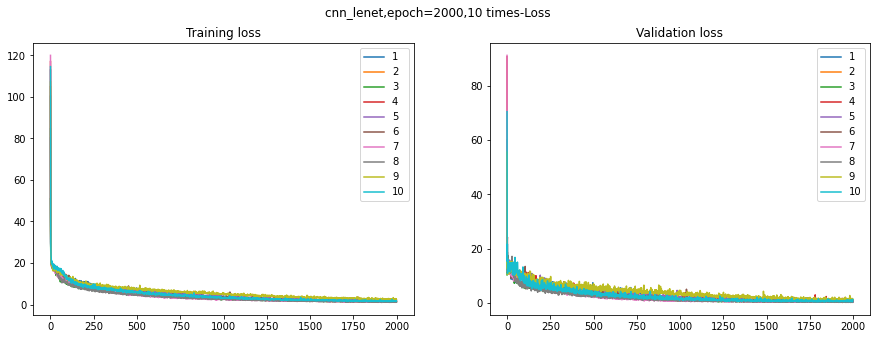

In [111]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
for i in range(10):
    ax[0].plot(history_lenet[i].history['loss'], label=i+1)
    ax[1].plot(history_lenet[i].history['val_loss'], label=i+1)
ax[0].legend()
ax[1].legend()
fig.suptitle('cnn_lenet,epoch=2000,10 times-Loss')
ax[0].set_title('Training loss')
ax[1].set_title('Validation loss')

Text(0.5, 1.0, 'Validation error')

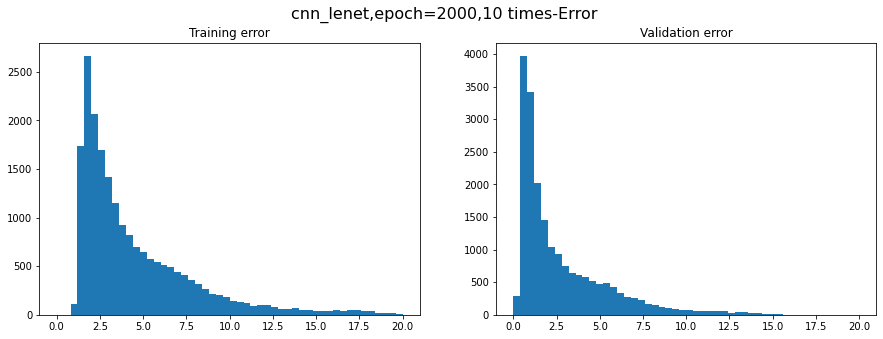

In [114]:
training_error = np.array([])
validation_error = np.array([])
fig, ax = plt.subplots(1,2, figsize=[15,5])
fig.suptitle('cnn_lenet,epoch=2000,10 times-Error', fontsize=16)
for i in range(10):
    training_error = np.append(training_error, history_lenet[i].history['loss'])
    validation_error = np.append(validation_error, history_lenet[i].history['val_loss'])
n_bins = 50
_ = ax[0].hist(training_error, bins=n_bins, range=[0,20])
ax[0].set_title('Training error')
_ = ax[1].hist(validation_error, bins=n_bins, range=[0,20])
ax[1].set_title('Validation error')

Text(0, 0.5, 'mean-squared-error')

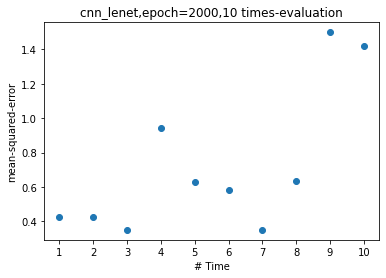

In [149]:
x = np.arange(11)
x_axis = x[1:]

plt.scatter(x_axis, lenet_evals)
plt.title('cnn_lenet,epoch=2000,10 times-evaluation')
plt.xticks(x_axis)
plt.xlabel('# Time')
plt.ylabel('mean-squared-error')

In [110]:
vgg_evals, history_vgg = hist(cnn_vgg)

pooling layers: 4
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_102 (Conv1D)         (None, 100, 64)           9280      
                                                                 
 conv1d_103 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_104 (Conv1D)         (None, 50, 128)           24704     
                                                                 
 conv1d_105 (Conv1D)         (None, 50, 128)           49280     
                                        

11/11 [==============================] - 5s 456ms/step - loss: 6.0317 - mean_squared_error: 6.0317 - val_loss: 10.7987 - val_mean_squared_error: 10.7987
Epoch 30/500
11/11 [==============================] - 5s 468ms/step - loss: 6.7353 - mean_squared_error: 6.7353 - val_loss: 6.7132 - val_mean_squared_error: 6.7132
Epoch 31/500
11/11 [==============================] - 5s 466ms/step - loss: 6.4779 - mean_squared_error: 6.4779 - val_loss: 5.0450 - val_mean_squared_error: 5.0450
Epoch 32/500
11/11 [==============================] - 5s 470ms/step - loss: 5.7601 - mean_squared_error: 5.7601 - val_loss: 4.8762 - val_mean_squared_error: 4.8762
Epoch 33/500
11/11 [==============================] - 5s 465ms/step - loss: 5.2820 - mean_squared_error: 5.2820 - val_loss: 4.5120 - val_mean_squared_error: 4.5120
Epoch 34/500
11/11 [==============================] - 6s 552ms/step - loss: 5.2138 - mean_squared_error: 5.2138 - val_loss: 4.6492 - val_mean_squared_error: 4.6492
Epoch 35/500
11/11 [=======

11/11 [==============================] - 5s 458ms/step - loss: 2.1859 - mean_squared_error: 2.1859 - val_loss: 1.6881 - val_mean_squared_error: 1.6881
Epoch 80/500
11/11 [==============================] - 5s 459ms/step - loss: 2.2900 - mean_squared_error: 2.2900 - val_loss: 2.2112 - val_mean_squared_error: 2.2112
Epoch 81/500
11/11 [==============================] - 5s 467ms/step - loss: 2.3404 - mean_squared_error: 2.3404 - val_loss: 1.5104 - val_mean_squared_error: 1.5104
Epoch 82/500
11/11 [==============================] - 6s 586ms/step - loss: 1.9424 - mean_squared_error: 1.9424 - val_loss: 1.2433 - val_mean_squared_error: 1.2433
Epoch 83/500
11/11 [==============================] - 6s 539ms/step - loss: 1.7394 - mean_squared_error: 1.7394 - val_loss: 1.1995 - val_mean_squared_error: 1.1995
Epoch 84/500
11/11 [==============================] - 5s 460ms/step - loss: 1.4812 - mean_squared_error: 1.4812 - val_loss: 1.0506 - val_mean_squared_error: 1.0506
Epoch 85/500
11/11 [=========

Epoch 129/500
11/11 [==============================] - 5s 467ms/step - loss: 1.2933 - mean_squared_error: 1.2933 - val_loss: 0.7088 - val_mean_squared_error: 0.7088
Epoch 130/500
11/11 [==============================] - 5s 473ms/step - loss: 1.2249 - mean_squared_error: 1.2249 - val_loss: 0.5449 - val_mean_squared_error: 0.5449
Epoch 131/500
11/11 [==============================] - 5s 480ms/step - loss: 1.1102 - mean_squared_error: 1.1102 - val_loss: 0.6780 - val_mean_squared_error: 0.6780
Epoch 132/500
11/11 [==============================] - 5s 473ms/step - loss: 1.1001 - mean_squared_error: 1.1001 - val_loss: 0.6593 - val_mean_squared_error: 0.6593
Epoch 133/500
11/11 [==============================] - 5s 475ms/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 0.5232 - val_mean_squared_error: 0.5232
Epoch 134/500
11/11 [==============================] - 5s 463ms/step - loss: 0.9203 - mean_squared_error: 0.9203 - val_loss: 0.6024 - val_mean_squared_error: 0.6024
Epoch 135/

Epoch 179/500
11/11 [==============================] - 5s 444ms/step - loss: 0.6625 - mean_squared_error: 0.6625 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoch 180/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6190 - mean_squared_error: 0.6190 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 181/500
11/11 [==============================] - 5s 450ms/step - loss: 0.6217 - mean_squared_error: 0.6217 - val_loss: 0.3698 - val_mean_squared_error: 0.3698
Epoch 182/500
11/11 [==============================] - 5s 448ms/step - loss: 0.5493 - mean_squared_error: 0.5493 - val_loss: 0.5902 - val_mean_squared_error: 0.5902
Epoch 183/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6762 - mean_squared_error: 0.6762 - val_loss: 0.3171 - val_mean_squared_error: 0.3171
Epoch 184/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7184 - mean_squared_error: 0.7184 - val_loss: 0.6684 - val_mean_squared_error: 0.6684
Epoch 185/

Epoch 229/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6384 - mean_squared_error: 0.6384 - val_loss: 0.2905 - val_mean_squared_error: 0.2905
Epoch 230/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6087 - mean_squared_error: 0.6087 - val_loss: 0.4503 - val_mean_squared_error: 0.4503
Epoch 231/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7225 - mean_squared_error: 0.7225 - val_loss: 0.4254 - val_mean_squared_error: 0.4254
Epoch 232/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.6167 - val_mean_squared_error: 0.6167
Epoch 233/500
11/11 [==============================] - 5s 448ms/step - loss: 0.7613 - mean_squared_error: 0.7613 - val_loss: 0.4811 - val_mean_squared_error: 0.4811
Epoch 234/500
11/11 [==============================] - 5s 450ms/step - loss: 0.8519 - mean_squared_error: 0.8519 - val_loss: 0.5285 - val_mean_squared_error: 0.5285
Epoch 235/

Epoch 279/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8746 - mean_squared_error: 0.8746 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 280/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5716 - mean_squared_error: 0.5716 - val_loss: 0.2474 - val_mean_squared_error: 0.2474
Epoch 281/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5520 - mean_squared_error: 0.5520 - val_loss: 0.3327 - val_mean_squared_error: 0.3327
Epoch 282/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6291 - mean_squared_error: 0.6291 - val_loss: 0.4527 - val_mean_squared_error: 0.4527
Epoch 283/500
11/11 [==============================] - 5s 452ms/step - loss: 0.6544 - mean_squared_error: 0.6544 - val_loss: 0.4554 - val_mean_squared_error: 0.4554
Epoch 284/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7946 - mean_squared_error: 0.7946 - val_loss: 0.4474 - val_mean_squared_error: 0.4474
Epoch 285/

Epoch 329/500
11/11 [==============================] - 6s 531ms/step - loss: 0.4756 - mean_squared_error: 0.4756 - val_loss: 0.4728 - val_mean_squared_error: 0.4728
Epoch 330/500
11/11 [==============================] - 6s 534ms/step - loss: 0.5441 - mean_squared_error: 0.5441 - val_loss: 0.2748 - val_mean_squared_error: 0.2748
Epoch 331/500
11/11 [==============================] - 6s 521ms/step - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.4501 - val_mean_squared_error: 0.4501
Epoch 332/500
11/11 [==============================] - 6s 507ms/step - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.3990 - val_mean_squared_error: 0.3990
Epoch 333/500
11/11 [==============================] - 5s 499ms/step - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.2307 - val_mean_squared_error: 0.2307
Epoch 334/500
11/11 [==============================] - 6s 502ms/step - loss: 0.5439 - mean_squared_error: 0.5439 - val_loss: 0.2465 - val_mean_squared_error: 0.2465
Epoch 335/

Epoch 379/500
11/11 [==============================] - 6s 500ms/step - loss: 0.4084 - mean_squared_error: 0.4084 - val_loss: 0.1943 - val_mean_squared_error: 0.1943
Epoch 380/500
11/11 [==============================] - 6s 528ms/step - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.2243 - val_mean_squared_error: 0.2243
Epoch 381/500
11/11 [==============================] - 6s 565ms/step - loss: 0.4460 - mean_squared_error: 0.4460 - val_loss: 0.1927 - val_mean_squared_error: 0.1927
Epoch 382/500
11/11 [==============================] - 6s 538ms/step - loss: 0.4472 - mean_squared_error: 0.4472 - val_loss: 0.2306 - val_mean_squared_error: 0.2306
Epoch 383/500
11/11 [==============================] - 5s 491ms/step - loss: 0.4988 - mean_squared_error: 0.4988 - val_loss: 0.1615 - val_mean_squared_error: 0.1615
Epoch 384/500
11/11 [==============================] - 6s 523ms/step - loss: 0.4237 - mean_squared_error: 0.4237 - val_loss: 0.1550 - val_mean_squared_error: 0.1550
Epoch 385/

Epoch 429/500
11/11 [==============================] - 5s 481ms/step - loss: 0.4095 - mean_squared_error: 0.4095 - val_loss: 0.2038 - val_mean_squared_error: 0.2038
Epoch 430/500
11/11 [==============================] - 6s 517ms/step - loss: 0.3698 - mean_squared_error: 0.3698 - val_loss: 0.2066 - val_mean_squared_error: 0.2066
Epoch 431/500
11/11 [==============================] - 6s 504ms/step - loss: 0.3279 - mean_squared_error: 0.3279 - val_loss: 0.1221 - val_mean_squared_error: 0.1221
Epoch 432/500
11/11 [==============================] - 5s 487ms/step - loss: 0.3149 - mean_squared_error: 0.3149 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 433/500
11/11 [==============================] - 6s 525ms/step - loss: 0.3814 - mean_squared_error: 0.3814 - val_loss: 0.2087 - val_mean_squared_error: 0.2087
Epoch 434/500
11/11 [==============================] - 6s 536ms/step - loss: 0.3363 - mean_squared_error: 0.3363 - val_loss: 0.1989 - val_mean_squared_error: 0.1989
Epoch 435/

Epoch 479/500
11/11 [==============================] - 5s 496ms/step - loss: 0.4258 - mean_squared_error: 0.4258 - val_loss: 0.2132 - val_mean_squared_error: 0.2132
Epoch 480/500
11/11 [==============================] - 5s 490ms/step - loss: 0.3773 - mean_squared_error: 0.3773 - val_loss: 0.2796 - val_mean_squared_error: 0.2796
Epoch 481/500
11/11 [==============================] - 5s 493ms/step - loss: 0.4052 - mean_squared_error: 0.4052 - val_loss: 0.3048 - val_mean_squared_error: 0.3048
Epoch 482/500
11/11 [==============================] - 5s 489ms/step - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.2535 - val_mean_squared_error: 0.2535
Epoch 483/500
11/11 [==============================] - 5s 491ms/step - loss: 0.4019 - mean_squared_error: 0.4019 - val_loss: 0.3789 - val_mean_squared_error: 0.3789
Epoch 484/500
11/11 [==============================] - 5s 489ms/step - loss: 0.4804 - mean_squared_error: 0.4804 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 485/

Epoch 7/500
11/11 [==============================] - 5s 485ms/step - loss: 12.3121 - mean_squared_error: 12.3121 - val_loss: 10.7799 - val_mean_squared_error: 10.7799
Epoch 8/500
11/11 [==============================] - 5s 488ms/step - loss: 13.0316 - mean_squared_error: 13.0316 - val_loss: 11.4884 - val_mean_squared_error: 11.4884
Epoch 9/500
11/11 [==============================] - 5s 485ms/step - loss: 12.8448 - mean_squared_error: 12.8448 - val_loss: 14.2898 - val_mean_squared_error: 14.2898
Epoch 10/500
11/11 [==============================] - 5s 491ms/step - loss: 12.8401 - mean_squared_error: 12.8401 - val_loss: 11.3237 - val_mean_squared_error: 11.3237
Epoch 11/500
11/11 [==============================] - 5s 490ms/step - loss: 12.6740 - mean_squared_error: 12.6740 - val_loss: 11.6419 - val_mean_squared_error: 11.6419
Epoch 12/500
11/11 [==============================] - 5s 486ms/step - loss: 11.6815 - mean_squared_error: 11.6815 - val_loss: 12.1370 - val_mean_squared_error: 12.

Epoch 57/500
11/11 [==============================] - 6s 505ms/step - loss: 5.1733 - mean_squared_error: 5.1733 - val_loss: 4.8557 - val_mean_squared_error: 4.8557
Epoch 58/500
11/11 [==============================] - 6s 504ms/step - loss: 4.7859 - mean_squared_error: 4.7859 - val_loss: 3.6850 - val_mean_squared_error: 3.6850
Epoch 59/500
11/11 [==============================] - 5s 489ms/step - loss: 5.2229 - mean_squared_error: 5.2229 - val_loss: 8.4558 - val_mean_squared_error: 8.4558
Epoch 60/500
11/11 [==============================] - 5s 486ms/step - loss: 5.2233 - mean_squared_error: 5.2233 - val_loss: 4.3799 - val_mean_squared_error: 4.3799
Epoch 61/500
11/11 [==============================] - 5s 498ms/step - loss: 4.5349 - mean_squared_error: 4.5349 - val_loss: 4.7293 - val_mean_squared_error: 4.7293
Epoch 62/500
11/11 [==============================] - 6s 570ms/step - loss: 4.5703 - mean_squared_error: 4.5703 - val_loss: 3.9980 - val_mean_squared_error: 3.9980
Epoch 63/500
11/

Epoch 107/500
11/11 [==============================] - 5s 481ms/step - loss: 2.9314 - mean_squared_error: 2.9314 - val_loss: 2.0427 - val_mean_squared_error: 2.0427
Epoch 108/500
11/11 [==============================] - 5s 487ms/step - loss: 2.3073 - mean_squared_error: 2.3073 - val_loss: 1.9218 - val_mean_squared_error: 1.9218
Epoch 109/500
11/11 [==============================] - 6s 504ms/step - loss: 2.7139 - mean_squared_error: 2.7139 - val_loss: 2.0421 - val_mean_squared_error: 2.0421
Epoch 110/500
11/11 [==============================] - 6s 513ms/step - loss: 2.9460 - mean_squared_error: 2.9460 - val_loss: 2.6883 - val_mean_squared_error: 2.6883
Epoch 111/500
11/11 [==============================] - 6s 524ms/step - loss: 2.9919 - mean_squared_error: 2.9919 - val_loss: 2.4214 - val_mean_squared_error: 2.4214
Epoch 112/500
11/11 [==============================] - 7s 657ms/step - loss: 3.2693 - mean_squared_error: 3.2693 - val_loss: 2.5868 - val_mean_squared_error: 2.5868
Epoch 113/

Epoch 157/500
11/11 [==============================] - 6s 497ms/step - loss: 1.5499 - mean_squared_error: 1.5499 - val_loss: 0.7834 - val_mean_squared_error: 0.7834
Epoch 158/500
11/11 [==============================] - 6s 506ms/step - loss: 1.4338 - mean_squared_error: 1.4338 - val_loss: 0.8644 - val_mean_squared_error: 0.8644
Epoch 159/500
11/11 [==============================] - 5s 498ms/step - loss: 1.5520 - mean_squared_error: 1.5520 - val_loss: 0.9199 - val_mean_squared_error: 0.9199
Epoch 160/500
11/11 [==============================] - 6s 529ms/step - loss: 1.4869 - mean_squared_error: 1.4869 - val_loss: 1.0087 - val_mean_squared_error: 1.0087
Epoch 161/500
11/11 [==============================] - 5s 487ms/step - loss: 1.4644 - mean_squared_error: 1.4644 - val_loss: 1.2442 - val_mean_squared_error: 1.2442
Epoch 162/500
11/11 [==============================] - 5s 482ms/step - loss: 1.2545 - mean_squared_error: 1.2545 - val_loss: 0.7305 - val_mean_squared_error: 0.7305
Epoch 163/

Epoch 207/500
11/11 [==============================] - 5s 486ms/step - loss: 1.4537 - mean_squared_error: 1.4537 - val_loss: 1.7486 - val_mean_squared_error: 1.7486
Epoch 208/500
11/11 [==============================] - 5s 490ms/step - loss: 1.4688 - mean_squared_error: 1.4688 - val_loss: 1.5327 - val_mean_squared_error: 1.5327
Epoch 209/500
11/11 [==============================] - 6s 512ms/step - loss: 1.1212 - mean_squared_error: 1.1212 - val_loss: 1.8078 - val_mean_squared_error: 1.8078
Epoch 210/500
11/11 [==============================] - 6s 504ms/step - loss: 1.3649 - mean_squared_error: 1.3649 - val_loss: 0.8294 - val_mean_squared_error: 0.8294
Epoch 211/500
11/11 [==============================] - 6s 514ms/step - loss: 1.1209 - mean_squared_error: 1.1209 - val_loss: 0.6163 - val_mean_squared_error: 0.6163
Epoch 212/500
11/11 [==============================] - 6s 519ms/step - loss: 1.0540 - mean_squared_error: 1.0540 - val_loss: 0.7225 - val_mean_squared_error: 0.7225
Epoch 213/

Epoch 257/500
11/11 [==============================] - 5s 485ms/step - loss: 1.1149 - mean_squared_error: 1.1149 - val_loss: 1.3030 - val_mean_squared_error: 1.3030
Epoch 258/500
11/11 [==============================] - 5s 483ms/step - loss: 0.9956 - mean_squared_error: 0.9956 - val_loss: 0.6275 - val_mean_squared_error: 0.6275
Epoch 259/500
11/11 [==============================] - 6s 521ms/step - loss: 0.8595 - mean_squared_error: 0.8595 - val_loss: 0.6929 - val_mean_squared_error: 0.6929
Epoch 260/500
11/11 [==============================] - 5s 496ms/step - loss: 0.9115 - mean_squared_error: 0.9115 - val_loss: 0.8683 - val_mean_squared_error: 0.8683
Epoch 261/500
11/11 [==============================] - 5s 491ms/step - loss: 1.0438 - mean_squared_error: 1.0438 - val_loss: 1.0027 - val_mean_squared_error: 1.0027
Epoch 262/500
11/11 [==============================] - 5s 485ms/step - loss: 1.0089 - mean_squared_error: 1.0089 - val_loss: 0.5402 - val_mean_squared_error: 0.5402
Epoch 263/

Epoch 307/500
11/11 [==============================] - 6s 502ms/step - loss: 0.7984 - mean_squared_error: 0.7984 - val_loss: 0.4914 - val_mean_squared_error: 0.4914
Epoch 308/500
11/11 [==============================] - 6s 555ms/step - loss: 0.7978 - mean_squared_error: 0.7978 - val_loss: 0.4889 - val_mean_squared_error: 0.4889
Epoch 309/500
11/11 [==============================] - 7s 680ms/step - loss: 0.8188 - mean_squared_error: 0.8188 - val_loss: 0.4939 - val_mean_squared_error: 0.4939
Epoch 310/500
11/11 [==============================] - 6s 513ms/step - loss: 0.8342 - mean_squared_error: 0.8342 - val_loss: 0.3790 - val_mean_squared_error: 0.3790
Epoch 311/500
11/11 [==============================] - 6s 522ms/step - loss: 0.6533 - mean_squared_error: 0.6533 - val_loss: 0.3177 - val_mean_squared_error: 0.3177
Epoch 312/500
11/11 [==============================] - 6s 531ms/step - loss: 0.6821 - mean_squared_error: 0.6821 - val_loss: 0.2164 - val_mean_squared_error: 0.2164
Epoch 313/

Epoch 357/500
11/11 [==============================] - 5s 493ms/step - loss: 1.0990 - mean_squared_error: 1.0990 - val_loss: 0.8484 - val_mean_squared_error: 0.8484
Epoch 358/500
11/11 [==============================] - 5s 493ms/step - loss: 1.1262 - mean_squared_error: 1.1262 - val_loss: 1.2200 - val_mean_squared_error: 1.2200
Epoch 359/500
11/11 [==============================] - 5s 489ms/step - loss: 1.0528 - mean_squared_error: 1.0528 - val_loss: 0.7021 - val_mean_squared_error: 0.7021
Epoch 360/500
11/11 [==============================] - 5s 495ms/step - loss: 1.0061 - mean_squared_error: 1.0061 - val_loss: 0.5788 - val_mean_squared_error: 0.5788
Epoch 361/500
11/11 [==============================] - 5s 488ms/step - loss: 0.8450 - mean_squared_error: 0.8450 - val_loss: 0.4810 - val_mean_squared_error: 0.4810
Epoch 362/500
11/11 [==============================] - 5s 492ms/step - loss: 0.7800 - mean_squared_error: 0.7800 - val_loss: 0.3314 - val_mean_squared_error: 0.3314
Epoch 363/

Epoch 407/500
11/11 [==============================] - 6s 523ms/step - loss: 0.8951 - mean_squared_error: 0.8951 - val_loss: 0.4485 - val_mean_squared_error: 0.4485
Epoch 408/500
11/11 [==============================] - 6s 539ms/step - loss: 0.7160 - mean_squared_error: 0.7160 - val_loss: 0.5900 - val_mean_squared_error: 0.5900
Epoch 409/500
11/11 [==============================] - 7s 605ms/step - loss: 0.7319 - mean_squared_error: 0.7319 - val_loss: 0.4425 - val_mean_squared_error: 0.4425
Epoch 410/500
11/11 [==============================] - 7s 659ms/step - loss: 0.8704 - mean_squared_error: 0.8704 - val_loss: 0.5030 - val_mean_squared_error: 0.5030
Epoch 411/500
11/11 [==============================] - 6s 542ms/step - loss: 0.8530 - mean_squared_error: 0.8530 - val_loss: 0.4314 - val_mean_squared_error: 0.4314
Epoch 412/500
11/11 [==============================] - 6s 536ms/step - loss: 0.7491 - mean_squared_error: 0.7491 - val_loss: 0.5436 - val_mean_squared_error: 0.5436
Epoch 413/

Epoch 457/500
11/11 [==============================] - 6s 513ms/step - loss: 0.6820 - mean_squared_error: 0.6820 - val_loss: 0.8127 - val_mean_squared_error: 0.8127
Epoch 458/500
11/11 [==============================] - 6s 512ms/step - loss: 0.7887 - mean_squared_error: 0.7887 - val_loss: 0.3794 - val_mean_squared_error: 0.3794
Epoch 459/500
11/11 [==============================] - 6s 537ms/step - loss: 0.8117 - mean_squared_error: 0.8117 - val_loss: 0.3103 - val_mean_squared_error: 0.3103
Epoch 460/500
11/11 [==============================] - 6s 518ms/step - loss: 0.7408 - mean_squared_error: 0.7408 - val_loss: 0.5406 - val_mean_squared_error: 0.5406
Epoch 461/500
11/11 [==============================] - 6s 574ms/step - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.8005 - val_mean_squared_error: 0.8005
Epoch 462/500
11/11 [==============================] - 6s 590ms/step - loss: 0.9019 - mean_squared_error: 0.9019 - val_loss: 0.7703 - val_mean_squared_error: 0.7703
Epoch 463/

11/11 [==============================] - 8s 570ms/step - loss: 1489.5331 - mean_squared_error: 1489.5331 - val_loss: 15.8127 - val_mean_squared_error: 15.8127
Epoch 2/500
11/11 [==============================] - 6s 507ms/step - loss: 14.5969 - mean_squared_error: 14.5969 - val_loss: 12.3975 - val_mean_squared_error: 12.3975
Epoch 3/500
11/11 [==============================] - 6s 547ms/step - loss: 13.4886 - mean_squared_error: 13.4886 - val_loss: 16.7804 - val_mean_squared_error: 16.7804
Epoch 4/500
11/11 [==============================] - 6s 507ms/step - loss: 14.6863 - mean_squared_error: 14.6863 - val_loss: 11.7555 - val_mean_squared_error: 11.7555
Epoch 5/500
11/11 [==============================] - 5s 490ms/step - loss: 12.1724 - mean_squared_error: 12.1724 - val_loss: 15.7379 - val_mean_squared_error: 15.7379
Epoch 6/500
11/11 [==============================] - 6s 502ms/step - loss: 12.5638 - mean_squared_error: 12.5638 - val_loss: 10.9301 - val_mean_squared_error: 10.9301
Epoch 

Epoch 51/500
11/11 [==============================] - 5s 446ms/step - loss: 3.9131 - mean_squared_error: 3.9131 - val_loss: 2.9599 - val_mean_squared_error: 2.9599
Epoch 52/500
11/11 [==============================] - 5s 443ms/step - loss: 3.3504 - mean_squared_error: 3.3504 - val_loss: 2.6896 - val_mean_squared_error: 2.6896
Epoch 53/500
11/11 [==============================] - 5s 450ms/step - loss: 3.4952 - mean_squared_error: 3.4952 - val_loss: 2.6491 - val_mean_squared_error: 2.6491
Epoch 54/500
11/11 [==============================] - 5s 440ms/step - loss: 3.0238 - mean_squared_error: 3.0238 - val_loss: 2.9386 - val_mean_squared_error: 2.9386
Epoch 55/500
11/11 [==============================] - 5s 450ms/step - loss: 3.2512 - mean_squared_error: 3.2512 - val_loss: 2.4688 - val_mean_squared_error: 2.4688
Epoch 56/500
11/11 [==============================] - 5s 445ms/step - loss: 3.1878 - mean_squared_error: 3.1878 - val_loss: 1.9786 - val_mean_squared_error: 1.9786
Epoch 57/500
11/

Epoch 101/500
11/11 [==============================] - 5s 442ms/step - loss: 1.3426 - mean_squared_error: 1.3426 - val_loss: 0.7400 - val_mean_squared_error: 0.7400
Epoch 102/500
11/11 [==============================] - 5s 450ms/step - loss: 1.3279 - mean_squared_error: 1.3279 - val_loss: 0.7041 - val_mean_squared_error: 0.7041
Epoch 103/500
11/11 [==============================] - 5s 444ms/step - loss: 1.1991 - mean_squared_error: 1.1991 - val_loss: 0.8809 - val_mean_squared_error: 0.8809
Epoch 104/500
11/11 [==============================] - 5s 444ms/step - loss: 1.2063 - mean_squared_error: 1.2063 - val_loss: 1.1624 - val_mean_squared_error: 1.1624
Epoch 105/500
11/11 [==============================] - 5s 449ms/step - loss: 1.4889 - mean_squared_error: 1.4889 - val_loss: 0.9930 - val_mean_squared_error: 0.9930
Epoch 106/500
11/11 [==============================] - 5s 446ms/step - loss: 1.3155 - mean_squared_error: 1.3155 - val_loss: 0.5086 - val_mean_squared_error: 0.5086
Epoch 107/

Epoch 151/500
11/11 [==============================] - 5s 447ms/step - loss: 0.9445 - mean_squared_error: 0.9445 - val_loss: 0.7892 - val_mean_squared_error: 0.7892
Epoch 152/500
11/11 [==============================] - 5s 444ms/step - loss: 1.0155 - mean_squared_error: 1.0155 - val_loss: 1.0663 - val_mean_squared_error: 1.0663
Epoch 153/500
11/11 [==============================] - 5s 446ms/step - loss: 0.9269 - mean_squared_error: 0.9269 - val_loss: 0.4615 - val_mean_squared_error: 0.4615
Epoch 154/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7305 - mean_squared_error: 0.7305 - val_loss: 0.6930 - val_mean_squared_error: 0.6930
Epoch 155/500
11/11 [==============================] - 5s 496ms/step - loss: 0.8343 - mean_squared_error: 0.8343 - val_loss: 0.5106 - val_mean_squared_error: 0.5106
Epoch 156/500
11/11 [==============================] - 6s 513ms/step - loss: 0.8666 - mean_squared_error: 0.8666 - val_loss: 0.4841 - val_mean_squared_error: 0.4841
Epoch 157/

Epoch 201/500
11/11 [==============================] - 5s 450ms/step - loss: 1.1444 - mean_squared_error: 1.1444 - val_loss: 0.5004 - val_mean_squared_error: 0.5004
Epoch 202/500
11/11 [==============================] - 5s 448ms/step - loss: 1.0327 - mean_squared_error: 1.0327 - val_loss: 0.4028 - val_mean_squared_error: 0.4028
Epoch 203/500
11/11 [==============================] - 5s 442ms/step - loss: 0.8497 - mean_squared_error: 0.8497 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 204/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7619 - mean_squared_error: 0.7619 - val_loss: 0.6288 - val_mean_squared_error: 0.6288
Epoch 205/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8618 - mean_squared_error: 0.8618 - val_loss: 0.6430 - val_mean_squared_error: 0.6430
Epoch 206/500
11/11 [==============================] - 5s 444ms/step - loss: 0.8163 - mean_squared_error: 0.8163 - val_loss: 0.3893 - val_mean_squared_error: 0.3893
Epoch 207/

Epoch 251/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8014 - mean_squared_error: 0.8014 - val_loss: 0.4396 - val_mean_squared_error: 0.4396
Epoch 252/500
11/11 [==============================] - 5s 441ms/step - loss: 0.7983 - mean_squared_error: 0.7983 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 253/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7532 - mean_squared_error: 0.7532 - val_loss: 0.4000 - val_mean_squared_error: 0.4000
Epoch 254/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7074 - mean_squared_error: 0.7074 - val_loss: 0.6562 - val_mean_squared_error: 0.6562
Epoch 255/500
11/11 [==============================] - 5s 449ms/step - loss: 0.8752 - mean_squared_error: 0.8752 - val_loss: 0.4170 - val_mean_squared_error: 0.4170
Epoch 256/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8681 - mean_squared_error: 0.8681 - val_loss: 0.2960 - val_mean_squared_error: 0.2960
Epoch 257/

Epoch 301/500
11/11 [==============================] - 5s 448ms/step - loss: 1.0139 - mean_squared_error: 1.0139 - val_loss: 0.4577 - val_mean_squared_error: 0.4577
Epoch 302/500
11/11 [==============================] - 5s 455ms/step - loss: 0.7500 - mean_squared_error: 0.7500 - val_loss: 0.3361 - val_mean_squared_error: 0.3361
Epoch 303/500
11/11 [==============================] - 5s 453ms/step - loss: 0.6907 - mean_squared_error: 0.6907 - val_loss: 0.3333 - val_mean_squared_error: 0.3333
Epoch 304/500
11/11 [==============================] - 5s 455ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - val_loss: 0.3245 - val_mean_squared_error: 0.3245
Epoch 305/500
11/11 [==============================] - 5s 452ms/step - loss: 0.7832 - mean_squared_error: 0.7832 - val_loss: 0.5044 - val_mean_squared_error: 0.5044
Epoch 306/500
11/11 [==============================] - 5s 451ms/step - loss: 1.0105 - mean_squared_error: 1.0105 - val_loss: 0.8926 - val_mean_squared_error: 0.8926
Epoch 307/

Epoch 351/500
11/11 [==============================] - 5s 451ms/step - loss: 1.1322 - mean_squared_error: 1.1322 - val_loss: 0.9046 - val_mean_squared_error: 0.9046
Epoch 352/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8349 - mean_squared_error: 0.8349 - val_loss: 0.5353 - val_mean_squared_error: 0.5353
Epoch 353/500
11/11 [==============================] - 5s 444ms/step - loss: 0.9340 - mean_squared_error: 0.9340 - val_loss: 1.0468 - val_mean_squared_error: 1.0468
Epoch 354/500
11/11 [==============================] - 5s 448ms/step - loss: 1.0394 - mean_squared_error: 1.0394 - val_loss: 0.5614 - val_mean_squared_error: 0.5614
Epoch 355/500
11/11 [==============================] - 5s 444ms/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 0.6778 - val_mean_squared_error: 0.6778
Epoch 356/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8555 - mean_squared_error: 0.8555 - val_loss: 0.5537 - val_mean_squared_error: 0.5537
Epoch 357/

Epoch 401/500
11/11 [==============================] - 5s 442ms/step - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.5421 - val_mean_squared_error: 0.5421
Epoch 402/500
11/11 [==============================] - 5s 441ms/step - loss: 0.7124 - mean_squared_error: 0.7124 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 403/500
11/11 [==============================] - 5s 448ms/step - loss: 0.5517 - mean_squared_error: 0.5517 - val_loss: 0.3482 - val_mean_squared_error: 0.3482
Epoch 404/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5425 - mean_squared_error: 0.5425 - val_loss: 0.2687 - val_mean_squared_error: 0.2687
Epoch 405/500
11/11 [==============================] - 5s 467ms/step - loss: 0.5277 - mean_squared_error: 0.5277 - val_loss: 0.2476 - val_mean_squared_error: 0.2476
Epoch 406/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6115 - mean_squared_error: 0.6115 - val_loss: 0.2509 - val_mean_squared_error: 0.2509
Epoch 407/

Epoch 451/500
11/11 [==============================] - 5s 440ms/step - loss: 0.6353 - mean_squared_error: 0.6353 - val_loss: 0.2365 - val_mean_squared_error: 0.2365
Epoch 452/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5688 - mean_squared_error: 0.5688 - val_loss: 0.2338 - val_mean_squared_error: 0.2338
Epoch 453/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5371 - mean_squared_error: 0.5371 - val_loss: 0.2391 - val_mean_squared_error: 0.2391
Epoch 454/500
11/11 [==============================] - 5s 442ms/step - loss: 0.5429 - mean_squared_error: 0.5429 - val_loss: 0.3306 - val_mean_squared_error: 0.3306
Epoch 455/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6148 - mean_squared_error: 0.6148 - val_loss: 0.7979 - val_mean_squared_error: 0.7979
Epoch 456/500
11/11 [==============================] - 5s 443ms/step - loss: 0.6917 - mean_squared_error: 0.6917 - val_loss: 0.5530 - val_mean_squared_error: 0.5530
Epoch 457/

3/3 [==============================] - 0s 46ms/step - loss: 0.2942 - mean_squared_error: 0.2942
pooling layers: 4
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_132 (Conv1D)         (None, 100, 64)           9280      
                                                                 
 conv1d_133 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 max_pooling1d_108 (MaxPooli  (None, 50, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_134 (Conv1D)         (None, 50, 128)           24704     
                                                                 
 conv1d_13

Epoch 29/500
11/11 [==============================] - 5s 454ms/step - loss: 7.7002 - mean_squared_error: 7.7002 - val_loss: 5.6400 - val_mean_squared_error: 5.6400
Epoch 30/500
11/11 [==============================] - 5s 471ms/step - loss: 6.6137 - mean_squared_error: 6.6137 - val_loss: 6.0896 - val_mean_squared_error: 6.0896
Epoch 31/500
11/11 [==============================] - 5s 458ms/step - loss: 6.1464 - mean_squared_error: 6.1464 - val_loss: 6.5614 - val_mean_squared_error: 6.5614
Epoch 32/500
11/11 [==============================] - 5s 462ms/step - loss: 7.0180 - mean_squared_error: 7.0180 - val_loss: 10.4892 - val_mean_squared_error: 10.4892
Epoch 33/500
11/11 [==============================] - 5s 465ms/step - loss: 8.2512 - mean_squared_error: 8.2512 - val_loss: 5.2540 - val_mean_squared_error: 5.2540
Epoch 34/500
11/11 [==============================] - 5s 458ms/step - loss: 7.0551 - mean_squared_error: 7.0551 - val_loss: 4.9600 - val_mean_squared_error: 4.9600
Epoch 35/500
1

Epoch 79/500
11/11 [==============================] - 5s 443ms/step - loss: 2.6686 - mean_squared_error: 2.6686 - val_loss: 2.9657 - val_mean_squared_error: 2.9657
Epoch 80/500
11/11 [==============================] - 5s 454ms/step - loss: 3.4465 - mean_squared_error: 3.4465 - val_loss: 3.6870 - val_mean_squared_error: 3.6870
Epoch 81/500
11/11 [==============================] - 5s 467ms/step - loss: 3.5834 - mean_squared_error: 3.5834 - val_loss: 5.7482 - val_mean_squared_error: 5.7482
Epoch 82/500
11/11 [==============================] - 5s 451ms/step - loss: 4.4399 - mean_squared_error: 4.4399 - val_loss: 2.7425 - val_mean_squared_error: 2.7425
Epoch 83/500
11/11 [==============================] - 5s 453ms/step - loss: 3.0972 - mean_squared_error: 3.0972 - val_loss: 2.5454 - val_mean_squared_error: 2.5454
Epoch 84/500
11/11 [==============================] - 5s 453ms/step - loss: 3.0126 - mean_squared_error: 3.0126 - val_loss: 3.1670 - val_mean_squared_error: 3.1670
Epoch 85/500
11/

Epoch 129/500
11/11 [==============================] - 5s 453ms/step - loss: 1.6348 - mean_squared_error: 1.6348 - val_loss: 1.2659 - val_mean_squared_error: 1.2659
Epoch 130/500
11/11 [==============================] - 5s 453ms/step - loss: 1.4688 - mean_squared_error: 1.4688 - val_loss: 0.9086 - val_mean_squared_error: 0.9086
Epoch 131/500
11/11 [==============================] - 5s 454ms/step - loss: 1.0775 - mean_squared_error: 1.0775 - val_loss: 0.8672 - val_mean_squared_error: 0.8672
Epoch 132/500
11/11 [==============================] - 5s 451ms/step - loss: 1.2104 - mean_squared_error: 1.2104 - val_loss: 2.2256 - val_mean_squared_error: 2.2256
Epoch 133/500
11/11 [==============================] - 5s 461ms/step - loss: 1.4813 - mean_squared_error: 1.4813 - val_loss: 0.7740 - val_mean_squared_error: 0.7740
Epoch 134/500
11/11 [==============================] - 5s 460ms/step - loss: 1.1033 - mean_squared_error: 1.1033 - val_loss: 0.5752 - val_mean_squared_error: 0.5752
Epoch 135/

Epoch 179/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6172 - mean_squared_error: 0.6172 - val_loss: 0.7749 - val_mean_squared_error: 0.7749
Epoch 180/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8596 - mean_squared_error: 0.8596 - val_loss: 0.2977 - val_mean_squared_error: 0.2977
Epoch 181/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6411 - mean_squared_error: 0.6411 - val_loss: 0.4006 - val_mean_squared_error: 0.4006
Epoch 182/500
11/11 [==============================] - 5s 455ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - val_loss: 0.7630 - val_mean_squared_error: 0.7630
Epoch 183/500
11/11 [==============================] - 5s 467ms/step - loss: 0.9049 - mean_squared_error: 0.9049 - val_loss: 0.4525 - val_mean_squared_error: 0.4525
Epoch 184/500
11/11 [==============================] - 5s 455ms/step - loss: 0.7255 - mean_squared_error: 0.7255 - val_loss: 0.4542 - val_mean_squared_error: 0.4542
Epoch 185/

Epoch 229/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6742 - mean_squared_error: 0.6742 - val_loss: 0.5154 - val_mean_squared_error: 0.5154
Epoch 230/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7567 - mean_squared_error: 0.7567 - val_loss: 0.3970 - val_mean_squared_error: 0.3970
Epoch 231/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8995 - mean_squared_error: 0.8995 - val_loss: 0.3027 - val_mean_squared_error: 0.3027
Epoch 232/500
11/11 [==============================] - 5s 444ms/step - loss: 0.7652 - mean_squared_error: 0.7652 - val_loss: 0.4692 - val_mean_squared_error: 0.4692
Epoch 233/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8867 - mean_squared_error: 0.8867 - val_loss: 0.5617 - val_mean_squared_error: 0.5617
Epoch 234/500
11/11 [==============================] - 5s 449ms/step - loss: 0.8637 - mean_squared_error: 0.8637 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 235/

Epoch 279/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5239 - mean_squared_error: 0.5239 - val_loss: 0.3510 - val_mean_squared_error: 0.3510
Epoch 280/500
11/11 [==============================] - 5s 450ms/step - loss: 0.6741 - mean_squared_error: 0.6741 - val_loss: 0.3540 - val_mean_squared_error: 0.3540
Epoch 281/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6651 - mean_squared_error: 0.6651 - val_loss: 0.2643 - val_mean_squared_error: 0.2643
Epoch 282/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6076 - mean_squared_error: 0.6076 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 283/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.2213 - val_mean_squared_error: 0.2213
Epoch 284/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6701 - mean_squared_error: 0.6701 - val_loss: 0.2264 - val_mean_squared_error: 0.2264
Epoch 285/

Epoch 329/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6056 - mean_squared_error: 0.6056 - val_loss: 0.2859 - val_mean_squared_error: 0.2859
Epoch 330/500
11/11 [==============================] - 5s 442ms/step - loss: 0.6274 - mean_squared_error: 0.6274 - val_loss: 0.4062 - val_mean_squared_error: 0.4062
Epoch 331/500
11/11 [==============================] - 5s 442ms/step - loss: 0.6163 - mean_squared_error: 0.6163 - val_loss: 0.5960 - val_mean_squared_error: 0.5960
Epoch 332/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6319 - mean_squared_error: 0.6319 - val_loss: 0.4388 - val_mean_squared_error: 0.4388
Epoch 333/500
11/11 [==============================] - 5s 442ms/step - loss: 1.0948 - mean_squared_error: 1.0948 - val_loss: 0.9083 - val_mean_squared_error: 0.9083
Epoch 334/500
11/11 [==============================] - 5s 443ms/step - loss: 0.9403 - mean_squared_error: 0.9403 - val_loss: 0.6577 - val_mean_squared_error: 0.6577
Epoch 335/

Epoch 379/500
11/11 [==============================] - 5s 451ms/step - loss: 0.6541 - mean_squared_error: 0.6541 - val_loss: 0.6744 - val_mean_squared_error: 0.6744
Epoch 380/500
11/11 [==============================] - 5s 450ms/step - loss: 0.8218 - mean_squared_error: 0.8218 - val_loss: 0.3955 - val_mean_squared_error: 0.3955
Epoch 381/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7108 - mean_squared_error: 0.7108 - val_loss: 0.3199 - val_mean_squared_error: 0.3199
Epoch 382/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6180 - mean_squared_error: 0.6180 - val_loss: 0.7774 - val_mean_squared_error: 0.7774
Epoch 383/500
11/11 [==============================] - 5s 449ms/step - loss: 0.8180 - mean_squared_error: 0.8180 - val_loss: 0.4631 - val_mean_squared_error: 0.4631
Epoch 384/500
11/11 [==============================] - 5s 448ms/step - loss: 0.5884 - mean_squared_error: 0.5884 - val_loss: 0.4963 - val_mean_squared_error: 0.4963
Epoch 385/

Epoch 429/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6790 - mean_squared_error: 0.6790 - val_loss: 0.5004 - val_mean_squared_error: 0.5004
Epoch 430/500
11/11 [==============================] - 5s 448ms/step - loss: 0.5922 - mean_squared_error: 0.5922 - val_loss: 0.3270 - val_mean_squared_error: 0.3270
Epoch 431/500
11/11 [==============================] - 5s 446ms/step - loss: 0.5971 - mean_squared_error: 0.5971 - val_loss: 0.9998 - val_mean_squared_error: 0.9998
Epoch 432/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7807 - mean_squared_error: 0.7807 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 433/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5380 - mean_squared_error: 0.5380 - val_loss: 0.5743 - val_mean_squared_error: 0.5743
Epoch 434/500
11/11 [==============================] - 5s 444ms/step - loss: 0.7760 - mean_squared_error: 0.7760 - val_loss: 0.3402 - val_mean_squared_error: 0.3402
Epoch 435/

Epoch 479/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 1.1722 - val_mean_squared_error: 1.1722
Epoch 480/500
11/11 [==============================] - 5s 441ms/step - loss: 0.8774 - mean_squared_error: 0.8774 - val_loss: 1.0092 - val_mean_squared_error: 1.0092
Epoch 481/500
11/11 [==============================] - 5s 445ms/step - loss: 0.9491 - mean_squared_error: 0.9491 - val_loss: 0.9523 - val_mean_squared_error: 0.9523
Epoch 482/500
11/11 [==============================] - 5s 450ms/step - loss: 0.9211 - mean_squared_error: 0.9211 - val_loss: 0.4645 - val_mean_squared_error: 0.4645
Epoch 483/500
11/11 [==============================] - 5s 450ms/step - loss: 0.7280 - mean_squared_error: 0.7280 - val_loss: 0.3732 - val_mean_squared_error: 0.3732
Epoch 484/500
11/11 [==============================] - 5s 459ms/step - loss: 0.6059 - mean_squared_error: 0.6059 - val_loss: 0.5482 - val_mean_squared_error: 0.5482
Epoch 485/

Epoch 7/500
11/11 [==============================] - 5s 497ms/step - loss: 12.9589 - mean_squared_error: 12.9589 - val_loss: 12.0244 - val_mean_squared_error: 12.0244
Epoch 8/500
11/11 [==============================] - 5s 493ms/step - loss: 13.6101 - mean_squared_error: 13.6101 - val_loss: 11.6196 - val_mean_squared_error: 11.6196
Epoch 9/500
11/11 [==============================] - 6s 502ms/step - loss: 13.3623 - mean_squared_error: 13.3623 - val_loss: 13.4525 - val_mean_squared_error: 13.4525
Epoch 10/500
11/11 [==============================] - 5s 500ms/step - loss: 13.9761 - mean_squared_error: 13.9761 - val_loss: 12.3895 - val_mean_squared_error: 12.3895
Epoch 11/500
11/11 [==============================] - 5s 487ms/step - loss: 14.7741 - mean_squared_error: 14.7741 - val_loss: 14.3336 - val_mean_squared_error: 14.3336
Epoch 12/500
11/11 [==============================] - 5s 493ms/step - loss: 13.8584 - mean_squared_error: 13.8584 - val_loss: 11.5735 - val_mean_squared_error: 11.

11/11 [==============================] - 5s 449ms/step - loss: 4.6179 - mean_squared_error: 4.6179 - val_loss: 3.8843 - val_mean_squared_error: 3.8843
Epoch 57/500
11/11 [==============================] - 5s 443ms/step - loss: 4.8839 - mean_squared_error: 4.8839 - val_loss: 3.4023 - val_mean_squared_error: 3.4023
Epoch 58/500
11/11 [==============================] - 5s 448ms/step - loss: 4.5658 - mean_squared_error: 4.5658 - val_loss: 4.2635 - val_mean_squared_error: 4.2635
Epoch 59/500
11/11 [==============================] - 5s 449ms/step - loss: 4.6839 - mean_squared_error: 4.6839 - val_loss: 3.6228 - val_mean_squared_error: 3.6228
Epoch 60/500
11/11 [==============================] - 5s 445ms/step - loss: 4.5090 - mean_squared_error: 4.5090 - val_loss: 3.2559 - val_mean_squared_error: 3.2559
Epoch 61/500
11/11 [==============================] - 5s 446ms/step - loss: 4.3403 - mean_squared_error: 4.3403 - val_loss: 3.2812 - val_mean_squared_error: 3.2812
Epoch 62/500
11/11 [=========

Epoch 106/500
11/11 [==============================] - 5s 450ms/step - loss: 3.9796 - mean_squared_error: 3.9796 - val_loss: 2.4826 - val_mean_squared_error: 2.4826
Epoch 107/500
11/11 [==============================] - 5s 445ms/step - loss: 3.5730 - mean_squared_error: 3.5730 - val_loss: 2.5956 - val_mean_squared_error: 2.5956
Epoch 108/500
11/11 [==============================] - 5s 452ms/step - loss: 2.7394 - mean_squared_error: 2.7394 - val_loss: 2.0276 - val_mean_squared_error: 2.0276
Epoch 109/500
11/11 [==============================] - 5s 444ms/step - loss: 2.7612 - mean_squared_error: 2.7612 - val_loss: 1.6336 - val_mean_squared_error: 1.6336
Epoch 110/500
11/11 [==============================] - 5s 450ms/step - loss: 1.9327 - mean_squared_error: 1.9327 - val_loss: 2.0520 - val_mean_squared_error: 2.0520
Epoch 111/500
11/11 [==============================] - 5s 444ms/step - loss: 2.3047 - mean_squared_error: 2.3047 - val_loss: 1.1018 - val_mean_squared_error: 1.1018
Epoch 112/

Epoch 156/500
11/11 [==============================] - 5s 464ms/step - loss: 1.2123 - mean_squared_error: 1.2123 - val_loss: 0.7450 - val_mean_squared_error: 0.7450
Epoch 157/500
11/11 [==============================] - 5s 461ms/step - loss: 1.1552 - mean_squared_error: 1.1552 - val_loss: 1.4385 - val_mean_squared_error: 1.4385
Epoch 158/500
11/11 [==============================] - 5s 465ms/step - loss: 2.4491 - mean_squared_error: 2.4491 - val_loss: 1.0258 - val_mean_squared_error: 1.0258
Epoch 159/500
11/11 [==============================] - 5s 489ms/step - loss: 1.7747 - mean_squared_error: 1.7747 - val_loss: 1.3149 - val_mean_squared_error: 1.3149
Epoch 160/500
11/11 [==============================] - 6s 525ms/step - loss: 1.6305 - mean_squared_error: 1.6305 - val_loss: 0.7383 - val_mean_squared_error: 0.7383
Epoch 161/500
11/11 [==============================] - 5s 496ms/step - loss: 1.5592 - mean_squared_error: 1.5592 - val_loss: 0.8368 - val_mean_squared_error: 0.8368
Epoch 162/

Epoch 206/500
11/11 [==============================] - 5s 444ms/step - loss: 1.3302 - mean_squared_error: 1.3302 - val_loss: 1.1761 - val_mean_squared_error: 1.1761
Epoch 207/500
11/11 [==============================] - 5s 444ms/step - loss: 1.0906 - mean_squared_error: 1.0906 - val_loss: 0.4782 - val_mean_squared_error: 0.4782
Epoch 208/500
11/11 [==============================] - 5s 442ms/step - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.3326 - val_mean_squared_error: 0.3326
Epoch 209/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8307 - mean_squared_error: 0.8307 - val_loss: 0.5427 - val_mean_squared_error: 0.5427
Epoch 210/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7998 - mean_squared_error: 0.7998 - val_loss: 0.5364 - val_mean_squared_error: 0.5364
Epoch 211/500
11/11 [==============================] - 5s 445ms/step - loss: 0.9698 - mean_squared_error: 0.9698 - val_loss: 0.7821 - val_mean_squared_error: 0.7821
Epoch 212/

Epoch 256/500
11/11 [==============================] - 5s 444ms/step - loss: 0.7121 - mean_squared_error: 0.7121 - val_loss: 0.4477 - val_mean_squared_error: 0.4477
Epoch 257/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - val_loss: 0.6213 - val_mean_squared_error: 0.6213
Epoch 258/500
11/11 [==============================] - 5s 446ms/step - loss: 0.8438 - mean_squared_error: 0.8438 - val_loss: 1.5194 - val_mean_squared_error: 1.5194
Epoch 259/500
11/11 [==============================] - 5s 445ms/step - loss: 1.2155 - mean_squared_error: 1.2155 - val_loss: 0.4395 - val_mean_squared_error: 0.4395
Epoch 260/500
11/11 [==============================] - 5s 454ms/step - loss: 1.1278 - mean_squared_error: 1.1278 - val_loss: 0.9132 - val_mean_squared_error: 0.9132
Epoch 261/500
11/11 [==============================] - 5s 450ms/step - loss: 1.0057 - mean_squared_error: 1.0057 - val_loss: 0.5123 - val_mean_squared_error: 0.5123
Epoch 262/

Epoch 306/500
11/11 [==============================] - 14s 1s/step - loss: 0.7252 - mean_squared_error: 0.7252 - val_loss: 0.2258 - val_mean_squared_error: 0.2258
Epoch 307/500
11/11 [==============================] - 13s 1s/step - loss: 0.5661 - mean_squared_error: 0.5661 - val_loss: 0.4588 - val_mean_squared_error: 0.4588
Epoch 308/500
11/11 [==============================] - 12s 1s/step - loss: 0.9066 - mean_squared_error: 0.9066 - val_loss: 0.3943 - val_mean_squared_error: 0.3943
Epoch 309/500
11/11 [==============================] - 12s 1s/step - loss: 0.6653 - mean_squared_error: 0.6653 - val_loss: 0.2956 - val_mean_squared_error: 0.2956
Epoch 310/500
11/11 [==============================] - 13s 1s/step - loss: 0.6217 - mean_squared_error: 0.6217 - val_loss: 0.3510 - val_mean_squared_error: 0.3510
Epoch 311/500
11/11 [==============================] - 14s 1s/step - loss: 0.5183 - mean_squared_error: 0.5183 - val_loss: 0.2075 - val_mean_squared_error: 0.2075
Epoch 312/500
11/11 [=

11/11 [==============================] - 5s 448ms/step - loss: 0.6548 - mean_squared_error: 0.6548 - val_loss: 0.2752 - val_mean_squared_error: 0.2752
Epoch 357/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6124 - mean_squared_error: 0.6124 - val_loss: 0.4981 - val_mean_squared_error: 0.4981
Epoch 358/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6936 - mean_squared_error: 0.6936 - val_loss: 0.2312 - val_mean_squared_error: 0.2312
Epoch 359/500
11/11 [==============================] - 5s 446ms/step - loss: 0.5894 - mean_squared_error: 0.5894 - val_loss: 0.2635 - val_mean_squared_error: 0.2635
Epoch 360/500
11/11 [==============================] - 5s 452ms/step - loss: 0.6143 - mean_squared_error: 0.6143 - val_loss: 0.2486 - val_mean_squared_error: 0.2486
Epoch 361/500
11/11 [==============================] - 5s 450ms/step - loss: 0.6209 - mean_squared_error: 0.6209 - val_loss: 0.3058 - val_mean_squared_error: 0.3058
Epoch 362/500
11/11 [===

Epoch 406/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5922 - mean_squared_error: 0.5922 - val_loss: 0.3885 - val_mean_squared_error: 0.3885
Epoch 407/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6243 - mean_squared_error: 0.6243 - val_loss: 0.3006 - val_mean_squared_error: 0.3006
Epoch 408/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5537 - mean_squared_error: 0.5537 - val_loss: 0.5955 - val_mean_squared_error: 0.5955
Epoch 409/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6464 - mean_squared_error: 0.6464 - val_loss: 0.9459 - val_mean_squared_error: 0.9459
Epoch 410/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8153 - mean_squared_error: 0.8153 - val_loss: 0.3410 - val_mean_squared_error: 0.3410
Epoch 411/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7468 - mean_squared_error: 0.7468 - val_loss: 0.3982 - val_mean_squared_error: 0.3982
Epoch 412/

Epoch 456/500
11/11 [==============================] - 5s 461ms/step - loss: 0.5792 - mean_squared_error: 0.5792 - val_loss: 0.3762 - val_mean_squared_error: 0.3762
Epoch 457/500
11/11 [==============================] - 5s 475ms/step - loss: 0.5412 - mean_squared_error: 0.5412 - val_loss: 0.2039 - val_mean_squared_error: 0.2039
Epoch 458/500
11/11 [==============================] - 5s 493ms/step - loss: 0.5859 - mean_squared_error: 0.5859 - val_loss: 0.2167 - val_mean_squared_error: 0.2167
Epoch 459/500
11/11 [==============================] - 5s 491ms/step - loss: 0.5060 - mean_squared_error: 0.5060 - val_loss: 0.2017 - val_mean_squared_error: 0.2017
Epoch 460/500
11/11 [==============================] - 5s 484ms/step - loss: 0.5150 - mean_squared_error: 0.5150 - val_loss: 0.2112 - val_mean_squared_error: 0.2112
Epoch 461/500
11/11 [==============================] - 6s 500ms/step - loss: 0.4849 - mean_squared_error: 0.4849 - val_loss: 0.3062 - val_mean_squared_error: 0.3062
Epoch 462/

11/11 [==============================] - 10s 786ms/step - loss: 3587.8613 - mean_squared_error: 3587.8613 - val_loss: 47.9255 - val_mean_squared_error: 47.9255
Epoch 2/500
11/11 [==============================] - 9s 803ms/step - loss: 38.1626 - mean_squared_error: 38.1626 - val_loss: 35.1037 - val_mean_squared_error: 35.1037
Epoch 3/500
11/11 [==============================] - 10s 903ms/step - loss: 21.4135 - mean_squared_error: 21.4135 - val_loss: 13.5529 - val_mean_squared_error: 13.5529
Epoch 4/500
11/11 [==============================] - 7s 644ms/step - loss: 14.6716 - mean_squared_error: 14.6716 - val_loss: 12.4459 - val_mean_squared_error: 12.4459
Epoch 5/500
11/11 [==============================] - 7s 628ms/step - loss: 12.9585 - mean_squared_error: 12.9585 - val_loss: 12.3980 - val_mean_squared_error: 12.3980
Epoch 6/500
11/11 [==============================] - 8s 673ms/step - loss: 12.9034 - mean_squared_error: 12.9034 - val_loss: 11.1161 - val_mean_squared_error: 11.1161
Epoc

11/11 [==============================] - 7s 613ms/step - loss: 6.0817 - mean_squared_error: 6.0817 - val_loss: 5.2192 - val_mean_squared_error: 5.2192
Epoch 51/500
11/11 [==============================] - 7s 594ms/step - loss: 5.4892 - mean_squared_error: 5.4892 - val_loss: 6.0412 - val_mean_squared_error: 6.0412
Epoch 52/500
11/11 [==============================] - 6s 571ms/step - loss: 5.6802 - mean_squared_error: 5.6802 - val_loss: 4.7140 - val_mean_squared_error: 4.7140
Epoch 53/500
11/11 [==============================] - 6s 568ms/step - loss: 5.6459 - mean_squared_error: 5.6459 - val_loss: 4.6367 - val_mean_squared_error: 4.6367
Epoch 54/500
11/11 [==============================] - 6s 582ms/step - loss: 4.8154 - mean_squared_error: 4.8154 - val_loss: 4.6944 - val_mean_squared_error: 4.6944
Epoch 55/500
11/11 [==============================] - 6s 576ms/step - loss: 5.0107 - mean_squared_error: 5.0107 - val_loss: 5.7266 - val_mean_squared_error: 5.7266
Epoch 56/500
11/11 [=========

11/11 [==============================] - 6s 578ms/step - loss: 2.6362 - mean_squared_error: 2.6362 - val_loss: 4.9329 - val_mean_squared_error: 4.9329
Epoch 101/500
11/11 [==============================] - 7s 616ms/step - loss: 3.2182 - mean_squared_error: 3.2182 - val_loss: 1.7789 - val_mean_squared_error: 1.7789
Epoch 102/500
11/11 [==============================] - 6s 577ms/step - loss: 3.0284 - mean_squared_error: 3.0284 - val_loss: 2.7071 - val_mean_squared_error: 2.7071
Epoch 103/500
11/11 [==============================] - 6s 570ms/step - loss: 3.3613 - mean_squared_error: 3.3613 - val_loss: 3.7593 - val_mean_squared_error: 3.7593
Epoch 104/500
11/11 [==============================] - 6s 587ms/step - loss: 2.7277 - mean_squared_error: 2.7277 - val_loss: 2.0473 - val_mean_squared_error: 2.0473
Epoch 105/500
11/11 [==============================] - 7s 591ms/step - loss: 2.4479 - mean_squared_error: 2.4479 - val_loss: 1.4239 - val_mean_squared_error: 1.4239
Epoch 106/500
11/11 [===

Epoch 150/500
11/11 [==============================] - 6s 507ms/step - loss: 1.6687 - mean_squared_error: 1.6687 - val_loss: 1.2345 - val_mean_squared_error: 1.2345
Epoch 151/500
11/11 [==============================] - 5s 500ms/step - loss: 1.5929 - mean_squared_error: 1.5929 - val_loss: 1.0127 - val_mean_squared_error: 1.0127
Epoch 152/500
11/11 [==============================] - 6s 503ms/step - loss: 1.2971 - mean_squared_error: 1.2971 - val_loss: 0.8450 - val_mean_squared_error: 0.8450
Epoch 153/500
11/11 [==============================] - 6s 503ms/step - loss: 1.2296 - mean_squared_error: 1.2296 - val_loss: 1.3566 - val_mean_squared_error: 1.3566
Epoch 154/500
11/11 [==============================] - 5s 496ms/step - loss: 1.2357 - mean_squared_error: 1.2357 - val_loss: 0.9903 - val_mean_squared_error: 0.9903
Epoch 155/500
11/11 [==============================] - 6s 506ms/step - loss: 1.3953 - mean_squared_error: 1.3953 - val_loss: 1.9585 - val_mean_squared_error: 1.9585
Epoch 156/

Epoch 200/500
11/11 [==============================] - 6s 503ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - val_loss: 0.4095 - val_mean_squared_error: 0.4095
Epoch 201/500
11/11 [==============================] - 6s 549ms/step - loss: 0.6994 - mean_squared_error: 0.6994 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 202/500
11/11 [==============================] - 6s 548ms/step - loss: 0.7026 - mean_squared_error: 0.7026 - val_loss: 0.2856 - val_mean_squared_error: 0.2856
Epoch 203/500
11/11 [==============================] - 6s 546ms/step - loss: 0.6949 - mean_squared_error: 0.6949 - val_loss: 0.2965 - val_mean_squared_error: 0.2965
Epoch 204/500
11/11 [==============================] - 6s 542ms/step - loss: 0.7904 - mean_squared_error: 0.7904 - val_loss: 0.2920 - val_mean_squared_error: 0.2920
Epoch 205/500
11/11 [==============================] - 6s 535ms/step - loss: 0.6818 - mean_squared_error: 0.6818 - val_loss: 0.4600 - val_mean_squared_error: 0.4600
Epoch 206/

Epoch 250/500
11/11 [==============================] - 6s 501ms/step - loss: 0.7725 - mean_squared_error: 0.7725 - val_loss: 0.6870 - val_mean_squared_error: 0.6870
Epoch 251/500
11/11 [==============================] - 6s 502ms/step - loss: 0.8702 - mean_squared_error: 0.8702 - val_loss: 0.4176 - val_mean_squared_error: 0.4176
Epoch 252/500
11/11 [==============================] - 5s 493ms/step - loss: 0.7003 - mean_squared_error: 0.7003 - val_loss: 0.4599 - val_mean_squared_error: 0.4599
Epoch 253/500
11/11 [==============================] - 6s 510ms/step - loss: 0.9106 - mean_squared_error: 0.9106 - val_loss: 0.4380 - val_mean_squared_error: 0.4380
Epoch 254/500
11/11 [==============================] - 5s 486ms/step - loss: 0.9189 - mean_squared_error: 0.9189 - val_loss: 0.3989 - val_mean_squared_error: 0.3989
Epoch 255/500
11/11 [==============================] - 5s 486ms/step - loss: 0.7867 - mean_squared_error: 0.7867 - val_loss: 0.4415 - val_mean_squared_error: 0.4415
Epoch 256/

Epoch 300/500
11/11 [==============================] - 6s 501ms/step - loss: 0.7325 - mean_squared_error: 0.7325 - val_loss: 0.2952 - val_mean_squared_error: 0.2952
Epoch 301/500
11/11 [==============================] - 5s 475ms/step - loss: 0.6397 - mean_squared_error: 0.6397 - val_loss: 0.1998 - val_mean_squared_error: 0.1998
Epoch 302/500
11/11 [==============================] - 5s 489ms/step - loss: 0.6059 - mean_squared_error: 0.6059 - val_loss: 0.5652 - val_mean_squared_error: 0.5652
Epoch 303/500
11/11 [==============================] - 5s 488ms/step - loss: 0.6833 - mean_squared_error: 0.6833 - val_loss: 0.3266 - val_mean_squared_error: 0.3266
Epoch 304/500
11/11 [==============================] - 5s 480ms/step - loss: 0.6030 - mean_squared_error: 0.6030 - val_loss: 0.2396 - val_mean_squared_error: 0.2396
Epoch 305/500
11/11 [==============================] - 5s 496ms/step - loss: 0.5588 - mean_squared_error: 0.5588 - val_loss: 0.2643 - val_mean_squared_error: 0.2643
Epoch 306/

Epoch 350/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7883 - mean_squared_error: 0.7883 - val_loss: 0.3045 - val_mean_squared_error: 0.3045
Epoch 351/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6553 - mean_squared_error: 0.6553 - val_loss: 0.3970 - val_mean_squared_error: 0.3970
Epoch 352/500
11/11 [==============================] - 5s 441ms/step - loss: 0.7243 - mean_squared_error: 0.7243 - val_loss: 0.3899 - val_mean_squared_error: 0.3899
Epoch 353/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7933 - mean_squared_error: 0.7933 - val_loss: 0.4609 - val_mean_squared_error: 0.4609
Epoch 354/500
11/11 [==============================] - 5s 448ms/step - loss: 1.1045 - mean_squared_error: 1.1045 - val_loss: 0.4836 - val_mean_squared_error: 0.4836
Epoch 355/500
11/11 [==============================] - 5s 486ms/step - loss: 0.8043 - mean_squared_error: 0.8043 - val_loss: 0.5120 - val_mean_squared_error: 0.5120
Epoch 356/

Epoch 400/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7446 - mean_squared_error: 0.7446 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 401/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6755 - mean_squared_error: 0.6755 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 402/500
11/11 [==============================] - 5s 444ms/step - loss: 0.6488 - mean_squared_error: 0.6488 - val_loss: 0.4924 - val_mean_squared_error: 0.4924
Epoch 403/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7714 - mean_squared_error: 0.7714 - val_loss: 1.4326 - val_mean_squared_error: 1.4326
Epoch 404/500
11/11 [==============================] - 5s 448ms/step - loss: 0.9887 - mean_squared_error: 0.9887 - val_loss: 0.5488 - val_mean_squared_error: 0.5488
Epoch 405/500
11/11 [==============================] - 5s 445ms/step - loss: 0.9650 - mean_squared_error: 0.9650 - val_loss: 0.4641 - val_mean_squared_error: 0.4641
Epoch 406/

Epoch 450/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7744 - mean_squared_error: 0.7744 - val_loss: 0.7840 - val_mean_squared_error: 0.7840
Epoch 451/500
11/11 [==============================] - 5s 448ms/step - loss: 0.9746 - mean_squared_error: 0.9746 - val_loss: 0.6723 - val_mean_squared_error: 0.6723
Epoch 452/500
11/11 [==============================] - 5s 451ms/step - loss: 0.9363 - mean_squared_error: 0.9363 - val_loss: 0.5454 - val_mean_squared_error: 0.5454
Epoch 453/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8413 - mean_squared_error: 0.8413 - val_loss: 1.3161 - val_mean_squared_error: 1.3161
Epoch 454/500
11/11 [==============================] - 5s 445ms/step - loss: 1.0463 - mean_squared_error: 1.0463 - val_loss: 0.6844 - val_mean_squared_error: 0.6844
Epoch 455/500
11/11 [==============================] - 5s 450ms/step - loss: 0.9265 - mean_squared_error: 0.9265 - val_loss: 0.4672 - val_mean_squared_error: 0.4672
Epoch 456/

Epoch 500/500
3/3 [==============================] - 0s 46ms/step - loss: 0.3076 - mean_squared_error: 0.3076
pooling layers: 4
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_162 (Conv1D)         (None, 100, 64)           9280      
                                                                 
 conv1d_163 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 max_pooling1d_120 (MaxPooli  (None, 50, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_164 (Conv1D)         (None, 50, 128)           24704     
                                                              

Epoch 28/500
11/11 [==============================] - 5s 457ms/step - loss: 7.1538 - mean_squared_error: 7.1538 - val_loss: 7.1906 - val_mean_squared_error: 7.1906
Epoch 29/500
11/11 [==============================] - 5s 457ms/step - loss: 6.7224 - mean_squared_error: 6.7224 - val_loss: 5.5704 - val_mean_squared_error: 5.5704
Epoch 30/500
11/11 [==============================] - 5s 448ms/step - loss: 6.8222 - mean_squared_error: 6.8222 - val_loss: 5.9462 - val_mean_squared_error: 5.9462
Epoch 31/500
11/11 [==============================] - 5s 448ms/step - loss: 7.1785 - mean_squared_error: 7.1785 - val_loss: 18.8343 - val_mean_squared_error: 18.8343
Epoch 32/500
11/11 [==============================] - 5s 447ms/step - loss: 11.9728 - mean_squared_error: 11.9728 - val_loss: 9.2778 - val_mean_squared_error: 9.2778
Epoch 33/500
11/11 [==============================] - 5s 450ms/step - loss: 7.7354 - mean_squared_error: 7.7354 - val_loss: 6.5294 - val_mean_squared_error: 6.5294
Epoch 34/500

Epoch 78/500
11/11 [==============================] - 5s 452ms/step - loss: 5.1235 - mean_squared_error: 5.1235 - val_loss: 3.7122 - val_mean_squared_error: 3.7122
Epoch 79/500
11/11 [==============================] - 5s 447ms/step - loss: 3.9137 - mean_squared_error: 3.9137 - val_loss: 3.2232 - val_mean_squared_error: 3.2232
Epoch 80/500
11/11 [==============================] - 5s 450ms/step - loss: 3.4468 - mean_squared_error: 3.4468 - val_loss: 2.7191 - val_mean_squared_error: 2.7191
Epoch 81/500
11/11 [==============================] - 5s 445ms/step - loss: 3.5452 - mean_squared_error: 3.5452 - val_loss: 2.6615 - val_mean_squared_error: 2.6615
Epoch 82/500
11/11 [==============================] - 5s 453ms/step - loss: 3.3186 - mean_squared_error: 3.3186 - val_loss: 7.5827 - val_mean_squared_error: 7.5827
Epoch 83/500
11/11 [==============================] - 5s 450ms/step - loss: 4.5863 - mean_squared_error: 4.5863 - val_loss: 3.1356 - val_mean_squared_error: 3.1356
Epoch 84/500
11/

Epoch 128/500
11/11 [==============================] - 5s 445ms/step - loss: 1.2090 - mean_squared_error: 1.2090 - val_loss: 0.5751 - val_mean_squared_error: 0.5751
Epoch 129/500
11/11 [==============================] - 5s 456ms/step - loss: 1.0957 - mean_squared_error: 1.0957 - val_loss: 0.9554 - val_mean_squared_error: 0.9554
Epoch 130/500
11/11 [==============================] - 5s 455ms/step - loss: 1.4603 - mean_squared_error: 1.4603 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 131/500
11/11 [==============================] - 5s 463ms/step - loss: 1.1303 - mean_squared_error: 1.1303 - val_loss: 0.7263 - val_mean_squared_error: 0.7263
Epoch 132/500
11/11 [==============================] - 5s 454ms/step - loss: 1.1417 - mean_squared_error: 1.1417 - val_loss: 0.7932 - val_mean_squared_error: 0.7932
Epoch 133/500
11/11 [==============================] - 5s 459ms/step - loss: 0.9725 - mean_squared_error: 0.9725 - val_loss: 0.5053 - val_mean_squared_error: 0.5053
Epoch 134/

Epoch 178/500
11/11 [==============================] - 5s 450ms/step - loss: 0.8258 - mean_squared_error: 0.8258 - val_loss: 0.4698 - val_mean_squared_error: 0.4698
Epoch 179/500
11/11 [==============================] - 5s 460ms/step - loss: 0.7430 - mean_squared_error: 0.7430 - val_loss: 0.4632 - val_mean_squared_error: 0.4632
Epoch 180/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8276 - mean_squared_error: 0.8276 - val_loss: 0.8084 - val_mean_squared_error: 0.8084
Epoch 181/500
11/11 [==============================] - 5s 452ms/step - loss: 0.9628 - mean_squared_error: 0.9628 - val_loss: 0.8413 - val_mean_squared_error: 0.8413
Epoch 182/500
11/11 [==============================] - 5s 445ms/step - loss: 0.9185 - mean_squared_error: 0.9185 - val_loss: 0.4006 - val_mean_squared_error: 0.4006
Epoch 183/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7505 - mean_squared_error: 0.7505 - val_loss: 0.5037 - val_mean_squared_error: 0.5037
Epoch 184/

Epoch 228/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.3684 - val_mean_squared_error: 0.3684
Epoch 229/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8634 - mean_squared_error: 0.8634 - val_loss: 0.5598 - val_mean_squared_error: 0.5598
Epoch 230/500
11/11 [==============================] - 5s 444ms/step - loss: 0.8192 - mean_squared_error: 0.8192 - val_loss: 1.3839 - val_mean_squared_error: 1.3839
Epoch 231/500
11/11 [==============================] - 5s 478ms/step - loss: 1.1605 - mean_squared_error: 1.1605 - val_loss: 0.5069 - val_mean_squared_error: 0.5069
Epoch 232/500
11/11 [==============================] - 5s 458ms/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 0.5546 - val_mean_squared_error: 0.5546
Epoch 233/500
11/11 [==============================] - 5s 450ms/step - loss: 0.8136 - mean_squared_error: 0.8136 - val_loss: 0.4196 - val_mean_squared_error: 0.4196
Epoch 234/

Epoch 278/500
11/11 [==============================] - 5s 471ms/step - loss: 0.6013 - mean_squared_error: 0.6013 - val_loss: 0.2824 - val_mean_squared_error: 0.2824
Epoch 279/500
11/11 [==============================] - 5s 461ms/step - loss: 0.5506 - mean_squared_error: 0.5506 - val_loss: 0.2335 - val_mean_squared_error: 0.2335
Epoch 280/500
11/11 [==============================] - 5s 459ms/step - loss: 0.5823 - mean_squared_error: 0.5823 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 281/500
11/11 [==============================] - 5s 465ms/step - loss: 0.5641 - mean_squared_error: 0.5641 - val_loss: 0.2452 - val_mean_squared_error: 0.2452
Epoch 282/500
11/11 [==============================] - 5s 464ms/step - loss: 0.5510 - mean_squared_error: 0.5510 - val_loss: 0.2581 - val_mean_squared_error: 0.2581
Epoch 283/500
11/11 [==============================] - 5s 458ms/step - loss: 0.6497 - mean_squared_error: 0.6497 - val_loss: 0.2578 - val_mean_squared_error: 0.2578
Epoch 284/

Epoch 328/500
11/11 [==============================] - 5s 457ms/step - loss: 1.1475 - mean_squared_error: 1.1475 - val_loss: 0.9596 - val_mean_squared_error: 0.9596
Epoch 329/500
11/11 [==============================] - 5s 466ms/step - loss: 1.0468 - mean_squared_error: 1.0468 - val_loss: 0.6571 - val_mean_squared_error: 0.6571
Epoch 330/500
11/11 [==============================] - 5s 441ms/step - loss: 0.9489 - mean_squared_error: 0.9489 - val_loss: 0.6435 - val_mean_squared_error: 0.6435
Epoch 331/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8245 - mean_squared_error: 0.8245 - val_loss: 0.6879 - val_mean_squared_error: 0.6879
Epoch 332/500
11/11 [==============================] - 5s 451ms/step - loss: 0.9463 - mean_squared_error: 0.9463 - val_loss: 0.4519 - val_mean_squared_error: 0.4519
Epoch 333/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8107 - mean_squared_error: 0.8107 - val_loss: 1.1181 - val_mean_squared_error: 1.1181
Epoch 334/

Epoch 378/500
11/11 [==============================] - 5s 445ms/step - loss: 0.5545 - mean_squared_error: 0.5545 - val_loss: 0.6042 - val_mean_squared_error: 0.6042
Epoch 379/500
11/11 [==============================] - 5s 454ms/step - loss: 0.7726 - mean_squared_error: 0.7726 - val_loss: 0.3118 - val_mean_squared_error: 0.3118
Epoch 380/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6810 - mean_squared_error: 0.6810 - val_loss: 0.3134 - val_mean_squared_error: 0.3134
Epoch 381/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6134 - mean_squared_error: 0.6134 - val_loss: 0.3490 - val_mean_squared_error: 0.3490
Epoch 382/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6483 - mean_squared_error: 0.6483 - val_loss: 0.8250 - val_mean_squared_error: 0.8250
Epoch 383/500
11/11 [==============================] - 5s 444ms/step - loss: 0.8759 - mean_squared_error: 0.8759 - val_loss: 0.4523 - val_mean_squared_error: 0.4523
Epoch 384/

Epoch 428/500
11/11 [==============================] - 5s 447ms/step - loss: 0.9251 - mean_squared_error: 0.9251 - val_loss: 0.5747 - val_mean_squared_error: 0.5747
Epoch 429/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7560 - mean_squared_error: 0.7560 - val_loss: 0.4826 - val_mean_squared_error: 0.4826
Epoch 430/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7214 - mean_squared_error: 0.7214 - val_loss: 0.2679 - val_mean_squared_error: 0.2679
Epoch 431/500
11/11 [==============================] - 5s 444ms/step - loss: 0.6628 - mean_squared_error: 0.6628 - val_loss: 0.3047 - val_mean_squared_error: 0.3047
Epoch 432/500
11/11 [==============================] - 5s 443ms/step - loss: 0.5498 - mean_squared_error: 0.5498 - val_loss: 0.2390 - val_mean_squared_error: 0.2390
Epoch 433/500
11/11 [==============================] - 5s 450ms/step - loss: 0.5149 - mean_squared_error: 0.5149 - val_loss: 0.7424 - val_mean_squared_error: 0.7424
Epoch 434/

Epoch 478/500
11/11 [==============================] - 5s 444ms/step - loss: 0.8240 - mean_squared_error: 0.8240 - val_loss: 0.5178 - val_mean_squared_error: 0.5178
Epoch 479/500
11/11 [==============================] - 5s 452ms/step - loss: 0.7360 - mean_squared_error: 0.7360 - val_loss: 0.4906 - val_mean_squared_error: 0.4906
Epoch 480/500
11/11 [==============================] - 5s 443ms/step - loss: 0.9342 - mean_squared_error: 0.9342 - val_loss: 0.5520 - val_mean_squared_error: 0.5520
Epoch 481/500
11/11 [==============================] - 5s 448ms/step - loss: 0.7776 - mean_squared_error: 0.7776 - val_loss: 0.3615 - val_mean_squared_error: 0.3615
Epoch 482/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - val_loss: 0.2955 - val_mean_squared_error: 0.2955
Epoch 483/500
11/11 [==============================] - 5s 450ms/step - loss: 0.6295 - mean_squared_error: 0.6295 - val_loss: 0.4059 - val_mean_squared_error: 0.4059
Epoch 484/

Epoch 6/500
11/11 [==============================] - 39s 3s/step - loss: 13.6412 - mean_squared_error: 13.6412 - val_loss: 10.5454 - val_mean_squared_error: 10.5454
Epoch 7/500
11/11 [==============================] - 19s 2s/step - loss: 12.7353 - mean_squared_error: 12.7353 - val_loss: 12.9481 - val_mean_squared_error: 12.9481
Epoch 8/500
11/11 [==============================] - 11s 966ms/step - loss: 12.3839 - mean_squared_error: 12.3839 - val_loss: 11.7435 - val_mean_squared_error: 11.7435
Epoch 9/500
11/11 [==============================] - 10s 955ms/step - loss: 12.9538 - mean_squared_error: 12.9538 - val_loss: 10.8612 - val_mean_squared_error: 10.8612
Epoch 10/500
11/11 [==============================] - 12s 1s/step - loss: 11.5540 - mean_squared_error: 11.5540 - val_loss: 11.9094 - val_mean_squared_error: 11.9094
Epoch 11/500
11/11 [==============================] - 14s 1s/step - loss: 12.4535 - mean_squared_error: 12.4535 - val_loss: 12.0303 - val_mean_squared_error: 12.0303
Ep

11/11 [==============================] - 12s 1s/step - loss: 4.4249 - mean_squared_error: 4.4249 - val_loss: 3.0908 - val_mean_squared_error: 3.0908
Epoch 57/500
11/11 [==============================] - 12s 1s/step - loss: 4.0784 - mean_squared_error: 4.0784 - val_loss: 8.0316 - val_mean_squared_error: 8.0316
Epoch 58/500
11/11 [==============================] - 12s 1s/step - loss: 4.8480 - mean_squared_error: 4.8480 - val_loss: 2.7298 - val_mean_squared_error: 2.7298
Epoch 59/500
11/11 [==============================] - 13s 1s/step - loss: 3.8043 - mean_squared_error: 3.8043 - val_loss: 3.1755 - val_mean_squared_error: 3.1755
Epoch 60/500
11/11 [==============================] - 13s 1s/step - loss: 3.2410 - mean_squared_error: 3.2410 - val_loss: 3.7611 - val_mean_squared_error: 3.7611
Epoch 61/500
11/11 [==============================] - 13s 1s/step - loss: 3.4356 - mean_squared_error: 3.4356 - val_loss: 3.6707 - val_mean_squared_error: 3.6707
Epoch 62/500
11/11 [=====================

11/11 [==============================] - 11s 1s/step - loss: 1.5225 - mean_squared_error: 1.5225 - val_loss: 0.6407 - val_mean_squared_error: 0.6407
Epoch 107/500
11/11 [==============================] - 12s 1s/step - loss: 1.0553 - mean_squared_error: 1.0553 - val_loss: 0.8502 - val_mean_squared_error: 0.8502
Epoch 108/500
11/11 [==============================] - 13s 1s/step - loss: 1.1338 - mean_squared_error: 1.1338 - val_loss: 1.4229 - val_mean_squared_error: 1.4229
Epoch 109/500
11/11 [==============================] - 13s 1s/step - loss: 1.3814 - mean_squared_error: 1.3814 - val_loss: 0.6920 - val_mean_squared_error: 0.6920
Epoch 110/500
11/11 [==============================] - 12s 1s/step - loss: 1.1632 - mean_squared_error: 1.1632 - val_loss: 0.7827 - val_mean_squared_error: 0.7827
Epoch 111/500
11/11 [==============================] - 11s 1s/step - loss: 1.0554 - mean_squared_error: 1.0554 - val_loss: 0.4686 - val_mean_squared_error: 0.4686
Epoch 112/500
11/11 [===============

11/11 [==============================] - 16s 1s/step - loss: 0.8997 - mean_squared_error: 0.8997 - val_loss: 0.4292 - val_mean_squared_error: 0.4292
Epoch 157/500
11/11 [==============================] - 16s 1s/step - loss: 0.8744 - mean_squared_error: 0.8744 - val_loss: 0.6938 - val_mean_squared_error: 0.6938
Epoch 158/500
11/11 [==============================] - 16s 1s/step - loss: 1.0438 - mean_squared_error: 1.0438 - val_loss: 0.6312 - val_mean_squared_error: 0.6312
Epoch 159/500
11/11 [==============================] - 16s 1s/step - loss: 0.9033 - mean_squared_error: 0.9033 - val_loss: 0.5056 - val_mean_squared_error: 0.5056
Epoch 160/500
11/11 [==============================] - 16s 1s/step - loss: 0.8713 - mean_squared_error: 0.8713 - val_loss: 0.3869 - val_mean_squared_error: 0.3869
Epoch 161/500
11/11 [==============================] - 16s 1s/step - loss: 0.8086 - mean_squared_error: 0.8086 - val_loss: 0.5121 - val_mean_squared_error: 0.5121
Epoch 162/500
11/11 [===============

11/11 [==============================] - 21s 2s/step - loss: 1.0749 - mean_squared_error: 1.0749 - val_loss: 1.4200 - val_mean_squared_error: 1.4200
Epoch 207/500
11/11 [==============================] - 31s 3s/step - loss: 1.2169 - mean_squared_error: 1.2169 - val_loss: 2.8858 - val_mean_squared_error: 2.8858
Epoch 208/500
11/11 [==============================] - 24s 2s/step - loss: 1.8910 - mean_squared_error: 1.8910 - val_loss: 0.4266 - val_mean_squared_error: 0.4266
Epoch 209/500
11/11 [==============================] - 29s 3s/step - loss: 0.9799 - mean_squared_error: 0.9799 - val_loss: 0.5910 - val_mean_squared_error: 0.5910
Epoch 210/500
11/11 [==============================] - 26s 2s/step - loss: 0.9429 - mean_squared_error: 0.9429 - val_loss: 0.5818 - val_mean_squared_error: 0.5818
Epoch 211/500
11/11 [==============================] - 35s 3s/step - loss: 0.9894 - mean_squared_error: 0.9894 - val_loss: 0.7060 - val_mean_squared_error: 0.7060
Epoch 212/500
11/11 [===============

11/11 [==============================] - 11s 1s/step - loss: 0.7787 - mean_squared_error: 0.7787 - val_loss: 0.5396 - val_mean_squared_error: 0.5396
Epoch 257/500
11/11 [==============================] - 11s 1s/step - loss: 0.7716 - mean_squared_error: 0.7716 - val_loss: 0.3506 - val_mean_squared_error: 0.3506
Epoch 258/500
11/11 [==============================] - 12s 1s/step - loss: 0.7023 - mean_squared_error: 0.7023 - val_loss: 0.5364 - val_mean_squared_error: 0.5364
Epoch 259/500
11/11 [==============================] - 13s 1s/step - loss: 0.7607 - mean_squared_error: 0.7607 - val_loss: 0.2804 - val_mean_squared_error: 0.2804
Epoch 260/500
11/11 [==============================] - 14s 1s/step - loss: 0.7518 - mean_squared_error: 0.7518 - val_loss: 0.4933 - val_mean_squared_error: 0.4933
Epoch 261/500
11/11 [==============================] - 12s 1s/step - loss: 0.7409 - mean_squared_error: 0.7409 - val_loss: 0.4072 - val_mean_squared_error: 0.4072
Epoch 262/500
11/11 [===============

11/11 [==============================] - 13s 1s/step - loss: 0.7741 - mean_squared_error: 0.7741 - val_loss: 0.2736 - val_mean_squared_error: 0.2736
Epoch 307/500
11/11 [==============================] - 13s 1s/step - loss: 0.7605 - mean_squared_error: 0.7605 - val_loss: 0.3327 - val_mean_squared_error: 0.3327
Epoch 308/500
11/11 [==============================] - 13s 1s/step - loss: 0.7233 - mean_squared_error: 0.7233 - val_loss: 0.3433 - val_mean_squared_error: 0.3433
Epoch 309/500
11/11 [==============================] - 14s 1s/step - loss: 0.7330 - mean_squared_error: 0.7330 - val_loss: 0.5546 - val_mean_squared_error: 0.5546
Epoch 310/500
11/11 [==============================] - 14s 1s/step - loss: 0.7750 - mean_squared_error: 0.7750 - val_loss: 0.3390 - val_mean_squared_error: 0.3390
Epoch 311/500
11/11 [==============================] - 13s 1s/step - loss: 0.6775 - mean_squared_error: 0.6775 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 312/500
11/11 [===============

11/11 [==============================] - 13s 1s/step - loss: 0.6470 - mean_squared_error: 0.6470 - val_loss: 0.4338 - val_mean_squared_error: 0.4338
Epoch 357/500
11/11 [==============================] - 12s 1s/step - loss: 0.6721 - mean_squared_error: 0.6721 - val_loss: 0.3955 - val_mean_squared_error: 0.3955
Epoch 358/500
11/11 [==============================] - 12s 1s/step - loss: 0.6580 - mean_squared_error: 0.6580 - val_loss: 0.5572 - val_mean_squared_error: 0.5572
Epoch 359/500
11/11 [==============================] - 14s 1s/step - loss: 0.6326 - mean_squared_error: 0.6326 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 360/500
11/11 [==============================] - 14s 1s/step - loss: 0.7287 - mean_squared_error: 0.7287 - val_loss: 1.3510 - val_mean_squared_error: 1.3510
Epoch 361/500
11/11 [==============================] - 14s 1s/step - loss: 0.9650 - mean_squared_error: 0.9650 - val_loss: 0.4614 - val_mean_squared_error: 0.4614
Epoch 362/500
11/11 [===============

11/11 [==============================] - 16s 1s/step - loss: 0.6946 - mean_squared_error: 0.6946 - val_loss: 0.2991 - val_mean_squared_error: 0.2991
Epoch 407/500
11/11 [==============================] - 16s 1s/step - loss: 0.5767 - mean_squared_error: 0.5767 - val_loss: 0.4482 - val_mean_squared_error: 0.4482
Epoch 408/500
11/11 [==============================] - 18s 1s/step - loss: 0.6064 - mean_squared_error: 0.6064 - val_loss: 0.3011 - val_mean_squared_error: 0.3011
Epoch 409/500
11/11 [==============================] - 16s 1s/step - loss: 0.5298 - mean_squared_error: 0.5298 - val_loss: 0.6138 - val_mean_squared_error: 0.6138
Epoch 410/500
11/11 [==============================] - 16s 1s/step - loss: 0.8742 - mean_squared_error: 0.8742 - val_loss: 0.5312 - val_mean_squared_error: 0.5312
Epoch 411/500
11/11 [==============================] - 16s 1s/step - loss: 0.8760 - mean_squared_error: 0.8760 - val_loss: 1.0492 - val_mean_squared_error: 1.0492
Epoch 412/500
11/11 [===============

11/11 [==============================] - 5s 476ms/step - loss: 0.4828 - mean_squared_error: 0.4828 - val_loss: 0.2298 - val_mean_squared_error: 0.2298
Epoch 457/500
11/11 [==============================] - 6s 501ms/step - loss: 0.5562 - mean_squared_error: 0.5562 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 458/500
11/11 [==============================] - 5s 494ms/step - loss: 0.5175 - mean_squared_error: 0.5175 - val_loss: 0.3150 - val_mean_squared_error: 0.3150
Epoch 459/500
11/11 [==============================] - 5s 470ms/step - loss: 0.5802 - mean_squared_error: 0.5802 - val_loss: 0.4598 - val_mean_squared_error: 0.4598
Epoch 460/500
11/11 [==============================] - 5s 442ms/step - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.4536 - val_mean_squared_error: 0.4536
Epoch 461/500
11/11 [==============================] - 5s 441ms/step - loss: 0.6345 - mean_squared_error: 0.6345 - val_loss: 0.3732 - val_mean_squared_error: 0.3732
Epoch 462/500
11/11 [===

11/11 [==============================] - 6s 463ms/step - loss: 486.4197 - mean_squared_error: 486.4197 - val_loss: 120.0321 - val_mean_squared_error: 120.0321
Epoch 2/500
11/11 [==============================] - 5s 454ms/step - loss: 82.4790 - mean_squared_error: 82.4790 - val_loss: 57.9992 - val_mean_squared_error: 57.9992
Epoch 3/500
11/11 [==============================] - 5s 461ms/step - loss: 28.8001 - mean_squared_error: 28.8001 - val_loss: 17.3343 - val_mean_squared_error: 17.3343
Epoch 4/500
11/11 [==============================] - 5s 457ms/step - loss: 14.1981 - mean_squared_error: 14.1981 - val_loss: 11.9176 - val_mean_squared_error: 11.9176
Epoch 5/500
11/11 [==============================] - 5s 445ms/step - loss: 13.1888 - mean_squared_error: 13.1888 - val_loss: 17.9910 - val_mean_squared_error: 17.9910
Epoch 6/500
11/11 [==============================] - 5s 444ms/step - loss: 15.7110 - mean_squared_error: 15.7110 - val_loss: 15.2470 - val_mean_squared_error: 15.2470
Epoch 

Epoch 51/500
11/11 [==============================] - 6s 579ms/step - loss: 2.7114 - mean_squared_error: 2.7114 - val_loss: 1.9252 - val_mean_squared_error: 1.9252
Epoch 52/500
11/11 [==============================] - 6s 587ms/step - loss: 3.0757 - mean_squared_error: 3.0757 - val_loss: 4.4770 - val_mean_squared_error: 4.4770
Epoch 53/500
11/11 [==============================] - 6s 582ms/step - loss: 3.4030 - mean_squared_error: 3.4030 - val_loss: 2.1005 - val_mean_squared_error: 2.1005
Epoch 54/500
11/11 [==============================] - 6s 580ms/step - loss: 2.8365 - mean_squared_error: 2.8365 - val_loss: 4.1412 - val_mean_squared_error: 4.1412
Epoch 55/500
11/11 [==============================] - 6s 569ms/step - loss: 3.3472 - mean_squared_error: 3.3472 - val_loss: 2.2410 - val_mean_squared_error: 2.2410
Epoch 56/500
11/11 [==============================] - 6s 574ms/step - loss: 2.6446 - mean_squared_error: 2.6446 - val_loss: 2.1675 - val_mean_squared_error: 2.1675
Epoch 57/500
11/

Epoch 101/500
11/11 [==============================] - 6s 578ms/step - loss: 1.3327 - mean_squared_error: 1.3327 - val_loss: 0.9991 - val_mean_squared_error: 0.9991
Epoch 102/500
11/11 [==============================] - 6s 571ms/step - loss: 1.2085 - mean_squared_error: 1.2085 - val_loss: 0.9365 - val_mean_squared_error: 0.9365
Epoch 103/500
11/11 [==============================] - 6s 575ms/step - loss: 1.1684 - mean_squared_error: 1.1684 - val_loss: 0.4466 - val_mean_squared_error: 0.4466
Epoch 104/500
11/11 [==============================] - 6s 578ms/step - loss: 1.0032 - mean_squared_error: 1.0032 - val_loss: 0.4486 - val_mean_squared_error: 0.4486
Epoch 105/500
11/11 [==============================] - 7s 604ms/step - loss: 0.8441 - mean_squared_error: 0.8441 - val_loss: 0.3941 - val_mean_squared_error: 0.3941
Epoch 106/500
11/11 [==============================] - 6s 585ms/step - loss: 0.8942 - mean_squared_error: 0.8942 - val_loss: 0.4144 - val_mean_squared_error: 0.4144
Epoch 107/

Epoch 151/500
11/11 [==============================] - 6s 577ms/step - loss: 1.2220 - mean_squared_error: 1.2220 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 152/500
11/11 [==============================] - 6s 566ms/step - loss: 1.8003 - mean_squared_error: 1.8003 - val_loss: 2.8606 - val_mean_squared_error: 2.8606
Epoch 153/500
11/11 [==============================] - 6s 558ms/step - loss: 1.6899 - mean_squared_error: 1.6899 - val_loss: 0.5724 - val_mean_squared_error: 0.5724
Epoch 154/500
11/11 [==============================] - 6s 576ms/step - loss: 1.4631 - mean_squared_error: 1.4631 - val_loss: 1.1888 - val_mean_squared_error: 1.1888
Epoch 155/500
11/11 [==============================] - 6s 586ms/step - loss: 1.3281 - mean_squared_error: 1.3281 - val_loss: 0.9310 - val_mean_squared_error: 0.9310
Epoch 156/500
11/11 [==============================] - 6s 558ms/step - loss: 1.2958 - mean_squared_error: 1.2958 - val_loss: 0.6450 - val_mean_squared_error: 0.6450
Epoch 157/

Epoch 201/500
11/11 [==============================] - 5s 447ms/step - loss: 0.7885 - mean_squared_error: 0.7885 - val_loss: 0.3897 - val_mean_squared_error: 0.3897
Epoch 202/500
11/11 [==============================] - 5s 443ms/step - loss: 0.7805 - mean_squared_error: 0.7805 - val_loss: 0.7161 - val_mean_squared_error: 0.7161
Epoch 203/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7301 - mean_squared_error: 0.7301 - val_loss: 0.4590 - val_mean_squared_error: 0.4590
Epoch 204/500
11/11 [==============================] - 5s 446ms/step - loss: 0.8210 - mean_squared_error: 0.8210 - val_loss: 0.5811 - val_mean_squared_error: 0.5811
Epoch 205/500
11/11 [==============================] - 5s 448ms/step - loss: 0.7029 - mean_squared_error: 0.7029 - val_loss: 0.3251 - val_mean_squared_error: 0.3251
Epoch 206/500
11/11 [==============================] - 5s 459ms/step - loss: 0.6381 - mean_squared_error: 0.6381 - val_loss: 0.3736 - val_mean_squared_error: 0.3736
Epoch 207/

Epoch 251/500
11/11 [==============================] - 5s 476ms/step - loss: 0.6314 - mean_squared_error: 0.6314 - val_loss: 0.2703 - val_mean_squared_error: 0.2703
Epoch 252/500
11/11 [==============================] - 5s 454ms/step - loss: 0.6096 - mean_squared_error: 0.6096 - val_loss: 0.2410 - val_mean_squared_error: 0.2410
Epoch 253/500
11/11 [==============================] - 5s 445ms/step - loss: 0.5502 - mean_squared_error: 0.5502 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 254/500
11/11 [==============================] - 5s 469ms/step - loss: 0.6534 - mean_squared_error: 0.6534 - val_loss: 0.6405 - val_mean_squared_error: 0.6405
Epoch 255/500
11/11 [==============================] - 5s 472ms/step - loss: 0.6707 - mean_squared_error: 0.6707 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 256/500
11/11 [==============================] - 5s 462ms/step - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.3988 - val_mean_squared_error: 0.3988
Epoch 257/

Epoch 301/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8108 - mean_squared_error: 0.8108 - val_loss: 0.5166 - val_mean_squared_error: 0.5166
Epoch 302/500
11/11 [==============================] - 5s 449ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 0.7331 - val_mean_squared_error: 0.7331
Epoch 303/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8299 - mean_squared_error: 0.8299 - val_loss: 0.5427 - val_mean_squared_error: 0.5427
Epoch 304/500
11/11 [==============================] - 5s 450ms/step - loss: 0.8055 - mean_squared_error: 0.8055 - val_loss: 0.7299 - val_mean_squared_error: 0.7299
Epoch 305/500
11/11 [==============================] - 5s 450ms/step - loss: 0.9652 - mean_squared_error: 0.9652 - val_loss: 0.6453 - val_mean_squared_error: 0.6453
Epoch 306/500
11/11 [==============================] - 5s 446ms/step - loss: 0.8086 - mean_squared_error: 0.8086 - val_loss: 0.5730 - val_mean_squared_error: 0.5730
Epoch 307/

Epoch 351/500
11/11 [==============================] - 5s 453ms/step - loss: 0.9173 - mean_squared_error: 0.9173 - val_loss: 0.5637 - val_mean_squared_error: 0.5637
Epoch 352/500
11/11 [==============================] - 5s 450ms/step - loss: 0.9072 - mean_squared_error: 0.9072 - val_loss: 0.5344 - val_mean_squared_error: 0.5344
Epoch 353/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8656 - mean_squared_error: 0.8656 - val_loss: 0.6403 - val_mean_squared_error: 0.6403
Epoch 354/500
11/11 [==============================] - 5s 451ms/step - loss: 0.7141 - mean_squared_error: 0.7141 - val_loss: 0.4045 - val_mean_squared_error: 0.4045
Epoch 355/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6532 - mean_squared_error: 0.6532 - val_loss: 0.3231 - val_mean_squared_error: 0.3231
Epoch 356/500
11/11 [==============================] - 5s 458ms/step - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.2162 - val_mean_squared_error: 0.2162
Epoch 357/

Epoch 401/500
11/11 [==============================] - 5s 450ms/step - loss: 0.5362 - mean_squared_error: 0.5362 - val_loss: 0.2323 - val_mean_squared_error: 0.2323
Epoch 402/500
11/11 [==============================] - 5s 452ms/step - loss: 0.5206 - mean_squared_error: 0.5206 - val_loss: 0.8205 - val_mean_squared_error: 0.8205
Epoch 403/500
11/11 [==============================] - 5s 451ms/step - loss: 0.7190 - mean_squared_error: 0.7190 - val_loss: 0.3667 - val_mean_squared_error: 0.3667
Epoch 404/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6534 - mean_squared_error: 0.6534 - val_loss: 0.7237 - val_mean_squared_error: 0.7237
Epoch 405/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8500 - mean_squared_error: 0.8500 - val_loss: 0.5682 - val_mean_squared_error: 0.5682
Epoch 406/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7211 - mean_squared_error: 0.7211 - val_loss: 0.3029 - val_mean_squared_error: 0.3029
Epoch 407/

Epoch 451/500
11/11 [==============================] - 5s 450ms/step - loss: 0.7296 - mean_squared_error: 0.7296 - val_loss: 0.6982 - val_mean_squared_error: 0.6982
Epoch 452/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6969 - mean_squared_error: 0.6969 - val_loss: 0.3649 - val_mean_squared_error: 0.3649
Epoch 453/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5461 - mean_squared_error: 0.5461 - val_loss: 0.2576 - val_mean_squared_error: 0.2576
Epoch 454/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5728 - mean_squared_error: 0.5728 - val_loss: 0.3180 - val_mean_squared_error: 0.3180
Epoch 455/500
11/11 [==============================] - 5s 460ms/step - loss: 0.5190 - mean_squared_error: 0.5190 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 456/500
11/11 [==============================] - 5s 467ms/step - loss: 0.5156 - mean_squared_error: 0.5156 - val_loss: 0.2377 - val_mean_squared_error: 0.2377
Epoch 457/

3/3 [==============================] - 0s 47ms/step - loss: 0.1555 - mean_squared_error: 0.1555
pooling layers: 4
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 conv1d_192 (Conv1D)         (None, 100, 64)           9280      
                                                                 
 conv1d_193 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 max_pooling1d_132 (MaxPooli  (None, 50, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_194 (Conv1D)         (None, 50, 128)           24704     
                                                                 
 conv1d_19

Epoch 29/500
11/11 [==============================] - 5s 470ms/step - loss: 6.2806 - mean_squared_error: 6.2806 - val_loss: 5.1312 - val_mean_squared_error: 5.1312
Epoch 30/500
11/11 [==============================] - 5s 470ms/step - loss: 7.1130 - mean_squared_error: 7.1130 - val_loss: 4.1605 - val_mean_squared_error: 4.1605
Epoch 31/500
11/11 [==============================] - 5s 464ms/step - loss: 6.1281 - mean_squared_error: 6.1281 - val_loss: 6.6878 - val_mean_squared_error: 6.6878
Epoch 32/500
11/11 [==============================] - 5s 464ms/step - loss: 5.7695 - mean_squared_error: 5.7695 - val_loss: 4.7466 - val_mean_squared_error: 4.7466
Epoch 33/500
11/11 [==============================] - 5s 459ms/step - loss: 5.4900 - mean_squared_error: 5.4900 - val_loss: 6.7845 - val_mean_squared_error: 6.7845
Epoch 34/500
11/11 [==============================] - 5s 465ms/step - loss: 5.5241 - mean_squared_error: 5.5241 - val_loss: 5.3460 - val_mean_squared_error: 5.3460
Epoch 35/500
11/

Epoch 79/500
11/11 [==============================] - 5s 449ms/step - loss: 1.6408 - mean_squared_error: 1.6408 - val_loss: 1.3154 - val_mean_squared_error: 1.3154
Epoch 80/500
11/11 [==============================] - 5s 450ms/step - loss: 1.5848 - mean_squared_error: 1.5848 - val_loss: 1.8872 - val_mean_squared_error: 1.8872
Epoch 81/500
11/11 [==============================] - 5s 466ms/step - loss: 2.0397 - mean_squared_error: 2.0397 - val_loss: 1.4762 - val_mean_squared_error: 1.4762
Epoch 82/500
11/11 [==============================] - 5s 465ms/step - loss: 1.6384 - mean_squared_error: 1.6384 - val_loss: 1.1517 - val_mean_squared_error: 1.1517
Epoch 83/500
11/11 [==============================] - 5s 456ms/step - loss: 1.7936 - mean_squared_error: 1.7936 - val_loss: 1.2223 - val_mean_squared_error: 1.2223
Epoch 84/500
11/11 [==============================] - 5s 454ms/step - loss: 2.0252 - mean_squared_error: 2.0252 - val_loss: 1.4227 - val_mean_squared_error: 1.4227
Epoch 85/500
11/

Epoch 129/500
11/11 [==============================] - 5s 450ms/step - loss: 1.2885 - mean_squared_error: 1.2885 - val_loss: 2.1966 - val_mean_squared_error: 2.1966
Epoch 130/500
11/11 [==============================] - 5s 449ms/step - loss: 1.5452 - mean_squared_error: 1.5452 - val_loss: 1.6777 - val_mean_squared_error: 1.6777
Epoch 131/500
11/11 [==============================] - 5s 454ms/step - loss: 1.2535 - mean_squared_error: 1.2535 - val_loss: 0.6328 - val_mean_squared_error: 0.6328
Epoch 132/500
11/11 [==============================] - 5s 455ms/step - loss: 1.0770 - mean_squared_error: 1.0770 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 133/500
11/11 [==============================] - 5s 447ms/step - loss: 1.0699 - mean_squared_error: 1.0699 - val_loss: 1.0600 - val_mean_squared_error: 1.0600
Epoch 134/500
11/11 [==============================] - 5s 450ms/step - loss: 0.9777 - mean_squared_error: 0.9777 - val_loss: 0.9176 - val_mean_squared_error: 0.9176
Epoch 135/

Epoch 179/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7802 - mean_squared_error: 0.7802 - val_loss: 0.4323 - val_mean_squared_error: 0.4323
Epoch 180/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 181/500
11/11 [==============================] - 5s 448ms/step - loss: 0.6484 - mean_squared_error: 0.6484 - val_loss: 0.4240 - val_mean_squared_error: 0.4240
Epoch 182/500
11/11 [==============================] - 5s 443ms/step - loss: 0.6805 - mean_squared_error: 0.6805 - val_loss: 0.3790 - val_mean_squared_error: 0.3790
Epoch 183/500
11/11 [==============================] - 5s 442ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - val_loss: 0.2940 - val_mean_squared_error: 0.2940
Epoch 184/500
11/11 [==============================] - 5s 448ms/step - loss: 0.7627 - mean_squared_error: 0.7627 - val_loss: 0.2432 - val_mean_squared_error: 0.2432
Epoch 185/

Epoch 229/500
11/11 [==============================] - 5s 443ms/step - loss: 0.6685 - mean_squared_error: 0.6685 - val_loss: 0.3801 - val_mean_squared_error: 0.3801
Epoch 230/500
11/11 [==============================] - 5s 443ms/step - loss: 0.6546 - mean_squared_error: 0.6546 - val_loss: 0.3584 - val_mean_squared_error: 0.3584
Epoch 231/500
11/11 [==============================] - 5s 449ms/step - loss: 0.7689 - mean_squared_error: 0.7689 - val_loss: 0.3178 - val_mean_squared_error: 0.3178
Epoch 232/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6355 - mean_squared_error: 0.6355 - val_loss: 0.7838 - val_mean_squared_error: 0.7838
Epoch 233/500
11/11 [==============================] - 5s 446ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - val_loss: 0.3038 - val_mean_squared_error: 0.3038
Epoch 234/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6817 - mean_squared_error: 0.6817 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 235/

Epoch 279/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.2788 - val_mean_squared_error: 0.2788
Epoch 280/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5250 - mean_squared_error: 0.5250 - val_loss: 0.3203 - val_mean_squared_error: 0.3203
Epoch 281/500
11/11 [==============================] - 5s 445ms/step - loss: 0.4887 - mean_squared_error: 0.4887 - val_loss: 0.2428 - val_mean_squared_error: 0.2428
Epoch 282/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5750 - mean_squared_error: 0.5750 - val_loss: 0.2299 - val_mean_squared_error: 0.2299
Epoch 283/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5143 - mean_squared_error: 0.5143 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 284/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5807 - mean_squared_error: 0.5807 - val_loss: 0.4111 - val_mean_squared_error: 0.4111
Epoch 285/

Epoch 329/500
11/11 [==============================] - 5s 446ms/step - loss: 0.4937 - mean_squared_error: 0.4937 - val_loss: 0.3719 - val_mean_squared_error: 0.3719
Epoch 330/500
11/11 [==============================] - 5s 461ms/step - loss: 0.6342 - mean_squared_error: 0.6342 - val_loss: 0.2628 - val_mean_squared_error: 0.2628
Epoch 331/500
11/11 [==============================] - 5s 449ms/step - loss: 0.5030 - mean_squared_error: 0.5030 - val_loss: 0.4945 - val_mean_squared_error: 0.4945
Epoch 332/500
11/11 [==============================] - 5s 445ms/step - loss: 0.5827 - mean_squared_error: 0.5827 - val_loss: 0.5911 - val_mean_squared_error: 0.5911
Epoch 333/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6148 - mean_squared_error: 0.6148 - val_loss: 0.2107 - val_mean_squared_error: 0.2107
Epoch 334/500
11/11 [==============================] - 5s 447ms/step - loss: 0.5397 - mean_squared_error: 0.5397 - val_loss: 0.4520 - val_mean_squared_error: 0.4520
Epoch 335/

Epoch 379/500
11/11 [==============================] - 5s 448ms/step - loss: 0.4743 - mean_squared_error: 0.4743 - val_loss: 0.2819 - val_mean_squared_error: 0.2819
Epoch 380/500
11/11 [==============================] - 5s 462ms/step - loss: 0.4389 - mean_squared_error: 0.4389 - val_loss: 0.2880 - val_mean_squared_error: 0.2880
Epoch 381/500
11/11 [==============================] - 5s 464ms/step - loss: 0.4549 - mean_squared_error: 0.4549 - val_loss: 0.1860 - val_mean_squared_error: 0.1860
Epoch 382/500
11/11 [==============================] - 5s 459ms/step - loss: 0.4484 - mean_squared_error: 0.4484 - val_loss: 0.1569 - val_mean_squared_error: 0.1569
Epoch 383/500
11/11 [==============================] - 5s 447ms/step - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.2501 - val_mean_squared_error: 0.2501
Epoch 384/500
11/11 [==============================] - 5s 450ms/step - loss: 0.4096 - mean_squared_error: 0.4096 - val_loss: 0.3924 - val_mean_squared_error: 0.3924
Epoch 385/

Epoch 429/500
11/11 [==============================] - 5s 453ms/step - loss: 0.6551 - mean_squared_error: 0.6551 - val_loss: 0.3598 - val_mean_squared_error: 0.3598
Epoch 430/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6343 - mean_squared_error: 0.6343 - val_loss: 0.4725 - val_mean_squared_error: 0.4725
Epoch 431/500
11/11 [==============================] - 5s 445ms/step - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.2455 - val_mean_squared_error: 0.2455
Epoch 432/500
11/11 [==============================] - 5s 464ms/step - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.3449 - val_mean_squared_error: 0.3449
Epoch 433/500
11/11 [==============================] - 5s 474ms/step - loss: 0.4131 - mean_squared_error: 0.4131 - val_loss: 0.2537 - val_mean_squared_error: 0.2537
Epoch 434/500
11/11 [==============================] - 5s 462ms/step - loss: 0.4943 - mean_squared_error: 0.4943 - val_loss: 0.4207 - val_mean_squared_error: 0.4207
Epoch 435/

Epoch 479/500
11/11 [==============================] - 5s 460ms/step - loss: 0.3512 - mean_squared_error: 0.3512 - val_loss: 0.1623 - val_mean_squared_error: 0.1623
Epoch 480/500
11/11 [==============================] - 5s 461ms/step - loss: 0.3823 - mean_squared_error: 0.3823 - val_loss: 0.2550 - val_mean_squared_error: 0.2550
Epoch 481/500
11/11 [==============================] - 5s 465ms/step - loss: 0.3392 - mean_squared_error: 0.3392 - val_loss: 0.1822 - val_mean_squared_error: 0.1822
Epoch 482/500
11/11 [==============================] - 5s 465ms/step - loss: 0.3424 - mean_squared_error: 0.3424 - val_loss: 0.2002 - val_mean_squared_error: 0.2002
Epoch 483/500
11/11 [==============================] - 5s 462ms/step - loss: 0.3763 - mean_squared_error: 0.3763 - val_loss: 0.2036 - val_mean_squared_error: 0.2036
Epoch 484/500
11/11 [==============================] - 5s 469ms/step - loss: 0.4334 - mean_squared_error: 0.4334 - val_loss: 0.6721 - val_mean_squared_error: 0.6721
Epoch 485/

Text(0.5, 1.0, 'Validation loss')

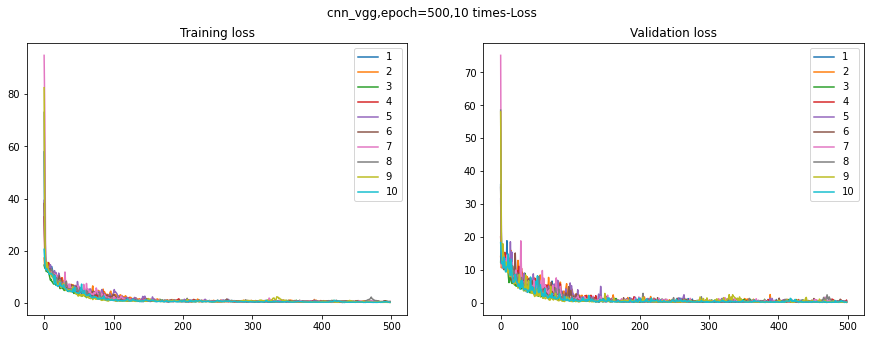

In [126]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
for i in range(10):
    ax[0].plot(history_vgg[i].history['loss'][1:], label=i+1)
    ax[1].plot(history_vgg[i].history['val_loss'][1:], label=i+1)
ax[0].legend()
ax[1].legend()
fig.suptitle('cnn_vgg,epoch=500,10 times-Loss')
ax[0].set_title('Training loss')
ax[1].set_title('Validation loss')

Text(0, 0.5, 'mean-squared-error')

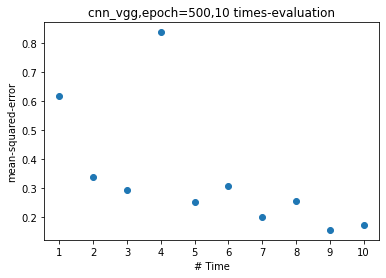

In [147]:
plt.scatter(x_axis, vgg_evals)
plt.title('cnn_vgg,epoch=500,10 times-evaluation')
plt.xticks(x_axis)
plt.xlabel('# Time')
plt.ylabel('mean-squared-error')